# 第4章　割引クーポンキャンペーンの効果最大化


## 4.3　データ理解

### データの確認

（1）　会員データ（customers.csv）の確認

In [2]:
import pandas as pd
cust_df = pd.read_csv('./data/customers.csv')
cust_df.shape

(5000, 3)

In [3]:
# ファイル上部のレコード
cust_df.head()

customer_id   age_cat freq_cat
0            1  age20~34    freq2
1            2  age35~49    freq0
2            3  age35~49    freq0
3            4    age~19    freq0
4            5  age35~49    freq0

In [4]:
# データの型
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<AxesSubplot:>

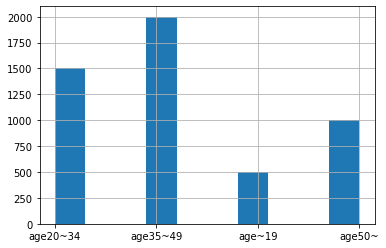

In [5]:
cust_df['age_cat'].hist()

<AxesSubplot:>

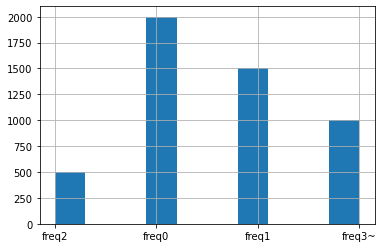

In [6]:
cust_df['freq_cat'].hist()

In [7]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat  freq0  freq1  freq2  freq3~
age_cat                              
age~19      200    150     50     100
age20~34    600    450    150     300
age35~49    800    600    200     400
age50~      400    300    100     200

<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

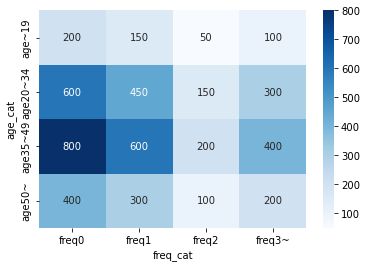

In [8]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

（2）　来店率データ（visit_probability.csv）の確認

In [9]:
prob_df = pd.read_csv('./data/visit_probability.csv')
prob_df.shape

(16, 6)

In [10]:
prob_df

age_cat freq_cat  segment_id  prob_dm1  prob_dm2  prob_dm3
0     age~19    freq0           1      0.07      0.12      0.29
1     age~19    freq1           2      0.21      0.30      0.58
2     age~19    freq2           3      0.28      0.39      0.74
3     age~19   freq3~           4      0.35      0.45      0.77
4   age20~34    freq0           5      0.11      0.17      0.37
5   age20~34    freq1           6      0.32      0.43      0.72
6   age20~34    freq2           7      0.42      0.55      0.93
7   age20~34   freq3~           8      0.52      0.63      0.94
8   age35~49    freq0           9      0.08      0.14      0.33
9   age35~49    freq1          10      0.25      0.35      0.67
10  age35~49    freq2          11      0.34      0.45      0.86
11  age35~49   freq3~          12      0.42      0.52      0.89
12    age50~    freq0          13      0.07      0.13      0.32
13    age50~    freq1          14      0.21      0.33      0.65
14    age50~    freq2          15      0.28      0.42      0.84
15    age50~   freq3~          16      0.35      0.49      0.88

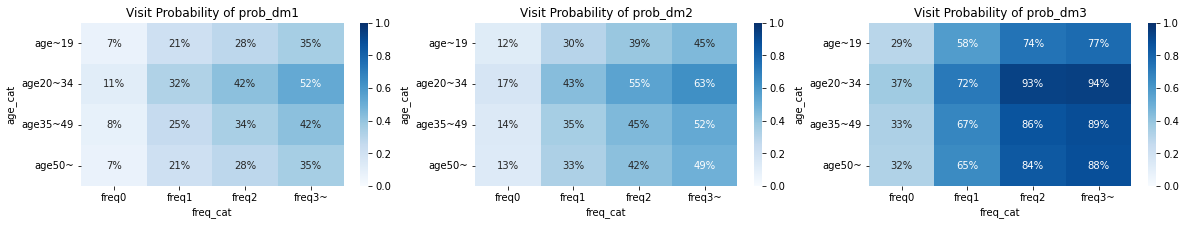

In [11]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex (['age~19','age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

## 4.4　数理モデリングと実装

### モデリング1：会員個別送付モデル

In [12]:
# !pip install pulp
import pulp

problem = pulp.LpProblem(name='DiscountCouponProblem1',sense=pulp.LpMaximize)

要件（1）　各会員に対してどのパターンのダイレクトメールを送付するかを決定

In [13]:
# 会員IDのリスト
I = cust_df['customer_id'].to_list()

In [14]:
# ダイレクトメールのパターンのリスト
M = [1, 2, 3]

In [15]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xim = {}
for i in I:
    for m in M:
        xim[i,m] = pulp.LpVariable(name=f'xim({i},{m})',cat='Binary')
# 決定変数の数
len(xim)

15000

要件（2）　各会員に対して送付するダイレクトメールはいずれか1 パターン

In [16]:
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for i in I:
    problem += pulp.lpSum(xim[i,m] for m in M) == 1

要件（3）　クーポン付与による来客増加数を最大化

In [17]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

customer_id   age_cat freq_cat  segment_id  prob_dm1  prob_dm2  prob_dm3
0            1  age20~34    freq2           7      0.42      0.55      0.93
1          199  age20~34    freq2           7      0.42      0.55      0.93
2          200  age20~34    freq2           7      0.42      0.55      0.93
3          255  age20~34    freq2           7      0.42      0.55      0.93
4          269  age20~34    freq2           7      0.42      0.55      0.93

In [18]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
                  .melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df

customer_id dm  prob
0                1  1  0.42
1              199  1  0.42
2              200  1  0.42
3              255  1  0.42
4              269  1  0.42
...            ... ..   ...
14995         4474  3  0.74
14996         4596  3  0.74
14997         4720  3  0.74
14998         4910  3  0.74
14999         4947  3  0.74

[15000 rows x 3 columns]

In [19]:
Pim = cust_prob_ver_df.set_index(['customer_id','dm'])['prob'].to_dict()

In [20]:
Pim[1,1]

0.42

In [21]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum((Pim[i,m] - Pim[i,1]) * xim[i,m] for i in I for m in [2,3])

要件（4）　会員の予算消費期待値の合計は100 万円以下

In [22]:
Cm = {1:0, 2:1000, 3:2000}

In [23]:
# （4）会員の消費する費用の期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Pim[i,m]* xim[i,m] for i in I for m in [2,3]) <= 1000000

In [24]:
# セグメントのリスト
S = prob_df['segment_id'].to_list()
len(S)

16

In [25]:
# 各セグメントとそのセグメントに属する会員数を対応させる辞書の作成
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [26]:
# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()

要件（5）　各パターンのダイレクトメールをそれぞれのセグメントに属する会員10% 以上に送付

In [27]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i,m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

In [ ]:
# 時間を計測
# モデリング1は、一部の環境ではgapRel（計算の終了判定とする上界と下界のギャップのしきい値）を指定しないと停止しない
# solver = pulp.PULP_CBC_CMD(gapRel=10e-4)

#import time
#time_start = time.time()
status = problem.solve()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
#time_stop = time.time()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ysaito/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/1cc64b588ff74ee2895a1f5244087624-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/1cc64b588ff74ee2895a1f5244087624-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 326.095 - 0.17 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.156863
Cbc0038I Pass   1: (0.37 seconds) suminf.    0.12500 (2) obj. -326.094 it

Cbc0038I Full problem 5049 rows 15000 columns, reduced to 16 rows 28 columns
Cbc0010I After 3000 nodes, 2605 on tree, -326.06 best solution, best possible -326.0951 (26.43 seconds)
Cbc0010I After 3100 nodes, 2705 on tree, -326.06 best solution, best possible -326.0951 (27.00 seconds)
Cbc0010I After 3200 nodes, 2805 on tree, -326.06 best solution, best possible -326.0951 (27.52 seconds)
Cbc0010I After 3300 nodes, 2905 on tree, -326.06 best solution, best possible -326.0951 (28.05 seconds)
Cbc0010I After 3400 nodes, 3005 on tree, -326.06 best solution, best possible -326.0951 (28.55 seconds)
Cbc0010I After 3500 nodes, 3105 on tree, -326.06 best solution, best possible -326.0951 (29.06 seconds)
Cbc0038I Full problem 5049 rows 15000 columns, reduced to 16 rows 28 columns
Cbc0010I After 3600 nodes, 3191 on tree, -326.06 best solution, best possible -326.0951 (31.75 seconds)
Cbc0010I After 3700 nodes, 3285 on tree, -326.06 best solution, best possible -326.0951 (33.97 seconds)
Cbc0010I After

Cbc0010I After 10200 nodes, 9784 on tree, -326.06 best solution, best possible -326.0951 (70.46 seconds)
Cbc0010I After 10300 nodes, 9884 on tree, -326.06 best solution, best possible -326.0951 (71.09 seconds)
Cbc0010I After 10400 nodes, 9984 on tree, -326.06 best solution, best possible -326.0951 (71.75 seconds)
Cbc0010I After 10500 nodes, 10084 on tree, -326.06 best solution, best possible -326.0951 (72.49 seconds)
Cbc0010I After 10600 nodes, 10184 on tree, -326.06 best solution, best possible -326.0951 (73.09 seconds)
Cbc0010I After 10700 nodes, 10284 on tree, -326.06 best solution, best possible -326.0951 (73.71 seconds)
Cbc0038I Full problem 5049 rows 15000 columns, reduced to 18 rows 29 columns
Cbc0010I After 10800 nodes, 10384 on tree, -326.06 best solution, best possible -326.0951 (74.36 seconds)
Cbc0010I After 10900 nodes, 10484 on tree, -326.06 best solution, best possible -326.0951 (74.95 seconds)
Cbc0010I After 11000 nodes, 10584 on tree, -326.06 best solution, best possibl

Cbc0010I After 17800 nodes, 17382 on tree, -326.06 best solution, best possible -326.0951 (113.04 seconds)
Cbc0010I After 17900 nodes, 17482 on tree, -326.06 best solution, best possible -326.0951 (113.66 seconds)
Cbc0038I Full problem 5049 rows 15000 columns, reduced to 18 rows 29 columns
Cbc0010I After 18000 nodes, 17582 on tree, -326.06 best solution, best possible -326.0951 (114.28 seconds)
Cbc0010I After 18100 nodes, 17682 on tree, -326.06 best solution, best possible -326.0951 (114.94 seconds)
Cbc0010I After 18200 nodes, 17782 on tree, -326.06 best solution, best possible -326.0951 (115.54 seconds)
Cbc0010I After 18300 nodes, 17882 on tree, -326.06 best solution, best possible -326.0951 (116.15 seconds)
Cbc0010I After 18400 nodes, 17982 on tree, -326.06 best solution, best possible -326.0951 (116.79 seconds)
Cbc0010I After 18500 nodes, 18082 on tree, -326.06 best solution, best possible -326.0951 (117.46 seconds)
Cbc0010I After 18600 nodes, 18182 on tree, -326.06 best solution, b

Cbc0010I After 25200 nodes, 24781 on tree, -326.06 best solution, best possible -326.0951 (155.09 seconds)
Cbc0010I After 25300 nodes, 24881 on tree, -326.06 best solution, best possible -326.0951 (155.74 seconds)
Cbc0010I After 25400 nodes, 24981 on tree, -326.06 best solution, best possible -326.0951 (156.34 seconds)
Cbc0010I After 25500 nodes, 25081 on tree, -326.06 best solution, best possible -326.0951 (156.92 seconds)
Cbc0010I After 25600 nodes, 25181 on tree, -326.06 best solution, best possible -326.0951 (157.51 seconds)
Cbc0010I After 25700 nodes, 25281 on tree, -326.06 best solution, best possible -326.0951 (158.18 seconds)
Cbc0010I After 25800 nodes, 25381 on tree, -326.06 best solution, best possible -326.0951 (158.83 seconds)
Cbc0010I After 25900 nodes, 25481 on tree, -326.06 best solution, best possible -326.0951 (159.49 seconds)
Cbc0010I After 26000 nodes, 25581 on tree, -326.06 best solution, best possible -326.0951 (160.14 seconds)
Cbc0010I After 26100 nodes, 25681 on 

Cbc0010I After 32800 nodes, 32381 on tree, -326.06 best solution, best possible -326.0951 (199.85 seconds)
Cbc0010I After 32900 nodes, 32481 on tree, -326.06 best solution, best possible -326.0951 (200.29 seconds)
Cbc0010I After 33000 nodes, 32581 on tree, -326.06 best solution, best possible -326.0951 (200.74 seconds)
Cbc0010I After 33100 nodes, 32680 on tree, -326.06 best solution, best possible -326.0951 (201.54 seconds)
Cbc0010I After 33200 nodes, 32780 on tree, -326.06 best solution, best possible -326.0951 (202.18 seconds)
Cbc0010I After 33300 nodes, 32880 on tree, -326.06 best solution, best possible -326.0951 (202.83 seconds)
Cbc0010I After 33400 nodes, 32980 on tree, -326.06 best solution, best possible -326.0951 (203.39 seconds)
Cbc0010I After 33500 nodes, 33080 on tree, -326.06 best solution, best possible -326.0951 (203.96 seconds)
Cbc0010I After 33600 nodes, 33180 on tree, -326.06 best solution, best possible -326.0951 (204.59 seconds)
Cbc0010I After 33700 nodes, 33280 on 

Cbc0010I After 40300 nodes, 39880 on tree, -326.06 best solution, best possible -326.0951 (245.28 seconds)
Cbc0010I After 40400 nodes, 39980 on tree, -326.06 best solution, best possible -326.0951 (245.81 seconds)
Cbc0010I After 40500 nodes, 40080 on tree, -326.06 best solution, best possible -326.0951 (246.38 seconds)
Cbc0010I After 40600 nodes, 40180 on tree, -326.06 best solution, best possible -326.0951 (246.94 seconds)
Cbc0010I After 40700 nodes, 40280 on tree, -326.06 best solution, best possible -326.0951 (247.47 seconds)
Cbc0010I After 40800 nodes, 40380 on tree, -326.06 best solution, best possible -326.0951 (247.99 seconds)
Cbc0010I After 40900 nodes, 40480 on tree, -326.06 best solution, best possible -326.0951 (248.50 seconds)
Cbc0010I After 41000 nodes, 40580 on tree, -326.06 best solution, best possible -326.0951 (248.94 seconds)
Cbc0010I After 41100 nodes, 40680 on tree, -326.06 best solution, best possible -326.0951 (249.75 seconds)
Cbc0010I After 41200 nodes, 40780 on 

Cbc0010I After 47900 nodes, 47479 on tree, -326.06 best solution, best possible -326.0951 (290.18 seconds)
Cbc0010I After 48000 nodes, 47579 on tree, -326.06 best solution, best possible -326.0951 (290.72 seconds)
Cbc0010I After 48100 nodes, 47679 on tree, -326.06 best solution, best possible -326.0951 (291.21 seconds)
Cbc0010I After 48200 nodes, 47779 on tree, -326.06 best solution, best possible -326.0951 (291.71 seconds)
Cbc0010I After 48300 nodes, 47879 on tree, -326.06 best solution, best possible -326.0951 (292.57 seconds)
Cbc0010I After 48400 nodes, 47979 on tree, -326.06 best solution, best possible -326.0951 (293.05 seconds)
Cbc0010I After 48500 nodes, 48079 on tree, -326.06 best solution, best possible -326.0951 (293.52 seconds)
Cbc0010I After 48600 nodes, 48179 on tree, -326.06 best solution, best possible -326.0951 (293.99 seconds)
Cbc0010I After 48700 nodes, 48279 on tree, -326.06 best solution, best possible -326.0951 (294.44 seconds)
Cbc0010I After 48800 nodes, 48379 on 

Cbc0010I After 55500 nodes, 55079 on tree, -326.06 best solution, best possible -326.0951 (334.16 seconds)
Cbc0010I After 55600 nodes, 55179 on tree, -326.06 best solution, best possible -326.0951 (334.68 seconds)
Cbc0010I After 55700 nodes, 55279 on tree, -326.06 best solution, best possible -326.0951 (335.21 seconds)
Cbc0010I After 55800 nodes, 55379 on tree, -326.06 best solution, best possible -326.0951 (335.74 seconds)
Cbc0010I After 55900 nodes, 55479 on tree, -326.06 best solution, best possible -326.0951 (336.26 seconds)
Cbc0010I After 56000 nodes, 55579 on tree, -326.06 best solution, best possible -326.0951 (336.78 seconds)
Cbc0010I After 56100 nodes, 55679 on tree, -326.06 best solution, best possible -326.0951 (337.31 seconds)
Cbc0010I After 56200 nodes, 55779 on tree, -326.06 best solution, best possible -326.0951 (337.82 seconds)
Cbc0010I After 56300 nodes, 55879 on tree, -326.06 best solution, best possible -326.0951 (338.76 seconds)
Cbc0010I After 56400 nodes, 55979 on 

Cbc0010I After 63200 nodes, 62778 on tree, -326.06 best solution, best possible -326.0951 (379.15 seconds)
Cbc0010I After 63300 nodes, 62878 on tree, -326.06 best solution, best possible -326.0951 (379.68 seconds)
Cbc0010I After 63400 nodes, 62978 on tree, -326.06 best solution, best possible -326.0951 (380.20 seconds)
Cbc0010I After 63500 nodes, 63078 on tree, -326.06 best solution, best possible -326.0951 (380.76 seconds)
Cbc0010I After 63600 nodes, 63178 on tree, -326.06 best solution, best possible -326.0951 (381.28 seconds)
Cbc0010I After 63700 nodes, 63278 on tree, -326.06 best solution, best possible -326.0951 (381.81 seconds)
Cbc0010I After 63800 nodes, 63378 on tree, -326.06 best solution, best possible -326.0951 (382.34 seconds)
Cbc0010I After 63900 nodes, 63478 on tree, -326.06 best solution, best possible -326.0951 (382.83 seconds)
Cbc0010I After 64000 nodes, 63578 on tree, -326.06 best solution, best possible -326.0951 (383.29 seconds)
Cbc0010I After 64100 nodes, 63678 on 

Cbc0010I After 70700 nodes, 70277 on tree, -326.06 best solution, best possible -326.0951 (421.89 seconds)
Cbc0010I After 70800 nodes, 70377 on tree, -326.06 best solution, best possible -326.0951 (422.49 seconds)
Cbc0010I After 70900 nodes, 70477 on tree, -326.06 best solution, best possible -326.0951 (423.08 seconds)
Cbc0010I After 71000 nodes, 70577 on tree, -326.06 best solution, best possible -326.0951 (423.68 seconds)
Cbc0010I After 71100 nodes, 70677 on tree, -326.06 best solution, best possible -326.0951 (424.24 seconds)
Cbc0010I After 71200 nodes, 70777 on tree, -326.06 best solution, best possible -326.0951 (424.79 seconds)
Cbc0010I After 71300 nodes, 70877 on tree, -326.06 best solution, best possible -326.0951 (425.33 seconds)
Cbc0010I After 71400 nodes, 70977 on tree, -326.06 best solution, best possible -326.0951 (425.83 seconds)
Cbc0010I After 71500 nodes, 71077 on tree, -326.06 best solution, best possible -326.0951 (426.35 seconds)
Cbc0010I After 71600 nodes, 71177 on 

Cbc0010I After 78400 nodes, 77976 on tree, -326.06 best solution, best possible -326.0951 (465.51 seconds)
Cbc0010I After 78500 nodes, 78076 on tree, -326.06 best solution, best possible -326.0951 (466.15 seconds)
Cbc0010I After 78600 nodes, 78176 on tree, -326.06 best solution, best possible -326.0951 (466.77 seconds)
Cbc0010I After 78700 nodes, 78276 on tree, -326.06 best solution, best possible -326.0951 (467.41 seconds)
Cbc0010I After 78800 nodes, 78376 on tree, -326.06 best solution, best possible -326.0951 (468.03 seconds)
Cbc0010I After 78900 nodes, 78476 on tree, -326.06 best solution, best possible -326.0951 (468.63 seconds)
Cbc0010I After 79000 nodes, 78576 on tree, -326.06 best solution, best possible -326.0951 (469.25 seconds)
Cbc0010I After 79100 nodes, 78676 on tree, -326.06 best solution, best possible -326.0951 (469.81 seconds)
Cbc0010I After 79200 nodes, 78776 on tree, -326.06 best solution, best possible -326.0951 (470.37 seconds)
Cbc0010I After 79300 nodes, 78876 on 

Cbc0010I After 86100 nodes, 85675 on tree, -326.06 best solution, best possible -326.0951 (509.84 seconds)
Cbc0010I After 86200 nodes, 85775 on tree, -326.06 best solution, best possible -326.0951 (510.46 seconds)
Cbc0010I After 86300 nodes, 85875 on tree, -326.06 best solution, best possible -326.0951 (511.11 seconds)
Cbc0038I Full problem 5049 rows 15000 columns, reduced to 18 rows 29 columns
Cbc0010I After 86400 nodes, 85975 on tree, -326.06 best solution, best possible -326.0951 (511.78 seconds)
Cbc0010I After 86500 nodes, 86075 on tree, -326.06 best solution, best possible -326.0951 (512.39 seconds)
Cbc0010I After 86600 nodes, 86175 on tree, -326.06 best solution, best possible -326.0951 (512.99 seconds)
Cbc0010I After 86700 nodes, 86275 on tree, -326.06 best solution, best possible -326.0951 (513.61 seconds)
Cbc0010I After 86800 nodes, 86375 on tree, -326.06 best solution, best possible -326.0951 (514.19 seconds)
Cbc0010I After 86900 nodes, 86475 on tree, -326.06 best solution, b

Cbc0010I After 93600 nodes, 93175 on tree, -326.06 best solution, best possible -326.0951 (551.06 seconds)
Cbc0010I After 93700 nodes, 93275 on tree, -326.06 best solution, best possible -326.0951 (551.86 seconds)
Cbc0010I After 93800 nodes, 93375 on tree, -326.06 best solution, best possible -326.0951 (552.53 seconds)
Cbc0010I After 93900 nodes, 93475 on tree, -326.06 best solution, best possible -326.0951 (553.14 seconds)
Cbc0010I After 94000 nodes, 93575 on tree, -326.06 best solution, best possible -326.0951 (553.75 seconds)
Cbc0010I After 94100 nodes, 93675 on tree, -326.06 best solution, best possible -326.0951 (554.37 seconds)
Cbc0010I After 94200 nodes, 93775 on tree, -326.06 best solution, best possible -326.0951 (554.99 seconds)
Cbc0010I After 94300 nodes, 93875 on tree, -326.06 best solution, best possible -326.0951 (555.65 seconds)
Cbc0010I After 94400 nodes, 93975 on tree, -326.06 best solution, best possible -326.0951 (556.30 seconds)
Cbc0010I After 94500 nodes, 94075 on 

Cbc0010I After 101300 nodes, 100874 on tree, -326.06 best solution, best possible -326.0951 (592.66 seconds)
Cbc0010I After 101400 nodes, 100974 on tree, -326.06 best solution, best possible -326.0951 (593.02 seconds)
Cbc0010I After 101500 nodes, 101074 on tree, -326.06 best solution, best possible -326.0951 (593.41 seconds)
Cbc0010I After 101600 nodes, 101174 on tree, -326.06 best solution, best possible -326.0951 (593.79 seconds)
Cbc0010I After 101700 nodes, 101274 on tree, -326.06 best solution, best possible -326.0951 (594.16 seconds)
Cbc0010I After 101800 nodes, 101374 on tree, -326.06 best solution, best possible -326.0951 (594.57 seconds)
Cbc0010I After 101900 nodes, 101474 on tree, -326.06 best solution, best possible -326.0951 (594.94 seconds)
Cbc0010I After 102000 nodes, 101574 on tree, -326.06 best solution, best possible -326.0951 (595.34 seconds)
Cbc0010I After 102100 nodes, 101674 on tree, -326.06 best solution, best possible -326.0951 (595.72 seconds)
Cbc0010I After 1022

Cbc0010I After 108800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (646.49 seconds)
Cbc0010I After 108900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (647.35 seconds)
Cbc0010I After 109000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (648.01 seconds)
Cbc0010I After 109100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (648.82 seconds)
Cbc0010I After 109200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (649.60 seconds)
Cbc0010I After 109300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (650.39 seconds)
Cbc0010I After 109400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (651.22 seconds)
Cbc0010I After 109500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (651.86 seconds)
Cbc0010I After 109600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (652.68 seconds)
Cbc0010I After 1097

Cbc0010I After 116300 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (711.67 seconds)
Cbc0010I After 116400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (712.50 seconds)
Cbc0010I After 116500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (713.34 seconds)
Cbc0010I After 116600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (714.18 seconds)
Cbc0010I After 116700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (715.15 seconds)
Cbc0010I After 116800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (715.95 seconds)
Cbc0010I After 116900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (716.87 seconds)
Cbc0010I After 117000 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (717.69 seconds)
Cbc0010I After 117100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (718.65 seconds)
Cbc0010I After 1172

Cbc0010I After 123800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (779.28 seconds)
Cbc0010I After 123900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (780.08 seconds)
Cbc0010I After 124000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (781.06 seconds)
Cbc0010I After 124100 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (781.86 seconds)
Cbc0010I After 124200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (782.83 seconds)
Cbc0010I After 124300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (783.75 seconds)
Cbc0010I After 124400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (784.69 seconds)
Cbc0010I After 124500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (785.60 seconds)
Cbc0010I After 124600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (786.42 seconds)
Cbc0010I After 1247

Cbc0010I After 131300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (845.85 seconds)
Cbc0010I After 131400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (846.81 seconds)
Cbc0010I After 131500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (847.72 seconds)
Cbc0010I After 131600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (848.63 seconds)
Cbc0010I After 131700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (849.58 seconds)
Cbc0010I After 131800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (850.39 seconds)
Cbc0010I After 131900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (851.32 seconds)
Cbc0010I After 132000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (852.17 seconds)
Cbc0010I After 132100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (853.10 seconds)
Cbc0010I After 1322

Cbc0010I After 138800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (913.10 seconds)
Cbc0010I After 138900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (914.05 seconds)
Cbc0010I After 139000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (914.84 seconds)
Cbc0010I After 139100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (915.79 seconds)
Cbc0010I After 139200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (916.70 seconds)
Cbc0010I After 139300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (917.52 seconds)
Cbc0010I After 139400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (918.48 seconds)
Cbc0010I After 139500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (919.32 seconds)
Cbc0010I After 139600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (920.23 seconds)
Cbc0010I After 1397

Cbc0010I After 146300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (979.71 seconds)
Cbc0010I After 146400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (980.73 seconds)
Cbc0010I After 146500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (981.54 seconds)
Cbc0010I After 146600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (982.46 seconds)
Cbc0010I After 146700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (983.33 seconds)
Cbc0010I After 146800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (984.33 seconds)
Cbc0010I After 146900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (985.27 seconds)
Cbc0010I After 147000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (986.09 seconds)
Cbc0010I After 147100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (987.04 seconds)
Cbc0010I After 1472

Cbc0010I After 153800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (1049.75 seconds)
Cbc0010I After 153900 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (1050.73 seconds)
Cbc0010I After 154000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1051.60 seconds)
Cbc0010I After 154100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (1052.60 seconds)
Cbc0010I After 154200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (1053.65 seconds)
Cbc0010I After 154300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1054.49 seconds)
Cbc0010I After 154400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (1055.52 seconds)
Cbc0010I After 154500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1056.30 seconds)
Cbc0010I After 154600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (1057.04 seconds)
Cbc0010I A

Cbc0010I After 161200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (1120.23 seconds)
Cbc0010I After 161300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1121.15 seconds)
Cbc0010I After 161400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1122.19 seconds)
Cbc0010I After 161500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (1123.23 seconds)
Cbc0010I After 161600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1124.17 seconds)
Cbc0010I After 161700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (1125.19 seconds)
Cbc0010I After 161800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1126.15 seconds)
Cbc0010I After 161900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (1127.21 seconds)
Cbc0010I After 162000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (1128.21 seconds)
Cbc0010I A

Cbc0010I After 168700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (1192.37 seconds)
Cbc0010I After 168800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (1193.42 seconds)
Cbc0010I After 168900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1194.30 seconds)
Cbc0010I After 169000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1195.35 seconds)
Cbc0010I After 169100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1196.32 seconds)
Cbc0010I After 169200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1197.28 seconds)
Cbc0010I After 169300 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (1198.28 seconds)
Cbc0010I After 169400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1199.19 seconds)
Cbc0010I After 169500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (1200.24 seconds)
Cbc0010I A

Cbc0010I After 176000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (1262.00 seconds)
Cbc0010I After 176100 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (1262.98 seconds)
Cbc0010I After 176200 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (1263.77 seconds)
Cbc0010I After 176300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (1264.59 seconds)
Cbc0010I After 176400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1265.40 seconds)
Cbc0010I After 176500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (1266.16 seconds)
Cbc0010I After 176600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1267.05 seconds)
Cbc0010I After 176700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (1267.88 seconds)
Cbc0010I After 176800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (1268.84 seconds)
Cbc0010I A

Cbc0010I After 183500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (1332.35 seconds)
Cbc0010I After 183600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1333.33 seconds)
Cbc0010I After 183700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (1334.41 seconds)
Cbc0010I After 183800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (1335.34 seconds)
Cbc0010I After 183900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (1336.35 seconds)
Cbc0010I After 184000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (1337.26 seconds)
Cbc0010I After 184100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1338.34 seconds)
Cbc0010I After 184200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1339.35 seconds)
Cbc0010I After 184300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (1340.31 seconds)
Cbc0010I A

Cbc0010I After 190900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1403.57 seconds)
Cbc0010I After 191000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (1404.57 seconds)
Cbc0010I After 191100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (1405.53 seconds)
Cbc0010I After 191200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1406.56 seconds)
Cbc0010I After 191300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (1407.50 seconds)
Cbc0010I After 191400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1408.34 seconds)
Cbc0010I After 191500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1409.36 seconds)
Cbc0010I After 191600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (1410.26 seconds)
Cbc0010I After 191700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (1411.27 seconds)
Cbc0010I A

Cbc0010I After 198400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1475.80 seconds)
Cbc0010I After 198500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (1476.78 seconds)
Cbc0010I After 198600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1477.83 seconds)
Cbc0010I After 198700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1478.72 seconds)
Cbc0010I After 198800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (1479.70 seconds)
Cbc0010I After 198900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (1480.66 seconds)
Cbc0010I After 199000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (1481.59 seconds)
Cbc0010I After 199100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (1482.57 seconds)
Cbc0010I After 199200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1483.46 seconds)
Cbc0010I A

Cbc0010I After 205800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1545.83 seconds)
Cbc0010I After 205900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (1546.87 seconds)
Cbc0010I After 206000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1547.81 seconds)
Cbc0010I After 206100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (1548.90 seconds)
Cbc0010I After 206200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (1549.96 seconds)
Cbc0010I After 206300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1550.81 seconds)
Cbc0010I After 206400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (1551.81 seconds)
Cbc0010I After 206500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (1552.78 seconds)
Cbc0010I After 206600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (1553.73 seconds)
Cbc0010I A

Cbc0010I After 213300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1611.95 seconds)
Cbc0010I After 213400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (1612.60 seconds)
Cbc0010I After 213500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (1613.44 seconds)
Cbc0010I After 213600 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (1614.19 seconds)
Cbc0010I After 213700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (1615.11 seconds)
Cbc0010I After 213800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (1615.93 seconds)
Cbc0010I After 213900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (1616.88 seconds)
Cbc0010I After 214000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (1617.79 seconds)
Cbc0010I After 214100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (1618.45 seconds)
Cbc0010I A

Cbc0010I After 220700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1674.16 seconds)
Cbc0010I After 220800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (1675.01 seconds)
Cbc0010I After 220900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (1675.99 seconds)
Cbc0010I After 221000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1677.06 seconds)
Cbc0010I After 221100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1678.01 seconds)
Cbc0010I After 221200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1678.99 seconds)
Cbc0010I After 221300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (1679.72 seconds)
Cbc0010I After 221400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (1680.64 seconds)
Cbc0010I After 221500 nodes, 103035 on tree, -326.06 best solution, best possible -326.0951 (1681.34 seconds)
Cbc0010I A

Cbc0010I After 228100 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (1737.38 seconds)
Cbc0010I After 228200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (1738.32 seconds)
Cbc0010I After 228300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1739.13 seconds)
Cbc0010I After 228400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (1739.93 seconds)
Cbc0010I After 228500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1740.75 seconds)
Cbc0010I After 228600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (1741.49 seconds)
Cbc0010I After 228700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1742.36 seconds)
Cbc0010I After 228800 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (1743.14 seconds)
Cbc0010I After 228900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (1744.12 seconds)
Cbc0010I A

Cbc0010I After 235500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (1801.76 seconds)
Cbc0010I After 235600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1802.70 seconds)
Cbc0010I After 235700 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (1803.49 seconds)
Cbc0010I After 235800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (1804.41 seconds)
Cbc0010I After 235900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1805.27 seconds)
Cbc0010I After 236000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1806.03 seconds)
Cbc0010I After 236100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (1806.93 seconds)
Cbc0010I After 236200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (1807.73 seconds)
Cbc0010I After 236300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (1808.74 seconds)
Cbc0010I A

Cbc0010I After 242900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1866.60 seconds)
Cbc0010I After 243000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (1867.48 seconds)
Cbc0010I After 243100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (1868.46 seconds)
Cbc0010I After 243200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (1869.35 seconds)
Cbc0010I After 243300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (1870.33 seconds)
Cbc0010I After 243400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (1871.31 seconds)
Cbc0010I After 243500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (1872.17 seconds)
Cbc0010I After 243600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (1873.14 seconds)
Cbc0010I After 243700 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (1873.91 seconds)
Cbc0010I A

Cbc0010I After 250400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1931.00 seconds)
Cbc0010I After 250500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (1931.97 seconds)
Cbc0010I After 250600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (1932.86 seconds)
Cbc0010I After 250700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1933.89 seconds)
Cbc0010I After 250800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (1934.84 seconds)
Cbc0010I After 250900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (1935.72 seconds)
Cbc0010I After 251000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (1936.67 seconds)
Cbc0010I After 251100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (1937.37 seconds)
Cbc0010I After 251200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1938.22 seconds)
Cbc0010I A

Cbc0010I After 257800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (1995.64 seconds)
Cbc0010I After 257900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (1996.53 seconds)
Cbc0010I After 258000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (1997.48 seconds)
Cbc0010I After 258100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (1998.38 seconds)
Cbc0010I After 258200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (1999.37 seconds)
Cbc0010I After 258300 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (2000.07 seconds)
Cbc0010I After 258400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (2000.88 seconds)
Cbc0010I After 258500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2001.73 seconds)
Cbc0010I After 258600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (2002.49 seconds)
Cbc0010I A

Cbc0010I After 265200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2061.12 seconds)
Cbc0010I After 265300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2062.01 seconds)
Cbc0010I After 265400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2062.92 seconds)
Cbc0010I After 265500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (2063.91 seconds)
Cbc0010I After 265600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (2064.78 seconds)
Cbc0010I After 265700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (2065.77 seconds)
Cbc0010I After 265800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (2066.73 seconds)
Cbc0010I After 265900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (2067.69 seconds)
Cbc0010I After 266000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (2068.68 seconds)
Cbc0010I A

Cbc0010I After 272600 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (2126.40 seconds)
Cbc0010I After 272700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2127.30 seconds)
Cbc0010I After 272800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (2128.12 seconds)
Cbc0010I After 272900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (2129.08 seconds)
Cbc0010I After 273000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (2130.00 seconds)
Cbc0010I After 273100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (2130.86 seconds)
Cbc0010I After 273200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2131.83 seconds)
Cbc0010I After 273300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (2132.72 seconds)
Cbc0010I After 273400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2133.77 seconds)
Cbc0010I A

Cbc0010I After 280100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (2193.66 seconds)
Cbc0010I After 280200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2194.53 seconds)
Cbc0010I After 280300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (2195.49 seconds)
Cbc0010I After 280400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (2196.40 seconds)
Cbc0010I After 280500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2197.40 seconds)
Cbc0010I After 280600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (2198.36 seconds)
Cbc0010I After 280700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (2199.23 seconds)
Cbc0038I Full problem 5049 rows 15000 columns, reduced to 20 rows 32 columns
Cbc0010I After 280800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (2200.23 seconds)
Cbc0010I After 280900 nodes, 103031 on tree

Cbc0010I After 287500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (2259.21 seconds)
Cbc0010I After 287600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2260.01 seconds)
Cbc0010I After 287700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (2260.81 seconds)
Cbc0010I After 287800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (2261.65 seconds)
Cbc0010I After 287900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2262.49 seconds)
Cbc0010I After 288000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (2263.40 seconds)
Cbc0010I After 288100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2264.38 seconds)
Cbc0010I After 288200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (2265.09 seconds)
Cbc0010I After 288300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (2265.92 seconds)
Cbc0010I A

Cbc0010I After 294900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2324.48 seconds)
Cbc0010I After 295000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2325.30 seconds)
Cbc0010I After 295100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2326.36 seconds)
Cbc0010I After 295200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (2327.19 seconds)
Cbc0010I After 295300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2328.18 seconds)
Cbc0010I After 295400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (2329.17 seconds)
Cbc0010I After 295500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (2329.81 seconds)
Cbc0010I After 295600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2330.60 seconds)
Cbc0010I After 295700 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (2331.37 seconds)
Cbc0010I A

Cbc0010I After 302400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (2392.84 seconds)
Cbc0010I After 302500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2393.83 seconds)
Cbc0010I After 302600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (2394.85 seconds)
Cbc0010I After 302700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2395.74 seconds)
Cbc0010I After 302800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (2396.74 seconds)
Cbc0010I After 302900 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (2397.41 seconds)
Cbc0010I After 303000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (2398.27 seconds)
Cbc0010I After 303100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2399.11 seconds)
Cbc0010I After 303200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (2399.88 seconds)
Cbc0010I A

Cbc0010I After 309800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (2457.06 seconds)
Cbc0010I After 309900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (2457.91 seconds)
Cbc0010I After 310000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2458.91 seconds)
Cbc0010I After 310100 nodes, 103036 on tree, -326.06 best solution, best possible -326.0951 (2459.69 seconds)
Cbc0010I After 310200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (2460.51 seconds)
Cbc0010I After 310300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2461.34 seconds)
Cbc0010I After 310400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (2462.11 seconds)
Cbc0010I After 310500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (2462.99 seconds)
Cbc0010I After 310600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (2463.83 seconds)
Cbc0010I A

Cbc0010I After 317300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2524.60 seconds)
Cbc0010I After 317400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (2525.56 seconds)
Cbc0010I After 317500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (2526.24 seconds)
Cbc0010I After 317600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2527.06 seconds)
Cbc0010I After 317700 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (2527.85 seconds)
Cbc0010I After 317800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2528.71 seconds)
Cbc0010I After 317900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2529.57 seconds)
Cbc0010I After 318000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2530.44 seconds)
Cbc0010I After 318100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (2531.39 seconds)
Cbc0010I A

Cbc0010I After 324600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (2591.42 seconds)
Cbc0010I After 324700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2592.27 seconds)
Cbc0010I After 324800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2593.31 seconds)
Cbc0010I After 324900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (2594.17 seconds)
Cbc0010I After 325000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2595.17 seconds)
Cbc0010I After 325100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (2596.12 seconds)
Cbc0010I After 325200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2597.00 seconds)
Cbc0010I After 325300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (2597.98 seconds)
Cbc0010I After 325400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (2598.84 seconds)
Cbc0010I A

Cbc0010I After 332100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2657.27 seconds)
Cbc0010I After 332200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (2658.00 seconds)
Cbc0010I After 332300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2658.94 seconds)
Cbc0010I After 332400 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (2659.74 seconds)
Cbc0010I After 332500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (2660.70 seconds)
Cbc0010I After 332600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (2661.64 seconds)
Cbc0010I After 332700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2662.52 seconds)
Cbc0010I After 332800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2663.53 seconds)
Cbc0010I After 332900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (2664.35 seconds)
Cbc0010I A

Cbc0010I After 339500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (2722.97 seconds)
Cbc0010I After 339600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (2723.98 seconds)
Cbc0010I After 339700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (2724.90 seconds)
Cbc0010I After 339800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (2725.85 seconds)
Cbc0010I After 339900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (2726.82 seconds)
Cbc0010I After 340000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (2727.69 seconds)
Cbc0010I After 340100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2728.68 seconds)
Cbc0010I After 340200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (2729.62 seconds)
Cbc0010I After 340300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2730.51 seconds)
Cbc0010I A

Cbc0010I After 347000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2791.67 seconds)
Cbc0010I After 347100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (2792.67 seconds)
Cbc0010I After 347200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (2793.53 seconds)
Cbc0010I After 347300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (2794.53 seconds)
Cbc0010I After 347400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (2795.41 seconds)
Cbc0010I After 347500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (2796.40 seconds)
Cbc0010I After 347600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (2797.35 seconds)
Cbc0010I After 347700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2798.27 seconds)
Cbc0010I After 347800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (2799.27 seconds)
Cbc0010I A

Cbc0010I After 354400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (2860.26 seconds)
Cbc0010I After 354500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2861.23 seconds)
Cbc0010I After 354600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (2862.20 seconds)
Cbc0010I After 354700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (2863.08 seconds)
Cbc0010I After 354800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2864.08 seconds)
Cbc0010I After 354900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2864.98 seconds)
Cbc0010I After 355000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2865.91 seconds)
Cbc0010I After 355100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (2866.89 seconds)
Cbc0010I After 355200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2867.78 seconds)
Cbc0010I A

Cbc0010I After 361900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2925.14 seconds)
Cbc0010I After 362000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2926.10 seconds)
Cbc0010I After 362100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (2926.94 seconds)
Cbc0010I After 362200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2927.93 seconds)
Cbc0010I After 362300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (2928.79 seconds)
Cbc0010I After 362400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (2929.73 seconds)
Cbc0010I After 362500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (2930.72 seconds)
Cbc0010I After 362600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (2931.57 seconds)
Cbc0010I After 362700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2932.57 seconds)
Cbc0010I A

Cbc0010I After 369300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (2992.29 seconds)
Cbc0010I After 369400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (2993.34 seconds)
Cbc0010I After 369500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (2994.00 seconds)
Cbc0010I After 369600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (2994.81 seconds)
Cbc0010I After 369700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (2995.62 seconds)
Cbc0010I After 369800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (2996.39 seconds)
Cbc0010I After 369900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (2997.32 seconds)
Cbc0010I After 370000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (2998.17 seconds)
Cbc0010I After 370100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (2999.09 seconds)
Cbc0010I A

Cbc0010I After 376800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3064.02 seconds)
Cbc0010I After 376900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3064.97 seconds)
Cbc0010I After 377000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3065.96 seconds)
Cbc0010I After 377100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (3067.01 seconds)
Cbc0010I After 377200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (3067.95 seconds)
Cbc0010I After 377300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3068.97 seconds)
Cbc0010I After 377400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (3069.96 seconds)
Cbc0010I After 377500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3070.91 seconds)
Cbc0010I After 377600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (3072.00 seconds)
Cbc0010I A

Cbc0010I After 384200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (3136.31 seconds)
Cbc0010I After 384300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (3137.42 seconds)
Cbc0010I After 384400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (3138.57 seconds)
Cbc0010I After 384500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (3139.62 seconds)
Cbc0010I After 384600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (3140.74 seconds)
Cbc0010I After 384700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (3141.69 seconds)
Cbc0010I After 384800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (3142.85 seconds)
Cbc0010I After 384900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (3143.97 seconds)
Cbc0010I After 385000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3144.97 seconds)
Cbc0010I A

Cbc0010I After 391700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (3209.71 seconds)
Cbc0010I After 391800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (3210.67 seconds)
Cbc0010I After 391900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (3211.56 seconds)
Cbc0010I After 392000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (3212.63 seconds)
Cbc0010I After 392100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (3213.52 seconds)
Cbc0010I After 392200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (3214.60 seconds)
Cbc0010I After 392300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3215.70 seconds)
Cbc0010I After 392400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (3216.63 seconds)
Cbc0010I After 392500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3217.62 seconds)
Cbc0010I A

Cbc0010I After 399100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3281.48 seconds)
Cbc0010I After 399200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (3282.58 seconds)
Cbc0010I After 399300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3283.42 seconds)
Cbc0010I After 399400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (3284.51 seconds)
Cbc0010I After 399500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (3285.47 seconds)
Cbc0010I After 399600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (3286.52 seconds)
Cbc0010I After 399700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (3287.65 seconds)
Cbc0010I After 399800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (3288.34 seconds)
Cbc0010I After 399900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3289.24 seconds)
Cbc0010I A

Cbc0010I After 406600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3355.19 seconds)
Cbc0010I After 406700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (3356.13 seconds)
Cbc0010I After 406800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3357.25 seconds)
Cbc0010I After 406900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (3358.41 seconds)
Cbc0010I After 407000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3359.40 seconds)
Cbc0010I After 407100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (3360.52 seconds)
Cbc0010I After 407200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (3361.53 seconds)
Cbc0010I After 407300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (3362.68 seconds)
Cbc0010I After 407400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (3363.87 seconds)
Cbc0010I A

Cbc0010I After 414000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (3431.41 seconds)
Cbc0010I After 414100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (3432.55 seconds)
Cbc0010I After 414200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (3433.54 seconds)
Cbc0010I After 414300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3434.68 seconds)
Cbc0010I After 414400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (3435.79 seconds)
Cbc0010I After 414500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (3436.78 seconds)
Cbc0010I After 414600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (3437.93 seconds)
Cbc0010I After 414700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (3439.02 seconds)
Cbc0010I After 414800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (3440.12 seconds)
Cbc0010I A

Cbc0010I After 421500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (3507.55 seconds)
Cbc0010I After 421600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (3508.42 seconds)
Cbc0010I After 421700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (3509.33 seconds)
Cbc0010I After 421800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3510.25 seconds)
Cbc0010I After 421900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (3511.19 seconds)
Cbc0010I After 422000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3512.26 seconds)
Cbc0010I After 422100 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (3513.02 seconds)
Cbc0010I After 422200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (3513.90 seconds)
Cbc0010I After 422300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3514.73 seconds)
Cbc0010I A

Cbc0010I After 428900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3577.62 seconds)
Cbc0010I After 429000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3578.75 seconds)
Cbc0010I After 429100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (3579.67 seconds)
Cbc0010I After 429200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (3580.77 seconds)
Cbc0010I After 429300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (3581.81 seconds)
Cbc0010I After 429400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (3582.52 seconds)
Cbc0010I After 429500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3583.41 seconds)
Cbc0010I After 429600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (3584.26 seconds)
Cbc0010I After 429700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3585.18 seconds)
Cbc0010I A

Cbc0010I After 436300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (3649.89 seconds)
Cbc0010I After 436400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (3650.93 seconds)
Cbc0010I After 436500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (3652.03 seconds)
Cbc0010I After 436600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3652.98 seconds)
Cbc0010I After 436700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (3654.15 seconds)
Cbc0010I After 436800 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (3654.87 seconds)
Cbc0010I After 436900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (3655.78 seconds)
Cbc0010I After 437000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (3656.68 seconds)
Cbc0010I After 437100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (3657.48 seconds)
Cbc0010I A

Cbc0010I After 443800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3724.03 seconds)
Cbc0010I After 443900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3725.15 seconds)
Cbc0010I After 444000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (3726.06 seconds)
Cbc0010I After 444100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3727.15 seconds)
Cbc0010I After 444200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (3728.23 seconds)
Cbc0010I After 444300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (3729.20 seconds)
Cbc0010I After 444400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (3730.26 seconds)
Cbc0010I After 444500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (3731.24 seconds)
Cbc0010I After 444600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3732.30 seconds)
Cbc0010I A

Cbc0010I After 451200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (3797.98 seconds)
Cbc0010I After 451300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3798.90 seconds)
Cbc0010I After 451400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3800.02 seconds)
Cbc0010I After 451500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (3800.95 seconds)
Cbc0010I After 451600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3802.02 seconds)
Cbc0010I After 451700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (3803.04 seconds)
Cbc0010I After 451800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (3804.00 seconds)
Cbc0010I After 451900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (3805.08 seconds)
Cbc0010I After 452000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (3806.00 seconds)
Cbc0010I A

Cbc0010I After 458700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (3873.30 seconds)
Cbc0010I After 458800 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (3874.00 seconds)
Cbc0010I After 458900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (3874.92 seconds)
Cbc0010I After 459000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (3875.70 seconds)
Cbc0010I After 459100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (3876.51 seconds)
Cbc0010I After 459200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3877.43 seconds)
Cbc0010I After 459300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (3878.26 seconds)
Cbc0010I After 459400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (3879.25 seconds)
Cbc0010I After 459500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (3880.01 seconds)
Cbc0010I A

Cbc0010I After 466100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (3941.98 seconds)
Cbc0010I After 466200 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (3942.86 seconds)
Cbc0010I After 466300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (3943.82 seconds)
Cbc0010I After 466400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (3944.74 seconds)
Cbc0010I After 466500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (3945.66 seconds)
Cbc0010I After 466600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (3946.72 seconds)
Cbc0010I After 466700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (3947.62 seconds)
Cbc0010I After 466800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (3948.66 seconds)
Cbc0010I After 466900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (3949.61 seconds)
Cbc0010I A

Cbc0010I After 473600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (4015.57 seconds)
Cbc0010I After 473700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4016.63 seconds)
Cbc0010I After 473800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (4017.61 seconds)
Cbc0010I After 473900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4018.56 seconds)
Cbc0010I After 474000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (4019.70 seconds)
Cbc0010I After 474100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (4020.65 seconds)
Cbc0010I After 474200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4021.71 seconds)
Cbc0010I After 474300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (4022.83 seconds)
Cbc0010I After 474400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4023.77 seconds)
Cbc0010I A

Cbc0010I After 481000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (4089.40 seconds)
Cbc0010I After 481100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (4090.33 seconds)
Cbc0010I After 481200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4091.44 seconds)
Cbc0010I After 481300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (4092.53 seconds)
Cbc0010I After 481400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4093.46 seconds)
Cbc0010I After 481500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (4094.61 seconds)
Cbc0010I After 481600 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (4095.30 seconds)
Cbc0010I After 481700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (4096.22 seconds)
Cbc0010I After 481800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4097.19 seconds)
Cbc0010I A

Cbc0010I After 488500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (4165.28 seconds)
Cbc0010I After 488600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (4166.19 seconds)
Cbc0010I After 488700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (4167.22 seconds)
Cbc0010I After 488800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (4168.21 seconds)
Cbc0010I After 488900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (4168.78 seconds)
Cbc0010I After 489000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (4169.63 seconds)
Cbc0010I After 489100 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (4170.38 seconds)
Cbc0010I After 489200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4171.26 seconds)
Cbc0010I After 489300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4172.10 seconds)
Cbc0010I A

Cbc0010I After 495900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4233.76 seconds)
Cbc0010I After 496000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (4234.76 seconds)
Cbc0010I After 496100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4235.68 seconds)
Cbc0010I After 496200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4236.63 seconds)
Cbc0010I After 496300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (4237.67 seconds)
Cbc0010I After 496400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4238.52 seconds)
Cbc0010I After 496500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (4239.49 seconds)
Cbc0010I After 496600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (4240.44 seconds)
Cbc0010I After 496700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4241.35 seconds)
Cbc0010I A

Cbc0010I After 503400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4302.42 seconds)
Cbc0010I After 503500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (4303.28 seconds)
Cbc0010I After 503600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (4304.35 seconds)
Cbc0010I After 503700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4305.33 seconds)
Cbc0010I After 503800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (4306.07 seconds)
Cbc0010I After 503900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4306.95 seconds)
Cbc0010I After 504000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (4307.78 seconds)
Cbc0010I After 504100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4308.65 seconds)
Cbc0010I After 504200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (4309.52 seconds)
Cbc0010I A

Cbc0010I After 510800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (4372.14 seconds)
Cbc0010I After 510900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (4373.21 seconds)
Cbc0010I After 511000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (4374.10 seconds)
Cbc0010I After 511100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (4374.92 seconds)
Cbc0010I After 511200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4375.82 seconds)
Cbc0010I After 511300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (4376.59 seconds)
Cbc0010I After 511400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4377.50 seconds)
Cbc0010I After 511500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (4378.36 seconds)
Cbc0010I After 511600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4379.40 seconds)
Cbc0010I A

Cbc0010I After 518300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4445.11 seconds)
Cbc0010I After 518400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (4446.19 seconds)
Cbc0010I After 518500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (4446.86 seconds)
Cbc0010I After 518600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4447.75 seconds)
Cbc0010I After 518700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (4448.55 seconds)
Cbc0010I After 518800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (4449.52 seconds)
Cbc0010I After 518900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (4450.37 seconds)
Cbc0010I After 519000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (4451.31 seconds)
Cbc0010I After 519100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4452.29 seconds)
Cbc0010I A

Cbc0010I After 525700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (4516.86 seconds)
Cbc0010I After 525800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4517.91 seconds)
Cbc0010I After 525900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (4518.83 seconds)
Cbc0010I After 526000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4519.86 seconds)
Cbc0010I After 526100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (4520.92 seconds)
Cbc0010I After 526200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (4521.88 seconds)
Cbc0010I After 526300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4522.92 seconds)
Cbc0010I After 526400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (4523.84 seconds)
Cbc0010I After 526500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (4524.90 seconds)
Cbc0010I A

Cbc0010I After 533200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (4591.25 seconds)
Cbc0010I After 533300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4592.38 seconds)
Cbc0010I After 533400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (4593.30 seconds)
Cbc0010I After 533500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (4594.36 seconds)
Cbc0010I After 533600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (4595.40 seconds)
Cbc0010I After 533700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (4596.36 seconds)
Cbc0010I After 533800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (4597.44 seconds)
Cbc0010I After 533900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4598.43 seconds)
Cbc0010I After 534000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4599.44 seconds)
Cbc0010I A

Cbc0010I After 540600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (4665.12 seconds)
Cbc0010I After 540700 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (4665.92 seconds)
Cbc0010I After 540800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4666.96 seconds)
Cbc0010I After 540900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (4668.00 seconds)
Cbc0010I After 541000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (4668.93 seconds)
Cbc0010I After 541100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4669.99 seconds)
Cbc0010I After 541200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (4670.86 seconds)
Cbc0010I After 541300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4671.97 seconds)
Cbc0010I After 541400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (4673.10 seconds)
Cbc0010I A

Cbc0010I After 548100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4740.74 seconds)
Cbc0010I After 548200 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (4741.83 seconds)
Cbc0010I After 548300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4742.78 seconds)
Cbc0010I After 548400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (4743.84 seconds)
Cbc0010I After 548500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (4744.82 seconds)
Cbc0010I After 548600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (4745.84 seconds)
Cbc0010I After 548700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (4746.93 seconds)
Cbc0010I After 548800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4747.86 seconds)
Cbc0010I After 548900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (4748.95 seconds)
Cbc0010I A

Cbc0010I After 555500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (4810.46 seconds)
Cbc0010I After 555600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4811.46 seconds)
Cbc0010I After 555700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (4812.38 seconds)
Cbc0010I After 555800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4813.35 seconds)
Cbc0010I After 555900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (4814.32 seconds)
Cbc0010I After 556000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (4815.32 seconds)
Cbc0010I After 556100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (4816.37 seconds)
Cbc0010I After 556200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (4817.35 seconds)
Cbc0010I After 556300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4818.45 seconds)
Cbc0010I A

Cbc0010I After 562900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4883.18 seconds)
Cbc0010I After 563000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (4884.25 seconds)
Cbc0010I After 563100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (4885.16 seconds)
Cbc0010I After 563200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (4886.15 seconds)
Cbc0010I After 563300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (4887.26 seconds)
Cbc0010I After 563400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4888.16 seconds)
Cbc0010I After 563500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (4889.26 seconds)
Cbc0010I After 563600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (4890.00 seconds)
Cbc0010I After 563700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (4890.90 seconds)
Cbc0010I A

Cbc0010I After 570400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4956.69 seconds)
Cbc0010I After 570500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4957.66 seconds)
Cbc0010I After 570600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (4958.67 seconds)
Cbc0010I After 570700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (4959.69 seconds)
Cbc0010I After 570800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (4960.66 seconds)
Cbc0010I After 570900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4961.74 seconds)
Cbc0010I After 571000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (4962.79 seconds)
Cbc0010I After 571100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (4963.75 seconds)
Cbc0010I After 571200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (4964.87 seconds)
Cbc0010I A

Cbc0010I After 577800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (5029.92 seconds)
Cbc0010I After 577900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (5031.02 seconds)
Cbc0010I After 578000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (5032.09 seconds)
Cbc0010I After 578100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (5033.05 seconds)
Cbc0010I After 578200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (5034.08 seconds)
Cbc0010I After 578300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (5035.01 seconds)
Cbc0010I After 578400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (5036.10 seconds)
Cbc0010I After 578500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (5037.16 seconds)
Cbc0010I After 578600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (5038.14 seconds)
Cbc0010I A

Cbc0010I After 585200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (5103.89 seconds)
Cbc0010I After 585300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (5104.80 seconds)
Cbc0010I After 585400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5105.86 seconds)
Cbc0010I After 585500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (5106.94 seconds)
Cbc0010I After 585600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (5107.89 seconds)
Cbc0010I After 585700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5108.96 seconds)
Cbc0010I After 585800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (5109.87 seconds)
Cbc0010I After 585900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5110.89 seconds)
Cbc0010I After 586000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (5111.96 seconds)
Cbc0010I A

Cbc0010I After 592700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (5178.91 seconds)
Cbc0010I After 592800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (5179.83 seconds)
Cbc0010I After 592900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (5180.59 seconds)
Cbc0010I After 593000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (5181.54 seconds)
Cbc0010I After 593100 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (5182.36 seconds)
Cbc0010I After 593200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (5183.38 seconds)
Cbc0010I After 593300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5184.39 seconds)
Cbc0010I After 593400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (5185.30 seconds)
Cbc0010I After 593500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (5186.36 seconds)
Cbc0010I A

Cbc0010I After 600100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (5251.56 seconds)
Cbc0010I After 600200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (5252.52 seconds)
Cbc0010I After 600300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (5253.58 seconds)
Cbc0010I After 600400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (5254.53 seconds)
Cbc0010I After 600500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5255.60 seconds)
Cbc0010I After 600600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (5256.57 seconds)
Cbc0010I After 600700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5257.51 seconds)
Cbc0010I After 600800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (5258.58 seconds)
Cbc0010I After 600900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (5259.60 seconds)
Cbc0010I A

Cbc0010I After 607600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (5321.08 seconds)
Cbc0010I After 607700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (5322.07 seconds)
Cbc0010I After 607800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5323.14 seconds)
Cbc0010I After 607900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (5324.06 seconds)
Cbc0010I After 608000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (5325.11 seconds)
Cbc0010I After 608100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (5326.07 seconds)
Cbc0010I After 608200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (5326.83 seconds)
Cbc0010I After 608300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5327.70 seconds)
Cbc0010I After 608400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (5328.51 seconds)
Cbc0010I A

Cbc0010I After 615000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (5392.35 seconds)
Cbc0010I After 615100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (5393.47 seconds)
Cbc0010I After 615200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (5394.49 seconds)
Cbc0010I After 615300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (5395.42 seconds)
Cbc0010I After 615400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (5396.45 seconds)
Cbc0010I After 615500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (5397.44 seconds)
Cbc0010I After 615600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5398.51 seconds)
Cbc0010I After 615700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (5399.59 seconds)
Cbc0010I After 615800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (5400.51 seconds)
Cbc0010I A

Cbc0010I After 622500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (5466.78 seconds)
Cbc0010I After 622600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5467.75 seconds)
Cbc0010I After 622700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (5468.62 seconds)
Cbc0010I After 622800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (5469.67 seconds)
Cbc0010I After 622900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (5470.67 seconds)
Cbc0010I After 623000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (5471.62 seconds)
Cbc0010I After 623100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5472.67 seconds)
Cbc0010I After 623200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (5473.58 seconds)
Cbc0010I After 623300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (5474.67 seconds)
Cbc0010I A

Cbc0010I After 629900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (5540.21 seconds)
Cbc0010I After 630000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (5541.21 seconds)
Cbc0010I After 630100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5542.31 seconds)
Cbc0010I After 630200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (5543.23 seconds)
Cbc0010I After 630300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (5544.31 seconds)
Cbc0010I After 630400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (5545.40 seconds)
Cbc0010I After 630500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (5546.31 seconds)
Cbc0010I After 630600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (5547.33 seconds)
Cbc0010I After 630700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (5548.28 seconds)
Cbc0010I A

Cbc0010I After 637400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5614.64 seconds)
Cbc0010I After 637500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (5615.52 seconds)
Cbc0010I After 637600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5616.51 seconds)
Cbc0010I After 637700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (5617.42 seconds)
Cbc0010I After 637800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (5618.50 seconds)
Cbc0010I After 637900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5619.49 seconds)
Cbc0010I After 638000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (5620.36 seconds)
Cbc0010I After 638100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5621.46 seconds)
Cbc0010I After 638200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (5622.42 seconds)
Cbc0010I A

Cbc0010I After 644800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5686.91 seconds)
Cbc0010I After 644900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (5688.02 seconds)
Cbc0010I After 645000 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (5689.06 seconds)
Cbc0010I After 645100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (5690.02 seconds)
Cbc0010I After 645200 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (5691.10 seconds)
Cbc0010I After 645300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5692.02 seconds)
Cbc0010I After 645400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (5693.10 seconds)
Cbc0010I After 645500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (5694.10 seconds)
Cbc0010I After 645600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (5694.83 seconds)
Cbc0010I A

Cbc0010I After 652200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (5761.69 seconds)
Cbc0010I After 652300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (5762.60 seconds)
Cbc0010I After 652400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5763.66 seconds)
Cbc0010I After 652500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (5764.75 seconds)
Cbc0010I After 652600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (5765.64 seconds)
Cbc0010I After 652700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (5766.64 seconds)
Cbc0010I After 652800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (5767.56 seconds)
Cbc0010I After 652900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (5768.64 seconds)
Cbc0010I After 653000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (5769.70 seconds)
Cbc0010I A

Cbc0010I After 659600 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (5834.47 seconds)
Cbc0010I After 659700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (5835.44 seconds)
Cbc0010I After 659800 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (5836.53 seconds)
Cbc0010I After 659900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (5837.49 seconds)
Cbc0010I After 660000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (5838.54 seconds)
Cbc0010I After 660100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (5839.67 seconds)
Cbc0010I After 660200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (5840.58 seconds)
Cbc0010I After 660300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (5841.70 seconds)
Cbc0010I After 660400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (5842.63 seconds)
Cbc0010I A

Cbc0010I After 667100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (5903.97 seconds)
Cbc0010I After 667200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (5905.04 seconds)
Cbc0010I After 667300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (5905.96 seconds)
Cbc0010I After 667400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5907.01 seconds)
Cbc0010I After 667500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5908.12 seconds)
Cbc0010I After 667600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (5909.02 seconds)
Cbc0010I After 667700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (5910.07 seconds)
Cbc0010I After 667800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (5910.99 seconds)
Cbc0010I After 667900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (5912.03 seconds)
Cbc0010I A

Cbc0010I After 674500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (5977.90 seconds)
Cbc0010I After 674600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (5978.95 seconds)
Cbc0010I After 674700 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (5979.75 seconds)
Cbc0010I After 674800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (5980.53 seconds)
Cbc0010I After 674900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (5981.45 seconds)
Cbc0010I After 675000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (5982.28 seconds)
Cbc0010I After 675100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (5983.24 seconds)
Cbc0010I After 675200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (5984.11 seconds)
Cbc0010I After 675300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (5985.17 seconds)
Cbc0010I A

Cbc0010I After 682000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6051.43 seconds)
Cbc0010I After 682100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (6052.50 seconds)
Cbc0010I After 682200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (6053.47 seconds)
Cbc0010I After 682300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (6054.53 seconds)
Cbc0010I After 682400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (6055.47 seconds)
Cbc0010I After 682500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (6056.52 seconds)
Cbc0010I After 682600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (6057.62 seconds)
Cbc0010I After 682700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (6058.54 seconds)
Cbc0010I After 682800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (6059.61 seconds)
Cbc0010I A

Cbc0010I After 689400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (6128.08 seconds)
Cbc0010I After 689500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6129.13 seconds)
Cbc0010I After 689600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (6130.23 seconds)
Cbc0010I After 689700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (6131.19 seconds)
Cbc0010I After 689800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6132.28 seconds)
Cbc0010I After 689900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6133.28 seconds)
Cbc0010I After 690000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6134.33 seconds)
Cbc0010I After 690100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (6135.39 seconds)
Cbc0010I After 690200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (6136.31 seconds)
Cbc0010I A

Cbc0010I After 696900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (6205.68 seconds)
Cbc0010I After 697000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (6206.66 seconds)
Cbc0010I After 697100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6207.75 seconds)
Cbc0010I After 697200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (6208.68 seconds)
Cbc0010I After 697300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (6209.77 seconds)
Cbc0010I After 697400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (6210.83 seconds)
Cbc0010I After 697500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (6211.80 seconds)
Cbc0010I After 697600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (6212.83 seconds)
Cbc0010I After 697700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (6213.84 seconds)
Cbc0010I A

Cbc0010I After 704300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (6279.61 seconds)
Cbc0010I After 704400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6280.69 seconds)
Cbc0010I After 704500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (6281.56 seconds)
Cbc0010I After 704600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6282.63 seconds)
Cbc0010I After 704700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (6283.61 seconds)
Cbc0010I After 704800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (6284.71 seconds)
Cbc0010I After 704900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6285.78 seconds)
Cbc0010I After 705000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (6286.65 seconds)
Cbc0010I After 705100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6287.78 seconds)
Cbc0010I A

Cbc0010I After 711800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (6354.28 seconds)
Cbc0010I After 711900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (6355.35 seconds)
Cbc0010I After 712000 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (6356.36 seconds)
Cbc0010I After 712100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (6357.31 seconds)
Cbc0010I After 712200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (6358.38 seconds)
Cbc0010I After 712300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (6359.33 seconds)
Cbc0010I After 712400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6360.41 seconds)
Cbc0010I After 712500 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (6361.45 seconds)
Cbc0010I After 712600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (6362.47 seconds)
Cbc0010I A

Cbc0010I After 719200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (6428.50 seconds)
Cbc0010I After 719300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (6429.48 seconds)
Cbc0010I After 719400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (6430.36 seconds)
Cbc0010I After 719500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (6431.40 seconds)
Cbc0010I After 719600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (6432.30 seconds)
Cbc0010I After 719700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (6433.36 seconds)
Cbc0010I After 719800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (6434.30 seconds)
Cbc0010I After 719900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (6435.34 seconds)
Cbc0010I After 720000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6436.42 seconds)
Cbc0010I A

Cbc0010I After 726600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (6500.36 seconds)
Cbc0010I After 726700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (6501.19 seconds)
Cbc0010I After 726800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (6501.99 seconds)
Cbc0010I After 726900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6502.92 seconds)
Cbc0010I After 727000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (6503.78 seconds)
Cbc0010I After 727100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (6504.83 seconds)
Cbc0010I After 727200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (6505.72 seconds)
Cbc0010I After 727300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (6506.77 seconds)
Cbc0010I After 727400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (6507.76 seconds)
Cbc0010I A

Cbc0010I After 734100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (6571.18 seconds)
Cbc0010I After 734200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6572.12 seconds)
Cbc0010I After 734300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (6573.02 seconds)
Cbc0010I After 734400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6574.10 seconds)
Cbc0010I After 734500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (6574.98 seconds)
Cbc0010I After 734600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (6576.07 seconds)
Cbc0010I After 734700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (6577.04 seconds)
Cbc0010I After 734800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (6578.04 seconds)
Cbc0010I After 734900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6579.12 seconds)
Cbc0010I A

Cbc0010I After 741500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (6644.82 seconds)
Cbc0010I After 741600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6645.83 seconds)
Cbc0010I After 741700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (6646.74 seconds)
Cbc0010I After 741800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (6647.85 seconds)
Cbc0010I After 741900 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (6648.80 seconds)
Cbc0010I After 742000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (6649.96 seconds)
Cbc0010I After 742100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (6651.05 seconds)
Cbc0010I After 742200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (6652.07 seconds)
Cbc0010I After 742300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6653.18 seconds)
Cbc0010I A

Cbc0010I After 749000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (6721.25 seconds)
Cbc0010I After 749100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6722.34 seconds)
Cbc0010I After 749200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (6723.27 seconds)
Cbc0010I After 749300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (6724.37 seconds)
Cbc0010I After 749400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (6725.29 seconds)
Cbc0010I After 749500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6726.37 seconds)
Cbc0010I After 749600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (6727.43 seconds)
Cbc0010I After 749700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (6728.37 seconds)
Cbc0010I After 749800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6729.43 seconds)
Cbc0010I A

Cbc0010I After 756400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (6795.83 seconds)
Cbc0010I After 756500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (6796.91 seconds)
Cbc0010I After 756600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6797.97 seconds)
Cbc0010I After 756700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (6798.92 seconds)
Cbc0010I After 756800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6800.03 seconds)
Cbc0010I After 756900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6801.02 seconds)
Cbc0010I After 757000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6802.02 seconds)
Cbc0010I After 757100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (6803.09 seconds)
Cbc0010I After 757200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (6804.03 seconds)
Cbc0010I A

Cbc0010I After 763900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (6867.94 seconds)
Cbc0010I After 764000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (6868.85 seconds)
Cbc0010I After 764100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6869.88 seconds)
Cbc0010I After 764200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (6870.72 seconds)
Cbc0010I After 764300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (6871.72 seconds)
Cbc0010I After 764400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6872.77 seconds)
Cbc0010I After 764500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (6873.59 seconds)
Cbc0010I After 764600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (6874.63 seconds)
Cbc0010I After 764700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (6875.51 seconds)
Cbc0010I A

Cbc0010I After 771300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (6938.09 seconds)
Cbc0010I After 771400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (6939.13 seconds)
Cbc0010I After 771500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (6940.08 seconds)
Cbc0010I After 771600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (6941.09 seconds)
Cbc0010I After 771700 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (6942.12 seconds)
Cbc0010I After 771800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (6942.96 seconds)
Cbc0010I After 771900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (6943.95 seconds)
Cbc0010I After 772000 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (6944.94 seconds)
Cbc0010I After 772100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (6945.88 seconds)
Cbc0010I A

Cbc0010I After 778800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (7008.90 seconds)
Cbc0010I After 778900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7009.90 seconds)
Cbc0010I After 779000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7010.90 seconds)
Cbc0010I After 779100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (7011.78 seconds)
Cbc0010I After 779200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7012.86 seconds)
Cbc0010I After 779300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (7013.73 seconds)
Cbc0010I After 779400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (7014.79 seconds)
Cbc0010I After 779500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (7015.80 seconds)
Cbc0010I After 779600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (7016.68 seconds)
Cbc0010I A

Cbc0010I After 786200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7079.93 seconds)
Cbc0010I After 786300 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (7080.96 seconds)
Cbc0010I After 786400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7081.87 seconds)
Cbc0010I After 786500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (7082.91 seconds)
Cbc0010I After 786600 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (7083.87 seconds)
Cbc0010I After 786700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (7084.80 seconds)
Cbc0010I After 786800 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7085.86 seconds)
Cbc0010I After 786900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7086.77 seconds)
Cbc0010I After 787000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (7087.79 seconds)
Cbc0010I A

Cbc0010I After 793700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7151.82 seconds)
Cbc0010I After 793800 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7152.80 seconds)
Cbc0010I After 793900 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (7153.88 seconds)
Cbc0010I After 794000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (7154.46 seconds)
Cbc0010I After 794100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (7155.30 seconds)
Cbc0010I After 794200 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (7155.97 seconds)
Cbc0010I After 794300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (7156.79 seconds)
Cbc0010I After 794400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (7157.58 seconds)
Cbc0010I After 794500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (7158.35 seconds)
Cbc0010I A

Cbc0010I After 801100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (7216.66 seconds)
Cbc0010I After 801200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7217.62 seconds)
Cbc0010I After 801300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7218.70 seconds)
Cbc0010I After 801400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (7219.33 seconds)
Cbc0010I After 801500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (7220.15 seconds)
Cbc0010I After 801600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (7220.92 seconds)
Cbc0010I After 801700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (7221.80 seconds)
Cbc0010I After 801800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7222.70 seconds)
Cbc0010I After 801900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (7223.63 seconds)
Cbc0010I A

Cbc0010I After 808600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (7285.50 seconds)
Cbc0010I After 808700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7286.41 seconds)
Cbc0010I After 808800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (7287.30 seconds)
Cbc0010I After 808900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (7288.28 seconds)
Cbc0010I After 809000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (7289.13 seconds)
Cbc0010I After 809100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (7290.12 seconds)
Cbc0010I After 809200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (7291.08 seconds)
Cbc0010I After 809300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (7291.95 seconds)
Cbc0010I After 809400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7292.92 seconds)
Cbc0010I A

Cbc0010I After 816000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (7355.27 seconds)
Cbc0010I After 816100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7356.26 seconds)
Cbc0010I After 816200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (7357.23 seconds)
Cbc0010I After 816300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (7358.13 seconds)
Cbc0010I After 816400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (7359.15 seconds)
Cbc0010I After 816500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (7360.06 seconds)
Cbc0010I After 816600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7361.10 seconds)
Cbc0010I After 816700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (7362.10 seconds)
Cbc0010I After 816800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7362.99 seconds)
Cbc0010I A

Cbc0010I After 823500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (7424.53 seconds)
Cbc0010I After 823600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7425.51 seconds)
Cbc0010I After 823700 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7426.50 seconds)
Cbc0010I After 823800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7427.38 seconds)
Cbc0010I After 823900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (7428.35 seconds)
Cbc0010I After 824000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (7429.22 seconds)
Cbc0010I After 824100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7430.23 seconds)
Cbc0010I After 824200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (7431.27 seconds)
Cbc0010I After 824300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (7431.85 seconds)
Cbc0010I A

Cbc0010I After 830900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7492.82 seconds)
Cbc0010I After 831000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (7493.70 seconds)
Cbc0010I After 831100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7494.70 seconds)
Cbc0010I After 831200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7495.67 seconds)
Cbc0010I After 831300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7496.55 seconds)
Cbc0010I After 831400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (7497.60 seconds)
Cbc0010I After 831500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7498.53 seconds)
Cbc0010I After 831600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7499.52 seconds)
Cbc0010I After 831700 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (7500.53 seconds)
Cbc0010I A

Cbc0010I After 838400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (7562.50 seconds)
Cbc0010I After 838500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7563.44 seconds)
Cbc0010I After 838600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (7564.35 seconds)
Cbc0010I After 838700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7565.38 seconds)
Cbc0010I After 838800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (7566.23 seconds)
Cbc0010I After 838900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7567.21 seconds)
Cbc0010I After 839000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7568.27 seconds)
Cbc0010I After 839100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (7569.14 seconds)
Cbc0010I After 839200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7570.12 seconds)
Cbc0010I A

Cbc0010I After 845800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (7631.30 seconds)
Cbc0010I After 845900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7632.16 seconds)
Cbc0010I After 846000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (7633.17 seconds)
Cbc0010I After 846100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7634.10 seconds)
Cbc0010I After 846200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (7635.05 seconds)
Cbc0010I After 846300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7636.05 seconds)
Cbc0010I After 846400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7636.91 seconds)
Cbc0010I After 846500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (7637.88 seconds)
Cbc0010I After 846600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (7638.85 seconds)
Cbc0010I A

Cbc0010I After 853300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7699.82 seconds)
Cbc0010I After 853400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (7700.71 seconds)
Cbc0010I After 853500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (7701.69 seconds)
Cbc0010I After 853600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7702.67 seconds)
Cbc0010I After 853700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (7703.52 seconds)
Cbc0010I After 853800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7704.55 seconds)
Cbc0010I After 853900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (7705.37 seconds)
Cbc0010I After 854000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7706.38 seconds)
Cbc0010I After 854100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (7707.38 seconds)
Cbc0010I A

Cbc0010I After 860700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7769.35 seconds)
Cbc0010I After 860800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7770.24 seconds)
Cbc0010I After 860900 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (7771.21 seconds)
Cbc0010I After 861000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (7772.07 seconds)
Cbc0010I After 861100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7773.10 seconds)
Cbc0010I After 861200 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (7774.05 seconds)
Cbc0010I After 861300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7774.93 seconds)
Cbc0010I After 861400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7775.91 seconds)
Cbc0010I After 861500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (7776.79 seconds)
Cbc0010I A

Cbc0010I After 868100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7837.85 seconds)
Cbc0010I After 868200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (7838.85 seconds)
Cbc0010I After 868300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7839.76 seconds)
Cbc0010I After 868400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (7840.75 seconds)
Cbc0010I After 868500 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (7841.78 seconds)
Cbc0010I After 868600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (7842.62 seconds)
Cbc0010I After 868700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (7843.60 seconds)
Cbc0010I After 868800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (7844.55 seconds)
Cbc0010I After 868900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (7845.50 seconds)
Cbc0010I A

Cbc0010I After 875600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (7902.45 seconds)
Cbc0010I After 875700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (7903.29 seconds)
Cbc0010I After 875800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (7904.16 seconds)
Cbc0010I After 875900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (7905.10 seconds)
Cbc0010I After 876000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (7905.91 seconds)
Cbc0010I After 876100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (7906.89 seconds)
Cbc0010I After 876200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (7907.80 seconds)
Cbc0010I After 876300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (7908.72 seconds)
Cbc0010I After 876400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (7909.69 seconds)
Cbc0010I A

Cbc0010I After 883000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (7969.25 seconds)
Cbc0010I After 883100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (7970.25 seconds)
Cbc0010I After 883200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (7971.12 seconds)
Cbc0010I After 883300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (7972.11 seconds)
Cbc0010I After 883400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (7972.97 seconds)
Cbc0010I After 883500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (7973.99 seconds)
Cbc0010I After 883600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (7975.01 seconds)
Cbc0010I After 883700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (7975.61 seconds)
Cbc0010I After 883800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (7976.44 seconds)
Cbc0010I A

Cbc0010I After 890500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (8037.48 seconds)
Cbc0010I After 890600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (8038.34 seconds)
Cbc0010I After 890700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8039.31 seconds)
Cbc0010I After 890800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8040.34 seconds)
Cbc0010I After 890900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (8041.20 seconds)
Cbc0010I After 891000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8042.17 seconds)
Cbc0010I After 891100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (8043.05 seconds)
Cbc0010I After 891200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8044.06 seconds)
Cbc0010I After 891300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (8045.03 seconds)
Cbc0010I A

Cbc0010I After 897900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (8105.68 seconds)
Cbc0010I After 898000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (8106.70 seconds)
Cbc0010I After 898100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (8107.56 seconds)
Cbc0010I After 898200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (8108.57 seconds)
Cbc0010I After 898300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (8109.55 seconds)
Cbc0010I After 898400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8110.46 seconds)
Cbc0010I After 898500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (8111.45 seconds)
Cbc0010I After 898600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (8112.32 seconds)
Cbc0010I After 898700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8113.33 seconds)
Cbc0010I A

Cbc0010I After 905400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (8175.30 seconds)
Cbc0010I After 905500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8176.33 seconds)
Cbc0010I After 905600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (8177.20 seconds)
Cbc0010I After 905700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (8178.17 seconds)
Cbc0010I After 905800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (8179.18 seconds)
Cbc0010I After 905900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (8180.07 seconds)
Cbc0010I After 906000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8181.07 seconds)
Cbc0010I After 906100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8181.97 seconds)
Cbc0010I After 906200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8182.89 seconds)
Cbc0010I A

Cbc0010I After 912800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (8244.57 seconds)
Cbc0010I After 912900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8245.45 seconds)
Cbc0010I After 913000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (8246.20 seconds)
Cbc0010I After 913100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (8247.04 seconds)
Cbc0010I After 913200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (8247.89 seconds)
Cbc0010I After 913300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8248.82 seconds)
Cbc0010I After 913400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (8249.66 seconds)
Cbc0010I After 913500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8250.61 seconds)
Cbc0010I After 913600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8251.62 seconds)
Cbc0010I A

Cbc0010I After 920200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8313.60 seconds)
Cbc0010I After 920300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8314.60 seconds)
Cbc0010I After 920400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (8315.59 seconds)
Cbc0010I After 920500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8316.49 seconds)
Cbc0010I After 920600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (8317.53 seconds)
Cbc0010I After 920700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8318.48 seconds)
Cbc0010I After 920800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8319.42 seconds)
Cbc0010I After 920900 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (8320.42 seconds)
Cbc0010I After 921000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8321.29 seconds)
Cbc0010I A

Cbc0010I After 927700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (8384.61 seconds)
Cbc0010I After 927800 nodes, 103036 on tree, -326.06 best solution, best possible -326.0951 (8385.26 seconds)
Cbc0010I After 927900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8386.09 seconds)
Cbc0010I After 928000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8386.93 seconds)
Cbc0010I After 928100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (8387.68 seconds)
Cbc0010I After 928200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (8388.54 seconds)
Cbc0010I After 928300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (8389.36 seconds)
Cbc0010I After 928400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8390.29 seconds)
Cbc0010I After 928500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (8391.13 seconds)
Cbc0010I A

Cbc0010I After 935100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8454.06 seconds)
Cbc0010I After 935200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8455.08 seconds)
Cbc0010I After 935300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (8456.08 seconds)
Cbc0010I After 935400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8457.05 seconds)
Cbc0010I After 935500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8458.03 seconds)
Cbc0010I After 935600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8458.90 seconds)
Cbc0010I After 935700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (8459.92 seconds)
Cbc0010I After 935800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (8460.98 seconds)
Cbc0010I After 935900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (8461.92 seconds)
Cbc0010I A

Cbc0010I After 942600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (8526.17 seconds)
Cbc0010I After 942700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (8527.06 seconds)
Cbc0010I After 942800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (8528.08 seconds)
Cbc0010I After 942900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8529.00 seconds)
Cbc0010I After 943000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8529.94 seconds)
Cbc0010I After 943100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (8530.94 seconds)
Cbc0010I After 943200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8531.83 seconds)
Cbc0010I After 943300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (8532.94 seconds)
Cbc0010I After 943400 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (8533.98 seconds)
Cbc0010I A

Cbc0010I After 953700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8629.05 seconds)
Cbc0010I After 953800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (8629.89 seconds)
Cbc0010I After 953900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (8630.68 seconds)
Cbc0010I After 954000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (8631.62 seconds)
Cbc0010I After 954100 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (8632.45 seconds)
Cbc0010I After 954200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8633.37 seconds)
Cbc0010I After 954300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (8634.24 seconds)
Cbc0010I After 954400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (8635.15 seconds)
Cbc0010I After 954500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8636.10 seconds)
Cbc0010I A

Cbc0010I After 961200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (8695.75 seconds)
Cbc0010I After 961300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8696.67 seconds)
Cbc0010I After 961400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (8697.50 seconds)
Cbc0010I After 961500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8698.45 seconds)
Cbc0010I After 961600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (8699.31 seconds)
Cbc0010I After 961700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (8700.29 seconds)
Cbc0010I After 961800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (8701.23 seconds)
Cbc0010I After 961900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (8702.11 seconds)
Cbc0010I After 962000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8703.11 seconds)
Cbc0010I A

Cbc0010I After 968600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (8763.31 seconds)
Cbc0010I After 968700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8764.26 seconds)
Cbc0010I After 968800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (8765.01 seconds)
Cbc0010I After 968900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (8766.00 seconds)
Cbc0010I After 969000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8766.94 seconds)
Cbc0010I After 969100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (8767.81 seconds)
Cbc0010I After 969200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (8768.85 seconds)
Cbc0010I After 969300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (8769.68 seconds)
Cbc0010I After 969400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (8770.66 seconds)
Cbc0010I A

Cbc0010I After 976100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (8833.08 seconds)
Cbc0010I After 976200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (8834.14 seconds)
Cbc0010I After 976300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (8835.02 seconds)
Cbc0010I After 976400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8835.98 seconds)
Cbc0010I After 976500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (8837.00 seconds)
Cbc0010I After 976600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (8837.93 seconds)
Cbc0010I After 976700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (8838.92 seconds)
Cbc0010I After 976800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (8839.81 seconds)
Cbc0010I After 976900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8840.84 seconds)
Cbc0010I A

Cbc0010I After 983500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8902.24 seconds)
Cbc0010I After 983600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8903.09 seconds)
Cbc0010I After 983700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8904.19 seconds)
Cbc0010I After 983800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (8905.05 seconds)
Cbc0010I After 983900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (8906.08 seconds)
Cbc0010I After 984000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (8907.10 seconds)
Cbc0010I After 984100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (8908.00 seconds)
Cbc0010I After 984200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (8909.00 seconds)
Cbc0010I After 984300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (8909.86 seconds)
Cbc0010I A

Cbc0010I After 991000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (8972.61 seconds)
Cbc0010I After 991100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8973.48 seconds)
Cbc0010I After 991200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (8974.49 seconds)
Cbc0010I After 991300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (8975.44 seconds)
Cbc0010I After 991400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (8976.43 seconds)
Cbc0010I After 991500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (8977.49 seconds)
Cbc0010I After 991600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (8978.39 seconds)
Cbc0010I After 991700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8979.36 seconds)
Cbc0010I After 991800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (8980.29 seconds)
Cbc0010I A

Cbc0010I After 998400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9043.14 seconds)
Cbc0010I After 998500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (9044.17 seconds)
Cbc0010I After 998600 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (9045.14 seconds)
Cbc0010I After 998700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9046.01 seconds)
Cbc0010I After 998800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (9047.03 seconds)
Cbc0010I After 998900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (9047.94 seconds)
Cbc0010I After 999000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (9049.03 seconds)
Cbc0010I After 999100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (9050.11 seconds)
Cbc0010I After 999200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9050.98 seconds)
Cbc0010I A

Cbc0010I After 1005800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9112.96 seconds)
Cbc0010I After 1005900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9113.91 seconds)
Cbc0010I After 1006000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9114.90 seconds)
Cbc0010I After 1006100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (9115.94 seconds)
Cbc0010I After 1006200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (9116.80 seconds)
Cbc0010I After 1006300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (9117.79 seconds)
Cbc0010I After 1006400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9118.78 seconds)
Cbc0010I After 1006500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9119.74 seconds)
Cbc0010I After 1006600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (9120.77 seconds)
C

Cbc0010I After 1013200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (9184.39 seconds)
Cbc0010I After 1013300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (9185.28 seconds)
Cbc0010I After 1013400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (9186.31 seconds)
Cbc0010I After 1013500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (9187.24 seconds)
Cbc0010I After 1013600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (9188.30 seconds)
Cbc0010I After 1013700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (9189.33 seconds)
Cbc0010I After 1013800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (9190.24 seconds)
Cbc0010I After 1013900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (9191.27 seconds)
Cbc0010I After 1014000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (9192.21 seconds)
C

Cbc0010I After 1020600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9255.89 seconds)
Cbc0010I After 1020700 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (9256.92 seconds)
Cbc0010I After 1020800 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (9257.96 seconds)
Cbc0010I After 1020900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (9258.84 seconds)
Cbc0010I After 1021000 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (9259.87 seconds)
Cbc0010I After 1021100 nodes, 103036 on tree, -326.06 best solution, best possible -326.0951 (9260.51 seconds)
Cbc0010I After 1021200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (9261.35 seconds)
Cbc0010I After 1021300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (9262.21 seconds)
Cbc0010I After 1021400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (9263.01 seconds)
C

Cbc0010I After 1027900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (9325.61 seconds)
Cbc0010I After 1028000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (9326.56 seconds)
Cbc0010I After 1028100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9327.48 seconds)
Cbc0010I After 1028200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9328.43 seconds)
Cbc0010I After 1028300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (9329.39 seconds)
Cbc0010I After 1028400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (9330.27 seconds)
Cbc0010I After 1028500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (9331.32 seconds)
Cbc0010I After 1028600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9332.27 seconds)
Cbc0010I After 1028700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (9333.18 seconds)
C

Cbc0010I After 1035300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9396.40 seconds)
Cbc0010I After 1035400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (9397.35 seconds)
Cbc0010I After 1035500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (9398.21 seconds)
Cbc0010I After 1035600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9399.20 seconds)
Cbc0010I After 1035700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (9400.11 seconds)
Cbc0010I After 1035800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9401.08 seconds)
Cbc0010I After 1035900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9402.06 seconds)
Cbc0010I After 1036000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9402.90 seconds)
Cbc0010I After 1036100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (9403.93 seconds)
C

Cbc0010I After 1042600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (9463.99 seconds)
Cbc0010I After 1042700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9464.99 seconds)
Cbc0010I After 1042800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9465.94 seconds)
Cbc0010I After 1042900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (9466.84 seconds)
Cbc0010I After 1043000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (9467.98 seconds)
Cbc0010I After 1043100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (9468.69 seconds)
Cbc0010I After 1043200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (9469.51 seconds)
Cbc0010I After 1043300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (9470.41 seconds)
Cbc0010I After 1043400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (9471.18 seconds)
C

Cbc0010I After 1050000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9531.28 seconds)
Cbc0010I After 1050100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (9532.20 seconds)
Cbc0010I After 1050200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9533.17 seconds)
Cbc0010I After 1050300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9534.21 seconds)
Cbc0010I After 1050400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (9535.02 seconds)
Cbc0010I After 1050500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9536.00 seconds)
Cbc0010I After 1050600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9536.99 seconds)
Cbc0010I After 1050700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9537.98 seconds)
Cbc0010I After 1050800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (9538.99 seconds)
C

Cbc0010I After 1057400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (9600.75 seconds)
Cbc0010I After 1057500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9601.69 seconds)
Cbc0010I After 1057600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (9602.53 seconds)
Cbc0010I After 1057700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (9603.54 seconds)
Cbc0010I After 1057800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (9604.39 seconds)
Cbc0010I After 1057900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (9605.38 seconds)
Cbc0010I After 1058000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (9606.40 seconds)
Cbc0010I After 1058100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (9607.26 seconds)
Cbc0010I After 1058200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (9608.23 seconds)
C

Cbc0010I After 1064800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (9669.79 seconds)
Cbc0010I After 1064900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (9670.80 seconds)
Cbc0010I After 1065000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9671.89 seconds)
Cbc0010I After 1065100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9672.77 seconds)
Cbc0010I After 1065200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9673.76 seconds)
Cbc0010I After 1065300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9674.66 seconds)
Cbc0010I After 1065400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9675.64 seconds)
Cbc0010I After 1065500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (9676.75 seconds)
Cbc0010I After 1065600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9677.66 seconds)
C

Cbc0010I After 1072200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9741.09 seconds)
Cbc0010I After 1072300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (9742.02 seconds)
Cbc0010I After 1072400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (9743.01 seconds)
Cbc0010I After 1072500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (9744.02 seconds)
Cbc0010I After 1072600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (9744.88 seconds)
Cbc0010I After 1072700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (9745.90 seconds)
Cbc0010I After 1072800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (9746.89 seconds)
Cbc0010I After 1072900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9747.85 seconds)
Cbc0010I After 1073000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (9748.91 seconds)
C

Cbc0010I After 1079500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9810.13 seconds)
Cbc0010I After 1079600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (9810.97 seconds)
Cbc0010I After 1079700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (9811.93 seconds)
Cbc0010I After 1079800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9812.97 seconds)
Cbc0010I After 1079900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (9813.84 seconds)
Cbc0010I After 1080000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9814.87 seconds)
Cbc0010I After 1080100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (9815.77 seconds)
Cbc0010I After 1080200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (9816.77 seconds)
Cbc0010I After 1080300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (9817.78 seconds)
C

Cbc0010I After 1086900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (9880.50 seconds)
Cbc0010I After 1087000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (9881.47 seconds)
Cbc0010I After 1087100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (9882.52 seconds)
Cbc0010I After 1087200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9883.37 seconds)
Cbc0010I After 1087300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (9884.39 seconds)
Cbc0010I After 1087400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (9885.33 seconds)
Cbc0010I After 1087500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (9886.27 seconds)
Cbc0010I After 1087600 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (9887.27 seconds)
Cbc0010I After 1087700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (9888.15 seconds)
C

Cbc0010I After 1094300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (9949.91 seconds)
Cbc0010I After 1094400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9950.97 seconds)
Cbc0010I After 1094500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (9951.85 seconds)
Cbc0010I After 1094600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9952.85 seconds)
Cbc0010I After 1094700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (9953.73 seconds)
Cbc0010I After 1094800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (9954.72 seconds)
Cbc0010I After 1094900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (9955.77 seconds)
Cbc0010I After 1095000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (9956.68 seconds)
Cbc0010I After 1095100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (9957.70 seconds)
C

Cbc0010I After 1101700 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (10021.41 seconds)
Cbc0010I After 1101800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10022.31 seconds)
Cbc0010I After 1101900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (10023.33 seconds)
Cbc0010I After 1102000 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (10024.32 seconds)
Cbc0010I After 1102100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10025.29 seconds)
Cbc0010I After 1102200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (10026.28 seconds)
Cbc0010I After 1102300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10027.09 seconds)
Cbc0010I After 1102400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (10028.07 seconds)
Cbc0010I After 1102500 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (10029.14 s

Cbc0010I After 1109000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (10091.56 seconds)
Cbc0010I After 1109100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10092.48 seconds)
Cbc0010I After 1109200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (10093.48 seconds)
Cbc0010I After 1109300 nodes, 102986 on tree, -326.06 best solution, best possible -326.0951 (10094.51 seconds)
Cbc0010I After 1109400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (10095.43 seconds)
Cbc0010I After 1109500 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (10096.50 seconds)
Cbc0010I After 1109600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10097.30 seconds)
Cbc0010I After 1109700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (10098.09 seconds)
Cbc0010I After 1109800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (10098.91 s

Cbc0010I After 1116300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10160.68 seconds)
Cbc0010I After 1116400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (10161.52 seconds)
Cbc0010I After 1116500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (10162.56 seconds)
Cbc0010I After 1116600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10163.59 seconds)
Cbc0010I After 1116700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (10164.45 seconds)
Cbc0010I After 1116800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (10165.49 seconds)
Cbc0010I After 1116900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (10166.34 seconds)
Cbc0010I After 1117000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (10167.32 seconds)
Cbc0010I After 1117100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (10168.34 s

Cbc0010I After 1123600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10231.16 seconds)
Cbc0010I After 1123700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10232.14 seconds)
Cbc0010I After 1123800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10233.09 seconds)
Cbc0010I After 1123900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10234.14 seconds)
Cbc0010I After 1124000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (10235.02 seconds)
Cbc0010I After 1124100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10236.13 seconds)
Cbc0010I After 1124200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (10237.23 seconds)
Cbc0010I After 1124300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10238.24 seconds)
Cbc0010I After 1124400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (10239.23 s

Cbc0010I After 1130900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10301.99 seconds)
Cbc0010I After 1131000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (10303.00 seconds)
Cbc0010I After 1131100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (10303.87 seconds)
Cbc0010I After 1131200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10304.88 seconds)
Cbc0010I After 1131300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (10305.88 seconds)
Cbc0010I After 1131400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (10306.80 seconds)
Cbc0010I After 1131500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10307.89 seconds)
Cbc0010I After 1131600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (10308.77 seconds)
Cbc0010I After 1131700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (10309.76 s

Cbc0010I After 1138200 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (10368.78 seconds)
Cbc0010I After 1138300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10369.81 seconds)
Cbc0010I After 1138400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (10370.83 seconds)
Cbc0010I After 1138500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (10371.47 seconds)
Cbc0010I After 1138600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (10372.27 seconds)
Cbc0010I After 1138700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (10373.06 seconds)
Cbc0010I After 1138800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10373.94 seconds)
Cbc0010I After 1138900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (10374.82 seconds)
Cbc0010I After 1139000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10375.76 s

Cbc0010I After 1145500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (10434.91 seconds)
Cbc0010I After 1145600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10435.93 seconds)
Cbc0010I After 1145700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10436.86 seconds)
Cbc0010I After 1145800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (10437.77 seconds)
Cbc0010I After 1145900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10438.82 seconds)
Cbc0010I After 1146000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (10439.66 seconds)
Cbc0010I After 1146100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (10440.69 seconds)
Cbc0010I After 1146200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (10441.75 seconds)
Cbc0010I After 1146300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10442.64 s

Cbc0010I After 1152900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (10504.09 seconds)
Cbc0010I After 1153000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10505.04 seconds)
Cbc0010I After 1153100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10506.08 seconds)
Cbc0010I After 1153200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (10506.96 seconds)
Cbc0010I After 1153300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (10508.03 seconds)
Cbc0010I After 1153400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (10509.01 seconds)
Cbc0010I After 1153500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (10510.01 seconds)
Cbc0010I After 1153600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10511.14 seconds)
Cbc0010I After 1153700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (10512.16 s

Cbc0010I After 1160200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (10573.97 seconds)
Cbc0010I After 1160300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (10575.01 seconds)
Cbc0010I After 1160400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (10575.92 seconds)
Cbc0010I After 1160500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (10576.94 seconds)
Cbc0010I After 1160600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (10577.96 seconds)
Cbc0010I After 1160700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (10578.86 seconds)
Cbc0010I After 1160800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10579.94 seconds)
Cbc0010I After 1160900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (10580.93 seconds)
Cbc0010I After 1161000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10581.88 s

Cbc0010I After 1167400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (10642.51 seconds)
Cbc0010I After 1167500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (10643.48 seconds)
Cbc0010I After 1167600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (10644.49 seconds)
Cbc0010I After 1167700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (10645.37 seconds)
Cbc0010I After 1167800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (10646.40 seconds)
Cbc0010I After 1167900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (10647.37 seconds)
Cbc0010I After 1168000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (10648.28 seconds)
Cbc0010I After 1168100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (10649.29 seconds)
Cbc0010I After 1168200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (10650.19 s

Cbc0010I After 1174700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (10712.50 seconds)
Cbc0010I After 1174800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (10713.50 seconds)
Cbc0010I After 1174900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (10714.56 seconds)
Cbc0010I After 1175000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (10715.46 seconds)
Cbc0010I After 1175100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (10716.49 seconds)
Cbc0010I After 1175200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (10717.30 seconds)
Cbc0010I After 1175300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10718.36 seconds)
Cbc0010I After 1175400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10719.41 seconds)
Cbc0010I After 1175500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (10720.31 s

Cbc0010I After 1182000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10782.73 seconds)
Cbc0010I After 1182100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10783.75 seconds)
Cbc0010I After 1182200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (10784.79 seconds)
Cbc0010I After 1182300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (10785.62 seconds)
Cbc0010I After 1182400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (10786.64 seconds)
Cbc0010I After 1182500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (10787.66 seconds)
Cbc0010I After 1182600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (10788.63 seconds)
Cbc0010I After 1182700 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (10789.69 seconds)
Cbc0010I After 1182800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (10790.56 s

Cbc0010I After 1189400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10853.26 seconds)
Cbc0010I After 1189500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10854.26 seconds)
Cbc0010I After 1189600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (10855.15 seconds)
Cbc0010I After 1189700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (10856.16 seconds)
Cbc0010I After 1189800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (10857.07 seconds)
Cbc0010I After 1189900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (10858.09 seconds)
Cbc0010I After 1190000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10859.09 seconds)
Cbc0010I After 1190100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (10859.93 seconds)
Cbc0010I After 1190200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (10860.97 s

Cbc0010I After 1196700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10921.86 seconds)
Cbc0010I After 1196800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (10922.92 seconds)
Cbc0010I After 1196900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (10923.84 seconds)
Cbc0010I After 1197000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (10924.90 seconds)
Cbc0010I After 1197100 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (10925.91 seconds)
Cbc0010I After 1197200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10926.84 seconds)
Cbc0010I After 1197300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (10927.84 seconds)
Cbc0010I After 1197400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (10928.77 seconds)
Cbc0010I After 1197500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (10929.83 s

Cbc0010I After 1204000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (10991.89 seconds)
Cbc0010I After 1204100 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (10992.89 seconds)
Cbc0010I After 1204200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (10993.85 seconds)
Cbc0010I After 1204300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (10994.81 seconds)
Cbc0010I After 1204400 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (10995.82 seconds)
Cbc0010I After 1204500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (10996.72 seconds)
Cbc0010I After 1204600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (10997.79 seconds)
Cbc0010I After 1204700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (10998.73 seconds)
Cbc0010I After 1204800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (10999.62 s

Cbc0010I After 1211300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (11060.48 seconds)
Cbc0010I After 1211400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (11061.35 seconds)
Cbc0010I After 1211500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (11062.21 seconds)
Cbc0010I After 1211600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (11063.16 seconds)
Cbc0010I After 1211700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11064.13 seconds)
Cbc0010I After 1211800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11064.95 seconds)
Cbc0010I After 1211900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11065.92 seconds)
Cbc0010I After 1212000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (11066.81 seconds)
Cbc0010I After 1212100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (11067.87 s

Cbc0010I After 1218600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (11130.30 seconds)
Cbc0010I After 1218700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11131.31 seconds)
Cbc0010I After 1218800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (11132.28 seconds)
Cbc0010I After 1218900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11133.24 seconds)
Cbc0010I After 1219000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (11134.29 seconds)
Cbc0010I After 1219100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (11135.20 seconds)
Cbc0010I After 1219200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11136.19 seconds)
Cbc0010I After 1219300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (11137.22 seconds)
Cbc0010I After 1219400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11138.08 s

Cbc0010I After 1225900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11199.69 seconds)
Cbc0010I After 1226000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11200.62 seconds)
Cbc0010I After 1226100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (11201.59 seconds)
Cbc0010I After 1226200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11202.46 seconds)
Cbc0010I After 1226300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (11203.45 seconds)
Cbc0010I After 1226400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (11204.39 seconds)
Cbc0010I After 1226500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11205.30 seconds)
Cbc0010I After 1226600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (11206.37 seconds)
Cbc0010I After 1226700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11207.19 s

Cbc0010I After 1233200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (11264.23 seconds)
Cbc0010I After 1233300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11265.03 seconds)
Cbc0010I After 1233400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (11265.72 seconds)
Cbc0010I After 1233500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11266.53 seconds)
Cbc0010I After 1233600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (11267.21 seconds)
Cbc0010I After 1233700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (11268.05 seconds)
Cbc0010I After 1233800 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (11268.71 seconds)
Cbc0010I After 1233900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (11269.54 seconds)
Cbc0010I After 1234000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11270.31 s

Cbc0010I After 1240600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (11323.10 seconds)
Cbc0010I After 1240700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11323.93 seconds)
Cbc0010I After 1240800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (11324.63 seconds)
Cbc0010I After 1240900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11325.42 seconds)
Cbc0010I After 1241000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (11326.16 seconds)
Cbc0010I After 1241100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11327.10 seconds)
Cbc0010I After 1241200 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (11327.79 seconds)
Cbc0010I After 1241300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (11328.62 seconds)
Cbc0010I After 1241400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (11329.46 s

Cbc0010I After 1247900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (11382.10 seconds)
Cbc0010I After 1248000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (11382.92 seconds)
Cbc0010I After 1248100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (11383.63 seconds)
Cbc0010I After 1248200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11384.52 seconds)
Cbc0010I After 1248300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (11385.24 seconds)
Cbc0010I After 1248400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11386.08 seconds)
Cbc0010I After 1248500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (11386.75 seconds)
Cbc0010I After 1248600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (11387.58 seconds)
Cbc0010I After 1248700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (11388.38 s

Cbc0010I After 1255200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (11439.79 seconds)
Cbc0010I After 1255300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (11440.62 seconds)
Cbc0010I After 1255400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11441.50 seconds)
Cbc0010I After 1255500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11442.45 seconds)
Cbc0010I After 1255600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (11443.07 seconds)
Cbc0010I After 1255700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (11443.91 seconds)
Cbc0010I After 1255800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (11444.56 seconds)
Cbc0010I After 1255900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11445.40 seconds)
Cbc0010I After 1256000 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (11446.04 s

Cbc0010I After 1262500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (11499.99 seconds)
Cbc0010I After 1262600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (11500.87 seconds)
Cbc0010I After 1262700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (11501.86 seconds)
Cbc0010I After 1262800 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (11502.66 seconds)
Cbc0010I After 1262900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (11503.53 seconds)
Cbc0010I After 1263000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11504.39 seconds)
Cbc0010I After 1263100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11505.23 seconds)
Cbc0010I After 1263200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11506.15 seconds)
Cbc0010I After 1263300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11506.97 s

Cbc0010I After 1269800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11559.95 seconds)
Cbc0010I After 1269900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11560.86 seconds)
Cbc0010I After 1270000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11561.83 seconds)
Cbc0010I After 1270100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (11562.60 seconds)
Cbc0010I After 1270200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11563.49 seconds)
Cbc0010I After 1270300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (11564.29 seconds)
Cbc0010I After 1270400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (11565.09 seconds)
Cbc0010I After 1270500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11566.03 seconds)
Cbc0010I After 1270600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11566.90 s

Cbc0010I After 1277100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (11622.34 seconds)
Cbc0010I After 1277200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11623.23 seconds)
Cbc0010I After 1277300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (11624.13 seconds)
Cbc0010I After 1277400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11624.95 seconds)
Cbc0010I After 1277500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (11625.95 seconds)
Cbc0010I After 1277600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (11626.68 seconds)
Cbc0010I After 1277700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (11627.55 seconds)
Cbc0010I After 1277800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (11628.33 seconds)
Cbc0010I After 1277900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11629.20 s

Cbc0010I After 1284400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11684.24 seconds)
Cbc0010I After 1284500 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (11684.88 seconds)
Cbc0010I After 1284600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11685.69 seconds)
Cbc0010I After 1284700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (11686.51 seconds)
Cbc0010I After 1284800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (11687.35 seconds)
Cbc0010I After 1284900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11688.28 seconds)
Cbc0010I After 1285000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (11688.94 seconds)
Cbc0010I After 1285100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11689.79 seconds)
Cbc0010I After 1285200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (11690.55 s

Cbc0010I After 1291800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11746.70 seconds)
Cbc0010I After 1291900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11747.62 seconds)
Cbc0010I After 1292000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11748.59 seconds)
Cbc0010I After 1292100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (11749.70 seconds)
Cbc0010I After 1292200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (11750.48 seconds)
Cbc0010I After 1292300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (11751.39 seconds)
Cbc0010I After 1292400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11752.25 seconds)
Cbc0010I After 1292500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (11753.14 seconds)
Cbc0010I After 1292600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11754.01 s

Cbc0010I After 1299000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11810.42 seconds)
Cbc0010I After 1299100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (11811.27 seconds)
Cbc0010I After 1299200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (11812.37 seconds)
Cbc0010I After 1299300 nodes, 103035 on tree, -326.06 best solution, best possible -326.0951 (11813.07 seconds)
Cbc0010I After 1299400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (11813.92 seconds)
Cbc0010I After 1299500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11814.68 seconds)
Cbc0010I After 1299600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11815.40 seconds)
Cbc0010I After 1299700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11816.26 seconds)
Cbc0010I After 1299800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (11816.96 s

Cbc0010I After 1306300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11875.02 seconds)
Cbc0010I After 1306400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11875.97 seconds)
Cbc0010I After 1306500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11876.69 seconds)
Cbc0010I After 1306600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (11877.58 seconds)
Cbc0010I After 1306700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (11878.25 seconds)
Cbc0010I After 1306800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (11879.11 seconds)
Cbc0010I After 1306900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (11879.81 seconds)
Cbc0010I After 1307000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (11880.65 seconds)
Cbc0010I After 1307100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (11881.32 s

Cbc0010I After 1313600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (11934.62 seconds)
Cbc0010I After 1313700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (11935.37 seconds)
Cbc0010I After 1313800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11936.18 seconds)
Cbc0010I After 1313900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (11937.01 seconds)
Cbc0010I After 1314000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (11937.86 seconds)
Cbc0010I After 1314100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (11938.77 seconds)
Cbc0010I After 1314200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (11939.62 seconds)
Cbc0010I After 1314300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (11940.60 seconds)
Cbc0010I After 1314400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (11941.51 s

Cbc0010I After 1320900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (11996.56 seconds)
Cbc0010I After 1321000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (11997.20 seconds)
Cbc0010I After 1321100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (11998.03 seconds)
Cbc0010I After 1321200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (11998.80 seconds)
Cbc0010I After 1321300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (11999.65 seconds)
Cbc0010I After 1321400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (12000.48 seconds)
Cbc0010I After 1321500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12001.39 seconds)
Cbc0010I After 1321600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (12002.33 seconds)
Cbc0010I After 1321700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (12003.20 s

Cbc0010I After 1328300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (12058.89 seconds)
Cbc0010I After 1328400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12059.87 seconds)
Cbc0010I After 1328500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12060.78 seconds)
Cbc0010I After 1328600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (12061.79 seconds)
Cbc0010I After 1328700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (12062.83 seconds)
Cbc0010I After 1328800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (12063.55 seconds)
Cbc0010I After 1328900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12064.40 seconds)
Cbc0010I After 1329000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12065.21 seconds)
Cbc0010I After 1329100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12066.01 s

Cbc0010I After 1335600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12122.46 seconds)
Cbc0010I After 1335700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (12123.25 seconds)
Cbc0010I After 1335800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12124.21 seconds)
Cbc0010I After 1335900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12125.08 seconds)
Cbc0010I After 1336000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12126.01 seconds)
Cbc0010I After 1336100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (12127.03 seconds)
Cbc0010I After 1336200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (12127.89 seconds)
Cbc0010I After 1336300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (12128.85 seconds)
Cbc0010I After 1336400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (12129.69 s

Cbc0010I After 1342900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (12185.64 seconds)
Cbc0010I After 1343000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12186.45 seconds)
Cbc0010I After 1343100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (12187.11 seconds)
Cbc0010I After 1343200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12187.96 seconds)
Cbc0010I After 1343300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (12188.67 seconds)
Cbc0010I After 1343400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12189.58 seconds)
Cbc0010I After 1343500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (12190.23 seconds)
Cbc0010I After 1343600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12191.07 seconds)
Cbc0010I After 1343700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12191.91 s

Cbc0010I After 1350200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (12246.47 seconds)
Cbc0010I After 1350300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12247.37 seconds)
Cbc0010I After 1350400 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (12248.14 seconds)
Cbc0010I After 1350500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (12249.00 seconds)
Cbc0010I After 1350600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (12249.82 seconds)
Cbc0010I After 1350700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (12250.59 seconds)
Cbc0010I After 1350800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12251.61 seconds)
Cbc0010I After 1350900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (12252.35 seconds)
Cbc0010I After 1351000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12253.23 s

Cbc0010I After 1357500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (12309.75 seconds)
Cbc0010I After 1357600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12310.75 seconds)
Cbc0010I After 1357700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (12311.64 seconds)
Cbc0010I After 1357800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12312.63 seconds)
Cbc0010I After 1357900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (12313.69 seconds)
Cbc0010I After 1358000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (12314.40 seconds)
Cbc0010I After 1358100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12315.23 seconds)
Cbc0010I After 1358200 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (12315.98 seconds)
Cbc0010I After 1358300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (12316.90 s

Cbc0010I After 1364800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (12374.11 seconds)
Cbc0010I After 1364900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (12374.98 seconds)
Cbc0010I After 1365000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12376.02 seconds)
Cbc0010I After 1365100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (12376.71 seconds)
Cbc0010I After 1365200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12377.56 seconds)
Cbc0010I After 1365300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12378.43 seconds)
Cbc0010I After 1365400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (12379.22 seconds)
Cbc0010I After 1365500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12380.08 seconds)
Cbc0010I After 1365600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (12380.97 s

Cbc0010I After 1372100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12438.64 seconds)
Cbc0010I After 1372200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12439.69 seconds)
Cbc0010I After 1372300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (12440.71 seconds)
Cbc0010I After 1372400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (12441.75 seconds)
Cbc0010I After 1372500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (12442.48 seconds)
Cbc0010I After 1372600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12443.35 seconds)
Cbc0010I After 1372700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12444.16 seconds)
Cbc0010I After 1372800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12444.99 seconds)
Cbc0010I After 1372900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12445.91 s

Cbc0010I After 1379500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (12505.22 seconds)
Cbc0010I After 1379600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12506.11 seconds)
Cbc0010I After 1379700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (12506.89 seconds)
Cbc0010I After 1379800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12507.86 seconds)
Cbc0010I After 1379900 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (12508.63 seconds)
Cbc0010I After 1380000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12509.56 seconds)
Cbc0010I After 1380100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (12510.55 seconds)
Cbc0010I After 1380200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (12511.43 seconds)
Cbc0010I After 1380300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12512.49 s

Cbc0010I After 1386800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12572.35 seconds)
Cbc0010I After 1386900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (12573.37 seconds)
Cbc0010I After 1387000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (12574.31 seconds)
Cbc0010I After 1387100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12575.34 seconds)
Cbc0010I After 1387200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12576.26 seconds)
Cbc0010I After 1387300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12577.20 seconds)
Cbc0010I After 1387400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (12578.21 seconds)
Cbc0010I After 1387500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (12579.14 seconds)
Cbc0010I After 1387600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (12580.19 s

Cbc0010I After 1394100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (12633.26 seconds)
Cbc0010I After 1394200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12634.25 seconds)
Cbc0010I After 1394300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (12634.97 seconds)
Cbc0010I After 1394400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12635.87 seconds)
Cbc0010I After 1394500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (12636.72 seconds)
Cbc0010I After 1394600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12637.54 seconds)
Cbc0010I After 1394700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12638.45 seconds)
Cbc0010I After 1394800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (12639.26 seconds)
Cbc0010I After 1394900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (12640.23 s

Cbc0010I After 1401400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12695.38 seconds)
Cbc0010I After 1401500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12696.32 seconds)
Cbc0010I After 1401600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (12697.04 seconds)
Cbc0010I After 1401700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12697.94 seconds)
Cbc0010I After 1401800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (12698.70 seconds)
Cbc0010I After 1401900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12699.56 seconds)
Cbc0010I After 1402000 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (12700.31 seconds)
Cbc0010I After 1402100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12701.31 seconds)
Cbc0010I After 1402200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (12702.36 s

Cbc0010I After 1408700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (12758.87 seconds)
Cbc0010I After 1408800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (12759.85 seconds)
Cbc0010I After 1408900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (12760.56 seconds)
Cbc0010I After 1409000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12761.39 seconds)
Cbc0010I After 1409100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (12762.21 seconds)
Cbc0010I After 1409200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (12763.07 seconds)
Cbc0010I After 1409300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12764.01 seconds)
Cbc0010I After 1409400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (12764.84 seconds)
Cbc0010I After 1409500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (12765.82 s

Cbc0010I After 1416000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (12823.24 seconds)
Cbc0010I After 1416100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (12824.29 seconds)
Cbc0010I After 1416200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (12825.26 seconds)
Cbc0010I After 1416300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (12825.91 seconds)
Cbc0010I After 1416400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12826.75 seconds)
Cbc0010I After 1416500 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (12827.53 seconds)
Cbc0010I After 1416600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12828.45 seconds)
Cbc0010I After 1416700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (12829.33 seconds)
Cbc0010I After 1416800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (12830.26 s

Cbc0010I After 1423300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (12888.76 seconds)
Cbc0010I After 1423400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (12889.64 seconds)
Cbc0010I After 1423500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (12890.33 seconds)
Cbc0010I After 1423600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (12891.21 seconds)
Cbc0010I After 1423700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (12891.99 seconds)
Cbc0010I After 1423800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (12892.90 seconds)
Cbc0010I After 1423900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (12893.80 seconds)
Cbc0010I After 1424000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (12894.48 seconds)
Cbc0010I After 1424100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (12895.35 s

Cbc0010I After 1430600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (12953.78 seconds)
Cbc0010I After 1430700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (12954.64 seconds)
Cbc0010I After 1430800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (12955.62 seconds)
Cbc0010I After 1430900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12956.55 seconds)
Cbc0010I After 1431000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (12957.50 seconds)
Cbc0010I After 1431100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (12958.50 seconds)
Cbc0010I After 1431200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (12959.44 seconds)
Cbc0010I After 1431300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (12960.47 seconds)
Cbc0010I After 1431400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (12961.46 s

Cbc0010I After 1437900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (13019.09 seconds)
Cbc0010I After 1438000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (13020.05 seconds)
Cbc0010I After 1438100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13021.04 seconds)
Cbc0010I After 1438200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (13021.94 seconds)
Cbc0010I After 1438300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13022.95 seconds)
Cbc0010I After 1438400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (13023.79 seconds)
Cbc0010I After 1438500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (13024.86 seconds)
Cbc0010I After 1438600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (13025.85 seconds)
Cbc0010I After 1438700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (13026.58 s

Cbc0010I After 1445200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (13086.24 seconds)
Cbc0010I After 1445300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (13087.19 seconds)
Cbc0010I After 1445400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13088.24 seconds)
Cbc0010I After 1445500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (13089.10 seconds)
Cbc0010I After 1445600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13090.12 seconds)
Cbc0010I After 1445700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13091.13 seconds)
Cbc0010I After 1445800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (13092.01 seconds)
Cbc0010I After 1445900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13093.09 seconds)
Cbc0010I After 1446000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (13093.78 s

Cbc0010I After 1452500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (13148.34 seconds)
Cbc0010I After 1452600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13149.38 seconds)
Cbc0010I After 1452700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13150.21 seconds)
Cbc0010I After 1452800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (13150.97 seconds)
Cbc0010I After 1452900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13151.86 seconds)
Cbc0010I After 1453000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (13152.65 seconds)
Cbc0010I After 1453100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13153.56 seconds)
Cbc0010I After 1453200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (13154.40 seconds)
Cbc0010I After 1453300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (13155.36 s

Cbc0010I After 1459800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13210.25 seconds)
Cbc0010I After 1459900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (13211.11 seconds)
Cbc0010I After 1460000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (13212.02 seconds)
Cbc0010I After 1460100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13213.04 seconds)
Cbc0010I After 1460200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13213.96 seconds)
Cbc0010I After 1460300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13214.96 seconds)
Cbc0010I After 1460400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13215.89 seconds)
Cbc0010I After 1460500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (13216.84 seconds)
Cbc0010I After 1460600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (13217.85 s

Cbc0010I After 1467200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13274.72 seconds)
Cbc0010I After 1467300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13275.47 seconds)
Cbc0010I After 1467400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13276.29 seconds)
Cbc0010I After 1467500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (13277.07 seconds)
Cbc0010I After 1467600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13277.99 seconds)
Cbc0010I After 1467700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (13278.72 seconds)
Cbc0010I After 1467800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13279.54 seconds)
Cbc0010I After 1467900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13280.33 seconds)
Cbc0010I After 1468000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13281.06 s

Cbc0010I After 1474500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13337.12 seconds)
Cbc0010I After 1474600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (13337.80 seconds)
Cbc0010I After 1474700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13338.59 seconds)
Cbc0010I After 1474800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13339.44 seconds)
Cbc0010I After 1474900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (13340.23 seconds)
Cbc0010I After 1475000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13341.17 seconds)
Cbc0010I After 1475100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (13341.84 seconds)
Cbc0010I After 1475200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13342.65 seconds)
Cbc0010I After 1475300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (13343.45 s

Cbc0010I After 1481800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (13399.02 seconds)
Cbc0010I After 1481900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13399.97 seconds)
Cbc0010I After 1482000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13400.94 seconds)
Cbc0010I After 1482100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (13401.76 seconds)
Cbc0010I After 1482200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13402.75 seconds)
Cbc0010I After 1482300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (13403.60 seconds)
Cbc0010I After 1482400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (13404.57 seconds)
Cbc0010I After 1482500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (13405.53 seconds)
Cbc0010I After 1482600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13406.40 s

Cbc0010I After 1489100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13460.99 seconds)
Cbc0010I After 1489200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13461.80 seconds)
Cbc0010I After 1489300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13462.78 seconds)
Cbc0010I After 1489400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (13463.74 seconds)
Cbc0010I After 1489500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (13464.60 seconds)
Cbc0010I After 1489600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (13465.54 seconds)
Cbc0010I After 1489700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13466.38 seconds)
Cbc0010I After 1489800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13467.37 seconds)
Cbc0010I After 1489900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (13468.34 s

Cbc0010I After 1496400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13524.99 seconds)
Cbc0010I After 1496500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (13525.81 seconds)
Cbc0010I After 1496600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (13526.85 seconds)
Cbc0010I After 1496700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13527.67 seconds)
Cbc0010I After 1496800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13528.48 seconds)
Cbc0010I After 1496900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13529.29 seconds)
Cbc0010I After 1497000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (13530.04 seconds)
Cbc0010I After 1497100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13530.87 seconds)
Cbc0010I After 1497200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13531.74 s

Cbc0010I After 1503700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (13590.39 seconds)
Cbc0010I After 1503800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (13591.31 seconds)
Cbc0010I After 1503900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (13592.32 seconds)
Cbc0010I After 1504000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (13593.11 seconds)
Cbc0010I After 1504100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13593.98 seconds)
Cbc0010I After 1504200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13594.77 seconds)
Cbc0010I After 1504300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13595.51 seconds)
Cbc0010I After 1504400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13596.48 seconds)
Cbc0010I After 1504500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (13597.34 s

Cbc0010I After 1511000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13655.71 seconds)
Cbc0010I After 1511100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13656.44 seconds)
Cbc0010I After 1511200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13657.28 seconds)
Cbc0010I After 1511300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (13658.09 seconds)
Cbc0010I After 1511400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13658.94 seconds)
Cbc0010I After 1511500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (13659.73 seconds)
Cbc0010I After 1511600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (13660.71 seconds)
Cbc0010I After 1511700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (13661.62 seconds)
Cbc0010I After 1511800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13662.53 s

Cbc0010I After 1518400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13722.21 seconds)
Cbc0010I After 1518500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13723.07 seconds)
Cbc0010I After 1518600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13723.83 seconds)
Cbc0010I After 1518700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13724.69 seconds)
Cbc0010I After 1518800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13725.55 seconds)
Cbc0010I After 1518900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13726.55 seconds)
Cbc0010I After 1519000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (13727.43 seconds)
Cbc0010I After 1519100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (13728.44 seconds)
Cbc0010I After 1519200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13729.49 s

Cbc0010I After 1525700 nodes, 103036 on tree, -326.06 best solution, best possible -326.0951 (13789.97 seconds)
Cbc0010I After 1525800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13790.82 seconds)
Cbc0010I After 1525900 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (13791.51 seconds)
Cbc0010I After 1526000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (13792.40 seconds)
Cbc0010I After 1526100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13793.29 seconds)
Cbc0010I After 1526200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13794.05 seconds)
Cbc0010I After 1526300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13794.90 seconds)
Cbc0010I After 1526400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (13795.57 seconds)
Cbc0010I After 1526500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (13796.36 s

Cbc0010I After 1533000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (13848.58 seconds)
Cbc0010I After 1533100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (13849.39 seconds)
Cbc0010I After 1533200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (13850.35 seconds)
Cbc0010I After 1533300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (13851.22 seconds)
Cbc0010I After 1533400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13852.27 seconds)
Cbc0010I After 1533500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13853.17 seconds)
Cbc0010I After 1533600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (13854.22 seconds)
Cbc0010I After 1533700 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (13854.94 seconds)
Cbc0010I After 1533800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13855.74 s

Cbc0010I After 1540300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (13910.89 seconds)
Cbc0010I After 1540400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (13911.80 seconds)
Cbc0010I After 1540500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13912.68 seconds)
Cbc0010I After 1540600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13913.71 seconds)
Cbc0010I After 1540700 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (13914.48 seconds)
Cbc0010I After 1540800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13915.47 seconds)
Cbc0010I After 1540900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (13916.44 seconds)
Cbc0010I After 1541000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (13917.11 seconds)
Cbc0010I After 1541100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13917.94 s

Cbc0010I After 1547600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13974.00 seconds)
Cbc0010I After 1547700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (13975.08 seconds)
Cbc0010I After 1547800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (13976.00 seconds)
Cbc0010I After 1547900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (13976.74 seconds)
Cbc0010I After 1548000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (13977.54 seconds)
Cbc0010I After 1548100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (13978.34 seconds)
Cbc0010I After 1548200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (13979.29 seconds)
Cbc0010I After 1548300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (13980.13 seconds)
Cbc0010I After 1548400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (13981.17 s

Cbc0010I After 1554900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (14037.84 seconds)
Cbc0010I After 1555000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (14038.68 seconds)
Cbc0010I After 1555100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14039.69 seconds)
Cbc0038I Full problem 5049 rows 15000 columns, reduced to 18 rows 29 columns
Cbc0010I After 1555200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (14040.48 seconds)
Cbc0010I After 1555300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14041.31 seconds)
Cbc0010I After 1555400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14042.13 seconds)
Cbc0010I After 1555500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (14042.96 seconds)
Cbc0010I After 1555600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14043.89 seconds)
Cbc0010I After 1555700 node

Cbc0010I After 1562200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (14102.51 seconds)
Cbc0010I After 1562300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14103.51 seconds)
Cbc0010I After 1562400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (14104.32 seconds)
Cbc0010I After 1562500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14105.10 seconds)
Cbc0010I After 1562600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (14105.90 seconds)
Cbc0010I After 1562700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14106.71 seconds)
Cbc0010I After 1562800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14107.61 seconds)
Cbc0010I After 1562900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (14108.46 seconds)
Cbc0010I After 1563000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14109.45 s

Cbc0010I After 1569500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (14168.22 seconds)
Cbc0010I After 1569600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (14169.21 seconds)
Cbc0010I After 1569700 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (14169.93 seconds)
Cbc0010I After 1569800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14170.82 seconds)
Cbc0010I After 1569900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14171.69 seconds)
Cbc0010I After 1570000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14172.45 seconds)
Cbc0010I After 1570100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14173.37 seconds)
Cbc0010I After 1570200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (14174.16 seconds)
Cbc0010I After 1570300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14175.10 s

Cbc0010I After 1576800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14232.70 seconds)
Cbc0010I After 1576900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (14233.58 seconds)
Cbc0010I After 1577000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (14234.60 seconds)
Cbc0010I After 1577100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (14235.49 seconds)
Cbc0010I After 1577200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (14236.52 seconds)
Cbc0010I After 1577300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (14237.47 seconds)
Cbc0010I After 1577400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (14238.39 seconds)
Cbc0010I After 1577500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14239.42 seconds)
Cbc0010I After 1577600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (14240.18 s

Cbc0010I After 1584100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14300.39 seconds)
Cbc0010I After 1584200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (14301.25 seconds)
Cbc0010I After 1584300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14302.21 seconds)
Cbc0010I After 1584400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14303.30 seconds)
Cbc0010I After 1584500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14304.23 seconds)
Cbc0010I After 1584600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14305.24 seconds)
Cbc0010I After 1584700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (14306.13 seconds)
Cbc0010I After 1584800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14307.19 seconds)
Cbc0010I After 1584900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (14308.19 s

Cbc0010I After 1591400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (14365.64 seconds)
Cbc0010I After 1591500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14366.67 seconds)
Cbc0010I After 1591600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (14367.74 seconds)
Cbc0010I After 1591700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (14368.43 seconds)
Cbc0010I After 1591800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (14369.35 seconds)
Cbc0010I After 1591900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (14370.11 seconds)
Cbc0010I After 1592000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (14370.98 seconds)
Cbc0010I After 1592100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (14371.78 seconds)
Cbc0010I After 1592200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14372.71 s

Cbc0010I After 1598700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (14433.01 seconds)
Cbc0010I After 1598800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14433.90 seconds)
Cbc0010I After 1598900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (14434.87 seconds)
Cbc0010I After 1599000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (14435.79 seconds)
Cbc0010I After 1599100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14436.84 seconds)
Cbc0010I After 1599200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (14437.86 seconds)
Cbc0010I After 1599300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (14438.71 seconds)
Cbc0010I After 1599400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (14439.75 seconds)
Cbc0010I After 1599500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (14440.62 s

Cbc0010I After 1606100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (14498.84 seconds)
Cbc0010I After 1606200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14499.67 seconds)
Cbc0010I After 1606300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (14500.41 seconds)
Cbc0010I After 1606400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14501.30 seconds)
Cbc0010I After 1606500 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (14502.11 seconds)
Cbc0010I After 1606600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (14503.11 seconds)
Cbc0010I After 1606700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14504.14 seconds)
Cbc0010I After 1606800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (14504.96 seconds)
Cbc0010I After 1606900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14505.97 s

Cbc0010I After 1613400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14565.83 seconds)
Cbc0010I After 1613500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (14566.92 seconds)
Cbc0010I After 1613600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (14567.76 seconds)
Cbc0010I After 1613700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14568.78 seconds)
Cbc0010I After 1613800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14569.74 seconds)
Cbc0010I After 1613900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14570.74 seconds)
Cbc0010I After 1614000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (14571.75 seconds)
Cbc0010I After 1614100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (14572.68 seconds)
Cbc0010I After 1614200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14573.74 s

Cbc0010I After 1620700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (14633.93 seconds)
Cbc0010I After 1620800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14634.80 seconds)
Cbc0010I After 1620900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (14635.86 seconds)
Cbc0010I After 1621000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (14636.78 seconds)
Cbc0010I After 1621100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14637.80 seconds)
Cbc0010I After 1621200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14638.84 seconds)
Cbc0010I After 1621300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14639.71 seconds)
Cbc0010I After 1621400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14640.68 seconds)
Cbc0010I After 1621500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14641.57 s

Cbc0010I After 1628000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (14695.98 seconds)
Cbc0010I After 1628100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14696.82 seconds)
Cbc0010I After 1628200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (14697.50 seconds)
Cbc0010I After 1628300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14698.33 seconds)
Cbc0010I After 1628400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (14699.08 seconds)
Cbc0010I After 1628500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (14699.93 seconds)
Cbc0010I After 1628600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14700.71 seconds)
Cbc0010I After 1628700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (14701.50 seconds)
Cbc0010I After 1628800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14702.34 s

Cbc0010I After 1635300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (14758.00 seconds)
Cbc0010I After 1635400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (14758.81 seconds)
Cbc0010I After 1635500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14759.62 seconds)
Cbc0010I After 1635600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14760.52 seconds)
Cbc0010I After 1635700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (14761.31 seconds)
Cbc0010I After 1635800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (14762.21 seconds)
Cbc0010I After 1635900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (14762.84 seconds)
Cbc0010I After 1636000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (14763.68 seconds)
Cbc0010I After 1636100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14764.44 s

Cbc0010I After 1642600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (14821.31 seconds)
Cbc0010I After 1642700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (14822.24 seconds)
Cbc0010I After 1642800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (14823.05 seconds)
Cbc0010I After 1642900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14823.88 seconds)
Cbc0010I After 1643000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (14824.59 seconds)
Cbc0010I After 1643100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14825.52 seconds)
Cbc0010I After 1643200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (14826.36 seconds)
Cbc0010I After 1643300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (14827.44 seconds)
Cbc0010I After 1643400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14828.45 s

Cbc0010I After 1649900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (14885.88 seconds)
Cbc0010I After 1650000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14886.88 seconds)
Cbc0010I After 1650100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (14887.66 seconds)
Cbc0010I After 1650200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (14888.45 seconds)
Cbc0010I After 1650300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14889.30 seconds)
Cbc0010I After 1650400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14890.05 seconds)
Cbc0010I After 1650500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14890.95 seconds)
Cbc0010I After 1650600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (14891.77 seconds)
Cbc0010I After 1650700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (14892.73 s

Cbc0010I After 1657300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (14953.76 seconds)
Cbc0010I After 1657400 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (14954.45 seconds)
Cbc0010I After 1657500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (14955.30 seconds)
Cbc0010I After 1657600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (14956.06 seconds)
Cbc0010I After 1657700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14956.88 seconds)
Cbc0010I After 1657800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (14957.70 seconds)
Cbc0010I After 1657900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (14958.40 seconds)
Cbc0010I After 1658000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (14959.22 seconds)
Cbc0010I After 1658100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (14959.96 s

Cbc0010I After 1664600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15017.64 seconds)
Cbc0010I After 1664700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15018.68 seconds)
Cbc0010I After 1664800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (15019.37 seconds)
Cbc0010I After 1664900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (15020.27 seconds)
Cbc0010I After 1665000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15021.06 seconds)
Cbc0010I After 1665100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (15021.89 seconds)
Cbc0010I After 1665200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (15022.73 seconds)
Cbc0010I After 1665300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (15023.61 seconds)
Cbc0010I After 1665400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15024.55 s

Cbc0010I After 1671900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (15082.97 seconds)
Cbc0010I After 1672000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (15083.66 seconds)
Cbc0010I After 1672100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15084.63 seconds)
Cbc0010I After 1672200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15085.49 seconds)
Cbc0010I After 1672300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15086.36 seconds)
Cbc0010I After 1672400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15087.36 seconds)
Cbc0010I After 1672500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (15088.27 seconds)
Cbc0010I After 1672600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15089.27 seconds)
Cbc0010I After 1672700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (15090.07 s

Cbc0010I After 1679200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15149.57 seconds)
Cbc0010I After 1679300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (15150.41 seconds)
Cbc0010I After 1679400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15151.44 seconds)
Cbc0010I After 1679500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15152.33 seconds)
Cbc0010I After 1679600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15153.26 seconds)
Cbc0010I After 1679700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (15154.26 seconds)
Cbc0010I After 1679800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (15155.15 seconds)
Cbc0010I After 1679900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15156.16 seconds)
Cbc0010I After 1680000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (15157.09 s

Cbc0010I After 1686500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (15215.61 seconds)
Cbc0010I After 1686600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15216.56 seconds)
Cbc0010I After 1686700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15217.54 seconds)
Cbc0010I After 1686800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (15218.41 seconds)
Cbc0010I After 1686900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15219.40 seconds)
Cbc0010I After 1687000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (15220.27 seconds)
Cbc0010I After 1687100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15221.29 seconds)
Cbc0010I After 1687200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (15222.24 seconds)
Cbc0010I After 1687300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (15222.97 s

Cbc0010I After 1693800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (15282.85 seconds)
Cbc0010I After 1693900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15283.83 seconds)
Cbc0010I After 1694000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15284.91 seconds)
Cbc0010I After 1694100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (15285.80 seconds)
Cbc0010I After 1694200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15286.84 seconds)
Cbc0010I After 1694300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15287.90 seconds)
Cbc0010I After 1694400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15288.79 seconds)
Cbc0010I After 1694500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15289.89 seconds)
Cbc0010I After 1694600 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (15290.65 s

Cbc0010I After 1701100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15350.01 seconds)
Cbc0010I After 1701200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (15350.69 seconds)
Cbc0010I After 1701300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15351.57 seconds)
Cbc0010I After 1701400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (15352.40 seconds)
Cbc0010I After 1701500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (15353.27 seconds)
Cbc0010I After 1701600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15354.21 seconds)
Cbc0010I After 1701700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (15355.06 seconds)
Cbc0010I After 1701800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (15356.03 seconds)
Cbc0010I After 1701900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (15356.71 s

Cbc0010I After 1708500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15416.76 seconds)
Cbc0010I After 1708600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (15417.78 seconds)
Cbc0010I After 1708700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (15418.68 seconds)
Cbc0010I After 1708800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (15419.69 seconds)
Cbc0010I After 1708900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (15420.57 seconds)
Cbc0010I After 1709000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15421.56 seconds)
Cbc0010I After 1709100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (15422.62 seconds)
Cbc0010I After 1709200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (15423.24 seconds)
Cbc0010I After 1709300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (15424.07 s

Cbc0010I After 1715800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (15485.60 seconds)
Cbc0010I After 1715900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15486.56 seconds)
Cbc0010I After 1716000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (15487.62 seconds)
Cbc0010I After 1716100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (15488.54 seconds)
Cbc0010I After 1716200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (15489.59 seconds)
Cbc0010I After 1716300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (15490.61 seconds)
Cbc0010I After 1716400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15491.54 seconds)
Cbc0010I After 1716500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (15492.58 seconds)
Cbc0010I After 1716600 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (15493.29 s

Cbc0010I After 1723100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (15551.28 seconds)
Cbc0010I After 1723200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (15552.22 seconds)
Cbc0010I After 1723300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15553.12 seconds)
Cbc0010I After 1723400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (15554.04 seconds)
Cbc0010I After 1723500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15554.98 seconds)
Cbc0010I After 1723600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (15555.87 seconds)
Cbc0010I After 1723700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (15556.88 seconds)
Cbc0010I After 1723800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (15557.78 seconds)
Cbc0010I After 1723900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15558.76 s

Cbc0010I After 1730400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (15618.20 seconds)
Cbc0010I After 1730500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15619.22 seconds)
Cbc0010I After 1730600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (15620.22 seconds)
Cbc0010I After 1730700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (15621.10 seconds)
Cbc0010I After 1730800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15622.08 seconds)
Cbc0010I After 1730900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (15622.99 seconds)
Cbc0010I After 1731000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (15623.97 seconds)
Cbc0010I After 1731100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (15625.04 seconds)
Cbc0010I After 1731200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (15625.91 s

Cbc0010I After 1737700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15687.02 seconds)
Cbc0010I After 1737800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15688.00 seconds)
Cbc0010I After 1737900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (15689.00 seconds)
Cbc0010I After 1738000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15689.99 seconds)
Cbc0010I After 1738100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (15690.85 seconds)
Cbc0010I After 1738200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15691.85 seconds)
Cbc0010I After 1738300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15692.94 seconds)
Cbc0010I After 1738400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15693.88 seconds)
Cbc0010I After 1738500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15694.92 s

Cbc0010I After 1745000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (15753.57 seconds)
Cbc0010I After 1745100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (15754.41 seconds)
Cbc0010I After 1745200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15755.46 seconds)
Cbc0010I After 1745300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (15756.21 seconds)
Cbc0010I After 1745400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15757.00 seconds)
Cbc0010I After 1745500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (15757.80 seconds)
Cbc0010I After 1745600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (15758.71 seconds)
Cbc0010I After 1745700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15759.49 seconds)
Cbc0010I After 1745800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (15760.28 s

Cbc0010I After 1752300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15814.32 seconds)
Cbc0010I After 1752400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (15815.17 seconds)
Cbc0010I After 1752500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15815.94 seconds)
Cbc0010I After 1752600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15816.83 seconds)
Cbc0010I After 1752700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (15817.69 seconds)
Cbc0010I After 1752800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15818.73 seconds)
Cbc0010I After 1752900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (15819.46 seconds)
Cbc0010I After 1753000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (15820.32 seconds)
Cbc0010I After 1753100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (15821.18 s

Cbc0010I After 1759700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15878.19 seconds)
Cbc0010I After 1759800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (15879.05 seconds)
Cbc0010I After 1759900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (15880.01 seconds)
Cbc0010I After 1760000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (15880.86 seconds)
Cbc0010I After 1760100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (15881.83 seconds)
Cbc0010I After 1760200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15882.79 seconds)
Cbc0010I After 1760300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15883.77 seconds)
Cbc0010I After 1760400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (15884.80 seconds)
Cbc0010I After 1760500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (15885.71 s

Cbc0010I After 1767000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (15941.97 seconds)
Cbc0010I After 1767100 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (15942.81 seconds)
Cbc0010I After 1767200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (15943.83 seconds)
Cbc0010I After 1767300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (15944.80 seconds)
Cbc0010I After 1767400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (15945.67 seconds)
Cbc0010I After 1767500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (15946.65 seconds)
Cbc0010I After 1767600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (15947.55 seconds)
Cbc0010I After 1767700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (15948.67 seconds)
Cbc0010I After 1767800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (15949.69 s

Cbc0010I After 1774300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (16006.40 seconds)
Cbc0010I After 1774400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16007.33 seconds)
Cbc0010I After 1774500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (16008.21 seconds)
Cbc0010I After 1774600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16009.22 seconds)
Cbc0010I After 1774700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16010.21 seconds)
Cbc0010I After 1774800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (16011.10 seconds)
Cbc0010I After 1774900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16012.09 seconds)
Cbc0010I After 1775000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (16013.00 seconds)
Cbc0010I After 1775100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16013.98 s

Cbc0010I After 1781600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16071.57 seconds)
Cbc0010I After 1781700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (16072.31 seconds)
Cbc0010I After 1781800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (16073.19 seconds)
Cbc0010I After 1781900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (16074.03 seconds)
Cbc0010I After 1782000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (16074.85 seconds)
Cbc0010I After 1782100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16075.74 seconds)
Cbc0010I After 1782200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (16076.59 seconds)
Cbc0010I After 1782300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16077.53 seconds)
Cbc0010I After 1782400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (16078.37 s

Cbc0010I After 1788900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16139.20 seconds)
Cbc0010I After 1789000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (16140.14 seconds)
Cbc0010I After 1789100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (16140.85 seconds)
Cbc0010I After 1789200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16141.71 seconds)
Cbc0010I After 1789300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (16142.37 seconds)
Cbc0010I After 1789400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16143.24 seconds)
Cbc0010I After 1789500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (16143.92 seconds)
Cbc0010I After 1789600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16144.74 seconds)
Cbc0010I After 1789700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (16145.52 s

Cbc0010I After 1796200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (16204.46 seconds)
Cbc0010I After 1796300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16205.47 seconds)
Cbc0010I After 1796400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (16206.34 seconds)
Cbc0010I After 1796500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (16207.15 seconds)
Cbc0010I After 1796600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (16208.05 seconds)
Cbc0010I After 1796700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (16208.83 seconds)
Cbc0010I After 1796800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (16209.79 seconds)
Cbc0010I After 1796900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (16210.58 seconds)
Cbc0010I After 1797000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16211.57 s

Cbc0010I After 1803500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16273.12 seconds)
Cbc0010I After 1803600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (16273.91 seconds)
Cbc0010I After 1803700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16274.80 seconds)
Cbc0010I After 1803800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (16275.58 seconds)
Cbc0010I After 1803900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (16276.56 seconds)
Cbc0010I After 1804000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (16277.25 seconds)
Cbc0010I After 1804100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16278.14 seconds)
Cbc0010I After 1804200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (16278.91 seconds)
Cbc0010I After 1804300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (16279.86 s

Cbc0010I After 1810900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (16338.74 seconds)
Cbc0010I After 1811000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (16339.64 seconds)
Cbc0010I After 1811100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16340.64 seconds)
Cbc0010I After 1811200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (16341.50 seconds)
Cbc0010I After 1811300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16342.52 seconds)
Cbc0010I After 1811400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16343.51 seconds)
Cbc0010I After 1811500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (16344.50 seconds)
Cbc0010I After 1811600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16345.57 seconds)
Cbc0010I After 1811700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (16346.52 s

Cbc0010I After 1818100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (16405.83 seconds)
Cbc0010I After 1818200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16406.84 seconds)
Cbc0010I After 1818300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (16407.80 seconds)
Cbc0010I After 1818400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (16408.69 seconds)
Cbc0010I After 1818500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (16409.66 seconds)
Cbc0010I After 1818600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (16410.58 seconds)
Cbc0010I After 1818700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16411.64 seconds)
Cbc0010I After 1818800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16412.68 seconds)
Cbc0010I After 1818900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (16413.56 s

Cbc0010I After 1825400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16470.35 seconds)
Cbc0010I After 1825500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16471.35 seconds)
Cbc0010I After 1825600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (16472.02 seconds)
Cbc0010I After 1825700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (16472.90 seconds)
Cbc0010I After 1825800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (16473.72 seconds)
Cbc0010I After 1825900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16474.65 seconds)
Cbc0010I After 1826000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (16475.53 seconds)
Cbc0010I After 1826100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16476.47 seconds)
Cbc0010I After 1826200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16477.42 s

Cbc0010I After 1832700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (16537.90 seconds)
Cbc0010I After 1832800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16538.92 seconds)
Cbc0010I After 1832900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (16539.77 seconds)
Cbc0010I After 1833000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16540.76 seconds)
Cbc0010I After 1833100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (16541.76 seconds)
Cbc0010I After 1833200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (16542.60 seconds)
Cbc0010I After 1833300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16543.62 seconds)
Cbc0010I After 1833400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16544.53 seconds)
Cbc0010I After 1833500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16545.47 s

Cbc0010I After 1840100 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (16606.79 seconds)
Cbc0010I After 1840200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (16607.67 seconds)
Cbc0010I After 1840300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (16608.53 seconds)
Cbc0010I After 1840400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (16609.36 seconds)
Cbc0010I After 1840500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16610.31 seconds)
Cbc0010I After 1840600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (16610.96 seconds)
Cbc0010I After 1840700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16611.76 seconds)
Cbc0010I After 1840800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (16612.53 seconds)
Cbc0010I After 1840900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16613.47 s

Cbc0010I After 1847400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16671.00 seconds)
Cbc0010I After 1847500 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (16671.77 seconds)
Cbc0010I After 1847600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (16672.71 seconds)
Cbc0010I After 1847700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16673.68 seconds)
Cbc0010I After 1847800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (16674.55 seconds)
Cbc0010I After 1847900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (16675.50 seconds)
Cbc0010I After 1848000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (16676.35 seconds)
Cbc0010I After 1848100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16677.32 seconds)
Cbc0010I After 1848200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16678.36 s

Cbc0010I After 1854700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (16738.07 seconds)
Cbc0010I After 1854800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16739.06 seconds)
Cbc0010I After 1854900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (16739.92 seconds)
Cbc0010I After 1855000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16740.92 seconds)
Cbc0010I After 1855100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (16741.91 seconds)
Cbc0010I After 1855200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16742.78 seconds)
Cbc0010I After 1855300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16743.87 seconds)
Cbc0010I After 1855400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16744.77 seconds)
Cbc0010I After 1855500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16745.74 s

Cbc0010I After 1862000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (16805.12 seconds)
Cbc0010I After 1862100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (16806.08 seconds)
Cbc0010I After 1862200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (16806.97 seconds)
Cbc0010I After 1862300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16808.01 seconds)
Cbc0010I After 1862400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16808.97 seconds)
Cbc0010I After 1862500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16809.94 seconds)
Cbc0010I After 1862600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (16810.90 seconds)
Cbc0010I After 1862700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (16811.79 seconds)
Cbc0010I After 1862800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16812.79 s

Cbc0010I After 1869300 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (16867.66 seconds)
Cbc0010I After 1869400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (16868.64 seconds)
Cbc0010I After 1869500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (16869.66 seconds)
Cbc0010I After 1869600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (16870.49 seconds)
Cbc0010I After 1869700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16871.50 seconds)
Cbc0010I After 1869800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (16872.33 seconds)
Cbc0010I After 1869900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16873.35 seconds)
Cbc0010I After 1870000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (16874.35 seconds)
Cbc0010I After 1870100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (16875.25 s

Cbc0010I After 1876600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (16934.15 seconds)
Cbc0010I After 1876700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (16935.11 seconds)
Cbc0010I After 1876800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (16936.05 seconds)
Cbc0010I After 1876900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (16937.06 seconds)
Cbc0010I After 1877000 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (16937.72 seconds)
Cbc0010I After 1877100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (16938.53 seconds)
Cbc0010I After 1877200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (16939.33 seconds)
Cbc0010I After 1877300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (16940.16 seconds)
Cbc0010I After 1877400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (16941.00 s

Cbc0010I After 1883900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (17000.62 seconds)
Cbc0010I After 1884000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17001.64 seconds)
Cbc0010I After 1884100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (17002.64 seconds)
Cbc0010I After 1884200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (17003.53 seconds)
Cbc0010I After 1884300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17004.51 seconds)
Cbc0010I After 1884400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17005.40 seconds)
Cbc0010I After 1884500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17006.34 seconds)
Cbc0010I After 1884600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (17007.32 seconds)
Cbc0010I After 1884700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (17008.21 s

Cbc0010I After 1891300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17065.70 seconds)
Cbc0010I After 1891400 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (17066.39 seconds)
Cbc0010I After 1891500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (17067.25 seconds)
Cbc0010I After 1891600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17068.12 seconds)
Cbc0010I After 1891700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (17068.93 seconds)
Cbc0010I After 1891800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17069.87 seconds)
Cbc0010I After 1891900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (17070.57 seconds)
Cbc0010I After 1892000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17071.38 seconds)
Cbc0010I After 1892100 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (17072.13 s

Cbc0010I After 1898600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (17124.24 seconds)
Cbc0010I After 1898700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (17125.22 seconds)
Cbc0010I After 1898800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (17125.92 seconds)
Cbc0010I After 1898900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17126.74 seconds)
Cbc0010I After 1899000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (17127.58 seconds)
Cbc0010I After 1899100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17128.37 seconds)
Cbc0010I After 1899200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (17129.26 seconds)
Cbc0010I After 1899300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17130.06 seconds)
Cbc0010I After 1899400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17131.09 s

Cbc0010I After 1905900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (17185.70 seconds)
Cbc0010I After 1906000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17186.50 seconds)
Cbc0010I After 1906100 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (17187.25 seconds)
Cbc0010I After 1906200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17188.15 seconds)
Cbc0010I After 1906300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (17189.00 seconds)
Cbc0010I After 1906400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (17189.86 seconds)
Cbc0010I After 1906500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17190.85 seconds)
Cbc0010I After 1906600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (17191.72 seconds)
Cbc0010I After 1906700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17192.74 s

Cbc0010I After 1913200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17248.62 seconds)
Cbc0010I After 1913300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17249.37 seconds)
Cbc0010I After 1913400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17250.28 seconds)
Cbc0010I After 1913500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17251.10 seconds)
Cbc0010I After 1913600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17252.03 seconds)
Cbc0010I After 1913700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (17252.90 seconds)
Cbc0010I After 1913800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17253.89 seconds)
Cbc0010I After 1913900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (17254.88 seconds)
Cbc0010I After 1914000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17255.73 s

Cbc0010I After 1920500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17311.31 seconds)
Cbc0010I After 1920600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (17312.11 seconds)
Cbc0010I After 1920700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17312.97 seconds)
Cbc0010I After 1920800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (17313.80 seconds)
Cbc0010I After 1920900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (17314.67 seconds)
Cbc0010I After 1921000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17315.64 seconds)
Cbc0010I After 1921100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17316.47 seconds)
Cbc0010I After 1921200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17317.47 seconds)
Cbc0010I After 1921300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (17318.40 s

Cbc0010I After 1927800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17374.00 seconds)
Cbc0010I After 1927900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17375.01 seconds)
Cbc0010I After 1928000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (17375.94 seconds)
Cbc0010I After 1928100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17376.85 seconds)
Cbc0010I After 1928200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17377.85 seconds)
Cbc0010I After 1928300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (17378.51 seconds)
Cbc0010I After 1928400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17379.34 seconds)
Cbc0010I After 1928500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17380.10 seconds)
Cbc0010I After 1928600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17380.91 s

Cbc0010I After 1935100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17439.23 seconds)
Cbc0010I After 1935200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17440.14 seconds)
Cbc0010I After 1935300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (17441.13 seconds)
Cbc0010I After 1935400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (17441.98 seconds)
Cbc0010I After 1935500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17442.99 seconds)
Cbc0010I After 1935600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17443.85 seconds)
Cbc0010I After 1935700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (17444.57 seconds)
Cbc0010I After 1935800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17445.39 seconds)
Cbc0010I After 1935900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (17446.08 s

Cbc0010I After 1942500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17502.97 seconds)
Cbc0010I After 1942600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17503.99 seconds)
Cbc0010I After 1942700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (17504.96 seconds)
Cbc0010I After 1942800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17505.86 seconds)
Cbc0010I After 1942900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17506.88 seconds)
Cbc0010I After 1943000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (17507.66 seconds)
Cbc0010I After 1943100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17508.47 seconds)
Cbc0010I After 1943200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (17509.27 seconds)
Cbc0010I After 1943300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17510.06 s

Cbc0010I After 1949800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (17569.23 seconds)
Cbc0010I After 1949900 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (17569.90 seconds)
Cbc0010I After 1950000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17570.71 seconds)
Cbc0010I After 1950100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (17571.46 seconds)
Cbc0010I After 1950200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17572.25 seconds)
Cbc0010I After 1950300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17573.06 seconds)
Cbc0010I After 1950400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (17573.81 seconds)
Cbc0010I After 1950500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17574.66 seconds)
Cbc0010I After 1950600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17575.29 s

Cbc0010I After 1957100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17632.04 seconds)
Cbc0010I After 1957200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17632.88 seconds)
Cbc0010I After 1957300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17633.64 seconds)
Cbc0010I After 1957400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17634.47 seconds)
Cbc0010I After 1957500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (17635.33 seconds)
Cbc0010I After 1957600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17636.16 seconds)
Cbc0010I After 1957700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17637.15 seconds)
Cbc0010I After 1957800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (17637.98 seconds)
Cbc0010I After 1957900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17638.99 s

Cbc0010I After 1964400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17697.47 seconds)
Cbc0010I After 1964500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (17698.34 seconds)
Cbc0010I After 1964600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (17699.31 seconds)
Cbc0010I After 1964700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17700.15 seconds)
Cbc0010I After 1964800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17701.12 seconds)
Cbc0010I After 1964900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17702.13 seconds)
Cbc0010I After 1965000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17703.01 seconds)
Cbc0010I After 1965100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17704.02 seconds)
Cbc0010I After 1965200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17704.86 s

Cbc0010I After 1971700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17760.75 seconds)
Cbc0010I After 1971800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (17761.75 seconds)
Cbc0010I After 1971900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17762.61 seconds)
Cbc0010I After 1972000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17763.62 seconds)
Cbc0010I After 1972100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (17764.61 seconds)
Cbc0010I After 1972200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (17765.26 seconds)
Cbc0010I After 1972300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (17766.08 seconds)
Cbc0010I After 1972400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (17766.83 seconds)
Cbc0010I After 1972500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17767.73 s

Cbc0010I After 1979000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17826.45 seconds)
Cbc0010I After 1979100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (17827.45 seconds)
Cbc0010I After 1979200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (17828.45 seconds)
Cbc0010I After 1979300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17829.39 seconds)
Cbc0010I After 1979400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (17830.46 seconds)
Cbc0010I After 1979500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17831.34 seconds)
Cbc0010I After 1979600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (17832.34 seconds)
Cbc0010I After 1979700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (17833.35 seconds)
Cbc0010I After 1979800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17834.18 s

Cbc0010I After 1986300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (17893.54 seconds)
Cbc0010I After 1986400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17894.39 seconds)
Cbc0010I After 1986500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (17895.09 seconds)
Cbc0010I After 1986600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17895.91 seconds)
Cbc0010I After 1986700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (17896.55 seconds)
Cbc0010I After 1986800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17897.36 seconds)
Cbc0010I After 1986900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17898.12 seconds)
Cbc0010I After 1987000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (17898.96 seconds)
Cbc0010I After 1987100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (17899.79 s

Cbc0010I After 1993700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (17956.80 seconds)
Cbc0010I After 1993800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (17957.65 seconds)
Cbc0010I After 1993900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (17958.42 seconds)
Cbc0010I After 1994000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (17959.32 seconds)
Cbc0010I After 1994100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (17960.14 seconds)
Cbc0010I After 1994200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (17961.08 seconds)
Cbc0010I After 1994300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (17962.01 seconds)
Cbc0010I After 1994400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (17962.91 seconds)
Cbc0010I After 1994500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (17963.93 s

Cbc0010I After 2001000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (18022.41 seconds)
Cbc0010I After 2001100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18023.35 seconds)
Cbc0010I After 2001200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (18024.37 seconds)
Cbc0010I After 2001300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18025.27 seconds)
Cbc0010I After 2001400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18026.24 seconds)
Cbc0010I After 2001500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (18027.12 seconds)
Cbc0010I After 2001600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18028.15 seconds)
Cbc0010I After 2001700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18029.13 seconds)
Cbc0010I After 2001800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18029.95 s

Cbc0010I After 2008300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18089.64 seconds)
Cbc0010I After 2008400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (18090.63 seconds)
Cbc0010I After 2008500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (18091.50 seconds)
Cbc0010I After 2008600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18092.49 seconds)
Cbc0010I After 2008700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (18093.50 seconds)
Cbc0010I After 2008800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18094.34 seconds)
Cbc0010I After 2008900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (18095.37 seconds)
Cbc0010I After 2009000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18096.23 seconds)
Cbc0010I After 2009100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18097.21 s

Cbc0010I After 2015600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18152.31 seconds)
Cbc0010I After 2015700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18153.17 seconds)
Cbc0010I After 2015800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (18154.14 seconds)
Cbc0010I After 2015900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (18154.98 seconds)
Cbc0010I After 2016000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18155.95 seconds)
Cbc0010I After 2016100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (18156.91 seconds)
Cbc0010I After 2016200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (18157.76 seconds)
Cbc0010I After 2016300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (18158.77 seconds)
Cbc0010I After 2016400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (18159.60 s

Cbc0010I After 2022900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (18218.01 seconds)
Cbc0010I After 2023000 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (18218.94 seconds)
Cbc0010I After 2023100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (18219.83 seconds)
Cbc0010I After 2023200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18220.85 seconds)
Cbc0010I After 2023300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (18221.62 seconds)
Cbc0010I After 2023400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18222.41 seconds)
Cbc0010I After 2023500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (18223.27 seconds)
Cbc0010I After 2023600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (18224.08 seconds)
Cbc0010I After 2023700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (18224.93 s

Cbc0010I After 2030200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (18284.35 seconds)
Cbc0010I After 2030300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (18285.26 seconds)
Cbc0010I After 2030400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (18286.22 seconds)
Cbc0010I After 2030500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (18287.10 seconds)
Cbc0010I After 2030600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18288.15 seconds)
Cbc0010I After 2030700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18289.18 seconds)
Cbc0010I After 2030800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18290.02 seconds)
Cbc0010I After 2030900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18291.06 seconds)
Cbc0010I After 2031000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (18291.93 s

Cbc0010I After 2037500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18349.90 seconds)
Cbc0010I After 2037600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18350.77 seconds)
Cbc0010I After 2037700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (18351.57 seconds)
Cbc0010I After 2037800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18352.50 seconds)
Cbc0010I After 2037900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (18353.29 seconds)
Cbc0010I After 2038000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18354.29 seconds)
Cbc0010I After 2038100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (18355.07 seconds)
Cbc0010I After 2038200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18355.82 seconds)
Cbc0010I After 2038300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18356.66 s

Cbc0010I After 2044900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (18414.55 seconds)
Cbc0010I After 2045000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18415.51 seconds)
Cbc0010I After 2045100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (18416.47 seconds)
Cbc0010I After 2045200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (18417.33 seconds)
Cbc0010I After 2045300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18418.32 seconds)
Cbc0010I After 2045400 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (18419.07 seconds)
Cbc0010I After 2045500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18419.87 seconds)
Cbc0010I After 2045600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18420.64 seconds)
Cbc0010I After 2045700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (18421.41 s

Cbc0010I After 2052200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18480.40 seconds)
Cbc0010I After 2052300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18481.32 seconds)
Cbc0010I After 2052400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (18482.23 seconds)
Cbc0010I After 2052500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (18483.23 seconds)
Cbc0010I After 2052600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18484.08 seconds)
Cbc0010I After 2052700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18485.06 seconds)
Cbc0010I After 2052800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18485.91 seconds)
Cbc0010I After 2052900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (18486.59 seconds)
Cbc0010I After 2053000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18487.45 s

Cbc0010I After 2059500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18546.48 seconds)
Cbc0010I After 2059600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (18547.32 seconds)
Cbc0010I After 2059700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18548.25 seconds)
Cbc0010I After 2059800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (18549.08 seconds)
Cbc0010I After 2059900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18550.04 seconds)
Cbc0010I After 2060000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18550.91 seconds)
Cbc0010I After 2060100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18551.85 seconds)
Cbc0010I After 2060200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18552.80 seconds)
Cbc0010I After 2060300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (18553.64 s

Cbc0010I After 2066800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (18612.66 seconds)
Cbc0010I After 2066900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18613.47 seconds)
Cbc0010I After 2067000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (18614.16 seconds)
Cbc0010I After 2067100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18614.97 seconds)
Cbc0010I After 2067200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (18615.62 seconds)
Cbc0010I After 2067300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (18616.43 seconds)
Cbc0010I After 2067400 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (18617.20 seconds)
Cbc0010I After 2067500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18618.12 seconds)
Cbc0010I After 2067600 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (18618.80 s

Cbc0010I After 2074000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18670.09 seconds)
Cbc0010I After 2074100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (18670.93 seconds)
Cbc0010I After 2074200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18671.92 seconds)
Cbc0010I After 2074300 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (18672.62 seconds)
Cbc0010I After 2074400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18673.43 seconds)
Cbc0010I After 2074500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (18674.13 seconds)
Cbc0010I After 2074600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18674.91 seconds)
Cbc0010I After 2074700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (18675.73 seconds)
Cbc0010I After 2074800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (18676.41 s

Cbc0010I After 2081400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18731.11 seconds)
Cbc0010I After 2081500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (18732.02 seconds)
Cbc0010I After 2081600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (18732.68 seconds)
Cbc0010I After 2081700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (18733.53 seconds)
Cbc0010I After 2081800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (18734.29 seconds)
Cbc0010I After 2081900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18735.17 seconds)
Cbc0010I After 2082000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (18735.97 seconds)
Cbc0010I After 2082100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18736.91 seconds)
Cbc0010I After 2082200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18737.88 s

Cbc0010I After 2088700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (18792.37 seconds)
Cbc0010I After 2088800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18793.19 seconds)
Cbc0010I After 2088900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (18794.01 seconds)
Cbc0010I After 2089000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18794.92 seconds)
Cbc0010I After 2089100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18795.78 seconds)
Cbc0010I After 2089200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18796.69 seconds)
Cbc0010I After 2089300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18797.65 seconds)
Cbc0010I After 2089400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (18798.53 seconds)
Cbc0010I After 2089500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (18799.51 s

Cbc0010I After 2096000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (18854.73 seconds)
Cbc0010I After 2096100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (18855.53 seconds)
Cbc0010I After 2096200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18856.42 seconds)
Cbc0010I After 2096300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (18857.24 seconds)
Cbc0010I After 2096400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (18858.22 seconds)
Cbc0010I After 2096500 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (18859.00 seconds)
Cbc0010I After 2096600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (18859.95 seconds)
Cbc0010I After 2096700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (18860.90 seconds)
Cbc0010I After 2096800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18861.77 s

Cbc0010I After 2103300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (18917.77 seconds)
Cbc0010I After 2103400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (18918.62 seconds)
Cbc0010I After 2103500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (18919.43 seconds)
Cbc0010I After 2103600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (18920.36 seconds)
Cbc0010I After 2103700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (18921.18 seconds)
Cbc0010I After 2103800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18922.17 seconds)
Cbc0010I After 2103900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (18923.11 seconds)
Cbc0010I After 2104000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (18923.81 seconds)
Cbc0010I After 2104100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (18924.62 s

Cbc0010I After 2110600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18982.41 seconds)
Cbc0010I After 2110700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18983.31 seconds)
Cbc0010I After 2110800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (18984.15 seconds)
Cbc0010I After 2110900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (18985.08 seconds)
Cbc0010I After 2111000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (18985.93 seconds)
Cbc0010I After 2111100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (18986.93 seconds)
Cbc0010I After 2111200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18987.92 seconds)
Cbc0010I After 2111300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (18988.77 seconds)
Cbc0010I After 2111400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (18989.75 s

Cbc0010I After 2117900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (19046.03 seconds)
Cbc0010I After 2118000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (19046.94 seconds)
Cbc0010I After 2118100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (19047.96 seconds)
Cbc0010I After 2118200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (19048.69 seconds)
Cbc0010I After 2118300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19049.52 seconds)
Cbc0010I After 2118400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19050.29 seconds)
Cbc0010I After 2118500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (19051.10 seconds)
Cbc0010I After 2118600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19051.96 seconds)
Cbc0010I After 2118700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (19052.83 s

Cbc0010I After 2125200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19112.38 seconds)
Cbc0010I After 2125300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (19113.24 seconds)
Cbc0010I After 2125400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (19114.23 seconds)
Cbc0010I After 2125500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19115.26 seconds)
Cbc0010I After 2125600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (19116.13 seconds)
Cbc0010I After 2125700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (19117.19 seconds)
Cbc0010I After 2125800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (19118.05 seconds)
Cbc0010I After 2125900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (19119.08 seconds)
Cbc0010I After 2126000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (19120.09 s

Cbc0010I After 2132600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19177.31 seconds)
Cbc0010I After 2132700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (19178.11 seconds)
Cbc0010I After 2132800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19179.08 seconds)
Cbc0010I After 2132900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19180.02 seconds)
Cbc0010I After 2133000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (19180.87 seconds)
Cbc0010I After 2133100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19181.86 seconds)
Cbc0010I After 2133200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (19182.70 seconds)
Cbc0010I After 2133300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19183.68 seconds)
Cbc0010I After 2133400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19184.68 s

Cbc0010I After 2139900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19244.22 seconds)
Cbc0010I After 2140000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (19245.24 seconds)
Cbc0010I After 2140100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (19246.12 seconds)
Cbc0010I After 2140200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19247.15 seconds)
Cbc0010I After 2140300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (19248.15 seconds)
Cbc0010I After 2140400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (19248.98 seconds)
Cbc0010I After 2140500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (19249.99 seconds)
Cbc0010I After 2140600 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (19250.75 seconds)
Cbc0010I After 2140700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (19251.56 s

Cbc0010I After 2147200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (19308.25 seconds)
Cbc0010I After 2147300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19309.15 seconds)
Cbc0010I After 2147400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (19310.18 seconds)
Cbc0010I After 2147500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (19311.17 seconds)
Cbc0010I After 2147600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (19311.83 seconds)
Cbc0010I After 2147700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (19312.64 seconds)
Cbc0010I After 2147800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (19313.39 seconds)
Cbc0010I After 2147900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19314.22 seconds)
Cbc0010I After 2148000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19315.07 s

Cbc0010I After 2154500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19373.38 seconds)
Cbc0010I After 2154600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (19374.34 seconds)
Cbc0010I After 2154700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19375.22 seconds)
Cbc0010I After 2154800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19376.24 seconds)
Cbc0010I After 2154900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (19376.99 seconds)
Cbc0010I After 2155000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19377.76 seconds)
Cbc0010I After 2155100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19378.56 seconds)
Cbc0010I After 2155200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (19379.33 seconds)
Cbc0010I After 2155300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19380.19 s

Cbc0010I After 2161800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (19439.67 seconds)
Cbc0010I After 2161900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (19440.54 seconds)
Cbc0010I After 2162000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (19441.52 seconds)
Cbc0010I After 2162100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (19442.40 seconds)
Cbc0010I After 2162200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19443.39 seconds)
Cbc0010I After 2162300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19444.38 seconds)
Cbc0010I After 2162400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (19445.20 seconds)
Cbc0010I After 2162500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (19446.30 seconds)
Cbc0010I After 2162600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (19447.17 s

Cbc0010I After 2169100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19502.32 seconds)
Cbc0010I After 2169200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19503.20 seconds)
Cbc0010I After 2169300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (19504.02 seconds)
Cbc0010I After 2169400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19504.92 seconds)
Cbc0010I After 2169500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (19505.80 seconds)
Cbc0010I After 2169600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (19506.83 seconds)
Cbc0010I After 2169700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (19507.84 seconds)
Cbc0010I After 2169800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19508.75 seconds)
Cbc0010I After 2169900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (19509.76 s

Cbc0010I After 2176400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (19569.45 seconds)
Cbc0010I After 2176500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (19570.47 seconds)
Cbc0010I After 2176600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (19571.44 seconds)
Cbc0010I After 2176700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (19572.33 seconds)
Cbc0010I After 2176800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (19573.33 seconds)
Cbc0010I After 2176900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19574.26 seconds)
Cbc0010I After 2177000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19575.25 seconds)
Cbc0010I After 2177100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (19576.26 seconds)
Cbc0010I After 2177200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (19576.92 s

Cbc0010I After 2183800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (19637.79 seconds)
Cbc0010I After 2183900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19638.66 seconds)
Cbc0010I After 2184000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (19639.66 seconds)
Cbc0010I After 2184100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (19640.52 seconds)
Cbc0010I After 2184200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19641.56 seconds)
Cbc0010I After 2184300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19642.56 seconds)
Cbc0010I After 2184400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (19643.41 seconds)
Cbc0010I After 2184500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19644.46 seconds)
Cbc0010I After 2184600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (19645.34 s

Cbc0010I After 2191100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (19700.59 seconds)
Cbc0010I After 2191200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19701.51 seconds)
Cbc0010I After 2191300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (19702.40 seconds)
Cbc0010I After 2191400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19703.34 seconds)
Cbc0010I After 2191500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19704.33 seconds)
Cbc0010I After 2191600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (19705.20 seconds)
Cbc0010I After 2191700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (19706.20 seconds)
Cbc0010I After 2191800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (19707.01 seconds)
Cbc0010I After 2191900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19707.77 s

Cbc0010I After 2198400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19765.27 seconds)
Cbc0010I After 2198500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (19766.21 seconds)
Cbc0010I After 2198600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (19767.19 seconds)
Cbc0010I After 2198700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (19768.05 seconds)
Cbc0010I After 2198800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (19769.03 seconds)
Cbc0010I After 2198900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19769.91 seconds)
Cbc0010I After 2199000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19770.83 seconds)
Cbc0010I After 2199100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (19771.80 seconds)
Cbc0010I After 2199200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (19772.68 s

Cbc0010I After 2205700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (19831.54 seconds)
Cbc0010I After 2205800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (19832.55 seconds)
Cbc0010I After 2205900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (19833.32 seconds)
Cbc0010I After 2206000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19834.13 seconds)
Cbc0010I After 2206100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19834.93 seconds)
Cbc0010I After 2206200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (19835.69 seconds)
Cbc0010I After 2206300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19836.52 seconds)
Cbc0010I After 2206400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (19837.32 seconds)
Cbc0010I After 2206500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (19838.21 s

Cbc0010I After 2213000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (19896.91 seconds)
Cbc0010I After 2213100 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (19897.55 seconds)
Cbc0010I After 2213200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (19898.35 seconds)
Cbc0010I After 2213300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (19899.16 seconds)
Cbc0010I After 2213400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (19899.92 seconds)
Cbc0010I After 2213500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19900.80 seconds)
Cbc0010I After 2213600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (19901.41 seconds)
Cbc0010I After 2213700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19902.24 seconds)
Cbc0010I After 2213800 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (19902.99 s

Cbc0010I After 2220300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (19958.51 seconds)
Cbc0010I After 2220400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (19959.35 seconds)
Cbc0010I After 2220500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (19960.18 seconds)
Cbc0010I After 2220600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19961.07 seconds)
Cbc0010I After 2220700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19962.02 seconds)
Cbc0010I After 2220800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (19962.84 seconds)
Cbc0010I After 2220900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (19963.81 seconds)
Cbc0010I After 2221000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (19964.67 seconds)
Cbc0010I After 2221100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (19965.66 s

Cbc0010I After 2227600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20023.82 seconds)
Cbc0010I After 2227700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (20024.69 seconds)
Cbc0010I After 2227800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20025.70 seconds)
Cbc0010I After 2227900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20026.63 seconds)
Cbc0010I After 2228000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20027.62 seconds)
Cbc0010I After 2228100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (20028.71 seconds)
Cbc0010I After 2228200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (20029.66 seconds)
Cbc0010I After 2228300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20030.73 seconds)
Cbc0010I After 2228400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (20031.73 s

Cbc0010I After 2235000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (20096.36 seconds)
Cbc0010I After 2235100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (20097.40 seconds)
Cbc0010I After 2235200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (20098.33 seconds)
Cbc0010I After 2235300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (20099.37 seconds)
Cbc0010I After 2235400 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (20100.33 seconds)
Cbc0010I After 2235500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (20101.25 seconds)
Cbc0010I After 2235600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (20102.32 seconds)
Cbc0010I After 2235700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (20103.04 seconds)
Cbc0010I After 2235800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20103.93 s

Cbc0010I After 2242300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (20168.52 seconds)
Cbc0010I After 2242400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (20169.62 seconds)
Cbc0010I After 2242500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20170.60 seconds)
Cbc0010I After 2242600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (20171.67 seconds)
Cbc0010I After 2242700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (20172.63 seconds)
Cbc0010I After 2242800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (20173.67 seconds)
Cbc0010I After 2242900 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (20174.74 seconds)
Cbc0010I After 2243000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20175.65 seconds)
Cbc0010I After 2243100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (20176.71 s

Cbc0010I After 2249600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20242.13 seconds)
Cbc0010I After 2249700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (20243.26 seconds)
Cbc0010I After 2249800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (20244.30 seconds)
Cbc0010I After 2249900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (20245.32 seconds)
Cbc0010I After 2250000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (20246.38 seconds)
Cbc0010I After 2250100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20247.33 seconds)
Cbc0010I After 2250200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20248.41 seconds)
Cbc0010I After 2250300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (20249.51 seconds)
Cbc0010I After 2250400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20250.48 s

Cbc0010I After 2256900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (20314.56 seconds)
Cbc0010I After 2257000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (20315.49 seconds)
Cbc0010I After 2257100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20316.55 seconds)
Cbc0010I After 2257200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (20317.65 seconds)
Cbc0010I After 2257300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20318.28 seconds)
Cbc0010I After 2257400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (20319.24 seconds)
Cbc0010I After 2257500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (20320.06 seconds)
Cbc0010I After 2257600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (20321.01 seconds)
Cbc0010I After 2257700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20321.96 s

Cbc0010I After 2264200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20388.60 seconds)
Cbc0010I After 2264300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20389.68 seconds)
Cbc0010I After 2264400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (20390.76 seconds)
Cbc0010I After 2264500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (20391.64 seconds)
Cbc0010I After 2264600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20392.75 seconds)
Cbc0010I After 2264700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20393.64 seconds)
Cbc0010I After 2264800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20394.70 seconds)
Cbc0010I After 2264900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (20395.74 seconds)
Cbc0010I After 2265000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20396.65 s

Cbc0010I After 2271500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20461.29 seconds)
Cbc0010I After 2271600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (20462.44 seconds)
Cbc0010I After 2271700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20463.44 seconds)
Cbc0010I After 2271800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20464.55 seconds)
Cbc0010I After 2271900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (20465.66 seconds)
Cbc0010I After 2272000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (20466.60 seconds)
Cbc0010I After 2272100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20467.75 seconds)
Cbc0010I After 2272200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (20468.73 seconds)
Cbc0010I After 2272300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20469.92 s

Cbc0010I After 2278800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (20532.90 seconds)
Cbc0010I After 2278900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20533.77 seconds)
Cbc0010I After 2279000 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (20534.49 seconds)
Cbc0010I After 2279100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20535.37 seconds)
Cbc0010I After 2279200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20536.30 seconds)
Cbc0010I After 2279300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (20537.05 seconds)
Cbc0010I After 2279400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20537.93 seconds)
Cbc0010I After 2279500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (20538.68 seconds)
Cbc0010I After 2279600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20539.68 s

Cbc0010I After 2286200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (20597.65 seconds)
Cbc0010I After 2286300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20598.66 seconds)
Cbc0010I After 2286400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (20599.36 seconds)
Cbc0010I After 2286500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20600.23 seconds)
Cbc0010I After 2286600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (20601.09 seconds)
Cbc0010I After 2286700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (20602.14 seconds)
Cbc0010I After 2286800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20603.08 seconds)
Cbc0010I After 2286900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (20603.87 seconds)
Cbc0010I After 2287000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20604.75 s

Cbc0010I After 2293500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20665.61 seconds)
Cbc0010I After 2293600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (20666.94 seconds)
Cbc0010I After 2293700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (20667.97 seconds)
Cbc0010I After 2293800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20669.17 seconds)
Cbc0010I After 2293900 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (20670.04 seconds)
Cbc0010I After 2294000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (20670.97 seconds)
Cbc0010I After 2294100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (20671.91 seconds)
Cbc0010I After 2294200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (20672.82 seconds)
Cbc0010I After 2294300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20673.78 s

Cbc0010I After 2300800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (20737.67 seconds)
Cbc0010I After 2300900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (20739.04 seconds)
Cbc0010I After 2301000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (20740.32 seconds)
Cbc0010I After 2301100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (20741.09 seconds)
Cbc0010I After 2301200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (20742.09 seconds)
Cbc0010I After 2301300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (20742.95 seconds)
Cbc0010I After 2301400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (20743.90 seconds)
Cbc0010I After 2301500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (20744.74 seconds)
Cbc0010I After 2301600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (20745.77 s

Cbc0010I After 2308100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (20807.03 seconds)
Cbc0010I After 2308200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (20807.98 seconds)
Cbc0010I After 2308300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (20809.10 seconds)
Cbc0010I After 2308400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (20810.06 seconds)
Cbc0010I After 2308500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (20810.89 seconds)
Cbc0010I After 2308600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (20811.78 seconds)
Cbc0010I After 2308700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (20812.64 seconds)
Cbc0010I After 2308800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20813.62 seconds)
Cbc0010I After 2308900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (20814.57 s

Cbc0010I After 2315400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (20877.70 seconds)
Cbc0010I After 2315500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20878.60 seconds)
Cbc0010I After 2315600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (20879.62 seconds)
Cbc0010I After 2315700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (20880.68 seconds)
Cbc0010I After 2315800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (20881.68 seconds)
Cbc0010I After 2315900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (20882.70 seconds)
Cbc0010I After 2316000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (20883.73 seconds)
Cbc0010I After 2316100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (20884.65 seconds)
Cbc0010I After 2316200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (20885.77 s

Cbc0010I After 2322700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (20949.03 seconds)
Cbc0010I After 2322800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (20950.08 seconds)
Cbc0010I After 2322900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (20951.07 seconds)
Cbc0010I After 2323000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (20952.16 seconds)
Cbc0010I After 2323100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (20953.32 seconds)
Cbc0010I After 2323200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (20954.25 seconds)
Cbc0010I After 2323300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (20955.25 seconds)
Cbc0010I After 2323400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (20956.28 seconds)
Cbc0010I After 2323500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (20957.35 s

Cbc0010I After 2330000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21017.67 seconds)
Cbc0010I After 2330100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (21018.56 seconds)
Cbc0010I After 2330200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21019.66 seconds)
Cbc0010I After 2330300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (21020.55 seconds)
Cbc0010I After 2330400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (21021.62 seconds)
Cbc0010I After 2330500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21022.72 seconds)
Cbc0010I After 2330600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (21023.63 seconds)
Cbc0010I After 2330700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21024.72 seconds)
Cbc0010I After 2330800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21025.66 s

Cbc0010I After 2337400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (21092.01 seconds)
Cbc0010I After 2337500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (21092.98 seconds)
Cbc0010I After 2337600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21094.08 seconds)
Cbc0010I After 2337700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21094.98 seconds)
Cbc0010I After 2337800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (21095.79 seconds)
Cbc0010I After 2337900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21096.66 seconds)
Cbc0010I After 2338000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (21097.43 seconds)
Cbc0010I After 2338100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21098.29 seconds)
Cbc0010I After 2338200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (21099.03 s

Cbc0010I After 2344700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21161.96 seconds)
Cbc0010I After 2344800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (21163.03 seconds)
Cbc0010I After 2344900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21163.99 seconds)
Cbc0010I After 2345000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21165.08 seconds)
Cbc0010I After 2345100 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (21165.91 seconds)
Cbc0010I After 2345200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21166.82 seconds)
Cbc0010I After 2345300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (21167.83 seconds)
Cbc0010I After 2345400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21168.85 seconds)
Cbc0010I After 2345500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21169.81 s

Cbc0010I After 2352000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21236.15 seconds)
Cbc0010I After 2352100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (21237.02 seconds)
Cbc0010I After 2352200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21238.02 seconds)
Cbc0010I After 2352300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (21238.97 seconds)
Cbc0010I After 2352400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21239.99 seconds)
Cbc0010I After 2352500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (21241.02 seconds)
Cbc0010I After 2352600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (21242.09 seconds)
Cbc0010I After 2352700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (21243.23 seconds)
Cbc0010I After 2352800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (21244.25 s

Cbc0010I After 2359300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21306.40 seconds)
Cbc0010I After 2359400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21307.48 seconds)
Cbc0010I After 2359500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21308.39 seconds)
Cbc0010I After 2359600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21309.50 seconds)
Cbc0010I After 2359700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (21310.49 seconds)
Cbc0010I After 2359800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (21311.56 seconds)
Cbc0010I After 2359900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21312.63 seconds)
Cbc0010I After 2360000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (21313.57 seconds)
Cbc0010I After 2360100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21314.65 s

Cbc0010I After 2366600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (21379.24 seconds)
Cbc0010I After 2366700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (21380.38 seconds)
Cbc0010I After 2366800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (21381.33 seconds)
Cbc0010I After 2366900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21382.45 seconds)
Cbc0010I After 2367000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21383.55 seconds)
Cbc0010I After 2367100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21384.50 seconds)
Cbc0010I After 2367200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21385.63 seconds)
Cbc0010I After 2367300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (21386.58 seconds)
Cbc0010I After 2367400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21387.64 s

Cbc0010I After 2373900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (21450.95 seconds)
Cbc0010I After 2374000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (21452.03 seconds)
Cbc0010I After 2374100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (21453.06 seconds)
Cbc0010I After 2374200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (21454.07 seconds)
Cbc0010I After 2374300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (21454.73 seconds)
Cbc0010I After 2374400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21455.54 seconds)
Cbc0010I After 2374500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (21456.27 seconds)
Cbc0010I After 2374600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (21457.10 seconds)
Cbc0010I After 2374700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21457.94 s

Cbc0010I After 2381200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21515.09 seconds)
Cbc0010I After 2381300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (21516.09 seconds)
Cbc0010I After 2381400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21517.07 seconds)
Cbc0010I After 2381500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21518.02 seconds)
Cbc0010I After 2381600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21519.04 seconds)
Cbc0010I After 2381700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (21519.70 seconds)
Cbc0010I After 2381800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (21520.56 seconds)
Cbc0010I After 2381900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21521.34 seconds)
Cbc0010I After 2382000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21522.15 s

Cbc0010I After 2388600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (21585.31 seconds)
Cbc0010I After 2388700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21586.28 seconds)
Cbc0010I After 2388800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (21587.10 seconds)
Cbc0010I After 2388900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (21588.03 seconds)
Cbc0010I After 2389000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21589.03 seconds)
Cbc0010I After 2389100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (21589.93 seconds)
Cbc0010I After 2389200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (21591.03 seconds)
Cbc0010I After 2389300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (21591.89 seconds)
Cbc0010I After 2389400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21592.92 s

Cbc0010I After 2395900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21654.82 seconds)
Cbc0010I After 2396000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (21655.90 seconds)
Cbc0010I After 2396100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21656.78 seconds)
Cbc0010I After 2396200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (21657.80 seconds)
Cbc0010I After 2396300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (21658.68 seconds)
Cbc0010I After 2396400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (21659.68 seconds)
Cbc0010I After 2396500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (21660.72 seconds)
Cbc0010I After 2396600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (21661.62 seconds)
Cbc0010I After 2396700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (21662.66 s

Cbc0010I After 2403200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21721.14 seconds)
Cbc0010I After 2403300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21721.97 seconds)
Cbc0010I After 2403400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21722.93 seconds)
Cbc0010I After 2403500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (21723.83 seconds)
Cbc0010I After 2403600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (21724.90 seconds)
Cbc0010I After 2403700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (21725.72 seconds)
Cbc0010I After 2403800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21726.74 seconds)
Cbc0010I After 2403900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21727.75 seconds)
Cbc0010I After 2404000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21728.65 s

Cbc0010I After 2410500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (21790.56 seconds)
Cbc0010I After 2410600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (21791.45 seconds)
Cbc0010I After 2410700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21792.50 seconds)
Cbc0010I After 2410800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21793.52 seconds)
Cbc0010I After 2410900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21794.44 seconds)
Cbc0010I After 2411000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21795.49 seconds)
Cbc0010I After 2411100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (21796.44 seconds)
Cbc0010I After 2411200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (21797.44 seconds)
Cbc0010I After 2411300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (21798.56 s

Cbc0010I After 2417800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (21861.09 seconds)
Cbc0010I After 2417900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21862.14 seconds)
Cbc0010I After 2418000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21863.19 seconds)
Cbc0010I After 2418100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21864.09 seconds)
Cbc0010I After 2418200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21865.10 seconds)
Cbc0010I After 2418300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (21865.98 seconds)
Cbc0010I After 2418400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21866.97 seconds)
Cbc0010I After 2418500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (21868.04 seconds)
Cbc0010I After 2418600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21868.96 s

Cbc0010I After 2425100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21930.02 seconds)
Cbc0010I After 2425200 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (21930.74 seconds)
Cbc0010I After 2425300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (21931.57 seconds)
Cbc0010I After 2425400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21932.44 seconds)
Cbc0010I After 2425500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21933.27 seconds)
Cbc0010I After 2425600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (21934.19 seconds)
Cbc0010I After 2425700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (21935.04 seconds)
Cbc0010I After 2425800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (21936.09 seconds)
Cbc0010I After 2425900 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (21936.87 s

Cbc0010I After 2432400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (21996.49 seconds)
Cbc0010I After 2432500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (21997.45 seconds)
Cbc0010I After 2432600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (21998.51 seconds)
Cbc0010I After 2432700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (21999.38 seconds)
Cbc0010I After 2432800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22000.40 seconds)
Cbc0010I After 2432900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22001.45 seconds)
Cbc0010I After 2433000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22002.33 seconds)
Cbc0010I After 2433100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22003.36 seconds)
Cbc0010I After 2433200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (22004.11 s

Cbc0010I After 2439800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (22066.74 seconds)
Cbc0010I After 2439900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (22067.64 seconds)
Cbc0010I After 2440000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (22068.71 seconds)
Cbc0010I After 2440100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (22069.62 seconds)
Cbc0010I After 2440200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22070.57 seconds)
Cbc0010I After 2440300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (22071.65 seconds)
Cbc0010I After 2440400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (22072.52 seconds)
Cbc0010I After 2440500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (22073.55 seconds)
Cbc0010I After 2440600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (22074.44 s

Cbc0010I After 2447100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (22136.47 seconds)
Cbc0010I After 2447200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22137.32 seconds)
Cbc0010I After 2447300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (22138.16 seconds)
Cbc0010I After 2447400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (22139.05 seconds)
Cbc0010I After 2447500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (22140.06 seconds)
Cbc0010I After 2447600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (22140.92 seconds)
Cbc0010I After 2447700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22142.01 seconds)
Cbc0010I After 2447800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (22142.89 seconds)
Cbc0010I After 2447900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (22143.91 s

Cbc0010I After 2454400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (22205.89 seconds)
Cbc0010I After 2454500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (22206.75 seconds)
Cbc0010I After 2454600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (22207.43 seconds)
Cbc0010I After 2454700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22208.29 seconds)
Cbc0010I After 2454800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (22209.02 seconds)
Cbc0010I After 2454900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22209.94 seconds)
Cbc0010I After 2455000 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (22210.65 seconds)
Cbc0010I After 2455100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22211.50 seconds)
Cbc0010I After 2455200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22212.43 s

Cbc0010I After 2461700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (22272.32 seconds)
Cbc0010I After 2461800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (22273.17 seconds)
Cbc0010I After 2461900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22274.08 seconds)
Cbc0010I After 2462000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (22274.96 seconds)
Cbc0010I After 2462100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (22275.94 seconds)
Cbc0010I After 2462200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (22276.85 seconds)
Cbc0010I After 2462300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22277.88 seconds)
Cbc0010I After 2462400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (22278.93 seconds)
Cbc0010I After 2462500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22279.81 s

Cbc0010I After 2469000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22342.14 seconds)
Cbc0010I After 2469100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22343.09 seconds)
Cbc0010I After 2469200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22344.07 seconds)
Cbc0010I After 2469300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (22345.03 seconds)
Cbc0010I After 2469400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (22345.93 seconds)
Cbc0010I After 2469500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (22346.99 seconds)
Cbc0010I After 2469600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (22348.00 seconds)
Cbc0010I After 2469700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (22348.95 seconds)
Cbc0010I After 2469800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (22349.99 s

Cbc0010I After 2476300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (22414.71 seconds)
Cbc0010I After 2476400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (22415.60 seconds)
Cbc0010I After 2476500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (22416.67 seconds)
Cbc0010I After 2476600 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (22417.68 seconds)
Cbc0010I After 2476700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (22418.64 seconds)
Cbc0010I After 2476800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (22419.71 seconds)
Cbc0010I After 2476900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22420.61 seconds)
Cbc0010I After 2477000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (22421.63 seconds)
Cbc0010I After 2477100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (22422.61 s

Cbc0010I After 2483600 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (22485.08 seconds)
Cbc0010I After 2483700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22486.01 seconds)
Cbc0010I After 2483800 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (22487.03 seconds)
Cbc0010I After 2483900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22487.96 seconds)
Cbc0010I After 2484000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (22489.07 seconds)
Cbc0010I After 2484100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (22490.06 seconds)
Cbc0010I After 2484200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22490.99 seconds)
Cbc0010I After 2484300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (22492.00 seconds)
Cbc0010I After 2484400 nodes, 103037 on tree, -326.06 best solution, best possible -326.0951 (22492.77 s

Cbc0010I After 2491000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (22554.06 seconds)
Cbc0010I After 2491100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (22554.97 seconds)
Cbc0010I After 2491200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (22555.85 seconds)
Cbc0010I After 2491300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22556.82 seconds)
Cbc0010I After 2491400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (22557.81 seconds)
Cbc0010I After 2491500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (22558.72 seconds)
Cbc0010I After 2491600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (22559.73 seconds)
Cbc0010I After 2491700 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (22560.50 seconds)
Cbc0010I After 2491800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (22561.35 s

Cbc0010I After 2498300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (22621.88 seconds)
Cbc0010I After 2498400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (22622.81 seconds)
Cbc0010I After 2498500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (22623.64 seconds)
Cbc0010I After 2498600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22624.62 seconds)
Cbc0010I After 2498700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22625.62 seconds)
Cbc0010I After 2498800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (22626.66 seconds)
Cbc0010I After 2498900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22627.69 seconds)
Cbc0010I After 2499000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (22628.61 seconds)
Cbc0010I After 2499100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22629.69 s

Cbc0010I After 2505600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22694.10 seconds)
Cbc0010I After 2505700 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (22694.86 seconds)
Cbc0010I After 2505800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (22695.69 seconds)
Cbc0010I After 2505900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22696.57 seconds)
Cbc0010I After 2506000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22697.46 seconds)
Cbc0010I After 2506100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (22698.42 seconds)
Cbc0010I After 2506200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (22699.35 seconds)
Cbc0010I After 2506300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (22700.39 seconds)
Cbc0010I After 2506400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (22701.27 s

Cbc0010I After 2512900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (22763.98 seconds)
Cbc0010I After 2513000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (22765.06 seconds)
Cbc0010I After 2513100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (22766.17 seconds)
Cbc0010I After 2513200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22767.24 seconds)
Cbc0010I After 2513300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (22768.48 seconds)
Cbc0010I After 2513400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (22769.41 seconds)
Cbc0010I After 2513500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22770.85 seconds)
Cbc0010I After 2513600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (22772.34 seconds)
Cbc0010I After 2513700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (22773.61 s

Cbc0010I After 2520200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (22837.28 seconds)
Cbc0010I After 2520300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (22838.31 seconds)
Cbc0010I After 2520400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (22839.26 seconds)
Cbc0010I After 2520500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22840.25 seconds)
Cbc0010I After 2520600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (22841.38 seconds)
Cbc0010I After 2520700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (22842.27 seconds)
Cbc0010I After 2520800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (22843.29 seconds)
Cbc0010I After 2520900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (22844.26 seconds)
Cbc0010I After 2521000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22845.20 s

Cbc0010I After 2527500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (22910.31 seconds)
Cbc0010I After 2527600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (22911.17 seconds)
Cbc0010I After 2527700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (22911.90 seconds)
Cbc0010I After 2527800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (22912.90 seconds)
Cbc0010I After 2527900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (22913.60 seconds)
Cbc0010I After 2528000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (22914.49 seconds)
Cbc0010I After 2528100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (22915.16 seconds)
Cbc0010I After 2528200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (22916.04 seconds)
Cbc0010I After 2528300 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (22916.79 s

Cbc0010I After 2534800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (22971.96 seconds)
Cbc0010I After 2534900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22973.00 seconds)
Cbc0010I After 2535000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (22973.85 seconds)
Cbc0010I After 2535100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (22974.89 seconds)
Cbc0010I After 2535200 nodes, 103035 on tree, -326.06 best solution, best possible -326.0951 (22975.67 seconds)
Cbc0010I After 2535300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (22976.55 seconds)
Cbc0010I After 2535400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (22977.42 seconds)
Cbc0010I After 2535500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (22978.32 seconds)
Cbc0010I After 2535600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (22979.20 s

Cbc0010I After 2542200 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (23038.59 seconds)
Cbc0010I After 2542300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23039.64 seconds)
Cbc0010I After 2542400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23040.67 seconds)
Cbc0010I After 2542500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (23041.46 seconds)
Cbc0010I After 2542600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23042.37 seconds)
Cbc0010I After 2542700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (23043.26 seconds)
Cbc0010I After 2542800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (23044.19 seconds)
Cbc0010I After 2542900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (23045.04 seconds)
Cbc0010I After 2543000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23046.00 s

Cbc0010I After 2549500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23104.83 seconds)
Cbc0010I After 2549600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (23105.63 seconds)
Cbc0010I After 2549700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23106.58 seconds)
Cbc0010I After 2549800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (23107.42 seconds)
Cbc0010I After 2549900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23108.48 seconds)
Cbc0010I After 2550000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23109.46 seconds)
Cbc0010I After 2550100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23110.41 seconds)
Cbc0010I After 2550200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (23111.38 seconds)
Cbc0010I After 2550300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (23112.29 s

Cbc0010I After 2556800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23171.18 seconds)
Cbc0010I After 2556900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23172.05 seconds)
Cbc0010I After 2557000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (23172.84 seconds)
Cbc0010I After 2557100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (23173.81 seconds)
Cbc0010I After 2557200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (23174.75 seconds)
Cbc0010I After 2557300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23175.80 seconds)
Cbc0010I After 2557400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (23176.73 seconds)
Cbc0010I After 2557500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23177.72 seconds)
Cbc0010I After 2557600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (23178.70 s

Cbc0010I After 2564100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23237.66 seconds)
Cbc0010I After 2564200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (23238.47 seconds)
Cbc0010I After 2564300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23239.51 seconds)
Cbc0010I After 2564400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (23240.35 seconds)
Cbc0010I After 2564500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (23241.38 seconds)
Cbc0010I After 2564600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (23242.27 seconds)
Cbc0010I After 2564700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23243.29 seconds)
Cbc0010I After 2564800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23244.33 seconds)
Cbc0010I After 2564900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (23245.05 s

Cbc0010I After 2571400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23305.55 seconds)
Cbc0010I After 2571500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (23306.30 seconds)
Cbc0010I After 2571600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23307.20 seconds)
Cbc0010I After 2571700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (23308.05 seconds)
Cbc0010I After 2571800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23309.02 seconds)
Cbc0010I After 2571900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (23309.91 seconds)
Cbc0010I After 2572000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23310.91 seconds)
Cbc0010I After 2572100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23311.96 seconds)
Cbc0010I After 2572200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (23312.90 s

Cbc0010I After 2578700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (23372.28 seconds)
Cbc0010I After 2578800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23373.32 seconds)
Cbc0010I After 2578900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23374.23 seconds)
Cbc0010I After 2579000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23375.28 seconds)
Cbc0010I After 2579100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (23375.99 seconds)
Cbc0010I After 2579200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23376.83 seconds)
Cbc0010I After 2579300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23377.75 seconds)
Cbc0010I After 2579400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23378.58 seconds)
Cbc0010I After 2579500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (23379.48 s

Cbc0010I After 2586000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23441.43 seconds)
Cbc0010I After 2586100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (23442.45 seconds)
Cbc0010I After 2586200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (23443.29 seconds)
Cbc0010I After 2586300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (23444.26 seconds)
Cbc0010I After 2586400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (23445.27 seconds)
Cbc0010I After 2586500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (23446.12 seconds)
Cbc0010I After 2586600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23447.11 seconds)
Cbc0010I After 2586700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (23447.98 seconds)
Cbc0010I After 2586800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23448.93 s

Cbc0010I After 2593400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (23505.01 seconds)
Cbc0010I After 2593500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23505.90 seconds)
Cbc0010I After 2593600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (23506.70 seconds)
Cbc0010I After 2593700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (23507.65 seconds)
Cbc0010I After 2593800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (23508.62 seconds)
Cbc0010I After 2593900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (23509.51 seconds)
Cbc0010I After 2594000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23510.51 seconds)
Cbc0010I After 2594100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (23511.38 seconds)
Cbc0010I After 2594200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23512.35 s

Cbc0010I After 2600700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (23570.69 seconds)
Cbc0010I After 2600800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23571.50 seconds)
Cbc0010I After 2600900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23572.57 seconds)
Cbc0010I After 2601000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (23573.46 seconds)
Cbc0010I After 2601100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23574.50 seconds)
Cbc0010I After 2601200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (23575.56 seconds)
Cbc0010I After 2601300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (23576.50 seconds)
Cbc0010I After 2601400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23577.52 seconds)
Cbc0010I After 2601500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (23578.30 s

Cbc0010I After 2608000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (23633.78 seconds)
Cbc0010I After 2608100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23634.72 seconds)
Cbc0010I After 2608200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (23635.58 seconds)
Cbc0010I After 2608300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23636.54 seconds)
Cbc0010I After 2608400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23637.53 seconds)
Cbc0010I After 2608500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (23638.18 seconds)
Cbc0010I After 2608600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23639.02 seconds)
Cbc0010I After 2608700 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (23639.77 seconds)
Cbc0010I After 2608800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23640.61 s

Cbc0010I After 2615300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (23698.38 seconds)
Cbc0010I After 2615400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23699.34 seconds)
Cbc0010I After 2615500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (23700.34 seconds)
Cbc0010I After 2615600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (23701.19 seconds)
Cbc0010I After 2615700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (23702.17 seconds)
Cbc0010I After 2615800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (23703.05 seconds)
Cbc0010I After 2615900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (23703.80 seconds)
Cbc0010I After 2616000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23704.59 seconds)
Cbc0010I After 2616100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (23705.35 s

Cbc0010I After 2622600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (23763.99 seconds)
Cbc0010I After 2622700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23765.00 seconds)
Cbc0010I After 2622800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23765.82 seconds)
Cbc0010I After 2622900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23766.86 seconds)
Cbc0010I After 2623000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (23767.68 seconds)
Cbc0010I After 2623100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23768.65 seconds)
Cbc0010I After 2623200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (23769.68 seconds)
Cbc0010I After 2623300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23770.59 seconds)
Cbc0010I After 2623400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (23771.54 s

Cbc0010I After 2629900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23827.45 seconds)
Cbc0010I After 2630000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23828.18 seconds)
Cbc0010I After 2630100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (23829.06 seconds)
Cbc0010I After 2630200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (23829.88 seconds)
Cbc0010I After 2630300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (23830.99 seconds)
Cbc0010I After 2630400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (23831.85 seconds)
Cbc0010I After 2630500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23832.88 seconds)
Cbc0010I After 2630600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23833.92 seconds)
Cbc0010I After 2630700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (23834.81 s

Cbc0010I After 2637200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (23893.95 seconds)
Cbc0010I After 2637300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (23894.81 seconds)
Cbc0010I After 2637400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (23895.78 seconds)
Cbc0010I After 2637500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (23896.77 seconds)
Cbc0010I After 2637600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (23897.59 seconds)
Cbc0010I After 2637700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (23898.56 seconds)
Cbc0010I After 2637800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (23899.44 seconds)
Cbc0010I After 2637900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (23900.37 seconds)
Cbc0010I After 2638000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (23901.42 s

Cbc0010I After 2644600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23962.97 seconds)
Cbc0010I After 2644700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (23964.09 seconds)
Cbc0010I After 2644800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (23964.96 seconds)
Cbc0010I After 2644900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (23965.99 seconds)
Cbc0010I After 2645000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (23966.80 seconds)
Cbc0010I After 2645100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (23967.77 seconds)
Cbc0010I After 2645200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (23968.81 seconds)
Cbc0010I After 2645300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (23969.73 seconds)
Cbc0010I After 2645400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (23970.74 s

Cbc0010I After 2651900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (24027.80 seconds)
Cbc0010I After 2652000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24028.75 seconds)
Cbc0010I After 2652100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24029.78 seconds)
Cbc0010I After 2652200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (24030.66 seconds)
Cbc0010I After 2652300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (24031.75 seconds)
Cbc0010I After 2652400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24032.71 seconds)
Cbc0010I After 2652500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (24033.61 seconds)
Cbc0010I After 2652600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (24034.63 seconds)
Cbc0010I After 2652700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (24035.53 s

Cbc0010I After 2659200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (24095.30 seconds)
Cbc0010I After 2659300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (24096.18 seconds)
Cbc0010I After 2659400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (24097.16 seconds)
Cbc0010I After 2659500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (24098.14 seconds)
Cbc0010I After 2659600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24099.05 seconds)
Cbc0010I After 2659700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (24100.05 seconds)
Cbc0010I After 2659800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24100.99 seconds)
Cbc0010I After 2659900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (24101.98 seconds)
Cbc0010I After 2660000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24103.10 s

Cbc0010I After 2666500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24165.43 seconds)
Cbc0010I After 2666600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (24166.32 seconds)
Cbc0010I After 2666700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24167.34 seconds)
Cbc0010I After 2666800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (24168.20 seconds)
Cbc0010I After 2666900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (24168.95 seconds)
Cbc0010I After 2667000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (24169.80 seconds)
Cbc0010I After 2667100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (24170.63 seconds)
Cbc0010I After 2667200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24171.56 seconds)
Cbc0010I After 2667300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (24172.36 s

Cbc0010I After 2673800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (24234.62 seconds)
Cbc0010I After 2673900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (24235.51 seconds)
Cbc0010I After 2674000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (24236.25 seconds)
Cbc0010I After 2674100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (24237.06 seconds)
Cbc0010I After 2674200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (24237.97 seconds)
Cbc0010I After 2674300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (24238.78 seconds)
Cbc0010I After 2674400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24239.66 seconds)
Cbc0010I After 2674500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (24240.35 seconds)
Cbc0010I After 2674600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (24241.20 s

Cbc0010I After 2681100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (24299.75 seconds)
Cbc0010I After 2681200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (24300.51 seconds)
Cbc0010I After 2681300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (24301.41 seconds)
Cbc0010I After 2681400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (24302.22 seconds)
Cbc0010I After 2681500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (24303.19 seconds)
Cbc0010I After 2681600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24304.19 seconds)
Cbc0010I After 2681700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (24305.09 seconds)
Cbc0010I After 2681800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (24306.12 seconds)
Cbc0010I After 2681900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (24307.00 s

Cbc0010I After 2688400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (24368.03 seconds)
Cbc0010I After 2688500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24369.08 seconds)
Cbc0010I After 2688600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (24369.97 seconds)
Cbc0010I After 2688700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24371.01 seconds)
Cbc0010I After 2688800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (24371.97 seconds)
Cbc0010I After 2688900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (24372.99 seconds)
Cbc0010I After 2689000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (24374.01 seconds)
Cbc0010I After 2689100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24374.89 seconds)
Cbc0010I After 2689200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (24375.99 s

Cbc0010I After 2695800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (24439.71 seconds)
Cbc0010I After 2695900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24440.71 seconds)
Cbc0010I After 2696000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24441.81 seconds)
Cbc0010I After 2696100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (24442.73 seconds)
Cbc0010I After 2696200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (24443.74 seconds)
Cbc0010I After 2696300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (24444.74 seconds)
Cbc0010I After 2696400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (24445.71 seconds)
Cbc0010I After 2696500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (24446.77 seconds)
Cbc0010I After 2696600 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (24447.49 s

Cbc0010I After 2703100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (24509.80 seconds)
Cbc0010I After 2703200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (24510.86 seconds)
Cbc0010I After 2703300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (24511.87 seconds)
Cbc0010I After 2703400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (24512.82 seconds)
Cbc0010I After 2703500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (24513.87 seconds)
Cbc0010I After 2703600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (24514.79 seconds)
Cbc0010I After 2703700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24515.80 seconds)
Cbc0010I After 2703800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (24516.85 seconds)
Cbc0010I After 2703900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (24517.48 s

Cbc0010I After 2710400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (24575.36 seconds)
Cbc0010I After 2710500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24576.22 seconds)
Cbc0010I After 2710600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24577.24 seconds)
Cbc0010I After 2710700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24578.16 seconds)
Cbc0010I After 2710800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (24579.10 seconds)
Cbc0010I After 2710900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24580.12 seconds)
Cbc0010I After 2711000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (24581.04 seconds)
Cbc0010I After 2711100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24582.09 seconds)
Cbc0010I After 2711200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (24583.14 s

Cbc0010I After 2717700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (24644.51 seconds)
Cbc0010I After 2717800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (24645.60 seconds)
Cbc0010I After 2717900 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (24646.37 seconds)
Cbc0010I After 2718000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (24647.29 seconds)
Cbc0010I After 2718100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24648.22 seconds)
Cbc0010I After 2718200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24649.04 seconds)
Cbc0010I After 2718300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24649.93 seconds)
Cbc0010I After 2718400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (24650.74 seconds)
Cbc0010I After 2718500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24651.70 s

Cbc0010I After 2725000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24713.92 seconds)
Cbc0010I After 2725100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24714.84 seconds)
Cbc0010I After 2725200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24715.95 seconds)
Cbc0010I After 2725300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (24716.94 seconds)
Cbc0010I After 2725400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (24717.86 seconds)
Cbc0010I After 2725500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24718.88 seconds)
Cbc0010I After 2725600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24719.82 seconds)
Cbc0010I After 2725700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (24720.89 seconds)
Cbc0010I After 2725800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24721.97 s

Cbc0010I After 2732300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (24784.05 seconds)
Cbc0010I After 2732400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (24784.98 seconds)
Cbc0010I After 2732500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (24785.97 seconds)
Cbc0010I After 2732600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24786.88 seconds)
Cbc0010I After 2732700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (24787.95 seconds)
Cbc0010I After 2732800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (24789.00 seconds)
Cbc0010I After 2732900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (24789.89 seconds)
Cbc0010I After 2733000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (24790.93 seconds)
Cbc0010I After 2733100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (24791.84 s

Cbc0010I After 2739600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (24852.62 seconds)
Cbc0010I After 2739700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24853.47 seconds)
Cbc0010I After 2739800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24854.26 seconds)
Cbc0010I After 2739900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (24855.17 seconds)
Cbc0010I After 2740000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (24855.95 seconds)
Cbc0010I After 2740100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (24856.96 seconds)
Cbc0010I After 2740200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (24857.87 seconds)
Cbc0010I After 2740300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (24858.64 seconds)
Cbc0010I After 2740400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (24859.52 s

Cbc0010I After 2747000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (24920.91 seconds)
Cbc0010I After 2747100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24921.91 seconds)
Cbc0010I After 2747200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24922.95 seconds)
Cbc0010I After 2747300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (24923.84 seconds)
Cbc0010I After 2747400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24924.87 seconds)
Cbc0010I After 2747500 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (24925.59 seconds)
Cbc0010I After 2747600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (24926.45 seconds)
Cbc0010I After 2747700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24927.33 seconds)
Cbc0010I After 2747800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (24928.15 s

Cbc0010I After 2754300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24989.90 seconds)
Cbc0010I After 2754400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (24990.86 seconds)
Cbc0010I After 2754500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24991.83 seconds)
Cbc0010I After 2754600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (24992.95 seconds)
Cbc0010I After 2754700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (24993.82 seconds)
Cbc0010I After 2754800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24994.83 seconds)
Cbc0010I After 2754900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (24995.79 seconds)
Cbc0010I After 2755000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (24996.52 seconds)
Cbc0010I After 2755100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (24997.34 s

Cbc0010I After 2761600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (25059.10 seconds)
Cbc0010I After 2761700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25060.02 seconds)
Cbc0010I After 2761800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (25060.99 seconds)
Cbc0010I After 2761900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25061.90 seconds)
Cbc0010I After 2762000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25062.90 seconds)
Cbc0010I After 2762100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (25063.80 seconds)
Cbc0010I After 2762200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (25064.81 seconds)
Cbc0010I After 2762300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (25065.85 seconds)
Cbc0010I After 2762400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25066.76 s

Cbc0010I After 2768900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25129.62 seconds)
Cbc0010I After 2769000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (25130.62 seconds)
Cbc0010I After 2769100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25131.55 seconds)
Cbc0010I After 2769200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (25132.51 seconds)
Cbc0010I After 2769300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25133.54 seconds)
Cbc0010I After 2769400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25134.41 seconds)
Cbc0010I After 2769500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25135.42 seconds)
Cbc0010I After 2769600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25136.41 seconds)
Cbc0010I After 2769700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (25137.41 s

Cbc0010I After 2776200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (25201.63 seconds)
Cbc0010I After 2776300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (25202.66 seconds)
Cbc0010I After 2776400 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (25203.75 seconds)
Cbc0010I After 2776500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25204.66 seconds)
Cbc0010I After 2776600 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (25205.72 seconds)
Cbc0010I After 2776700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25206.66 seconds)
Cbc0010I After 2776800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (25207.89 seconds)
Cbc0010I After 2776900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (25209.05 seconds)
Cbc0010I After 2777000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (25209.72 s

Cbc0010I After 2783500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25268.16 seconds)
Cbc0010I After 2783600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (25269.10 seconds)
Cbc0010I After 2783700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25270.17 seconds)
Cbc0010I After 2783800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25271.22 seconds)
Cbc0010I After 2783900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (25272.13 seconds)
Cbc0010I After 2784000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (25273.18 seconds)
Cbc0010I After 2784100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (25274.11 seconds)
Cbc0010I After 2784200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25275.19 seconds)
Cbc0010I After 2784300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25276.24 s

Cbc0010I After 2790800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25338.60 seconds)
Cbc0010I After 2790900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (25339.72 seconds)
Cbc0010I After 2791000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (25340.64 seconds)
Cbc0010I After 2791100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25341.47 seconds)
Cbc0010I After 2791200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (25342.33 seconds)
Cbc0010I After 2791300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (25343.17 seconds)
Cbc0010I After 2791400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (25344.11 seconds)
Cbc0010I After 2791500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25344.95 seconds)
Cbc0010I After 2791600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25346.00 s

Cbc0010I After 2798200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25410.50 seconds)
Cbc0010I After 2798300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (25411.58 seconds)
Cbc0010I After 2798400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (25412.66 seconds)
Cbc0010I After 2798500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (25413.59 seconds)
Cbc0010I After 2798600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (25414.60 seconds)
Cbc0010I After 2798700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (25415.52 seconds)
Cbc0010I After 2798800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (25416.54 seconds)
Cbc0010I After 2798900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (25417.53 seconds)
Cbc0010I After 2799000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25418.54 s

Cbc0010I After 2805500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25481.86 seconds)
Cbc0010I After 2805600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25482.96 seconds)
Cbc0010I After 2805700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (25483.90 seconds)
Cbc0010I After 2805800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (25484.94 seconds)
Cbc0010I After 2805900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (25485.98 seconds)
Cbc0010I After 2806000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (25486.91 seconds)
Cbc0010I After 2806100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25487.96 seconds)
Cbc0010I After 2806200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25488.90 seconds)
Cbc0010I After 2806300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25489.88 s

Cbc0010I After 2812800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25553.70 seconds)
Cbc0010I After 2812900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (25554.73 seconds)
Cbc0010I After 2813000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (25555.64 seconds)
Cbc0010I After 2813100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25556.67 seconds)
Cbc0010I After 2813200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (25557.71 seconds)
Cbc0010I After 2813300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (25558.73 seconds)
Cbc0010I After 2813400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25559.82 seconds)
Cbc0010I After 2813500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (25560.79 seconds)
Cbc0010I After 2813600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (25561.82 s

Cbc0010I After 2820100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25627.14 seconds)
Cbc0010I After 2820200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25628.03 seconds)
Cbc0010I After 2820300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25628.77 seconds)
Cbc0010I After 2820400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (25629.66 seconds)
Cbc0010I After 2820500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25630.36 seconds)
Cbc0010I After 2820600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25631.25 seconds)
Cbc0010I After 2820700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (25631.97 seconds)
Cbc0010I After 2820800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (25632.86 seconds)
Cbc0010I After 2820900 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (25633.58 s

Cbc0010I After 2827400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (25689.90 seconds)
Cbc0010I After 2827500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (25690.79 seconds)
Cbc0010I After 2827600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (25691.66 seconds)
Cbc0010I After 2827700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25692.72 seconds)
Cbc0010I After 2827800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25693.69 seconds)
Cbc0010I After 2827900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25694.81 seconds)
Cbc0010I After 2828000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (25695.83 seconds)
Cbc0010I After 2828100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (25696.71 seconds)
Cbc0010I After 2828200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (25697.68 s

Cbc0010I After 2834700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (25754.91 seconds)
Cbc0010I After 2834800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25755.80 seconds)
Cbc0010I After 2834900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (25756.79 seconds)
Cbc0010I After 2835000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (25757.74 seconds)
Cbc0010I After 2835100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (25758.73 seconds)
Cbc0010I After 2835200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (25759.79 seconds)
Cbc0010I After 2835300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25760.52 seconds)
Cbc0010I After 2835400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (25761.36 seconds)
Cbc0010I After 2835500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (25762.18 s

Cbc0010I After 2842000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (25821.51 seconds)
Cbc0010I After 2842100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (25822.63 seconds)
Cbc0010I After 2842200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (25823.42 seconds)
Cbc0010I After 2842300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25824.31 seconds)
Cbc0010I After 2842400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (25825.11 seconds)
Cbc0010I After 2842500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (25826.03 seconds)
Cbc0010I After 2842600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (25826.83 seconds)
Cbc0010I After 2842700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25827.80 seconds)
Cbc0010I After 2842800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (25828.88 s

Cbc0010I After 2849400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (25888.91 seconds)
Cbc0010I After 2849500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (25889.97 seconds)
Cbc0010I After 2849600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (25890.68 seconds)
Cbc0010I After 2849700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (25891.53 seconds)
Cbc0010I After 2849800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (25892.32 seconds)
Cbc0010I After 2849900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (25893.26 seconds)
Cbc0010I After 2850000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (25894.11 seconds)
Cbc0010I After 2850100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (25895.09 seconds)
Cbc0010I After 2850200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (25896.04 s

Cbc0010I After 2856700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (25956.16 seconds)
Cbc0010I After 2856800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (25956.85 seconds)
Cbc0010I After 2856900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (25957.72 seconds)
Cbc0010I After 2857000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (25958.47 seconds)
Cbc0010I After 2857100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (25959.42 seconds)
Cbc0010I After 2857200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (25960.20 seconds)
Cbc0010I After 2857300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (25961.19 seconds)
Cbc0010I After 2857400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (25962.16 seconds)
Cbc0010I After 2857500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (25963.10 s

Cbc0010I After 2864000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (26024.24 seconds)
Cbc0010I After 2864100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26025.00 seconds)
Cbc0010I After 2864200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (26025.91 seconds)
Cbc0010I After 2864300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26026.73 seconds)
Cbc0010I After 2864400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26027.62 seconds)
Cbc0010I After 2864500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (26028.45 seconds)
Cbc0010I After 2864600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (26029.44 seconds)
Cbc0010I After 2864700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (26030.36 seconds)
Cbc0010I After 2864800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (26031.40 s

Cbc0010I After 2871300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (26090.96 seconds)
Cbc0010I After 2871400 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (26091.83 seconds)
Cbc0010I After 2871500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26092.84 seconds)
Cbc0010I After 2871600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26093.91 seconds)
Cbc0010I After 2871700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26094.85 seconds)
Cbc0010I After 2871800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26095.88 seconds)
Cbc0010I After 2871900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26096.77 seconds)
Cbc0010I After 2872000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (26097.60 seconds)
Cbc0010I After 2872100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26098.49 s

Cbc0010I After 2878600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (26161.76 seconds)
Cbc0010I After 2878700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (26162.86 seconds)
Cbc0010I After 2878800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26163.76 seconds)
Cbc0010I After 2878900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26164.77 seconds)
Cbc0010I After 2879000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (26165.75 seconds)
Cbc0010I After 2879100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26166.80 seconds)
Cbc0010I After 2879200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26167.89 seconds)
Cbc0010I After 2879300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26168.78 seconds)
Cbc0010I After 2879400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26169.93 s

Cbc0010I After 2885900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (26229.27 seconds)
Cbc0010I After 2886000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (26229.96 seconds)
Cbc0010I After 2886100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (26230.86 seconds)
Cbc0010I After 2886200 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (26231.67 seconds)
Cbc0010I After 2886300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (26232.64 seconds)
Cbc0010I After 2886400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26233.54 seconds)
Cbc0010I After 2886500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (26234.48 seconds)
Cbc0010I After 2886600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (26235.48 seconds)
Cbc0010I After 2886700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (26236.40 s

Cbc0010I After 2893200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26298.63 seconds)
Cbc0010I After 2893300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (26299.56 seconds)
Cbc0010I After 2893400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (26300.59 seconds)
Cbc0010I After 2893500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (26301.57 seconds)
Cbc0010I After 2893600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (26302.51 seconds)
Cbc0010I After 2893700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (26303.61 seconds)
Cbc0010I After 2893800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (26304.61 seconds)
Cbc0010I After 2893900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26305.54 seconds)
Cbc0010I After 2894000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (26306.57 s

Cbc0010I After 2900600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26366.07 seconds)
Cbc0010I After 2900700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26367.01 seconds)
Cbc0010I After 2900800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (26367.90 seconds)
Cbc0010I After 2900900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (26368.95 seconds)
Cbc0010I After 2901000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26370.05 seconds)
Cbc0010I After 2901100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26370.94 seconds)
Cbc0010I After 2901200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (26371.96 seconds)
Cbc0010I After 2901300 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (26372.76 seconds)
Cbc0010I After 2901400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (26373.62 s

Cbc0010I After 2907900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (26434.36 seconds)
Cbc0010I After 2908000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26435.38 seconds)
Cbc0010I After 2908100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (26436.48 seconds)
Cbc0010I After 2908200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (26437.47 seconds)
Cbc0010I After 2908300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (26438.43 seconds)
Cbc0010I After 2908400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26439.29 seconds)
Cbc0010I After 2908500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26440.25 seconds)
Cbc0010I After 2908600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (26441.25 seconds)
Cbc0010I After 2908700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (26441.99 s

Cbc0010I After 2915200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (26504.29 seconds)
Cbc0010I After 2915300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (26505.22 seconds)
Cbc0010I After 2915400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (26506.25 seconds)
Cbc0010I After 2915500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26507.32 seconds)
Cbc0010I After 2915600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26508.18 seconds)
Cbc0010I After 2915700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26509.18 seconds)
Cbc0010I After 2915800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (26510.18 seconds)
Cbc0010I After 2915900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (26511.16 seconds)
Cbc0010I After 2916000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26512.26 s

Cbc0010I After 2922500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (26571.25 seconds)
Cbc0010I After 2922600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (26572.01 seconds)
Cbc0010I After 2922700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (26572.90 seconds)
Cbc0010I After 2922800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26573.72 seconds)
Cbc0010I After 2922900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26574.65 seconds)
Cbc0010I After 2923000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (26575.46 seconds)
Cbc0010I After 2923100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26576.47 seconds)
Cbc0010I After 2923200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26577.38 seconds)
Cbc0010I After 2923300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (26578.30 s

Cbc0010I After 2929800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (26640.36 seconds)
Cbc0010I After 2929900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (26641.25 seconds)
Cbc0010I After 2930000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (26642.28 seconds)
Cbc0010I After 2930100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (26643.29 seconds)
Cbc0010I After 2930200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (26644.20 seconds)
Cbc0010I After 2930300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (26645.20 seconds)
Cbc0010I After 2930400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (26646.13 seconds)
Cbc0010I After 2930500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (26647.16 seconds)
Cbc0010I After 2930600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (26648.20 s

Cbc0010I After 2937100 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (26709.21 seconds)
Cbc0010I After 2937200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26710.21 seconds)
Cbc0010I After 2937300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26711.18 seconds)
Cbc0010I After 2937400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (26712.14 seconds)
Cbc0010I After 2937500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26713.15 seconds)
Cbc0010I After 2937600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26714.04 seconds)
Cbc0010I After 2937700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (26715.06 seconds)
Cbc0010I After 2937800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26716.03 seconds)
Cbc0010I After 2937900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (26716.95 s

Cbc0010I After 2944400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (26776.68 seconds)
Cbc0010I After 2944500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26777.63 seconds)
Cbc0010I After 2944600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (26778.50 seconds)
Cbc0010I After 2944700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26779.51 seconds)
Cbc0010I After 2944800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (26780.35 seconds)
Cbc0010I After 2944900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26781.36 seconds)
Cbc0010I After 2945000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26782.37 seconds)
Cbc0010I After 2945100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (26783.25 seconds)
Cbc0010I After 2945200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (26784.29 s

Cbc0010I After 2951800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (26846.01 seconds)
Cbc0010I After 2951900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (26846.83 seconds)
Cbc0010I After 2952000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26847.78 seconds)
Cbc0010I After 2952100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26848.79 seconds)
Cbc0010I After 2952200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (26849.70 seconds)
Cbc0010I After 2952300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (26850.77 seconds)
Cbc0010I After 2952400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (26851.70 seconds)
Cbc0010I After 2952500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26852.76 seconds)
Cbc0010I After 2952600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (26853.75 s

Cbc0010I After 2959100 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (26916.04 seconds)
Cbc0010I After 2959200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (26916.99 seconds)
Cbc0010I After 2959300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (26918.03 seconds)
Cbc0010I After 2959400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (26919.00 seconds)
Cbc0010I After 2959500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (26920.07 seconds)
Cbc0010I After 2959600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (26921.15 seconds)
Cbc0010I After 2959700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (26921.86 seconds)
Cbc0010I After 2959800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (26922.71 seconds)
Cbc0010I After 2959900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (26923.54 s

Cbc0010I After 2966400 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (26986.95 seconds)
Cbc0010I After 2966500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (26987.81 seconds)
Cbc0010I After 2966600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26988.64 seconds)
Cbc0010I After 2966700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (26989.37 seconds)
Cbc0010I After 2966800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (26990.26 seconds)
Cbc0010I After 2966900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (26991.04 seconds)
Cbc0010I After 2967000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (26991.91 seconds)
Cbc0010I After 2967100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (26992.72 seconds)
Cbc0010I After 2967200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (26993.63 s

Cbc0010I After 2973700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27053.16 seconds)
Cbc0010I After 2973800 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (27053.89 seconds)
Cbc0010I After 2973900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (27054.77 seconds)
Cbc0010I After 2974000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (27055.62 seconds)
Cbc0010I After 2974100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (27056.51 seconds)
Cbc0010I After 2974200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (27057.39 seconds)
Cbc0010I After 2974300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (27058.28 seconds)
Cbc0010I After 2974400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27059.32 seconds)
Cbc0010I After 2974500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (27060.17 s

Cbc0010I After 2981000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (27121.64 seconds)
Cbc0010I After 2981100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (27122.65 seconds)
Cbc0010I After 2981200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (27123.55 seconds)
Cbc0010I After 2981300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27124.63 seconds)
Cbc0010I After 2981400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (27125.60 seconds)
Cbc0010I After 2981500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (27126.64 seconds)
Cbc0010I After 2981600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (27127.69 seconds)
Cbc0010I After 2981700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (27128.64 seconds)
Cbc0010I After 2981800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (27129.87 s

Cbc0010I After 2988300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (27192.65 seconds)
Cbc0010I After 2988400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (27193.56 seconds)
Cbc0010I After 2988500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (27194.57 seconds)
Cbc0010I After 2988600 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (27195.60 seconds)
Cbc0010I After 2988700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (27196.51 seconds)
Cbc0010I After 2988800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (27197.51 seconds)
Cbc0010I After 2988900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (27198.41 seconds)
Cbc0010I After 2989000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (27199.46 seconds)
Cbc0010I After 2989100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (27200.50 s

Cbc0010I After 2995600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (27263.12 seconds)
Cbc0010I After 2995700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (27264.03 seconds)
Cbc0010I After 2995800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (27265.07 seconds)
Cbc0010I After 2995900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (27265.95 seconds)
Cbc0010I After 2996000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27266.96 seconds)
Cbc0010I After 2996100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (27267.96 seconds)
Cbc0010I After 2996200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (27268.91 seconds)
Cbc0010I After 2996300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (27269.93 seconds)
Cbc0010I After 2996400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27270.94 s

Cbc0010I After 3003000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27328.91 seconds)
Cbc0010I After 3003100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (27329.76 seconds)
Cbc0010I After 3003200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27330.76 seconds)
Cbc0010I After 3003300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (27331.67 seconds)
Cbc0010I After 3003400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (27332.75 seconds)
Cbc0010I After 3003500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27333.77 seconds)
Cbc0010I After 3003600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (27334.63 seconds)
Cbc0010I After 3003700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27335.75 seconds)
Cbc0010I After 3003800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (27336.64 s

Cbc0010I After 3010300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (27398.16 seconds)
Cbc0010I After 3010400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (27399.20 seconds)
Cbc0010I After 3010500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (27400.09 seconds)
Cbc0010I After 3010600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (27401.16 seconds)
Cbc0010I After 3010700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (27402.12 seconds)
Cbc0010I After 3010800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (27402.78 seconds)
Cbc0010I After 3010900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (27403.66 seconds)
Cbc0010I After 3011000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (27404.42 seconds)
Cbc0010I After 3011100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27405.35 s

Cbc0010I After 3017600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27468.93 seconds)
Cbc0010I After 3017700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (27469.96 seconds)
Cbc0010I After 3017800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27471.10 seconds)
Cbc0010I After 3017900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (27472.08 seconds)
Cbc0010I After 3018000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (27473.26 seconds)
Cbc0010I After 3018100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (27474.29 seconds)
Cbc0010I After 3018200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (27475.23 seconds)
Cbc0010I After 3018300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27476.29 seconds)
Cbc0010I After 3018400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27477.29 s

Cbc0010I After 3024900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (27540.11 seconds)
Cbc0010I After 3025000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27541.12 seconds)
Cbc0010I After 3025100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (27542.18 seconds)
Cbc0010I After 3025200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (27543.09 seconds)
Cbc0010I After 3025300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (27544.16 seconds)
Cbc0010I After 3025400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (27545.17 seconds)
Cbc0010I After 3025500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27546.09 seconds)
Cbc0010I After 3025600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (27547.15 seconds)
Cbc0010I After 3025700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (27548.04 s

Cbc0010I After 3032200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (27609.92 seconds)
Cbc0010I After 3032300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27610.90 seconds)
Cbc0010I After 3032400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (27611.58 seconds)
Cbc0010I After 3032500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27612.46 seconds)
Cbc0010I After 3032600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (27613.25 seconds)
Cbc0010I After 3032700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (27614.21 seconds)
Cbc0010I After 3032800 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (27615.00 seconds)
Cbc0010I After 3032900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (27616.06 seconds)
Cbc0010I After 3033000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (27617.07 s

Cbc0010I After 3039500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (27676.93 seconds)
Cbc0010I After 3039600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (27677.84 seconds)
Cbc0010I After 3039700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (27678.86 seconds)
Cbc0010I After 3039800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (27679.82 seconds)
Cbc0010I After 3039900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (27680.78 seconds)
Cbc0010I After 3040000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (27681.85 seconds)
Cbc0010I After 3040100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (27682.80 seconds)
Cbc0010I After 3040200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (27683.86 seconds)
Cbc0010I After 3040300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (27684.85 s

Cbc0010I After 3046800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (27747.50 seconds)
Cbc0010I After 3046900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (27748.51 seconds)
Cbc0010I After 3047000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (27749.39 seconds)
Cbc0010I After 3047100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (27750.42 seconds)
Cbc0010I After 3047200 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (27751.44 seconds)
Cbc0010I After 3047300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27752.37 seconds)
Cbc0010I After 3047400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (27753.36 seconds)
Cbc0010I After 3047500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (27754.24 seconds)
Cbc0010I After 3047600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (27755.25 s

Cbc0010I After 3054200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (27817.30 seconds)
Cbc0010I After 3054300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (27818.17 seconds)
Cbc0010I After 3054400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (27819.08 seconds)
Cbc0010I After 3054500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (27819.91 seconds)
Cbc0010I After 3054600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27820.88 seconds)
Cbc0010I After 3054700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (27821.74 seconds)
Cbc0010I After 3054800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27822.77 seconds)
Cbc0010I After 3054900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (27823.86 seconds)
Cbc0010I After 3055000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (27824.74 s

Cbc0010I After 3061500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (27887.30 seconds)
Cbc0010I After 3061600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (27888.25 seconds)
Cbc0010I After 3061700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (27889.11 seconds)
Cbc0010I After 3061800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (27890.02 seconds)
Cbc0010I After 3061900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (27891.04 seconds)
Cbc0010I After 3062000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (27891.88 seconds)
Cbc0010I After 3062100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (27892.92 seconds)
Cbc0010I After 3062200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (27893.81 seconds)
Cbc0010I After 3062300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (27894.86 s

Cbc0010I After 3068800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27957.36 seconds)
Cbc0010I After 3068900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (27958.41 seconds)
Cbc0010I After 3069000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (27959.38 seconds)
Cbc0010I After 3069100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (27960.32 seconds)
Cbc0010I After 3069200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (27961.36 seconds)
Cbc0010I After 3069300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (27962.28 seconds)
Cbc0010I After 3069400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (27963.35 seconds)
Cbc0010I After 3069500 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (27964.35 seconds)
Cbc0010I After 3069600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (27964.99 s

Cbc0010I After 3076100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (28023.15 seconds)
Cbc0010I After 3076200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28024.07 seconds)
Cbc0010I After 3076300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (28025.10 seconds)
Cbc0010I After 3076400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (28026.06 seconds)
Cbc0010I After 3076500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28027.08 seconds)
Cbc0010I After 3076600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (28028.16 seconds)
Cbc0010I After 3076700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (28029.05 seconds)
Cbc0010I After 3076800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (28030.09 seconds)
Cbc0010I After 3076900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28031.12 s

Cbc0010I After 3083400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28092.65 seconds)
Cbc0010I After 3083500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (28093.67 seconds)
Cbc0010I After 3083600 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (28094.47 seconds)
Cbc0010I After 3083700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (28095.35 seconds)
Cbc0010I After 3083800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28096.18 seconds)
Cbc0010I After 3083900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (28097.00 seconds)
Cbc0010I After 3084000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28097.92 seconds)
Cbc0010I After 3084100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (28098.77 seconds)
Cbc0010I After 3084200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28099.81 s

Cbc0010I After 3090700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (28161.93 seconds)
Cbc0010I After 3090800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (28162.82 seconds)
Cbc0010I After 3090900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28163.81 seconds)
Cbc0010I After 3091000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28164.80 seconds)
Cbc0010I After 3091100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28165.74 seconds)
Cbc0010I After 3091200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28166.80 seconds)
Cbc0010I After 3091300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (28167.72 seconds)
Cbc0010I After 3091400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28168.70 seconds)
Cbc0010I After 3091500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (28169.73 s

Cbc0010I After 3098000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (28231.24 seconds)
Cbc0010I After 3098100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (28232.19 seconds)
Cbc0010I After 3098200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28233.24 seconds)
Cbc0010I After 3098300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28234.13 seconds)
Cbc0010I After 3098400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28235.15 seconds)
Cbc0010I After 3098500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (28236.19 seconds)
Cbc0010I After 3098600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28237.07 seconds)
Cbc0010I After 3098700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (28238.11 seconds)
Cbc0010I After 3098800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28239.00 s

Cbc0010I After 3105400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28301.78 seconds)
Cbc0010I After 3105500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (28302.82 seconds)
Cbc0010I After 3105600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28303.71 seconds)
Cbc0010I After 3105700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (28304.71 seconds)
Cbc0010I After 3105800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (28305.67 seconds)
Cbc0010I After 3105900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28306.70 seconds)
Cbc0010I After 3106000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28307.74 seconds)
Cbc0010I After 3106100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28308.60 seconds)
Cbc0010I After 3106200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28309.66 s

Cbc0010I After 3112600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (28371.21 seconds)
Cbc0010I After 3112700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28372.19 seconds)
Cbc0010I After 3112800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (28373.22 seconds)
Cbc0010I After 3112900 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (28373.88 seconds)
Cbc0010I After 3113000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28374.70 seconds)
Cbc0010I After 3113100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (28375.50 seconds)
Cbc0010I After 3113200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (28376.34 seconds)
Cbc0010I After 3113300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28377.18 seconds)
Cbc0010I After 3113400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (28377.86 s

Cbc0010I After 3119900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28436.18 seconds)
Cbc0010I After 3120000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28437.12 seconds)
Cbc0010I After 3120100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28438.06 seconds)
Cbc0010I After 3120200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28439.12 seconds)
Cbc0010I After 3120300 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (28439.87 seconds)
Cbc0010I After 3120400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28440.74 seconds)
Cbc0010I After 3120500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (28441.55 seconds)
Cbc0010I After 3120600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (28442.46 seconds)
Cbc0010I After 3120700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28443.35 s

Cbc0010I After 3127200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (28504.56 seconds)
Cbc0010I After 3127300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28505.44 seconds)
Cbc0010I After 3127400 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (28506.25 seconds)
Cbc0010I After 3127500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28507.21 seconds)
Cbc0010I After 3127600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28508.18 seconds)
Cbc0010I After 3127700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28509.01 seconds)
Cbc0010I After 3127800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (28509.98 seconds)
Cbc0010I After 3127900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (28510.88 seconds)
Cbc0010I After 3128000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (28511.91 s

Cbc0010I After 3134500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28573.65 seconds)
Cbc0010I After 3134600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (28574.60 seconds)
Cbc0010I After 3134700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28575.54 seconds)
Cbc0010I After 3134800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28576.59 seconds)
Cbc0010I After 3134900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (28577.56 seconds)
Cbc0010I After 3135000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (28578.57 seconds)
Cbc0010I After 3135100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (28579.67 seconds)
Cbc0010I After 3135200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28580.51 seconds)
Cbc0010I After 3135300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (28581.57 s

Cbc0010I After 3141900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (28644.53 seconds)
Cbc0010I After 3142000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28645.56 seconds)
Cbc0010I After 3142100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (28646.58 seconds)
Cbc0010I After 3142200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28647.51 seconds)
Cbc0010I After 3142300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (28648.52 seconds)
Cbc0010I After 3142400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (28649.42 seconds)
Cbc0010I After 3142500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28650.44 seconds)
Cbc0010I After 3142600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (28651.48 seconds)
Cbc0010I After 3142700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (28652.34 s

Cbc0010I After 3149200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (28714.24 seconds)
Cbc0010I After 3149300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (28715.25 seconds)
Cbc0010I After 3149400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (28716.13 seconds)
Cbc0010I After 3149500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (28717.20 seconds)
Cbc0010I After 3149600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (28718.24 seconds)
Cbc0010I After 3149700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28719.15 seconds)
Cbc0010I After 3149800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (28720.17 seconds)
Cbc0010I After 3149900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28721.11 seconds)
Cbc0010I After 3150000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (28722.08 s

Cbc0010I After 3156500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (28783.57 seconds)
Cbc0010I After 3156600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28784.59 seconds)
Cbc0010I After 3156700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (28785.43 seconds)
Cbc0010I After 3156800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (28786.45 seconds)
Cbc0010I After 3156900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (28787.43 seconds)
Cbc0010I After 3157000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (28788.40 seconds)
Cbc0010I After 3157100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28789.45 seconds)
Cbc0010I After 3157200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (28790.30 seconds)
Cbc0010I After 3157300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (28791.42 s

Cbc0010I After 3163800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28849.88 seconds)
Cbc0010I After 3163900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (28850.55 seconds)
Cbc0010I After 3164000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (28851.39 seconds)
Cbc0010I After 3164100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (28852.13 seconds)
Cbc0010I After 3164200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (28852.99 seconds)
Cbc0010I After 3164300 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (28853.76 seconds)
Cbc0010I After 3164400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (28854.68 seconds)
Cbc0010I After 3164500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (28855.53 seconds)
Cbc0010I After 3164600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (28856.24 s

Cbc0010I After 3171100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (28911.69 seconds)
Cbc0010I After 3171200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (28912.65 seconds)
Cbc0010I After 3171300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (28913.48 seconds)
Cbc0010I After 3171400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28914.51 seconds)
Cbc0010I After 3171500 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (28915.33 seconds)
Cbc0010I After 3171600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28916.35 seconds)
Cbc0010I After 3171700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (28917.38 seconds)
Cbc0010I After 3171800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (28918.10 seconds)
Cbc0010I After 3171900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (28918.97 s

Cbc0010I After 3178400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (28976.72 seconds)
Cbc0010I After 3178500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (28977.83 seconds)
Cbc0010I After 3178600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (28978.86 seconds)
Cbc0010I After 3178700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (28979.54 seconds)
Cbc0010I After 3178800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28980.45 seconds)
Cbc0010I After 3178900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (28981.16 seconds)
Cbc0010I After 3179000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (28982.01 seconds)
Cbc0010I After 3179100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (28982.74 seconds)
Cbc0010I After 3179200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (28983.59 s

Cbc0010I After 3185700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (29042.26 seconds)
Cbc0010I After 3185800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29043.22 seconds)
Cbc0010I After 3185900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29044.33 seconds)
Cbc0010I After 3186000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (29045.30 seconds)
Cbc0010I After 3186100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29046.09 seconds)
Cbc0010I After 3186200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29046.93 seconds)
Cbc0010I After 3186300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29047.66 seconds)
Cbc0010I After 3186400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29048.53 seconds)
Cbc0010I After 3186500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (29049.24 s

Cbc0010I After 3193100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (29108.60 seconds)
Cbc0010I After 3193200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29109.55 seconds)
Cbc0010I After 3193300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29110.57 seconds)
Cbc0010I After 3193400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (29111.40 seconds)
Cbc0010I After 3193500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (29112.22 seconds)
Cbc0010I After 3193600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29113.04 seconds)
Cbc0010I After 3193700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (29113.88 seconds)
Cbc0010I After 3193800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (29114.82 seconds)
Cbc0010I After 3193900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (29115.63 s

Cbc0010I After 3200400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (29174.64 seconds)
Cbc0010I After 3200500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (29175.67 seconds)
Cbc0010I After 3200600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29176.63 seconds)
Cbc0010I After 3200700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (29177.64 seconds)
Cbc0010I After 3200800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (29178.59 seconds)
Cbc0010I After 3200900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (29179.62 seconds)
Cbc0010I After 3201000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (29180.65 seconds)
Cbc0010I After 3201100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (29181.34 seconds)
Cbc0010I After 3201200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (29182.25 s

Cbc0010I After 3207700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29242.74 seconds)
Cbc0010I After 3207800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (29243.65 seconds)
Cbc0010I After 3207900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (29244.31 seconds)
Cbc0010I After 3208000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (29245.19 seconds)
Cbc0010I After 3208100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (29245.99 seconds)
Cbc0010I After 3208200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (29247.08 seconds)
Cbc0010I After 3208300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (29247.85 seconds)
Cbc0010I After 3208400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (29248.64 seconds)
Cbc0010I After 3208500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29249.48 s

Cbc0010I After 3215000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29308.99 seconds)
Cbc0010I After 3215100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29309.94 seconds)
Cbc0010I After 3215200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (29310.95 seconds)
Cbc0010I After 3215300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29311.86 seconds)
Cbc0010I After 3215400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29312.92 seconds)
Cbc0010I After 3215500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (29313.90 seconds)
Cbc0010I After 3215600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (29314.88 seconds)
Cbc0010I After 3215700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29315.96 seconds)
Cbc0010I After 3215800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29316.83 s

Cbc0010I After 3222300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29377.70 seconds)
Cbc0010I After 3222400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (29378.41 seconds)
Cbc0010I After 3222500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (29379.27 seconds)
Cbc0010I After 3222600 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (29380.06 seconds)
Cbc0010I After 3222700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (29380.94 seconds)
Cbc0010I After 3222800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (29381.75 seconds)
Cbc0010I After 3222900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29382.72 seconds)
Cbc0010I After 3223000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29383.77 seconds)
Cbc0010I After 3223100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (29384.49 s

Cbc0010I After 3229600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (29444.52 seconds)
Cbc0010I After 3229700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29445.55 seconds)
Cbc0010I After 3229800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (29446.57 seconds)
Cbc0010I After 3229900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29447.50 seconds)
Cbc0010I After 3230000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (29448.49 seconds)
Cbc0010I After 3230100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (29449.38 seconds)
Cbc0010I After 3230200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29450.37 seconds)
Cbc0010I After 3230300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (29451.39 seconds)
Cbc0010I After 3230400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (29452.08 s

Cbc0010I After 3236900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (29514.60 seconds)
Cbc0010I After 3237000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (29515.55 seconds)
Cbc0010I After 3237100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29516.55 seconds)
Cbc0010I After 3237200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (29517.65 seconds)
Cbc0010I After 3237300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29518.56 seconds)
Cbc0010I After 3237400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (29519.66 seconds)
Cbc0010I After 3237500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (29520.61 seconds)
Cbc0010I After 3237600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29521.53 seconds)
Cbc0010I After 3237700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (29522.60 s

Cbc0010I After 3244300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29581.00 seconds)
Cbc0010I After 3244400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (29581.90 seconds)
Cbc0010I After 3244500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (29582.94 seconds)
Cbc0010I After 3244600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29584.01 seconds)
Cbc0010I After 3244700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29584.87 seconds)
Cbc0010I After 3244800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29585.94 seconds)
Cbc0010I After 3244900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (29586.87 seconds)
Cbc0010I After 3245000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (29587.88 seconds)
Cbc0010I After 3245100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (29588.99 s

Cbc0010I After 3251600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29651.22 seconds)
Cbc0010I After 3251700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29652.28 seconds)
Cbc0010I After 3251800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (29653.23 seconds)
Cbc0010I After 3251900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29653.91 seconds)
Cbc0010I After 3252000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (29654.78 seconds)
Cbc0010I After 3252100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (29655.55 seconds)
Cbc0010I After 3252200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29656.47 seconds)
Cbc0010I After 3252300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (29657.29 seconds)
Cbc0010I After 3252400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (29658.32 s

Cbc0010I After 3258900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (29719.79 seconds)
Cbc0010I After 3259000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29720.53 seconds)
Cbc0010I After 3259100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29721.40 seconds)
Cbc0010I After 3259200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29722.22 seconds)
Cbc0010I After 3259300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (29723.14 seconds)
Cbc0010I After 3259400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (29723.95 seconds)
Cbc0010I After 3259500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (29724.97 seconds)
Cbc0010I After 3259600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (29725.98 seconds)
Cbc0010I After 3259700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (29726.74 s

Cbc0010I After 3266200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29786.64 seconds)
Cbc0010I After 3266300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29787.76 seconds)
Cbc0010I After 3266400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (29788.71 seconds)
Cbc0010I After 3266500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (29789.85 seconds)
Cbc0010I After 3266600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (29790.91 seconds)
Cbc0010I After 3266700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (29791.75 seconds)
Cbc0010I After 3266800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29792.90 seconds)
Cbc0010I After 3266900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (29793.71 seconds)
Cbc0010I After 3267000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29794.50 s

Cbc0010I After 3273500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (29857.27 seconds)
Cbc0010I After 3273600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29858.22 seconds)
Cbc0010I After 3273700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (29859.25 seconds)
Cbc0010I After 3273800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (29860.29 seconds)
Cbc0010I After 3273900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (29861.31 seconds)
Cbc0010I After 3274000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (29862.35 seconds)
Cbc0010I After 3274100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (29863.28 seconds)
Cbc0010I After 3274200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (29864.41 seconds)
Cbc0010I After 3274300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (29865.45 s

Cbc0010I After 3280800 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (29927.57 seconds)
Cbc0010I After 3280900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29928.36 seconds)
Cbc0010I After 3281000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (29929.17 seconds)
Cbc0010I After 3281100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (29929.92 seconds)
Cbc0010I After 3281200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (29930.80 seconds)
Cbc0010I After 3281300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (29931.56 seconds)
Cbc0010I After 3281400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (29932.44 seconds)
Cbc0010I After 3281500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (29933.12 seconds)
Cbc0010I After 3281600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (29933.98 s

Cbc0010I After 3288100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (29993.82 seconds)
Cbc0010I After 3288200 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (29994.66 seconds)
Cbc0010I After 3288300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (29995.56 seconds)
Cbc0010I After 3288400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (29996.37 seconds)
Cbc0010I After 3288500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (29997.24 seconds)
Cbc0010I After 3288600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (29998.22 seconds)
Cbc0010I After 3288700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (29999.13 seconds)
Cbc0010I After 3288800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (30000.25 seconds)
Cbc0010I After 3288900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (30001.20 s

Cbc0010I After 3295500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30064.00 seconds)
Cbc0010I After 3295600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (30064.95 seconds)
Cbc0010I After 3295700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (30066.02 seconds)
Cbc0010I After 3295800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (30067.02 seconds)
Cbc0010I After 3295900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30067.95 seconds)
Cbc0010I After 3296000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (30069.00 seconds)
Cbc0010I After 3296100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (30069.89 seconds)
Cbc0010I After 3296200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30070.97 seconds)
Cbc0010I After 3296300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30072.12 s

Cbc0010I After 3302800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (30134.70 seconds)
Cbc0010I After 3302900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (30135.69 seconds)
Cbc0010I After 3303000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (30136.71 seconds)
Cbc0010I After 3303100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30137.60 seconds)
Cbc0010I After 3303200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (30138.67 seconds)
Cbc0010I After 3303300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (30139.77 seconds)
Cbc0010I After 3303400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30140.61 seconds)
Cbc0010I After 3303500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (30141.64 seconds)
Cbc0010I After 3303600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (30142.36 s

Cbc0010I After 3310100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (30201.17 seconds)
Cbc0010I After 3310200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (30201.87 seconds)
Cbc0010I After 3310300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (30202.73 seconds)
Cbc0010I After 3310400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (30203.52 seconds)
Cbc0010I After 3310500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30204.45 seconds)
Cbc0010I After 3310600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (30205.24 seconds)
Cbc0010I After 3310700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30206.26 seconds)
Cbc0010I After 3310800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (30207.24 seconds)
Cbc0010I After 3310900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30208.15 s

Cbc0010I After 3317400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (30267.82 seconds)
Cbc0010I After 3317500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (30268.87 seconds)
Cbc0010I After 3317600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (30269.89 seconds)
Cbc0010I After 3317700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30270.76 seconds)
Cbc0010I After 3317800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (30271.84 seconds)
Cbc0010I After 3317900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (30272.74 seconds)
Cbc0010I After 3318000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30273.75 seconds)
Cbc0010I After 3318100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (30274.72 seconds)
Cbc0010I After 3318200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (30275.64 s

Cbc0010I After 3324700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30336.34 seconds)
Cbc0010I After 3324800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (30337.34 seconds)
Cbc0010I After 3324900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30338.24 seconds)
Cbc0010I After 3325000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (30339.28 seconds)
Cbc0010I After 3325100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (30340.25 seconds)
Cbc0010I After 3325200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30341.29 seconds)
Cbc0010I After 3325300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (30342.30 seconds)
Cbc0010I After 3325400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30343.20 seconds)
Cbc0010I After 3325500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (30344.23 s

Cbc0010I After 3332000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (30406.18 seconds)
Cbc0010I After 3332100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (30407.15 seconds)
Cbc0010I After 3332200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (30408.21 seconds)
Cbc0010I After 3332300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (30409.21 seconds)
Cbc0010I After 3332400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30410.08 seconds)
Cbc0010I After 3332500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (30411.09 seconds)
Cbc0010I After 3332600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (30412.01 seconds)
Cbc0010I After 3332700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (30413.07 seconds)
Cbc0010I After 3332800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (30414.12 s

Cbc0010I After 3339300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (30474.19 seconds)
Cbc0010I After 3339400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30475.22 seconds)
Cbc0010I After 3339500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (30475.95 seconds)
Cbc0010I After 3339600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (30476.84 seconds)
Cbc0010I After 3339700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (30477.62 seconds)
Cbc0010I After 3339800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30478.56 seconds)
Cbc0010I After 3339900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (30479.38 seconds)
Cbc0010I After 3340000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30480.28 seconds)
Cbc0010I After 3340100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30481.31 s

Cbc0010I After 3346700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (30542.43 seconds)
Cbc0010I After 3346800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (30543.11 seconds)
Cbc0010I After 3346900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (30543.96 seconds)
Cbc0010I After 3347000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (30544.75 seconds)
Cbc0010I After 3347100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30545.69 seconds)
Cbc0010I After 3347200 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (30546.42 seconds)
Cbc0010I After 3347300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30547.37 seconds)
Cbc0010I After 3347400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (30548.31 seconds)
Cbc0010I After 3347500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30549.22 s

Cbc0010I After 3354000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (30611.00 seconds)
Cbc0010I After 3354100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (30612.04 seconds)
Cbc0010I After 3354200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (30612.73 seconds)
Cbc0010I After 3354300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30613.63 seconds)
Cbc0010I After 3354400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (30614.42 seconds)
Cbc0010I After 3354500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (30615.28 seconds)
Cbc0010I After 3354600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30616.13 seconds)
Cbc0010I After 3354700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30617.00 seconds)
Cbc0010I After 3354800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (30618.04 s

Cbc0010I After 3361300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30680.10 seconds)
Cbc0010I After 3361400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (30680.98 seconds)
Cbc0010I After 3361500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30681.98 seconds)
Cbc0010I After 3361600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (30682.89 seconds)
Cbc0010I After 3361700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (30683.90 seconds)
Cbc0010I After 3361800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (30684.92 seconds)
Cbc0010I After 3361900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30685.80 seconds)
Cbc0010I After 3362000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30686.85 seconds)
Cbc0010I After 3362100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (30687.79 s

Cbc0010I After 3368600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (30749.56 seconds)
Cbc0010I After 3368700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30750.50 seconds)
Cbc0010I After 3368800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30751.60 seconds)
Cbc0010I After 3368900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (30752.47 seconds)
Cbc0010I After 3369000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (30753.49 seconds)
Cbc0010I After 3369100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (30754.49 seconds)
Cbc0010I After 3369200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30755.45 seconds)
Cbc0010I After 3369300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (30756.49 seconds)
Cbc0010I After 3369400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (30757.36 s

Cbc0010I After 3375900 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (30816.28 seconds)
Cbc0010I After 3376000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (30817.12 seconds)
Cbc0010I After 3376100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (30817.98 seconds)
Cbc0010I After 3376200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (30818.81 seconds)
Cbc0010I After 3376300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (30819.72 seconds)
Cbc0010I After 3376400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (30820.55 seconds)
Cbc0010I After 3376500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (30821.54 seconds)
Cbc0010I After 3376600 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (30822.39 seconds)
Cbc0010I After 3376700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (30823.42 s

Cbc0010I After 3383200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (30884.13 seconds)
Cbc0010I After 3383300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (30884.81 seconds)
Cbc0010I After 3383400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (30885.65 seconds)
Cbc0010I After 3383500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (30886.39 seconds)
Cbc0010I After 3383600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (30887.34 seconds)
Cbc0010I After 3383700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (30888.18 seconds)
Cbc0010I After 3383800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (30889.16 seconds)
Cbc0010I After 3383900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (30890.16 seconds)
Cbc0010I After 3384000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (30891.07 s

Cbc0010I After 3390500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30953.08 seconds)
Cbc0010I After 3390600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (30954.15 seconds)
Cbc0010I After 3390700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (30955.09 seconds)
Cbc0010I After 3390800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (30956.13 seconds)
Cbc0010I After 3390900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (30957.18 seconds)
Cbc0010I After 3391000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (30958.06 seconds)
Cbc0010I After 3391100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (30959.12 seconds)
Cbc0010I After 3391200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (30959.99 seconds)
Cbc0010I After 3391300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (30961.03 s

Cbc0010I After 3397900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (31024.21 seconds)
Cbc0010I After 3398000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (31025.09 seconds)
Cbc0010I After 3398100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (31026.13 seconds)
Cbc0010I After 3398200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (31026.89 seconds)
Cbc0010I After 3398300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (31027.71 seconds)
Cbc0010I After 3398400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (31028.57 seconds)
Cbc0010I After 3398500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31029.38 seconds)
Cbc0010I After 3398600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31030.29 seconds)
Cbc0010I After 3398700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (31031.11 s

Cbc0010I After 3405200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31093.74 seconds)
Cbc0010I After 3405300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (31094.78 seconds)
Cbc0010I After 3405400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (31095.86 seconds)
Cbc0010I After 3405500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (31096.71 seconds)
Cbc0010I After 3405600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (31097.75 seconds)
Cbc0010I After 3405700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31098.67 seconds)
Cbc0010I After 3405800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (31099.70 seconds)
Cbc0010I After 3405900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (31100.80 seconds)
Cbc0010I After 3406000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (31101.45 s

Cbc0010I After 3412500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31160.47 seconds)
Cbc0010I After 3412600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (31161.28 seconds)
Cbc0010I After 3412700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31162.21 seconds)
Cbc0010I After 3412800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (31163.01 seconds)
Cbc0010I After 3412900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31163.98 seconds)
Cbc0010I After 3413000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (31164.88 seconds)
Cbc0010I After 3413100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31165.87 seconds)
Cbc0010I After 3413200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31166.86 seconds)
Cbc0010I After 3413300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (31167.59 s

Cbc0010I After 3419800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31227.32 seconds)
Cbc0010I After 3419900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (31228.13 seconds)
Cbc0010I After 3420000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31229.04 seconds)
Cbc0010I After 3420100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (31229.89 seconds)
Cbc0010I After 3420200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31230.84 seconds)
Cbc0010I After 3420300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (31231.69 seconds)
Cbc0010I After 3420400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31232.72 seconds)
Cbc0010I After 3420500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (31233.78 seconds)
Cbc0010I After 3420600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31234.68 s

Cbc0010I After 3427100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31296.08 seconds)
Cbc0010I After 3427200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31296.92 seconds)
Cbc0010I After 3427300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (31297.71 seconds)
Cbc0010I After 3427400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (31298.60 seconds)
Cbc0010I After 3427500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (31299.38 seconds)
Cbc0010I After 3427600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (31300.35 seconds)
Cbc0010I After 3427700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31301.30 seconds)
Cbc0010I After 3427800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (31302.24 seconds)
Cbc0010I After 3427900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31303.24 s

Cbc0010I After 3434400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31365.16 seconds)
Cbc0010I After 3434500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31366.01 seconds)
Cbc0010I After 3434600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31367.07 seconds)
Cbc0010I After 3434700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31368.05 seconds)
Cbc0010I After 3434800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31368.98 seconds)
Cbc0010I After 3434900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (31370.03 seconds)
Cbc0010I After 3435000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31370.92 seconds)
Cbc0010I After 3435100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31371.97 seconds)
Cbc0010I After 3435200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (31372.95 s

Cbc0010I After 3441700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31434.81 seconds)
Cbc0010I After 3441800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (31435.77 seconds)
Cbc0010I After 3441900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31436.83 seconds)
Cbc0010I After 3442000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31437.70 seconds)
Cbc0010I After 3442100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31438.71 seconds)
Cbc0010I After 3442200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (31439.76 seconds)
Cbc0010I After 3442300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (31440.68 seconds)
Cbc0010I After 3442400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (31441.72 seconds)
Cbc0010I After 3442500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (31442.61 s

Cbc0010I After 3449100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (31505.74 seconds)
Cbc0010I After 3449200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (31506.63 seconds)
Cbc0010I After 3449300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (31507.43 seconds)
Cbc0010I After 3449400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (31508.45 seconds)
Cbc0010I After 3449500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (31509.30 seconds)
Cbc0010I After 3449600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (31510.27 seconds)
Cbc0010I After 3449700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (31511.25 seconds)
Cbc0010I After 3449800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (31512.15 seconds)
Cbc0010I After 3449900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31513.13 s

Cbc0010I After 3456400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (31572.66 seconds)
Cbc0010I After 3456500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31573.52 seconds)
Cbc0010I After 3456600 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (31574.33 seconds)
Cbc0010I After 3456700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31575.23 seconds)
Cbc0010I After 3456800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31576.10 seconds)
Cbc0010I After 3456900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (31577.00 seconds)
Cbc0010I After 3457000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31577.97 seconds)
Cbc0010I After 3457100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (31578.85 seconds)
Cbc0010I After 3457200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31579.88 s

Cbc0010I After 3463700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31639.55 seconds)
Cbc0010I After 3463800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (31640.53 seconds)
Cbc0010I After 3463900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (31641.42 seconds)
Cbc0010I After 3464000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31642.41 seconds)
Cbc0010I After 3464100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (31643.42 seconds)
Cbc0010I After 3464200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (31644.31 seconds)
Cbc0010I After 3464300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31645.35 seconds)
Cbc0010I After 3464400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (31646.25 seconds)
Cbc0010I After 3464500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (31647.35 s

Cbc0010I After 3471000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31708.31 seconds)
Cbc0010I After 3471100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31709.22 seconds)
Cbc0010I After 3471200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31710.22 seconds)
Cbc0010I After 3471300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31711.19 seconds)
Cbc0010I After 3471400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (31712.19 seconds)
Cbc0010I After 3471500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (31713.20 seconds)
Cbc0010I After 3471600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31714.09 seconds)
Cbc0010I After 3471700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (31715.12 seconds)
Cbc0010I After 3471800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (31716.09 s

Cbc0010I After 3478300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31777.89 seconds)
Cbc0010I After 3478400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31778.85 seconds)
Cbc0010I After 3478500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (31779.89 seconds)
Cbc0010I After 3478600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31780.79 seconds)
Cbc0010I After 3478700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31781.80 seconds)
Cbc0010I After 3478800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (31782.83 seconds)
Cbc0010I After 3478900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31783.77 seconds)
Cbc0010I After 3479000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (31784.74 seconds)
Cbc0010I After 3479100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (31785.63 s

Cbc0010I After 3485600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31847.69 seconds)
Cbc0010I After 3485700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31848.70 seconds)
Cbc0010I After 3485800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (31849.75 seconds)
Cbc0010I After 3485900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (31850.60 seconds)
Cbc0010I After 3486000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (31851.65 seconds)
Cbc0010I After 3486100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (31852.54 seconds)
Cbc0010I After 3486200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (31853.55 seconds)
Cbc0010I After 3486300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (31854.57 seconds)
Cbc0010I After 3486400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (31855.47 s

Cbc0010I After 3492900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (31916.90 seconds)
Cbc0010I After 3493000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31917.89 seconds)
Cbc0010I After 3493100 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (31918.77 seconds)
Cbc0010I After 3493200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (31919.77 seconds)
Cbc0010I After 3493300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31920.82 seconds)
Cbc0010I After 3493400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (31921.71 seconds)
Cbc0010I After 3493500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (31922.79 seconds)
Cbc0010I After 3493600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (31923.72 seconds)
Cbc0010I After 3493700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (31924.72 s

Cbc0010I After 3500300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (31988.72 seconds)
Cbc0010I After 3500400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (31989.76 seconds)
Cbc0010I After 3500500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (31990.66 seconds)
Cbc0010I After 3500600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (31991.74 seconds)
Cbc0010I After 3500700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (31992.63 seconds)
Cbc0010I After 3500800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (31993.66 seconds)
Cbc0010I After 3500900 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (31994.70 seconds)
Cbc0010I After 3501000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (31995.63 seconds)
Cbc0010I After 3501100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (31996.65 s

Cbc0010I After 3507600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (32053.73 seconds)
Cbc0010I After 3507700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32054.66 seconds)
Cbc0010I After 3507800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (32055.67 seconds)
Cbc0010I After 3507900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32056.55 seconds)
Cbc0010I After 3508000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (32057.60 seconds)
Cbc0010I After 3508100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (32058.50 seconds)
Cbc0010I After 3508200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32059.54 seconds)
Cbc0010I After 3508300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32060.49 seconds)
Cbc0010I After 3508400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (32061.37 s

Cbc0010I After 3514900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32122.56 seconds)
Cbc0010I After 3515000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (32123.47 seconds)
Cbc0010I After 3515100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32124.50 seconds)
Cbc0010I After 3515200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (32125.53 seconds)
Cbc0010I After 3515300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (32126.45 seconds)
Cbc0010I After 3515400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (32127.51 seconds)
Cbc0010I After 3515500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32128.40 seconds)
Cbc0010I After 3515600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32129.13 seconds)
Cbc0010I After 3515700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32130.03 s

Cbc0010I After 3522200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (32191.02 seconds)
Cbc0010I After 3522300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32192.03 seconds)
Cbc0010I After 3522400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32193.01 seconds)
Cbc0010I After 3522500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (32193.94 seconds)
Cbc0010I After 3522600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (32194.96 seconds)
Cbc0010I After 3522700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (32195.96 seconds)
Cbc0010I After 3522800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32197.02 seconds)
Cbc0010I After 3522900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (32198.06 seconds)
Cbc0010I After 3523000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (32198.91 s

Cbc0010I After 3529500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (32260.94 seconds)
Cbc0010I After 3529600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (32261.95 seconds)
Cbc0010I After 3529700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (32262.89 seconds)
Cbc0010I After 3529800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (32263.91 seconds)
Cbc0010I After 3529900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32264.96 seconds)
Cbc0010I After 3530000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (32265.89 seconds)
Cbc0010I After 3530100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32266.94 seconds)
Cbc0010I After 3530200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (32267.90 seconds)
Cbc0010I After 3530300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (32268.93 s

Cbc0010I After 3536800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32331.00 seconds)
Cbc0010I After 3536900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (32332.00 seconds)
Cbc0010I After 3537000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32332.89 seconds)
Cbc0010I After 3537100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32333.90 seconds)
Cbc0010I After 3537200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32334.81 seconds)
Cbc0010I After 3537300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32335.73 seconds)
Cbc0010I After 3537400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (32336.73 seconds)
Cbc0010I After 3537500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32337.66 seconds)
Cbc0010I After 3537600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (32338.71 s

Cbc0010I After 3544100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (32401.35 seconds)
Cbc0010I After 3544200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (32402.44 seconds)
Cbc0010I After 3544300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (32403.29 seconds)
Cbc0010I After 3544400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (32404.33 seconds)
Cbc0010I After 3544500 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (32405.36 seconds)
Cbc0010I After 3544600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (32405.95 seconds)
Cbc0010I After 3544700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32406.78 seconds)
Cbc0010I After 3544800 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (32407.59 seconds)
Cbc0010I After 3544900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32408.54 s

Cbc0010I After 3551500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (32472.20 seconds)
Cbc0010I After 3551600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (32473.09 seconds)
Cbc0010I After 3551700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (32474.14 seconds)
Cbc0010I After 3551800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32475.06 seconds)
Cbc0010I After 3551900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32476.04 seconds)
Cbc0010I After 3552000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (32477.02 seconds)
Cbc0010I After 3552100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (32477.93 seconds)
Cbc0010I After 3552200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (32478.98 seconds)
Cbc0010I After 3552300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (32480.01 s

Cbc0010I After 3558800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32535.22 seconds)
Cbc0010I After 3558900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (32536.00 seconds)
Cbc0010I After 3559000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32536.99 seconds)
Cbc0010I After 3559100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (32537.80 seconds)
Cbc0010I After 3559200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (32538.82 seconds)
Cbc0010I After 3559300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32539.82 seconds)
Cbc0010I After 3559400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (32540.54 seconds)
Cbc0010I After 3559500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (32541.36 seconds)
Cbc0010I After 3559600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (32542.08 s

Cbc0010I After 3566100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (32597.75 seconds)
Cbc0010I After 3566200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32598.73 seconds)
Cbc0010I After 3566300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32599.69 seconds)
Cbc0010I After 3566400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32600.62 seconds)
Cbc0010I After 3566500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (32601.63 seconds)
Cbc0010I After 3566600 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (32602.41 seconds)
Cbc0010I After 3566700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32603.25 seconds)
Cbc0010I After 3566800 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (32603.95 seconds)
Cbc0010I After 3566900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (32604.82 s

Cbc0010I After 3573400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (32661.32 seconds)
Cbc0010I After 3573500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32662.30 seconds)
Cbc0010I After 3573600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (32663.11 seconds)
Cbc0010I After 3573700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (32663.90 seconds)
Cbc0010I After 3573800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32664.75 seconds)
Cbc0010I After 3573900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32665.55 seconds)
Cbc0010I After 3574000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (32666.42 seconds)
Cbc0010I After 3574100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (32667.22 seconds)
Cbc0010I After 3574200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32668.25 s

Cbc0010I After 3580700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (32726.26 seconds)
Cbc0010I After 3580800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (32727.11 seconds)
Cbc0010I After 3580900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32728.11 seconds)
Cbc0010I After 3581000 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (32728.86 seconds)
Cbc0010I After 3581100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32729.66 seconds)
Cbc0010I After 3581200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32730.53 seconds)
Cbc0010I After 3581300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (32731.31 seconds)
Cbc0010I After 3581400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (32732.21 seconds)
Cbc0010I After 3581500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (32733.04 s

Cbc0010I After 3588000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32791.82 seconds)
Cbc0010I After 3588100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32792.85 seconds)
Cbc0010I After 3588200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32793.80 seconds)
Cbc0010I After 3588300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32794.74 seconds)
Cbc0010I After 3588400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (32795.84 seconds)
Cbc0010I After 3588500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32796.77 seconds)
Cbc0010I After 3588600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (32797.86 seconds)
Cbc0010I After 3588700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (32798.83 seconds)
Cbc0010I After 3588800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32799.74 s

Cbc0010I After 3595300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32856.07 seconds)
Cbc0010I After 3595400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (32856.98 seconds)
Cbc0010I After 3595500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32858.00 seconds)
Cbc0010I After 3595600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (32858.87 seconds)
Cbc0010I After 3595700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32859.92 seconds)
Cbc0010I After 3595800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (32860.94 seconds)
Cbc0010I After 3595900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (32861.83 seconds)
Cbc0010I After 3596000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (32862.91 seconds)
Cbc0010I After 3596100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (32863.89 s

Cbc0010I After 3602700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (32923.46 seconds)
Cbc0010I After 3602800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (32924.40 seconds)
Cbc0010I After 3602900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (32925.18 seconds)
Cbc0010I After 3603000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (32926.06 seconds)
Cbc0010I After 3603100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (32926.88 seconds)
Cbc0010I After 3603200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (32927.88 seconds)
Cbc0010I After 3603300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (32928.83 seconds)
Cbc0010I After 3603400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (32929.76 seconds)
Cbc0010I After 3603500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (32930.82 s

Cbc0010I After 3610000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (32990.50 seconds)
Cbc0010I After 3610100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (32991.38 seconds)
Cbc0010I After 3610200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (32992.18 seconds)
Cbc0010I After 3610300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (32993.09 seconds)
Cbc0010I After 3610400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (32993.89 seconds)
Cbc0010I After 3610500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (32994.92 seconds)
Cbc0010I After 3610600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (32995.82 seconds)
Cbc0010I After 3610700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (32996.86 seconds)
Cbc0010I After 3610800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (32997.91 s

Cbc0010I After 3617300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (33056.54 seconds)
Cbc0010I After 3617400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (33057.40 seconds)
Cbc0010I After 3617500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33058.44 seconds)
Cbc0010I After 3617600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33059.47 seconds)
Cbc0010I After 3617700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (33060.11 seconds)
Cbc0010I After 3617800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33060.97 seconds)
Cbc0010I After 3617900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (33061.77 seconds)
Cbc0010I After 3618000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (33062.70 seconds)
Cbc0010I After 3618100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (33063.45 s

Cbc0010I After 3624600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (33123.44 seconds)
Cbc0010I After 3624700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (33124.28 seconds)
Cbc0010I After 3624800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (33125.27 seconds)
Cbc0010I After 3624900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (33126.18 seconds)
Cbc0010I After 3625000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33127.21 seconds)
Cbc0010I After 3625100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (33128.20 seconds)
Cbc0010I After 3625200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (33129.21 seconds)
Cbc0010I After 3625300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33130.31 seconds)
Cbc0010I After 3625400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (33131.26 s

Cbc0010I After 3631900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (33192.64 seconds)
Cbc0010I After 3632000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33193.47 seconds)
Cbc0010I After 3632100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (33194.26 seconds)
Cbc0010I After 3632200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33195.18 seconds)
Cbc0010I After 3632300 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (33195.87 seconds)
Cbc0010I After 3632400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (33196.68 seconds)
Cbc0010I After 3632500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (33197.52 seconds)
Cbc0010I After 3632600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (33198.45 seconds)
Cbc0010I After 3632700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33199.44 s

Cbc0010I After 3639200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (33258.12 seconds)
Cbc0010I After 3639300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (33258.98 seconds)
Cbc0010I After 3639400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (33259.98 seconds)
Cbc0010I After 3639500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (33260.83 seconds)
Cbc0010I After 3639600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (33261.87 seconds)
Cbc0010I After 3639700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (33262.93 seconds)
Cbc0010I After 3639800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33263.88 seconds)
Cbc0010I After 3639900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (33264.90 seconds)
Cbc0010I After 3640000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (33265.79 s

Cbc0010I After 3646500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33326.59 seconds)
Cbc0010I After 3646600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (33327.60 seconds)
Cbc0010I After 3646700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (33328.52 seconds)
Cbc0010I After 3646800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33329.55 seconds)
Cbc0010I After 3646900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (33330.47 seconds)
Cbc0010I After 3647000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33331.48 seconds)
Cbc0010I After 3647100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (33332.50 seconds)
Cbc0010I After 3647200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33333.36 seconds)
Cbc0010I After 3647300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (33334.41 s

Cbc0010I After 3653900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (33394.46 seconds)
Cbc0010I After 3654000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (33395.35 seconds)
Cbc0010I After 3654100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (33396.33 seconds)
Cbc0010I After 3654200 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (33397.15 seconds)
Cbc0010I After 3654300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33398.00 seconds)
Cbc0010I After 3654400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33398.91 seconds)
Cbc0010I After 3654500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (33399.70 seconds)
Cbc0010I After 3654600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33400.61 seconds)
Cbc0010I After 3654700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (33401.46 s

Cbc0010I After 3661200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33461.89 seconds)
Cbc0010I After 3661300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (33462.81 seconds)
Cbc0010I After 3661400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (33463.82 seconds)
Cbc0010I After 3661500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (33464.73 seconds)
Cbc0010I After 3661600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33465.71 seconds)
Cbc0010I After 3661700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (33466.70 seconds)
Cbc0010I After 3661800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (33467.67 seconds)
Cbc0010I After 3661900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33468.70 seconds)
Cbc0010I After 3662000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (33469.57 s

Cbc0010I After 3668500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (33531.33 seconds)
Cbc0010I After 3668600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (33532.30 seconds)
Cbc0010I After 3668700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (33533.18 seconds)
Cbc0010I After 3668800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (33534.20 seconds)
Cbc0010I After 3668900 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (33535.05 seconds)
Cbc0010I After 3669000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33536.07 seconds)
Cbc0010I After 3669100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (33537.09 seconds)
Cbc0010I After 3669200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (33538.00 seconds)
Cbc0010I After 3669300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (33539.03 s

Cbc0010I After 3675800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (33599.47 seconds)
Cbc0010I After 3675900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (33600.34 seconds)
Cbc0010I After 3676000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33601.26 seconds)
Cbc0010I After 3676100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (33602.22 seconds)
Cbc0010I After 3676200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (33603.21 seconds)
Cbc0010I After 3676300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (33603.93 seconds)
Cbc0010I After 3676400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33604.80 seconds)
Cbc0010I After 3676500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (33605.58 seconds)
Cbc0010I After 3676600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33606.47 s

Cbc0010I After 3683100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33666.77 seconds)
Cbc0010I After 3683200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (33667.81 seconds)
Cbc0010I After 3683300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (33668.72 seconds)
Cbc0010I After 3683400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33669.74 seconds)
Cbc0010I After 3683500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (33670.80 seconds)
Cbc0010I After 3683600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (33671.51 seconds)
Cbc0010I After 3683700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33672.34 seconds)
Cbc0010I After 3683800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (33673.13 seconds)
Cbc0010I After 3683900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33674.07 s

Cbc0010I After 3690400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (33736.32 seconds)
Cbc0010I After 3690500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (33737.21 seconds)
Cbc0010I After 3690600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (33738.23 seconds)
Cbc0010I After 3690700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (33739.21 seconds)
Cbc0010I After 3690800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33740.17 seconds)
Cbc0010I After 3690900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (33741.24 seconds)
Cbc0010I After 3691000 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (33741.98 seconds)
Cbc0010I After 3691100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (33742.86 seconds)
Cbc0010I After 3691200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (33743.69 s

Cbc0010I After 3697700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (33805.72 seconds)
Cbc0010I After 3697800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33806.66 seconds)
Cbc0010I After 3697900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (33807.59 seconds)
Cbc0010I After 3698000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (33808.57 seconds)
Cbc0010I After 3698100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33809.60 seconds)
Cbc0010I After 3698200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (33810.50 seconds)
Cbc0010I After 3698300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (33811.56 seconds)
Cbc0010I After 3698400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33812.48 seconds)
Cbc0010I After 3698500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (33813.44 s

Cbc0010I After 3705100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (33873.33 seconds)
Cbc0010I After 3705200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (33874.09 seconds)
Cbc0010I After 3705300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33874.95 seconds)
Cbc0010I After 3705400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (33875.75 seconds)
Cbc0010I After 3705500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (33876.76 seconds)
Cbc0010I After 3705600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (33877.79 seconds)
Cbc0010I After 3705700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (33878.63 seconds)
Cbc0010I After 3705800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (33879.63 seconds)
Cbc0010I After 3705900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (33880.53 s

Cbc0010I After 3712400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (33941.46 seconds)
Cbc0010I After 3712500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33942.32 seconds)
Cbc0010I After 3712600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (33943.11 seconds)
Cbc0010I After 3712700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (33943.99 seconds)
Cbc0010I After 3712800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (33944.83 seconds)
Cbc0010I After 3712900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (33945.87 seconds)
Cbc0010I After 3713000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (33946.71 seconds)
Cbc0010I After 3713100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (33947.72 seconds)
Cbc0010I After 3713200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (33948.74 s

Cbc0010I After 3719700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (34010.71 seconds)
Cbc0010I After 3719800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (34011.66 seconds)
Cbc0010I After 3719900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34012.72 seconds)
Cbc0010I After 3720000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (34013.57 seconds)
Cbc0010I After 3720100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (34014.57 seconds)
Cbc0010I After 3720200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (34015.61 seconds)
Cbc0010I After 3720300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34016.54 seconds)
Cbc0010I After 3720400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34017.59 seconds)
Cbc0010I After 3720500 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (34018.34 s

Cbc0010I After 3727000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (34080.85 seconds)
Cbc0010I After 3727100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34081.87 seconds)
Cbc0010I After 3727200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (34082.96 seconds)
Cbc0010I After 3727300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (34083.55 seconds)
Cbc0010I After 3727400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34084.41 seconds)
Cbc0010I After 3727500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (34085.20 seconds)
Cbc0010I After 3727600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (34086.11 seconds)
Cbc0010I After 3727700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (34086.88 seconds)
Cbc0010I After 3727800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34087.84 s

Cbc0010I After 3734300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (34147.54 seconds)
Cbc0010I After 3734400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34148.48 seconds)
Cbc0010I After 3734500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (34149.25 seconds)
Cbc0010I After 3734600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34150.22 seconds)
Cbc0010I After 3734700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34151.15 seconds)
Cbc0010I After 3734800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (34152.06 seconds)
Cbc0010I After 3734900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (34153.13 seconds)
Cbc0010I After 3735000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (34154.03 seconds)
Cbc0010I After 3735100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34155.05 s

Cbc0010I After 3741600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (34215.67 seconds)
Cbc0010I After 3741700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34216.75 seconds)
Cbc0010I After 3741800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (34217.64 seconds)
Cbc0010I After 3741900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34218.66 seconds)
Cbc0010I After 3742000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34219.67 seconds)
Cbc0010I After 3742100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (34220.61 seconds)
Cbc0010I After 3742200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (34221.65 seconds)
Cbc0010I After 3742300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34222.58 seconds)
Cbc0010I After 3742400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34223.55 s

Cbc0010I After 3748900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34284.84 seconds)
Cbc0010I After 3749000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (34285.75 seconds)
Cbc0010I After 3749100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34286.85 seconds)
Cbc0010I After 3749200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34287.91 seconds)
Cbc0010I After 3749300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (34288.83 seconds)
Cbc0010I After 3749400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (34289.88 seconds)
Cbc0010I After 3749500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (34290.79 seconds)
Cbc0010I After 3749600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (34291.84 seconds)
Cbc0010I After 3749700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34292.88 s

Cbc0010I After 3756300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34356.41 seconds)
Cbc0010I After 3756400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (34357.44 seconds)
Cbc0010I After 3756500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (34358.35 seconds)
Cbc0010I After 3756600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (34359.39 seconds)
Cbc0010I After 3756700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34360.42 seconds)
Cbc0010I After 3756800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34361.29 seconds)
Cbc0010I After 3756900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34362.39 seconds)
Cbc0010I After 3757000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (34363.27 seconds)
Cbc0010I After 3757100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (34364.29 s

Cbc0010I After 3763600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34426.70 seconds)
Cbc0010I After 3763700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (34427.73 seconds)
Cbc0010I After 3763800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (34428.62 seconds)
Cbc0010I After 3763900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34429.66 seconds)
Cbc0010I After 3764000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34430.61 seconds)
Cbc0010I After 3764100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34431.63 seconds)
Cbc0010I After 3764200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (34432.68 seconds)
Cbc0010I After 3764300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34433.59 seconds)
Cbc0010I After 3764400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34434.61 s

Cbc0010I After 3770900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34493.14 seconds)
Cbc0010I After 3771000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (34493.91 seconds)
Cbc0010I After 3771100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (34494.79 seconds)
Cbc0010I After 3771200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (34495.58 seconds)
Cbc0010I After 3771300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (34496.45 seconds)
Cbc0010I After 3771400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34497.37 seconds)
Cbc0010I After 3771500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (34498.27 seconds)
Cbc0010I After 3771600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (34499.24 seconds)
Cbc0010I After 3771700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (34500.12 s

Cbc0010I After 3778200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (34561.52 seconds)
Cbc0010I After 3778300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34562.52 seconds)
Cbc0010I After 3778400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34563.48 seconds)
Cbc0010I After 3778500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (34564.53 seconds)
Cbc0010I After 3778600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (34565.39 seconds)
Cbc0010I After 3778700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (34566.44 seconds)
Cbc0010I After 3778800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34567.53 seconds)
Cbc0010I After 3778900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34568.47 seconds)
Cbc0010I After 3779000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34569.49 s

Cbc0010I After 3785500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34631.16 seconds)
Cbc0010I After 3785600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (34632.06 seconds)
Cbc0010I After 3785700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (34633.03 seconds)
Cbc0010I After 3785800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (34633.92 seconds)
Cbc0010I After 3785900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34634.97 seconds)
Cbc0010I After 3786000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34635.94 seconds)
Cbc0010I After 3786100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34636.93 seconds)
Cbc0010I After 3786200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34637.97 seconds)
Cbc0010I After 3786300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (34638.89 s

Cbc0010I After 3792800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (34701.39 seconds)
Cbc0010I After 3792900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34702.43 seconds)
Cbc0010I After 3793000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34703.36 seconds)
Cbc0010I After 3793100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (34704.31 seconds)
Cbc0010I After 3793200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34705.36 seconds)
Cbc0010I After 3793300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (34706.28 seconds)
Cbc0010I After 3793400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34707.36 seconds)
Cbc0010I After 3793500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (34708.36 seconds)
Cbc0010I After 3793600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (34709.31 s

Cbc0010I After 3800100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (34771.99 seconds)
Cbc0010I After 3800200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34773.04 seconds)
Cbc0010I After 3800300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (34773.89 seconds)
Cbc0010I After 3800400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34774.97 seconds)
Cbc0010I After 3800500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (34776.12 seconds)
Cbc0010I After 3800600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (34777.03 seconds)
Cbc0010I After 3800700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (34778.12 seconds)
Cbc0010I After 3800800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (34779.02 seconds)
Cbc0010I After 3800900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (34780.08 s

Cbc0010I After 3807500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (34840.27 seconds)
Cbc0010I After 3807600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (34841.19 seconds)
Cbc0010I After 3807700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34842.22 seconds)
Cbc0010I After 3807800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34843.25 seconds)
Cbc0010I After 3807900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (34844.19 seconds)
Cbc0010I After 3808000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (34845.18 seconds)
Cbc0010I After 3808100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (34845.97 seconds)
Cbc0010I After 3808200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (34846.84 seconds)
Cbc0010I After 3808300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (34847.69 s

Cbc0010I After 3814800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (34908.85 seconds)
Cbc0010I After 3814900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34909.92 seconds)
Cbc0010I After 3815000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (34910.94 seconds)
Cbc0010I After 3815100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (34911.97 seconds)
Cbc0010I After 3815200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (34912.87 seconds)
Cbc0010I After 3815300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (34913.89 seconds)
Cbc0010I After 3815400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (34914.97 seconds)
Cbc0010I After 3815500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (34915.59 seconds)
Cbc0010I After 3815600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (34916.46 s

Cbc0010I After 3822100 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (34979.09 seconds)
Cbc0010I After 3822200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34980.22 seconds)
Cbc0010I After 3822300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (34981.36 seconds)
Cbc0010I After 3822400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34982.30 seconds)
Cbc0010I After 3822500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (34983.39 seconds)
Cbc0010I After 3822600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (34984.37 seconds)
Cbc0010I After 3822700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (34985.37 seconds)
Cbc0010I After 3822800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (34986.44 seconds)
Cbc0010I After 3822900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (34987.34 s

Cbc0010I After 3829400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35049.65 seconds)
Cbc0010I After 3829500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (35050.68 seconds)
Cbc0010I After 3829600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35051.61 seconds)
Cbc0010I After 3829700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (35052.61 seconds)
Cbc0010I After 3829800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (35053.67 seconds)
Cbc0010I After 3829900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (35054.53 seconds)
Cbc0010I After 3830000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (35055.53 seconds)
Cbc0010I After 3830100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (35056.53 seconds)
Cbc0010I After 3830200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (35057.47 s

Cbc0010I After 3836700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (35119.85 seconds)
Cbc0010I After 3836800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (35120.89 seconds)
Cbc0010I After 3836900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35121.80 seconds)
Cbc0010I After 3837000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (35122.85 seconds)
Cbc0010I After 3837100 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (35123.84 seconds)
Cbc0010I After 3837200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (35124.77 seconds)
Cbc0010I After 3837300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (35125.83 seconds)
Cbc0010I After 3837400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35126.76 seconds)
Cbc0010I After 3837500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35127.80 s

Cbc0010I After 3844000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35190.82 seconds)
Cbc0010I After 3844100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (35191.92 seconds)
Cbc0010I After 3844200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (35192.83 seconds)
Cbc0010I After 3844300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (35193.88 seconds)
Cbc0010I After 3844400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (35194.74 seconds)
Cbc0010I After 3844500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35195.80 seconds)
Cbc0010I After 3844600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35196.83 seconds)
Cbc0010I After 3844700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35197.72 seconds)
Cbc0010I After 3844800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (35198.76 s

Cbc0010I After 3851300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35258.49 seconds)
Cbc0010I After 3851400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (35259.30 seconds)
Cbc0010I After 3851500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35260.17 seconds)
Cbc0010I After 3851600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (35261.07 seconds)
Cbc0010I After 3851700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (35261.94 seconds)
Cbc0010I After 3851800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (35262.94 seconds)
Cbc0010I After 3851900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (35263.81 seconds)
Cbc0010I After 3852000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (35264.78 seconds)
Cbc0010I After 3852100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35265.76 s

Cbc0010I After 3858700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (35328.21 seconds)
Cbc0010I After 3858800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (35328.99 seconds)
Cbc0010I After 3858900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (35329.92 seconds)
Cbc0010I After 3859000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (35330.74 seconds)
Cbc0010I After 3859100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35331.72 seconds)
Cbc0010I After 3859200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (35332.70 seconds)
Cbc0010I After 3859300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (35333.64 seconds)
Cbc0010I After 3859400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (35334.62 seconds)
Cbc0010I After 3859500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (35335.54 s

Cbc0010I After 3866000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35398.36 seconds)
Cbc0010I After 3866100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35399.41 seconds)
Cbc0010I After 3866200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35400.37 seconds)
Cbc0010I After 3866300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (35401.41 seconds)
Cbc0010I After 3866400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (35402.47 seconds)
Cbc0010I After 3866500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35403.38 seconds)
Cbc0010I After 3866600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35404.41 seconds)
Cbc0010I After 3866700 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (35405.41 seconds)
Cbc0010I After 3866800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (35406.07 s

Cbc0010I After 3873300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (35468.69 seconds)
Cbc0010I After 3873400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (35469.70 seconds)
Cbc0010I After 3873500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (35470.38 seconds)
Cbc0010I After 3873600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (35471.22 seconds)
Cbc0010I After 3873700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35472.05 seconds)
Cbc0010I After 3873800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35472.89 seconds)
Cbc0010I After 3873900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (35473.77 seconds)
Cbc0010I After 3874000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (35474.66 seconds)
Cbc0010I After 3874100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (35475.64 s

Cbc0010I After 3880600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (35538.99 seconds)
Cbc0010I After 3880700 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (35539.98 seconds)
Cbc0010I After 3880800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (35540.95 seconds)
Cbc0010I After 3880900 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (35541.97 seconds)
Cbc0010I After 3881000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35542.89 seconds)
Cbc0010I After 3881100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (35543.94 seconds)
Cbc0010I After 3881200 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (35544.98 seconds)
Cbc0010I After 3881300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (35545.62 seconds)
Cbc0010I After 3881400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35546.53 s

Cbc0010I After 3887900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (35609.71 seconds)
Cbc0010I After 3888000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (35610.61 seconds)
Cbc0010I After 3888100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (35611.68 seconds)
Cbc0010I After 3888200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (35612.73 seconds)
Cbc0010I After 3888300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35613.61 seconds)
Cbc0010I After 3888400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35614.66 seconds)
Cbc0010I After 3888500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (35615.59 seconds)
Cbc0010I After 3888600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (35616.63 seconds)
Cbc0010I After 3888700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (35617.63 s

Cbc0010I After 3895200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35679.88 seconds)
Cbc0010I After 3895300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (35680.65 seconds)
Cbc0010I After 3895400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35681.47 seconds)
Cbc0010I After 3895500 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (35682.30 seconds)
Cbc0010I After 3895600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (35683.17 seconds)
Cbc0010I After 3895700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (35684.05 seconds)
Cbc0010I After 3895800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (35684.78 seconds)
Cbc0010I After 3895900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35685.70 seconds)
Cbc0010I After 3896000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (35686.51 s

Cbc0010I After 3902500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (35745.56 seconds)
Cbc0010I After 3902600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35746.47 seconds)
Cbc0010I After 3902700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (35747.32 seconds)
Cbc0010I After 3902800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (35748.28 seconds)
Cbc0010I After 3902900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (35749.16 seconds)
Cbc0010I After 3903000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (35750.16 seconds)
Cbc0010I After 3903100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35751.18 seconds)
Cbc0010I After 3903200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (35752.13 seconds)
Cbc0010I After 3903300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (35753.17 s

Cbc0010I After 3909900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (35815.56 seconds)
Cbc0010I After 3910000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (35816.62 seconds)
Cbc0010I After 3910100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (35817.50 seconds)
Cbc0010I After 3910200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (35818.52 seconds)
Cbc0010I After 3910300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (35819.59 seconds)
Cbc0010I After 3910400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (35820.50 seconds)
Cbc0010I After 3910500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (35821.54 seconds)
Cbc0010I After 3910600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (35822.44 seconds)
Cbc0010I After 3910700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (35823.44 s

Cbc0010I After 3917200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (35886.08 seconds)
Cbc0010I After 3917300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (35887.10 seconds)
Cbc0010I After 3917400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35888.06 seconds)
Cbc0010I After 3917500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (35889.13 seconds)
Cbc0010I After 3917600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (35890.03 seconds)
Cbc0010I After 3917700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (35891.09 seconds)
Cbc0010I After 3917800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (35892.14 seconds)
Cbc0010I After 3917900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (35892.81 seconds)
Cbc0010I After 3918000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (35893.66 s

Cbc0010I After 3924500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (35956.65 seconds)
Cbc0010I After 3924600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (35957.60 seconds)
Cbc0010I After 3924700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (35958.66 seconds)
Cbc0010I After 3924800 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (35959.68 seconds)
Cbc0010I After 3924900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (35960.64 seconds)
Cbc0010I After 3925000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (35961.69 seconds)
Cbc0010I After 3925100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (35962.53 seconds)
Cbc0010I After 3925200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (35963.33 seconds)
Cbc0010I After 3925300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (35964.19 s

Cbc0010I After 3931800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (36027.75 seconds)
Cbc0010I After 3931900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (36028.64 seconds)
Cbc0010I After 3932000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (36029.69 seconds)
Cbc0010I After 3932100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (36030.59 seconds)
Cbc0010I After 3932200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (36031.56 seconds)
Cbc0010I After 3932300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (36032.62 seconds)
Cbc0010I After 3932400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36033.55 seconds)
Cbc0010I After 3932500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (36034.63 seconds)
Cbc0010I After 3932600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (36035.59 s

Cbc0010I After 3939100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36098.33 seconds)
Cbc0010I After 3939200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (36099.29 seconds)
Cbc0010I After 3939300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (36100.31 seconds)
Cbc0010I After 3939400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36101.25 seconds)
Cbc0010I After 3939500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36102.33 seconds)
Cbc0010I After 3939600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (36103.34 seconds)
Cbc0010I After 3939700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (36104.28 seconds)
Cbc0010I After 3939800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (36105.31 seconds)
Cbc0010I After 3939900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36106.23 s

Cbc0010I After 3946400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (36170.09 seconds)
Cbc0010I After 3946500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36171.01 seconds)
Cbc0010I After 3946600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (36172.05 seconds)
Cbc0010I After 3946700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36173.02 seconds)
Cbc0010I After 3946800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (36173.99 seconds)
Cbc0010I After 3946900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (36175.07 seconds)
Cbc0010I After 3947000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (36175.94 seconds)
Cbc0010I After 3947100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (36177.01 seconds)
Cbc0010I After 3947200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (36177.98 s

Cbc0010I After 3953700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (36236.47 seconds)
Cbc0010I After 3953800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (36237.33 seconds)
Cbc0010I After 3953900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (36238.09 seconds)
Cbc0010I After 3954000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36239.01 seconds)
Cbc0010I After 3954100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36239.90 seconds)
Cbc0010I After 3954200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36240.75 seconds)
Cbc0010I After 3954300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (36241.77 seconds)
Cbc0010I After 3954400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (36242.66 seconds)
Cbc0010I After 3954500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36243.68 s

Cbc0010I After 3961100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (36305.94 seconds)
Cbc0010I After 3961200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (36306.97 seconds)
Cbc0010I After 3961300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (36307.86 seconds)
Cbc0010I After 3961400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (36308.89 seconds)
Cbc0010I After 3961500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36309.97 seconds)
Cbc0010I After 3961600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36310.85 seconds)
Cbc0010I After 3961700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (36311.91 seconds)
Cbc0010I After 3961800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (36312.83 seconds)
Cbc0010I After 3961900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (36313.87 s

Cbc0010I After 3968400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (36375.93 seconds)
Cbc0010I After 3968500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (36376.83 seconds)
Cbc0010I After 3968600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36377.85 seconds)
Cbc0010I After 3968700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (36378.84 seconds)
Cbc0010I After 3968800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (36379.80 seconds)
Cbc0010I After 3968900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36380.80 seconds)
Cbc0010I After 3969000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (36381.74 seconds)
Cbc0010I After 3969100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (36382.80 seconds)
Cbc0010I After 3969200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (36383.80 s

Cbc0010I After 3975700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36446.23 seconds)
Cbc0010I After 3975800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (36447.23 seconds)
Cbc0010I After 3975900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (36448.30 seconds)
Cbc0010I After 3976000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (36449.21 seconds)
Cbc0010I After 3976100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36450.27 seconds)
Cbc0010I After 3976200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (36451.30 seconds)
Cbc0010I After 3976300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (36452.26 seconds)
Cbc0010I After 3976400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (36453.25 seconds)
Cbc0010I After 3976500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (36454.18 s

Cbc0010I After 3983000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (36516.65 seconds)
Cbc0010I After 3983100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36517.65 seconds)
Cbc0010I After 3983200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36518.71 seconds)
Cbc0010I After 3983300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (36519.59 seconds)
Cbc0010I After 3983400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36520.64 seconds)
Cbc0010I After 3983500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (36521.50 seconds)
Cbc0010I After 3983600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (36522.54 seconds)
Cbc0010I After 3983700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36523.57 seconds)
Cbc0010I After 3983800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36524.46 s

Cbc0010I After 3990300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (36588.10 seconds)
Cbc0010I After 3990400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36589.06 seconds)
Cbc0010I After 3990500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (36590.13 seconds)
Cbc0010I After 3990600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36591.02 seconds)
Cbc0010I After 3990700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (36592.05 seconds)
Cbc0010I After 3990800 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (36593.08 seconds)
Cbc0010I After 3990900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (36594.07 seconds)
Cbc0010I After 3991000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (36595.14 seconds)
Cbc0010I After 3991100 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (36595.81 s

Cbc0010I After 3997600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (36658.03 seconds)
Cbc0010I After 3997700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (36659.03 seconds)
Cbc0010I After 3997800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36660.11 seconds)
Cbc0010I After 3997900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36660.98 seconds)
Cbc0010I After 3998000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (36662.05 seconds)
Cbc0010I After 3998100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (36662.93 seconds)
Cbc0010I After 3998200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (36663.94 seconds)
Cbc0010I After 3998300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (36664.94 seconds)
Cbc0010I After 3998400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (36665.85 s

Cbc0010I After 4004900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (36729.54 seconds)
Cbc0010I After 4005000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36730.54 seconds)
Cbc0010I After 4005100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (36731.55 seconds)
Cbc0010I After 4005200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (36732.45 seconds)
Cbc0010I After 4005300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (36733.49 seconds)
Cbc0010I After 4005400 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (36734.48 seconds)
Cbc0010I After 4005500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (36735.49 seconds)
Cbc0010I After 4005600 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (36736.56 seconds)
Cbc0010I After 4005700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (36737.51 s

Cbc0010I After 4012300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (36792.66 seconds)
Cbc0010I After 4012400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (36793.63 seconds)
Cbc0010I After 4012500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (36794.49 seconds)
Cbc0010I After 4012600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36795.26 seconds)
Cbc0010I After 4012700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (36796.10 seconds)
Cbc0010I After 4012800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36796.92 seconds)
Cbc0010I After 4012900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (36797.86 seconds)
Cbc0010I After 4013000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (36798.64 seconds)
Cbc0010I After 4013100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36799.69 s

Cbc0010I After 4019600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (36856.51 seconds)
Cbc0010I After 4019700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (36857.48 seconds)
Cbc0010I After 4019800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (36858.15 seconds)
Cbc0010I After 4019900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36859.00 seconds)
Cbc0010I After 4020000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (36859.84 seconds)
Cbc0010I After 4020100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36860.75 seconds)
Cbc0010I After 4020200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36861.61 seconds)
Cbc0010I After 4020300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (36862.56 seconds)
Cbc0010I After 4020400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (36863.55 s

Cbc0010I After 4026900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (36921.15 seconds)
Cbc0010I After 4027000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36922.18 seconds)
Cbc0010I After 4027100 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (36922.92 seconds)
Cbc0010I After 4027200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (36923.79 seconds)
Cbc0010I After 4027300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (36924.68 seconds)
Cbc0010I After 4027400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (36925.44 seconds)
Cbc0010I After 4027500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (36926.29 seconds)
Cbc0010I After 4027600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (36927.16 seconds)
Cbc0010I After 4027700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (36928.15 s

Cbc0010I After 4034200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (36986.35 seconds)
Cbc0010I After 4034300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (36987.37 seconds)
Cbc0010I After 4034400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (36988.40 seconds)
Cbc0010I After 4034500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (36989.16 seconds)
Cbc0010I After 4034600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (36990.02 seconds)
Cbc0010I After 4034700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (36990.84 seconds)
Cbc0010I After 4034800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (36991.69 seconds)
Cbc0010I After 4034900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (36992.53 seconds)
Cbc0010I After 4035000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (36993.43 s

Cbc0010I After 4041500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (37053.61 seconds)
Cbc0010I After 4041600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37054.51 seconds)
Cbc0010I After 4041700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (37055.23 seconds)
Cbc0010I After 4041800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (37056.12 seconds)
Cbc0010I After 4041900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (37056.97 seconds)
Cbc0010I After 4042000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (37057.90 seconds)
Cbc0010I After 4042100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37058.93 seconds)
Cbc0010I After 4042200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (37059.63 seconds)
Cbc0010I After 4042300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (37060.47 s

Cbc0010I After 4048800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37120.00 seconds)
Cbc0010I After 4048900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (37120.83 seconds)
Cbc0010I After 4049000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (37121.85 seconds)
Cbc0010I After 4049100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37122.91 seconds)
Cbc0010I After 4049200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37123.83 seconds)
Cbc0010I After 4049300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (37124.86 seconds)
Cbc0010I After 4049400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (37125.79 seconds)
Cbc0010I After 4049500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37126.89 seconds)
Cbc0010I After 4049600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (37127.90 s

Cbc0010I After 4056100 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (37186.85 seconds)
Cbc0010I After 4056200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37187.88 seconds)
Cbc0010I After 4056300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37188.96 seconds)
Cbc0010I After 4056400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (37189.84 seconds)
Cbc0010I After 4056500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37190.96 seconds)
Cbc0010I After 4056600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (37191.87 seconds)
Cbc0010I After 4056700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (37192.75 seconds)
Cbc0010I After 4056800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37193.62 seconds)
Cbc0010I After 4056900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (37194.48 s

Cbc0010I After 4063500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37257.02 seconds)
Cbc0010I After 4063600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (37258.09 seconds)
Cbc0010I After 4063700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (37259.04 seconds)
Cbc0010I After 4063800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37260.16 seconds)
Cbc0010I After 4063900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (37261.22 seconds)
Cbc0010I After 4064000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (37261.94 seconds)
Cbc0010I After 4064100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37262.94 seconds)
Cbc0010I After 4064200 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (37263.86 seconds)
Cbc0010I After 4064300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (37264.78 s

Cbc0010I After 4070800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37324.14 seconds)
Cbc0010I After 4070900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (37324.89 seconds)
Cbc0010I After 4071000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (37325.76 seconds)
Cbc0010I After 4071100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37326.53 seconds)
Cbc0010I After 4071200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37327.41 seconds)
Cbc0010I After 4071300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37328.34 seconds)
Cbc0010I After 4071400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (37329.18 seconds)
Cbc0010I After 4071500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37330.14 seconds)
Cbc0010I After 4071600 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (37331.01 s

Cbc0010I After 4078100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (37388.43 seconds)
Cbc0010I After 4078200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37389.24 seconds)
Cbc0010I After 4078300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (37389.96 seconds)
Cbc0010I After 4078400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37390.85 seconds)
Cbc0010I After 4078500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (37391.63 seconds)
Cbc0010I After 4078600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37392.54 seconds)
Cbc0010I After 4078700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (37393.39 seconds)
Cbc0010I After 4078800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (37394.33 seconds)
Cbc0010I After 4078900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37395.36 s

Cbc0010I After 4085400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (37451.01 seconds)
Cbc0010I After 4085500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37451.78 seconds)
Cbc0010I After 4085600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37452.55 seconds)
Cbc0010I After 4085700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (37453.40 seconds)
Cbc0010I After 4085800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (37454.22 seconds)
Cbc0010I After 4085900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (37455.19 seconds)
Cbc0010I After 4086000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (37455.96 seconds)
Cbc0010I After 4086100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37456.88 seconds)
Cbc0010I After 4086200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (37457.87 s

Cbc0010I After 4092700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (37513.59 seconds)
Cbc0010I After 4092800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (37514.36 seconds)
Cbc0010I After 4092900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37515.22 seconds)
Cbc0010I After 4093000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37516.08 seconds)
Cbc0010I After 4093100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (37516.86 seconds)
Cbc0010I After 4093200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (37517.73 seconds)
Cbc0010I After 4093300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (37518.54 seconds)
Cbc0010I After 4093400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (37519.50 seconds)
Cbc0010I After 4093500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (37520.37 s

Cbc0010I After 4100000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (37579.58 seconds)
Cbc0010I After 4100100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (37580.35 seconds)
Cbc0010I After 4100200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (37581.18 seconds)
Cbc0010I After 4100300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (37581.92 seconds)
Cbc0010I After 4100400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37582.79 seconds)
Cbc0010I After 4100500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (37583.64 seconds)
Cbc0010I After 4100600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37584.57 seconds)
Cbc0010I After 4100700 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (37585.37 seconds)
Cbc0010I After 4100800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37586.31 s

Cbc0010I After 4107300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (37642.77 seconds)
Cbc0010I After 4107400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37643.57 seconds)
Cbc0010I After 4107500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (37644.30 seconds)
Cbc0010I After 4107600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37645.17 seconds)
Cbc0010I After 4107700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (37646.00 seconds)
Cbc0010I After 4107800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37646.91 seconds)
Cbc0010I After 4107900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (37647.78 seconds)
Cbc0010I After 4108000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37648.71 seconds)
Cbc0010I After 4108100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37649.70 s

Cbc0010I After 4114700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37709.97 seconds)
Cbc0010I After 4114800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (37710.75 seconds)
Cbc0010I After 4114900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (37711.58 seconds)
Cbc0010I After 4115000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37712.45 seconds)
Cbc0010I After 4115100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (37713.34 seconds)
Cbc0010I After 4115200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37714.30 seconds)
Cbc0010I After 4115300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (37715.10 seconds)
Cbc0010I After 4115400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37716.04 seconds)
Cbc0010I After 4115500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (37716.91 s

Cbc0010I After 4122000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (37776.10 seconds)
Cbc0010I After 4122100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (37777.02 seconds)
Cbc0010I After 4122200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (37777.99 seconds)
Cbc0010I After 4122300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37778.84 seconds)
Cbc0010I After 4122400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (37779.84 seconds)
Cbc0010I After 4122500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37780.73 seconds)
Cbc0010I After 4122600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37781.66 seconds)
Cbc0010I After 4122700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (37782.65 seconds)
Cbc0010I After 4122800 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (37783.30 s

Cbc0010I After 4129300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (37841.29 seconds)
Cbc0010I After 4129400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37842.17 seconds)
Cbc0010I After 4129500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (37842.92 seconds)
Cbc0010I After 4129600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (37843.83 seconds)
Cbc0010I After 4129700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (37844.73 seconds)
Cbc0010I After 4129800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (37845.55 seconds)
Cbc0010I After 4129900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37846.47 seconds)
Cbc0010I After 4130000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (37847.31 seconds)
Cbc0010I After 4130100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37848.26 s

Cbc0010I After 4136600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (37903.59 seconds)
Cbc0010I After 4136700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37904.52 seconds)
Cbc0010I After 4136800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (37905.42 seconds)
Cbc0010I After 4136900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (37906.31 seconds)
Cbc0010I After 4137000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (37907.27 seconds)
Cbc0010I After 4137100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (37908.07 seconds)
Cbc0010I After 4137200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (37909.05 seconds)
Cbc0010I After 4137300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (37910.07 seconds)
Cbc0010I After 4137400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (37910.91 s

Cbc0010I After 4143900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (37967.16 seconds)
Cbc0010I After 4144000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (37967.98 seconds)
Cbc0010I After 4144100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37968.93 seconds)
Cbc0010I After 4144200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (37969.86 seconds)
Cbc0010I After 4144300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (37970.69 seconds)
Cbc0010I After 4144400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (37971.64 seconds)
Cbc0010I After 4144500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (37972.52 seconds)
Cbc0010I After 4144600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (37973.42 seconds)
Cbc0010I After 4144700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (37974.41 s

Cbc0010I After 4151200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (38031.33 seconds)
Cbc0010I After 4151300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38032.22 seconds)
Cbc0010I After 4151400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38033.19 seconds)
Cbc0010I After 4151500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38034.08 seconds)
Cbc0010I After 4151600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38035.00 seconds)
Cbc0010I After 4151700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (38035.96 seconds)
Cbc0010I After 4151800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38036.77 seconds)
Cbc0010I After 4151900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38037.73 seconds)
Cbc0010I After 4152000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (38038.64 s

Cbc0010I After 4158500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (38093.02 seconds)
Cbc0010I After 4158600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38093.85 seconds)
Cbc0010I After 4158700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (38094.65 seconds)
Cbc0010I After 4158800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (38095.52 seconds)
Cbc0010I After 4158900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (38096.39 seconds)
Cbc0010I After 4159000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38097.29 seconds)
Cbc0010I After 4159100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38098.30 seconds)
Cbc0010I After 4159200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38099.17 seconds)
Cbc0010I After 4159300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38100.15 s

Cbc0010I After 4165900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38157.26 seconds)
Cbc0010I After 4166000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (38158.22 seconds)
Cbc0010I After 4166100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38159.04 seconds)
Cbc0010I After 4166200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38159.96 seconds)
Cbc0010I After 4166300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (38160.92 seconds)
Cbc0010I After 4166400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38161.69 seconds)
Cbc0010I After 4166500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38162.64 seconds)
Cbc0010I After 4166600 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (38163.27 seconds)
Cbc0010I After 4166700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (38164.07 s

Cbc0010I After 4173200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38218.34 seconds)
Cbc0010I After 4173300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38219.15 seconds)
Cbc0010I After 4173400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38220.10 seconds)
Cbc0010I After 4173500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38220.96 seconds)
Cbc0010I After 4173600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38221.87 seconds)
Cbc0010I After 4173700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (38222.77 seconds)
Cbc0010I After 4173800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (38223.56 seconds)
Cbc0010I After 4173900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (38224.44 seconds)
Cbc0010I After 4174000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (38225.29 s

Cbc0010I After 4180500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (38281.57 seconds)
Cbc0010I After 4180600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38282.44 seconds)
Cbc0010I After 4180700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38283.40 seconds)
Cbc0010I After 4180800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (38284.23 seconds)
Cbc0010I After 4180900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (38285.17 seconds)
Cbc0010I After 4181000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (38286.11 seconds)
Cbc0010I After 4181100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38286.95 seconds)
Cbc0010I After 4181200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (38287.85 seconds)
Cbc0010I After 4181300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38288.67 s

Cbc0010I After 4187800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (38341.80 seconds)
Cbc0010I After 4187900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38342.74 seconds)
Cbc0010I After 4188000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (38343.53 seconds)
Cbc0010I After 4188100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (38344.46 seconds)
Cbc0010I After 4188200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (38345.37 seconds)
Cbc0010I After 4188300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38346.22 seconds)
Cbc0010I After 4188400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38347.16 seconds)
Cbc0010I After 4188500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (38347.90 seconds)
Cbc0010I After 4188600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38348.65 s

Cbc0010I After 4195100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (38404.04 seconds)
Cbc0010I After 4195200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38404.99 seconds)
Cbc0010I After 4195300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (38405.92 seconds)
Cbc0010I After 4195400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (38406.77 seconds)
Cbc0010I After 4195500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (38407.77 seconds)
Cbc0010I After 4195600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (38408.72 seconds)
Cbc0010I After 4195700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38409.79 seconds)
Cbc0010I After 4195800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38410.78 seconds)
Cbc0010I After 4195900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38411.60 s

Cbc0010I After 4202400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38468.61 seconds)
Cbc0010I After 4202500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (38469.55 seconds)
Cbc0010I After 4202600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (38470.24 seconds)
Cbc0010I After 4202700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38471.00 seconds)
Cbc0010I After 4202800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (38471.78 seconds)
Cbc0010I After 4202900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38472.53 seconds)
Cbc0010I After 4203000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38473.42 seconds)
Cbc0010I After 4203100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38474.15 seconds)
Cbc0010I After 4203200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38475.05 s

Cbc0010I After 4209700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38531.72 seconds)
Cbc0010I After 4209800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38532.48 seconds)
Cbc0010I After 4209900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38533.37 seconds)
Cbc0010I After 4210000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (38534.24 seconds)
Cbc0010I After 4210100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38535.07 seconds)
Cbc0010I After 4210200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (38536.04 seconds)
Cbc0010I After 4210300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (38536.86 seconds)
Cbc0010I After 4210400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38537.80 seconds)
Cbc0010I After 4210500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (38538.77 s

Cbc0010I After 4217100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (38597.16 seconds)
Cbc0010I After 4217200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (38597.79 seconds)
Cbc0010I After 4217300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38598.58 seconds)
Cbc0010I After 4217400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38599.19 seconds)
Cbc0010I After 4217500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38599.96 seconds)
Cbc0010I After 4217600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (38600.56 seconds)
Cbc0010I After 4217700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38601.36 seconds)
Cbc0010I After 4217800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (38602.04 seconds)
Cbc0010I After 4217900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38602.86 s

Cbc0010I After 4224400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38656.07 seconds)
Cbc0010I After 4224500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (38656.79 seconds)
Cbc0010I After 4224600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (38657.48 seconds)
Cbc0010I After 4224700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (38658.26 seconds)
Cbc0010I After 4224800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38658.99 seconds)
Cbc0010I After 4224900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (38659.82 seconds)
Cbc0010I After 4225000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (38660.59 seconds)
Cbc0010I After 4225100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (38661.49 seconds)
Cbc0010I After 4225200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (38662.32 s

Cbc0010I After 4231700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (38718.75 seconds)
Cbc0010I After 4231800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (38719.64 seconds)
Cbc0010I After 4231900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (38720.43 seconds)
Cbc0010I After 4232000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38721.37 seconds)
Cbc0010I After 4232100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (38722.22 seconds)
Cbc0010I After 4232200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (38723.09 seconds)
Cbc0010I After 4232300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (38724.01 seconds)
Cbc0010I After 4232400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (38724.82 seconds)
Cbc0010I After 4232500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (38725.76 s

Cbc0010I After 4239000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38782.46 seconds)
Cbc0010I After 4239100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38783.31 seconds)
Cbc0010I After 4239200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38784.22 seconds)
Cbc0010I After 4239300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (38785.17 seconds)
Cbc0010I After 4239400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38785.97 seconds)
Cbc0010I After 4239500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (38786.93 seconds)
Cbc0010I After 4239600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (38787.86 seconds)
Cbc0010I After 4239700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (38788.75 seconds)
Cbc0010I After 4239800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (38789.71 s

Cbc0010I After 4246300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (38846.01 seconds)
Cbc0010I After 4246400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (38846.85 seconds)
Cbc0010I After 4246500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38847.81 seconds)
Cbc0010I After 4246600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (38848.69 seconds)
Cbc0010I After 4246700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38849.51 seconds)
Cbc0010I After 4246800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (38850.46 seconds)
Cbc0010I After 4246900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (38851.29 seconds)
Cbc0010I After 4247000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (38852.23 seconds)
Cbc0010I After 4247100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (38853.20 s

Cbc0010I After 4253600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38909.28 seconds)
Cbc0010I After 4253700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (38910.06 seconds)
Cbc0010I After 4253800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38911.05 seconds)
Cbc0010I After 4253900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (38911.85 seconds)
Cbc0010I After 4254000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (38912.80 seconds)
Cbc0010I After 4254100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (38913.79 seconds)
Cbc0010I After 4254200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38914.64 seconds)
Cbc0010I After 4254300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (38915.61 seconds)
Cbc0010I After 4254400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (38916.44 s

Cbc0010I After 4260900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (38969.44 seconds)
Cbc0010I After 4261000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (38970.41 seconds)
Cbc0010I After 4261100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (38971.19 seconds)
Cbc0010I After 4261200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (38972.11 seconds)
Cbc0010I After 4261300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (38973.06 seconds)
Cbc0010I After 4261400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (38973.71 seconds)
Cbc0010I After 4261500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38974.50 seconds)
Cbc0010I After 4261600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (38975.21 seconds)
Cbc0010I After 4261700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (38976.02 s

Cbc0010I After 4268300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39032.43 seconds)
Cbc0010I After 4268400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (39033.32 seconds)
Cbc0010I After 4268500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39034.14 seconds)
Cbc0010I After 4268600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (39035.08 seconds)
Cbc0010I After 4268700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (39035.93 seconds)
Cbc0010I After 4268800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39036.81 seconds)
Cbc0010I After 4268900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39037.78 seconds)
Cbc0010I After 4269000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39038.61 seconds)
Cbc0010I After 4269100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39039.54 s

Cbc0010I After 4275600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39095.54 seconds)
Cbc0010I After 4275700 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (39096.28 seconds)
Cbc0010I After 4275800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39097.11 seconds)
Cbc0010I After 4275900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (39097.89 seconds)
Cbc0010I After 4276000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (39098.71 seconds)
Cbc0010I After 4276100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39099.63 seconds)
Cbc0010I After 4276200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (39100.47 seconds)
Cbc0010I After 4276300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39101.42 seconds)
Cbc0010I After 4276400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (39102.25 s

Cbc0010I After 4282900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (39158.99 seconds)
Cbc0010I After 4283000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (39159.94 seconds)
Cbc0010I After 4283100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (39160.86 seconds)
Cbc0010I After 4283200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (39161.66 seconds)
Cbc0010I After 4283300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39162.59 seconds)
Cbc0010I After 4283400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (39163.40 seconds)
Cbc0010I After 4283500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39164.31 seconds)
Cbc0010I After 4283600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39165.26 seconds)
Cbc0010I After 4283700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39166.06 s

Cbc0010I After 4290200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39222.81 seconds)
Cbc0010I After 4290300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39223.61 seconds)
Cbc0010I After 4290400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39224.44 seconds)
Cbc0010I After 4290500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39225.21 seconds)
Cbc0010I After 4290600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39226.11 seconds)
Cbc0010I After 4290700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (39226.85 seconds)
Cbc0010I After 4290800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39227.78 seconds)
Cbc0010I After 4290900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39228.68 seconds)
Cbc0010I After 4291000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (39229.56 s

Cbc0010I After 4297500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (39287.08 seconds)
Cbc0010I After 4297600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39287.99 seconds)
Cbc0010I After 4297700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (39288.97 seconds)
Cbc0010I After 4297800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39289.84 seconds)
Cbc0010I After 4297900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (39290.76 seconds)
Cbc0010I After 4298000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (39291.57 seconds)
Cbc0010I After 4298100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39292.51 seconds)
Cbc0010I After 4298200 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (39293.46 seconds)
Cbc0010I After 4298300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (39294.26 s

Cbc0010I After 4304800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39346.62 seconds)
Cbc0010I After 4304900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (39347.45 seconds)
Cbc0010I After 4305000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39348.31 seconds)
Cbc0010I After 4305100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39349.25 seconds)
Cbc0010I After 4305200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39350.05 seconds)
Cbc0010I After 4305300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39351.03 seconds)
Cbc0010I After 4305400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (39351.86 seconds)
Cbc0010I After 4305500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39352.84 seconds)
Cbc0010I After 4305600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39353.79 s

Cbc0010I After 4312100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39409.46 seconds)
Cbc0010I After 4312200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (39410.43 seconds)
Cbc0010I After 4312300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39411.27 seconds)
Cbc0010I After 4312400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39412.16 seconds)
Cbc0010I After 4312500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (39413.08 seconds)
Cbc0010I After 4312600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39413.88 seconds)
Cbc0010I After 4312700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (39414.79 seconds)
Cbc0010I After 4312800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (39415.65 seconds)
Cbc0010I After 4312900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (39416.26 s

Cbc0010I After 4319500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (39473.17 seconds)
Cbc0010I After 4319600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39474.14 seconds)
Cbc0010I After 4319700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39475.10 seconds)
Cbc0010I After 4319800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39475.88 seconds)
Cbc0010I After 4319900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39476.82 seconds)
Cbc0010I After 4320000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (39477.65 seconds)
Cbc0010I After 4320100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39478.58 seconds)
Cbc0010I After 4320200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39479.56 seconds)
Cbc0010I After 4320300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39480.38 s

Cbc0010I After 4326800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39537.29 seconds)
Cbc0010I After 4326900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39538.24 seconds)
Cbc0010I After 4327000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39539.11 seconds)
Cbc0010I After 4327100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39539.99 seconds)
Cbc0010I After 4327200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39540.98 seconds)
Cbc0010I After 4327300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (39541.78 seconds)
Cbc0010I After 4327400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39542.74 seconds)
Cbc0010I After 4327500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39543.64 seconds)
Cbc0010I After 4327600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39544.52 s

Cbc0010I After 4334100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39601.14 seconds)
Cbc0010I After 4334200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39602.09 seconds)
Cbc0010I After 4334300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (39602.93 seconds)
Cbc0010I After 4334400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (39603.89 seconds)
Cbc0010I After 4334500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (39604.79 seconds)
Cbc0010I After 4334600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (39605.63 seconds)
Cbc0010I After 4334700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39606.60 seconds)
Cbc0010I After 4334800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (39607.44 seconds)
Cbc0010I After 4334900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39608.38 s

Cbc0010I After 4341400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (39665.74 seconds)
Cbc0010I After 4341500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (39666.69 seconds)
Cbc0010I After 4341600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (39667.48 seconds)
Cbc0010I After 4341700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39668.43 seconds)
Cbc0010I After 4341800 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (39669.34 seconds)
Cbc0010I After 4341900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (39669.94 seconds)
Cbc0010I After 4342000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (39670.72 seconds)
Cbc0010I After 4342100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (39671.44 seconds)
Cbc0010I After 4342200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39672.23 s

Cbc0010I After 4348700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39727.46 seconds)
Cbc0010I After 4348800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (39728.10 seconds)
Cbc0010I After 4348900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39728.88 seconds)
Cbc0010I After 4349000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (39729.60 seconds)
Cbc0010I After 4349100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39730.41 seconds)
Cbc0010I After 4349200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (39731.11 seconds)
Cbc0010I After 4349300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39732.00 seconds)
Cbc0010I After 4349400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39732.83 seconds)
Cbc0010I After 4349500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (39733.69 s

Cbc0010I After 4356000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (39788.67 seconds)
Cbc0010I After 4356100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39789.39 seconds)
Cbc0010I After 4356200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (39790.14 seconds)
Cbc0010I After 4356300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (39790.86 seconds)
Cbc0010I After 4356400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39791.67 seconds)
Cbc0010I After 4356500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (39792.42 seconds)
Cbc0010I After 4356600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39793.31 seconds)
Cbc0010I After 4356700 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (39794.06 seconds)
Cbc0010I After 4356800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39794.96 s

Cbc0010I After 4363300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39850.90 seconds)
Cbc0010I After 4363400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (39851.87 seconds)
Cbc0010I After 4363500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (39852.43 seconds)
Cbc0010I After 4363600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39853.19 seconds)
Cbc0010I After 4363700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (39853.91 seconds)
Cbc0010I After 4363800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (39854.75 seconds)
Cbc0010I After 4363900 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (39855.45 seconds)
Cbc0010I After 4364000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (39856.34 seconds)
Cbc0010I After 4364100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (39857.27 s

Cbc0010I After 4370700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39914.36 seconds)
Cbc0010I After 4370800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39915.27 seconds)
Cbc0010I After 4370900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (39916.09 seconds)
Cbc0010I After 4371000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (39917.03 seconds)
Cbc0010I After 4371100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (39917.91 seconds)
Cbc0010I After 4371200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (39918.75 seconds)
Cbc0010I After 4371300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (39919.71 seconds)
Cbc0010I After 4371400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (39920.54 seconds)
Cbc0010I After 4371500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (39921.47 s

Cbc0010I After 4378000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39978.12 seconds)
Cbc0010I After 4378100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (39979.09 seconds)
Cbc0010I After 4378200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (39979.94 seconds)
Cbc0010I After 4378300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (39980.87 seconds)
Cbc0010I After 4378400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (39981.70 seconds)
Cbc0010I After 4378500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (39982.65 seconds)
Cbc0010I After 4378600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (39983.58 seconds)
Cbc0010I After 4378700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (39984.39 seconds)
Cbc0010I After 4378800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (39985.32 s

Cbc0010I After 4385300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40042.32 seconds)
Cbc0010I After 4385400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40043.10 seconds)
Cbc0010I After 4385500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40043.83 seconds)
Cbc0010I After 4385600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (40044.65 seconds)
Cbc0010I After 4385700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (40045.42 seconds)
Cbc0010I After 4385800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40046.28 seconds)
Cbc0010I After 4385900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (40047.15 seconds)
Cbc0010I After 4386000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (40048.03 seconds)
Cbc0010I After 4386100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (40049.00 s

Cbc0010I After 4392600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40106.36 seconds)
Cbc0010I After 4392700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (40107.26 seconds)
Cbc0010I After 4392800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40108.08 seconds)
Cbc0010I After 4392900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (40109.04 seconds)
Cbc0010I After 4393000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40109.86 seconds)
Cbc0010I After 4393100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (40110.79 seconds)
Cbc0010I After 4393200 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (40111.75 seconds)
Cbc0010I After 4393300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40112.52 seconds)
Cbc0010I After 4393400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (40113.48 s

Cbc0010I After 4399900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40169.95 seconds)
Cbc0010I After 4400000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (40170.65 seconds)
Cbc0010I After 4400100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (40171.37 seconds)
Cbc0010I After 4400200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (40172.15 seconds)
Cbc0010I After 4400300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (40172.89 seconds)
Cbc0010I After 4400400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40173.71 seconds)
Cbc0010I After 4400500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (40174.29 seconds)
Cbc0010I After 4400600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40175.07 seconds)
Cbc0010I After 4400700 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (40175.80 s

Cbc0010I After 4407200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (40228.94 seconds)
Cbc0010I After 4407300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (40229.76 seconds)
Cbc0010I After 4407400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (40230.52 seconds)
Cbc0010I After 4407500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (40231.40 seconds)
Cbc0010I After 4407600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40232.25 seconds)
Cbc0010I After 4407700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40233.06 seconds)
Cbc0010I After 4407800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (40233.98 seconds)
Cbc0010I After 4407900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (40234.81 seconds)
Cbc0010I After 4408000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (40235.81 s

Cbc0010I After 4414500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40291.56 seconds)
Cbc0010I After 4414600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40292.40 seconds)
Cbc0010I After 4414700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40293.34 seconds)
Cbc0010I After 4414800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40294.20 seconds)
Cbc0010I After 4414900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40295.09 seconds)
Cbc0010I After 4415000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40296.02 seconds)
Cbc0010I After 4415100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (40296.84 seconds)
Cbc0010I After 4415200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (40297.82 seconds)
Cbc0010I After 4415300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (40298.74 s

Cbc0010I After 4421900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40356.39 seconds)
Cbc0010I After 4422000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (40357.33 seconds)
Cbc0010I After 4422100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40358.13 seconds)
Cbc0010I After 4422200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (40359.08 seconds)
Cbc0010I After 4422300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (40359.97 seconds)
Cbc0010I After 4422400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (40360.85 seconds)
Cbc0010I After 4422500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (40361.85 seconds)
Cbc0010I After 4422600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (40362.49 seconds)
Cbc0010I After 4422700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40363.26 s

Cbc0010I After 4429200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (40420.54 seconds)
Cbc0010I After 4429300 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (40421.45 seconds)
Cbc0010I After 4429400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40422.30 seconds)
Cbc0010I After 4429500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (40423.27 seconds)
Cbc0010I After 4429600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40424.10 seconds)
Cbc0010I After 4429700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (40425.04 seconds)
Cbc0010I After 4429800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (40426.01 seconds)
Cbc0010I After 4429900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (40426.57 seconds)
Cbc0010I After 4430000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (40427.33 s

Cbc0010I After 4436500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (40484.17 seconds)
Cbc0010I After 4436600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (40485.06 seconds)
Cbc0010I After 4436700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (40485.97 seconds)
Cbc0010I After 4436800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (40486.89 seconds)
Cbc0010I After 4436900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (40487.72 seconds)
Cbc0010I After 4437000 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (40488.64 seconds)
Cbc0010I After 4437100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40489.48 seconds)
Cbc0010I After 4437200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (40490.44 seconds)
Cbc0010I After 4437300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (40491.41 s

Cbc0010I After 4443800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (40547.96 seconds)
Cbc0010I After 4443900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (40548.76 seconds)
Cbc0010I After 4444000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (40549.68 seconds)
Cbc0010I After 4444100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (40550.53 seconds)
Cbc0010I After 4444200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40551.45 seconds)
Cbc0010I After 4444300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40552.41 seconds)
Cbc0010I After 4444400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (40553.18 seconds)
Cbc0010I After 4444500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (40554.12 seconds)
Cbc0010I After 4444600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (40554.98 s

Cbc0010I After 4451100 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (40612.51 seconds)
Cbc0010I After 4451200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40613.35 seconds)
Cbc0010I After 4451300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (40614.28 seconds)
Cbc0010I After 4451400 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (40615.22 seconds)
Cbc0010I After 4451500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40616.06 seconds)
Cbc0010I After 4451600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (40617.02 seconds)
Cbc0010I After 4451700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (40617.89 seconds)
Cbc0010I After 4451800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (40618.85 seconds)
Cbc0010I After 4451900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (40619.80 s

Cbc0010I After 4458400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (40676.13 seconds)
Cbc0010I After 4458500 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (40676.78 seconds)
Cbc0010I After 4458600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (40677.60 seconds)
Cbc0010I After 4458700 nodes, 103035 on tree, -326.06 best solution, best possible -326.0951 (40678.31 seconds)
Cbc0010I After 4458800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (40679.13 seconds)
Cbc0010I After 4458900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (40679.90 seconds)
Cbc0010I After 4459000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (40680.58 seconds)
Cbc0010I After 4459100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (40681.37 seconds)
Cbc0010I After 4459200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (40682.12 s

Cbc0010I After 4465700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (40735.28 seconds)
Cbc0010I After 4465800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40736.10 seconds)
Cbc0010I After 4465900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (40736.85 seconds)
Cbc0010I After 4466000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40737.75 seconds)
Cbc0010I After 4466100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (40738.55 seconds)
Cbc0010I After 4466200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (40739.42 seconds)
Cbc0010I After 4466300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40740.33 seconds)
Cbc0010I After 4466400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40741.15 seconds)
Cbc0010I After 4466500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40742.08 s

Cbc0010I After 4473100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (40798.08 seconds)
Cbc0010I After 4473200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (40799.01 seconds)
Cbc0010I After 4473300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (40799.79 seconds)
Cbc0010I After 4473400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (40800.68 seconds)
Cbc0010I After 4473500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (40801.65 seconds)
Cbc0010I After 4473600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (40802.47 seconds)
Cbc0010I After 4473700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (40803.39 seconds)
Cbc0010I After 4473800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (40804.21 seconds)
Cbc0010I After 4473900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (40805.12 s

Cbc0010I After 4480400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40861.27 seconds)
Cbc0010I After 4480500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (40862.25 seconds)
Cbc0010I After 4480600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40863.12 seconds)
Cbc0010I After 4480700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (40864.02 seconds)
Cbc0010I After 4480800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (40864.82 seconds)
Cbc0010I After 4480900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40865.74 seconds)
Cbc0010I After 4481000 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (40866.67 seconds)
Cbc0010I After 4481100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (40867.28 seconds)
Cbc0010I After 4481200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (40868.07 s

Cbc0010I After 4487700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (40924.90 seconds)
Cbc0010I After 4487800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (40925.70 seconds)
Cbc0010I After 4487900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (40926.62 seconds)
Cbc0010I After 4488000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (40927.56 seconds)
Cbc0010I After 4488100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (40928.40 seconds)
Cbc0010I After 4488200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (40929.32 seconds)
Cbc0010I After 4488300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (40930.04 seconds)
Cbc0010I After 4488400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (40930.74 seconds)
Cbc0010I After 4488500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40931.50 s

Cbc0010I After 4495000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40988.28 seconds)
Cbc0010I After 4495100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (40989.07 seconds)
Cbc0010I After 4495200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40990.04 seconds)
Cbc0010I After 4495300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (40990.85 seconds)
Cbc0010I After 4495400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (40991.77 seconds)
Cbc0010I After 4495500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (40992.72 seconds)
Cbc0010I After 4495600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (40993.54 seconds)
Cbc0010I After 4495700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40994.53 seconds)
Cbc0010I After 4495800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (40995.41 s

Cbc0010I After 4502300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41051.93 seconds)
Cbc0010I After 4502400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (41052.79 seconds)
Cbc0010I After 4502500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (41053.72 seconds)
Cbc0010I After 4502600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41054.55 seconds)
Cbc0010I After 4502700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41055.50 seconds)
Cbc0010I After 4502800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (41056.41 seconds)
Cbc0010I After 4502900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (41057.24 seconds)
Cbc0010I After 4503000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41058.18 seconds)
Cbc0010I After 4503100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41059.02 s

Cbc0010I After 4509600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (41116.58 seconds)
Cbc0010I After 4509700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41117.38 seconds)
Cbc0010I After 4509800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (41118.39 seconds)
Cbc0010I After 4509900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41119.18 seconds)
Cbc0010I After 4510000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41120.14 seconds)
Cbc0010I After 4510100 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (41121.08 seconds)
Cbc0010I After 4510200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41121.92 seconds)
Cbc0010I After 4510300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (41122.88 seconds)
Cbc0010I After 4510400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (41123.74 s

Cbc0010I After 4516900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (41180.45 seconds)
Cbc0010I After 4517000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (41181.27 seconds)
Cbc0010I After 4517100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41182.23 seconds)
Cbc0010I After 4517200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (41183.00 seconds)
Cbc0010I After 4517300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (41183.91 seconds)
Cbc0010I After 4517400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (41184.85 seconds)
Cbc0010I After 4517500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (41185.67 seconds)
Cbc0010I After 4517600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41186.57 seconds)
Cbc0010I After 4517700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (41187.39 s

Cbc0010I After 4524300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (41241.95 seconds)
Cbc0010I After 4524400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41242.77 seconds)
Cbc0010I After 4524500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41243.54 seconds)
Cbc0010I After 4524600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41244.36 seconds)
Cbc0010I After 4524700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (41244.97 seconds)
Cbc0010I After 4524800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41245.78 seconds)
Cbc0010I After 4524900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (41246.43 seconds)
Cbc0010I After 4525000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41247.22 seconds)
Cbc0010I After 4525100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (41247.88 s

Cbc0010I After 4531600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (41297.85 seconds)
Cbc0010I After 4531700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41298.77 seconds)
Cbc0010I After 4531800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41299.64 seconds)
Cbc0010I After 4531900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (41300.28 seconds)
Cbc0010I After 4532000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41301.04 seconds)
Cbc0010I After 4532100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (41301.77 seconds)
Cbc0010I After 4532200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41302.64 seconds)
Cbc0010I After 4532300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (41303.37 seconds)
Cbc0010I After 4532400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41304.29 s

Cbc0010I After 4538900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (41356.36 seconds)
Cbc0010I After 4539000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41357.28 seconds)
Cbc0010I After 4539100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (41358.21 seconds)
Cbc0010I After 4539200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (41359.03 seconds)
Cbc0010I After 4539300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41359.95 seconds)
Cbc0010I After 4539400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (41360.78 seconds)
Cbc0010I After 4539500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41361.73 seconds)
Cbc0010I After 4539600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41362.68 seconds)
Cbc0010I After 4539700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (41363.29 s

Cbc0010I After 4546200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41415.28 seconds)
Cbc0010I After 4546300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (41416.11 seconds)
Cbc0010I After 4546400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (41417.03 seconds)
Cbc0010I After 4546500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41417.91 seconds)
Cbc0010I After 4546600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41418.74 seconds)
Cbc0010I After 4546700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41419.68 seconds)
Cbc0010I After 4546800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (41420.50 seconds)
Cbc0010I After 4546900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (41421.43 seconds)
Cbc0010I After 4547000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41422.43 s

Cbc0010I After 4553500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41474.26 seconds)
Cbc0010I After 4553600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41475.19 seconds)
Cbc0010I After 4553700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (41476.04 seconds)
Cbc0010I After 4553800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (41476.95 seconds)
Cbc0010I After 4553900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (41477.79 seconds)
Cbc0010I After 4554000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (41478.68 seconds)
Cbc0010I After 4554100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41479.63 seconds)
Cbc0010I After 4554200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41480.44 seconds)
Cbc0010I After 4554300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41481.39 s

Cbc0010I After 4560800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (41533.79 seconds)
Cbc0010I After 4560900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41534.50 seconds)
Cbc0010I After 4561000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41535.31 seconds)
Cbc0010I After 4561100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (41536.03 seconds)
Cbc0010I After 4561200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (41536.93 seconds)
Cbc0010I After 4561300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (41537.71 seconds)
Cbc0010I After 4561400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41538.63 seconds)
Cbc0010I After 4561500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (41539.58 seconds)
Cbc0010I After 4561600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (41540.41 s

Cbc0010I After 4568100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41595.18 seconds)
Cbc0010I After 4568200 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (41595.80 seconds)
Cbc0010I After 4568300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (41596.61 seconds)
Cbc0010I After 4568400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (41597.28 seconds)
Cbc0010I After 4568500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41597.97 seconds)
Cbc0010I After 4568600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41598.76 seconds)
Cbc0010I After 4568700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (41599.47 seconds)
Cbc0010I After 4568800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41600.28 seconds)
Cbc0010I After 4568900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (41600.90 s

Cbc0010I After 4575500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41654.83 seconds)
Cbc0010I After 4575600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (41655.56 seconds)
Cbc0010I After 4575700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41656.38 seconds)
Cbc0010I After 4575800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41657.10 seconds)
Cbc0010I After 4575900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41657.97 seconds)
Cbc0010I After 4576000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (41658.83 seconds)
Cbc0010I After 4576100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (41659.66 seconds)
Cbc0010I After 4576200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41660.60 seconds)
Cbc0010I After 4576300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (41661.43 s

Cbc0010I After 4582800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (41716.47 seconds)
Cbc0010I After 4582900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (41717.13 seconds)
Cbc0010I After 4583000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41717.82 seconds)
Cbc0010I After 4583100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41718.63 seconds)
Cbc0010I After 4583200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (41719.39 seconds)
Cbc0010I After 4583300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41720.26 seconds)
Cbc0010I After 4583400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (41720.89 seconds)
Cbc0010I After 4583500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (41721.64 seconds)
Cbc0010I After 4583600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41722.39 s

Cbc0010I After 4590100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (41776.22 seconds)
Cbc0010I After 4590200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41777.19 seconds)
Cbc0010I After 4590300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (41778.09 seconds)
Cbc0010I After 4590400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41778.93 seconds)
Cbc0010I After 4590500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (41779.84 seconds)
Cbc0010I After 4590600 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (41780.65 seconds)
Cbc0010I After 4590700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (41781.57 seconds)
Cbc0010I After 4590800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (41782.54 seconds)
Cbc0010I After 4590900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (41783.33 s

Cbc0010I After 4597400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41840.95 seconds)
Cbc0010I After 4597500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41841.89 seconds)
Cbc0010I After 4597600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41842.83 seconds)
Cbc0010I After 4597700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41843.87 seconds)
Cbc0010I After 4597800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (41844.74 seconds)
Cbc0010I After 4597900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41845.66 seconds)
Cbc0010I After 4598000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (41846.64 seconds)
Cbc0010I After 4598100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (41847.56 seconds)
Cbc0010I After 4598200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (41848.51 s

Cbc0010I After 4604700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (41902.15 seconds)
Cbc0010I After 4604800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (41902.95 seconds)
Cbc0010I After 4604900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (41903.77 seconds)
Cbc0010I After 4605000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (41904.55 seconds)
Cbc0010I After 4605100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (41905.45 seconds)
Cbc0010I After 4605200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (41906.24 seconds)
Cbc0010I After 4605300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41907.18 seconds)
Cbc0010I After 4605400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (41908.10 seconds)
Cbc0010I After 4605500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (41909.02 s

Cbc0010I After 4612000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41967.80 seconds)
Cbc0010I After 4612100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (41968.68 seconds)
Cbc0010I After 4612200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41969.65 seconds)
Cbc0010I After 4612300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (41970.63 seconds)
Cbc0010I After 4612400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (41971.46 seconds)
Cbc0010I After 4612500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (41972.49 seconds)
Cbc0010I After 4612600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (41973.34 seconds)
Cbc0010I After 4612700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (41974.45 seconds)
Cbc0010I After 4612800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (41975.49 s

Cbc0010I After 4619300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (42033.75 seconds)
Cbc0010I After 4619400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42034.59 seconds)
Cbc0010I After 4619500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (42035.23 seconds)
Cbc0010I After 4619600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42036.05 seconds)
Cbc0010I After 4619700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (42036.83 seconds)
Cbc0010I After 4619800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (42037.75 seconds)
Cbc0010I After 4619900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42038.66 seconds)
Cbc0010I After 4620000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (42039.37 seconds)
Cbc0010I After 4620100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42040.16 s

Cbc0010I After 4626700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42097.29 seconds)
Cbc0010I After 4626800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42098.21 seconds)
Cbc0010I After 4626900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (42099.05 seconds)
Cbc0010I After 4627000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (42100.00 seconds)
Cbc0010I After 4627100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (42100.92 seconds)
Cbc0010I After 4627200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42101.77 seconds)
Cbc0010I After 4627300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42102.73 seconds)
Cbc0010I After 4627400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42103.58 seconds)
Cbc0010I After 4627500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42104.48 s

Cbc0010I After 4634000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42161.02 seconds)
Cbc0010I After 4634100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (42161.85 seconds)
Cbc0010I After 4634200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42162.80 seconds)
Cbc0010I After 4634300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42163.80 seconds)
Cbc0010I After 4634400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42164.58 seconds)
Cbc0010I After 4634500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42165.56 seconds)
Cbc0010I After 4634600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (42166.33 seconds)
Cbc0010I After 4634700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42167.24 seconds)
Cbc0010I After 4634800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (42168.17 s

Cbc0010I After 4641300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (42225.42 seconds)
Cbc0010I After 4641400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42226.22 seconds)
Cbc0010I After 4641500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (42227.23 seconds)
Cbc0010I After 4641600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (42227.90 seconds)
Cbc0010I After 4641700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (42228.65 seconds)
Cbc0010I After 4641800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42229.41 seconds)
Cbc0010I After 4641900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (42230.07 seconds)
Cbc0010I After 4642000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42230.89 seconds)
Cbc0010I After 4642100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (42231.49 s

Cbc0010I After 4648600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42284.68 seconds)
Cbc0010I After 4648700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (42285.55 seconds)
Cbc0010I After 4648800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (42286.40 seconds)
Cbc0010I After 4648900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (42287.38 seconds)
Cbc0010I After 4649000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (42288.08 seconds)
Cbc0010I After 4649100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (42288.89 seconds)
Cbc0010I After 4649200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42289.63 seconds)
Cbc0010I After 4649300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (42290.39 seconds)
Cbc0010I After 4649400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42291.19 s

Cbc0010I After 4655900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (42346.99 seconds)
Cbc0010I After 4656000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42347.81 seconds)
Cbc0010I After 4656100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (42348.57 seconds)
Cbc0010I After 4656200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (42349.46 seconds)
Cbc0010I After 4656300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42350.37 seconds)
Cbc0010I After 4656400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42351.22 seconds)
Cbc0010I After 4656500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42352.19 seconds)
Cbc0010I After 4656600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (42353.00 seconds)
Cbc0010I After 4656700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (42353.99 s

Cbc0010I After 4663200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42410.66 seconds)
Cbc0010I After 4663300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (42411.63 seconds)
Cbc0010I After 4663400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42412.44 seconds)
Cbc0010I After 4663500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42413.42 seconds)
Cbc0010I After 4663600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (42414.20 seconds)
Cbc0010I After 4663700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42415.15 seconds)
Cbc0010I After 4663800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (42416.08 seconds)
Cbc0010I After 4663900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42416.93 seconds)
Cbc0010I After 4664000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (42417.93 s

Cbc0010I After 4670500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (42471.49 seconds)
Cbc0010I After 4670600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42472.29 seconds)
Cbc0010I After 4670700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42473.07 seconds)
Cbc0010I After 4670800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42473.97 seconds)
Cbc0010I After 4670900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (42474.73 seconds)
Cbc0010I After 4671000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (42475.65 seconds)
Cbc0010I After 4671100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42476.54 seconds)
Cbc0010I After 4671200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (42477.17 seconds)
Cbc0010I After 4671300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42477.91 s

Cbc0010I After 4677800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (42530.86 seconds)
Cbc0010I After 4677900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42531.62 seconds)
Cbc0010I After 4678000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (42532.36 seconds)
Cbc0010I After 4678100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42533.21 seconds)
Cbc0010I After 4678200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (42534.04 seconds)
Cbc0010I After 4678300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42534.93 seconds)
Cbc0010I After 4678400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42535.83 seconds)
Cbc0010I After 4678500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42536.73 seconds)
Cbc0010I After 4678600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (42537.66 s

Cbc0010I After 4685100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42591.65 seconds)
Cbc0010I After 4685200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42592.33 seconds)
Cbc0010I After 4685300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42593.12 seconds)
Cbc0010I After 4685400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (42593.85 seconds)
Cbc0010I After 4685500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42594.69 seconds)
Cbc0010I After 4685600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (42595.45 seconds)
Cbc0010I After 4685700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (42596.30 seconds)
Cbc0010I After 4685800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42597.20 seconds)
Cbc0010I After 4685900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (42597.96 s

Cbc0010I After 4692400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (42652.83 seconds)
Cbc0010I After 4692500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (42653.71 seconds)
Cbc0010I After 4692600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (42654.48 seconds)
Cbc0010I After 4692700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42655.38 seconds)
Cbc0010I After 4692800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42656.30 seconds)
Cbc0010I After 4692900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (42657.08 seconds)
Cbc0010I After 4693000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42658.03 seconds)
Cbc0010I After 4693100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (42658.81 seconds)
Cbc0010I After 4693200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42659.68 s

Cbc0010I After 4699700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42713.71 seconds)
Cbc0010I After 4699800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (42714.33 seconds)
Cbc0010I After 4699900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42715.07 seconds)
Cbc0010I After 4700000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (42715.77 seconds)
Cbc0010I After 4700100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42716.54 seconds)
Cbc0010I After 4700200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42717.30 seconds)
Cbc0010I After 4700300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42718.11 seconds)
Cbc0010I After 4700400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42719.07 seconds)
Cbc0010I After 4700500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (42719.72 s

Cbc0010I After 4707000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (42773.12 seconds)
Cbc0010I After 4707100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42774.02 seconds)
Cbc0010I After 4707200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (42774.94 seconds)
Cbc0010I After 4707300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (42775.75 seconds)
Cbc0010I After 4707400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (42776.64 seconds)
Cbc0010I After 4707500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (42777.46 seconds)
Cbc0010I After 4707600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42778.39 seconds)
Cbc0010I After 4707700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (42779.36 seconds)
Cbc0010I After 4707800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (42779.97 s

Cbc0010I After 4714400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42834.98 seconds)
Cbc0010I After 4714500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42835.77 seconds)
Cbc0010I After 4714600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (42836.68 seconds)
Cbc0010I After 4714700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (42837.47 seconds)
Cbc0010I After 4714800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (42838.44 seconds)
Cbc0010I After 4714900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (42839.31 seconds)
Cbc0010I After 4715000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42840.12 seconds)
Cbc0010I After 4715100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (42841.02 seconds)
Cbc0010I After 4715200 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (42841.70 s

Cbc0010I After 4721700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (42896.54 seconds)
Cbc0010I After 4721800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42897.31 seconds)
Cbc0010I After 4721900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (42897.98 seconds)
Cbc0010I After 4722000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (42898.83 seconds)
Cbc0010I After 4722100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (42899.64 seconds)
Cbc0010I After 4722200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (42900.43 seconds)
Cbc0010I After 4722300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (42901.30 seconds)
Cbc0010I After 4722400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42902.07 seconds)
Cbc0010I After 4722500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (42902.99 s

Cbc0010I After 4729000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42957.70 seconds)
Cbc0010I After 4729100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (42958.52 seconds)
Cbc0010I After 4729200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (42959.24 seconds)
Cbc0010I After 4729300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (42960.12 seconds)
Cbc0010I After 4729400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (42960.90 seconds)
Cbc0010I After 4729500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (42961.82 seconds)
Cbc0010I After 4729600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (42962.73 seconds)
Cbc0010I After 4729700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (42963.57 seconds)
Cbc0010I After 4729800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (42964.46 s

Cbc0010I After 4736300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43017.01 seconds)
Cbc0010I After 4736400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43017.83 seconds)
Cbc0010I After 4736500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (43018.63 seconds)
Cbc0010I After 4736600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43019.51 seconds)
Cbc0010I After 4736700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (43020.28 seconds)
Cbc0010I After 4736800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43021.18 seconds)
Cbc0010I After 4736900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43022.07 seconds)
Cbc0010I After 4737000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (43022.69 seconds)
Cbc0010I After 4737100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43023.45 s

Cbc0010I After 4743600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43076.76 seconds)
Cbc0010I After 4743700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (43077.65 seconds)
Cbc0010I After 4743800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (43078.44 seconds)
Cbc0010I After 4743900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43079.34 seconds)
Cbc0010I After 4744000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43080.12 seconds)
Cbc0010I After 4744100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43080.93 seconds)
Cbc0010I After 4744200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (43081.79 seconds)
Cbc0010I After 4744300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (43082.41 seconds)
Cbc0010I After 4744400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43083.14 s

Cbc0010I After 4750900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (43137.57 seconds)
Cbc0010I After 4751000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43138.34 seconds)
Cbc0010I After 4751100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43139.22 seconds)
Cbc0010I After 4751200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43139.98 seconds)
Cbc0010I After 4751300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43140.87 seconds)
Cbc0010I After 4751400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43141.76 seconds)
Cbc0010I After 4751500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43142.51 seconds)
Cbc0010I After 4751600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43143.45 seconds)
Cbc0010I After 4751700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (43144.22 s

Cbc0010I After 4758200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (43198.71 seconds)
Cbc0010I After 4758300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (43199.63 seconds)
Cbc0010I After 4758400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (43200.54 seconds)
Cbc0010I After 4758500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43201.29 seconds)
Cbc0010I After 4758600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (43202.22 seconds)
Cbc0010I After 4758700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (43202.98 seconds)
Cbc0010I After 4758800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43203.90 seconds)
Cbc0010I After 4758900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (43204.80 seconds)
Cbc0010I After 4759000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43205.63 s

Cbc0010I After 4765600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (43261.39 seconds)
Cbc0010I After 4765700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43262.25 seconds)
Cbc0010I After 4765800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (43263.13 seconds)
Cbc0010I After 4765900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (43264.08 seconds)
Cbc0010I After 4766000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43264.83 seconds)
Cbc0010I After 4766100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (43265.74 seconds)
Cbc0010I After 4766200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (43266.59 seconds)
Cbc0010I After 4766300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (43267.46 seconds)
Cbc0010I After 4766400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (43268.41 s

Cbc0010I After 4772900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43321.21 seconds)
Cbc0010I After 4773000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43322.00 seconds)
Cbc0010I After 4773100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (43322.68 seconds)
Cbc0010I After 4773200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43323.55 seconds)
Cbc0010I After 4773300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43324.41 seconds)
Cbc0010I After 4773400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (43324.99 seconds)
Cbc0010I After 4773500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43325.69 seconds)
Cbc0010I After 4773600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43326.37 seconds)
Cbc0010I After 4773700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43327.15 s

Cbc0010I After 4780200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43380.39 seconds)
Cbc0010I After 4780300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (43381.26 seconds)
Cbc0010I After 4780400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (43382.09 seconds)
Cbc0010I After 4780500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43382.99 seconds)
Cbc0010I After 4780600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43383.76 seconds)
Cbc0010I After 4780700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (43384.41 seconds)
Cbc0010I After 4780800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43385.14 seconds)
Cbc0010I After 4780900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (43385.81 seconds)
Cbc0010I After 4781000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43386.57 s

Cbc0010I After 4787500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43440.37 seconds)
Cbc0010I After 4787600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43441.12 seconds)
Cbc0010I After 4787700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (43442.08 seconds)
Cbc0010I After 4787800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (43442.86 seconds)
Cbc0010I After 4787900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43443.80 seconds)
Cbc0010I After 4788000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (43444.71 seconds)
Cbc0010I After 4788100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43445.28 seconds)
Cbc0010I After 4788200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (43446.04 seconds)
Cbc0010I After 4788300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (43446.73 s

Cbc0010I After 4794800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (43501.12 seconds)
Cbc0010I After 4794900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43502.00 seconds)
Cbc0010I After 4795000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43502.74 seconds)
Cbc0010I After 4795100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43503.63 seconds)
Cbc0010I After 4795200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43504.50 seconds)
Cbc0010I After 4795300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (43505.29 seconds)
Cbc0010I After 4795400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (43506.14 seconds)
Cbc0010I After 4795500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (43506.92 seconds)
Cbc0010I After 4795600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43507.81 s

Cbc0010I After 4802100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43562.68 seconds)
Cbc0010I After 4802200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43563.53 seconds)
Cbc0010I After 4802300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (43564.32 seconds)
Cbc0010I After 4802400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (43565.21 seconds)
Cbc0010I After 4802500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (43565.99 seconds)
Cbc0010I After 4802600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43566.87 seconds)
Cbc0010I After 4802700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43567.76 seconds)
Cbc0010I After 4802800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (43568.57 seconds)
Cbc0010I After 4802900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43569.46 s

Cbc0010I After 4809400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (43625.45 seconds)
Cbc0010I After 4809500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (43626.44 seconds)
Cbc0010I After 4809600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43627.24 seconds)
Cbc0010I After 4809700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (43628.17 seconds)
Cbc0010I After 4809800 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (43629.07 seconds)
Cbc0010I After 4809900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (43629.65 seconds)
Cbc0010I After 4810000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43630.40 seconds)
Cbc0010I After 4810100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (43631.10 seconds)
Cbc0010I After 4810200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43631.93 s

Cbc0010I After 4816800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43685.81 seconds)
Cbc0010I After 4816900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (43686.53 seconds)
Cbc0010I After 4817000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (43687.41 seconds)
Cbc0010I After 4817100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (43688.24 seconds)
Cbc0010I After 4817200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43689.05 seconds)
Cbc0010I After 4817300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (43689.97 seconds)
Cbc0010I After 4817400 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (43690.60 seconds)
Cbc0010I After 4817500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43691.35 seconds)
Cbc0010I After 4817600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43692.08 s

Cbc0010I After 4824100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43745.06 seconds)
Cbc0010I After 4824200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (43745.77 seconds)
Cbc0010I After 4824300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43746.65 seconds)
Cbc0010I After 4824400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (43747.40 seconds)
Cbc0010I After 4824500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (43748.25 seconds)
Cbc0010I After 4824600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43749.13 seconds)
Cbc0010I After 4824700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (43749.91 seconds)
Cbc0010I After 4824800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (43750.85 seconds)
Cbc0010I After 4824900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (43751.70 s

Cbc0010I After 4831400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (43806.62 seconds)
Cbc0010I After 4831500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (43807.41 seconds)
Cbc0010I After 4831600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (43808.12 seconds)
Cbc0010I After 4831700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43808.95 seconds)
Cbc0010I After 4831800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43809.79 seconds)
Cbc0010I After 4831900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (43810.54 seconds)
Cbc0010I After 4832000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43811.42 seconds)
Cbc0010I After 4832100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43812.20 seconds)
Cbc0010I After 4832200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43813.09 s

Cbc0010I After 4838700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43867.42 seconds)
Cbc0010I After 4838800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43868.36 seconds)
Cbc0010I After 4838900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (43869.14 seconds)
Cbc0010I After 4839000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (43870.00 seconds)
Cbc0010I After 4839100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (43870.78 seconds)
Cbc0010I After 4839200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43871.66 seconds)
Cbc0010I After 4839300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (43872.55 seconds)
Cbc0010I After 4839400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43873.36 seconds)
Cbc0010I After 4839500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (43874.29 s

Cbc0010I After 4846000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (43929.77 seconds)
Cbc0010I After 4846100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (43930.60 seconds)
Cbc0010I After 4846200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (43931.56 seconds)
Cbc0010I After 4846300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (43932.53 seconds)
Cbc0010I After 4846400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (43933.34 seconds)
Cbc0010I After 4846500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (43934.32 seconds)
Cbc0010I After 4846600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (43935.16 seconds)
Cbc0010I After 4846700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (43936.14 seconds)
Cbc0010I After 4846800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (43937.06 s

Cbc0010I After 4853300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43994.10 seconds)
Cbc0010I After 4853400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (43994.81 seconds)
Cbc0010I After 4853500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (43995.74 seconds)
Cbc0010I After 4853600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (43996.58 seconds)
Cbc0010I After 4853700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (43997.42 seconds)
Cbc0010I After 4853800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (43998.39 seconds)
Cbc0010I After 4853900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (43999.25 seconds)
Cbc0010I After 4854000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44000.15 seconds)
Cbc0010I After 4854100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44001.08 s

Cbc0010I After 4860600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44058.57 seconds)
Cbc0010I After 4860700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (44059.38 seconds)
Cbc0010I After 4860800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44060.33 seconds)
Cbc0010I After 4860900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (44061.30 seconds)
Cbc0010I After 4861000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44062.16 seconds)
Cbc0010I After 4861100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (44063.09 seconds)
Cbc0010I After 4861200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (44063.94 seconds)
Cbc0010I After 4861300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (44064.88 seconds)
Cbc0010I After 4861400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (44065.86 s

Cbc0010I After 4868000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (44119.36 seconds)
Cbc0010I After 4868100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (44120.16 seconds)
Cbc0010I After 4868200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44120.86 seconds)
Cbc0010I After 4868300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44121.67 seconds)
Cbc0010I After 4868400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (44122.43 seconds)
Cbc0010I After 4868500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44123.30 seconds)
Cbc0010I After 4868600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (44124.09 seconds)
Cbc0010I After 4868700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (44125.01 seconds)
Cbc0010I After 4868800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (44125.94 s

Cbc0010I After 4875300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (44181.42 seconds)
Cbc0010I After 4875400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44182.37 seconds)
Cbc0010I After 4875500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44183.25 seconds)
Cbc0010I After 4875600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44184.14 seconds)
Cbc0010I After 4875700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (44185.09 seconds)
Cbc0010I After 4875800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (44185.89 seconds)
Cbc0010I After 4875900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (44186.84 seconds)
Cbc0010I After 4876000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (44187.77 seconds)
Cbc0010I After 4876100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (44188.63 s

Cbc0010I After 4882600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44244.55 seconds)
Cbc0010I After 4882700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (44245.38 seconds)
Cbc0010I After 4882800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (44246.32 seconds)
Cbc0010I After 4882900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (44247.28 seconds)
Cbc0010I After 4883000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (44248.08 seconds)
Cbc0010I After 4883100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (44249.08 seconds)
Cbc0010I After 4883200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (44249.90 seconds)
Cbc0010I After 4883300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44250.82 seconds)
Cbc0010I After 4883400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44251.74 s

Cbc0010I After 4889900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44308.27 seconds)
Cbc0010I After 4890000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (44309.10 seconds)
Cbc0010I After 4890100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44310.03 seconds)
Cbc0010I After 4890200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (44310.92 seconds)
Cbc0010I After 4890300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44311.82 seconds)
Cbc0010I After 4890400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (44312.84 seconds)
Cbc0010I After 4890500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (44313.63 seconds)
Cbc0010I After 4890600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44314.60 seconds)
Cbc0010I After 4890700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44315.47 s

Cbc0010I After 4897200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44371.80 seconds)
Cbc0010I After 4897300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (44372.69 seconds)
Cbc0010I After 4897400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (44373.61 seconds)
Cbc0010I After 4897500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (44374.44 seconds)
Cbc0010I After 4897600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (44375.40 seconds)
Cbc0010I After 4897700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (44376.30 seconds)
Cbc0010I After 4897800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44377.15 seconds)
Cbc0010I After 4897900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44378.10 seconds)
Cbc0010I After 4898000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (44378.91 s

Cbc0010I After 4904500 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (44436.66 seconds)
Cbc0010I After 4904600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44437.51 seconds)
Cbc0010I After 4904700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (44438.45 seconds)
Cbc0010I After 4904800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (44439.28 seconds)
Cbc0010I After 4904900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (44440.21 seconds)
Cbc0010I After 4905000 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (44441.16 seconds)
Cbc0010I After 4905100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (44441.97 seconds)
Cbc0010I After 4905200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (44442.93 seconds)
Cbc0010I After 4905300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (44443.76 s

Cbc0010I After 4911800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44501.06 seconds)
Cbc0010I After 4911900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44502.12 seconds)
Cbc0010I After 4912000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (44503.21 seconds)
Cbc0010I After 4912100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44504.10 seconds)
Cbc0010I After 4912200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44505.09 seconds)
Cbc0010I After 4912300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (44506.04 seconds)
Cbc0010I After 4912400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (44507.05 seconds)
Cbc0010I After 4912500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (44508.05 seconds)
Cbc0010I After 4912600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44508.86 s

Cbc0010I After 4919200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (44564.12 seconds)
Cbc0010I After 4919300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (44565.09 seconds)
Cbc0010I After 4919400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (44565.76 seconds)
Cbc0010I After 4919500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (44566.56 seconds)
Cbc0010I After 4919600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (44567.27 seconds)
Cbc0010I After 4919700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (44568.10 seconds)
Cbc0010I After 4919800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44568.87 seconds)
Cbc0010I After 4919900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (44569.67 seconds)
Cbc0010I After 4920000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44570.59 s

Cbc0010I After 4926500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (44625.98 seconds)
Cbc0010I After 4926600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44626.93 seconds)
Cbc0010I After 4926700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (44627.75 seconds)
Cbc0010I After 4926800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44628.42 seconds)
Cbc0010I After 4926900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44629.20 seconds)
Cbc0010I After 4927000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44629.94 seconds)
Cbc0010I After 4927100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44630.89 seconds)
Cbc0010I After 4927200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (44631.65 seconds)
Cbc0010I After 4927300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44632.56 s

Cbc0010I After 4933800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44690.82 seconds)
Cbc0010I After 4933900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (44691.63 seconds)
Cbc0010I After 4934000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44692.60 seconds)
Cbc0010I After 4934100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (44693.53 seconds)
Cbc0010I After 4934200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44694.34 seconds)
Cbc0010I After 4934300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (44695.28 seconds)
Cbc0010I After 4934400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (44696.08 seconds)
Cbc0010I After 4934500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44697.04 seconds)
Cbc0010I After 4934600 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (44697.96 s

Cbc0010I After 4941100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (44754.70 seconds)
Cbc0010I After 4941200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (44755.48 seconds)
Cbc0010I After 4941300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44756.44 seconds)
Cbc0010I After 4941400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (44757.23 seconds)
Cbc0010I After 4941500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (44758.16 seconds)
Cbc0010I After 4941600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (44759.09 seconds)
Cbc0010I After 4941700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (44759.70 seconds)
Cbc0010I After 4941800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44760.45 seconds)
Cbc0010I After 4941900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (44761.18 s

Cbc0010I After 4948400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (44818.45 seconds)
Cbc0010I After 4948500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44819.38 seconds)
Cbc0010I After 4948600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (44820.41 seconds)
Cbc0010I After 4948700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44821.21 seconds)
Cbc0010I After 4948800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (44822.15 seconds)
Cbc0010I After 4948900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (44823.02 seconds)
Cbc0010I After 4949000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (44823.87 seconds)
Cbc0010I After 4949100 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (44824.80 seconds)
Cbc0010I After 4949200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (44825.60 s

Cbc0010I After 4955700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (44881.78 seconds)
Cbc0010I After 4955800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (44882.73 seconds)
Cbc0010I After 4955900 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (44883.62 seconds)
Cbc0010I After 4956000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44884.46 seconds)
Cbc0010I After 4956100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (44885.42 seconds)
Cbc0010I After 4956200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (44886.28 seconds)
Cbc0010I After 4956300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44887.24 seconds)
Cbc0010I After 4956400 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (44888.22 seconds)
Cbc0010I After 4956500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44889.04 s

Cbc0010I After 4963000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (44946.67 seconds)
Cbc0010I After 4963100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44947.35 seconds)
Cbc0010I After 4963200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44948.11 seconds)
Cbc0010I After 4963300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (44948.83 seconds)
Cbc0010I After 4963400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (44949.63 seconds)
Cbc0010I After 4963500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (44950.39 seconds)
Cbc0010I After 4963600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (44951.24 seconds)
Cbc0010I After 4963700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (44952.10 seconds)
Cbc0010I After 4963800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (44952.98 s

Cbc0010I After 4970400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45011.84 seconds)
Cbc0010I After 4970500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (45012.79 seconds)
Cbc0010I After 4970600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45013.63 seconds)
Cbc0010I After 4970700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (45014.54 seconds)
Cbc0010I After 4970800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (45015.40 seconds)
Cbc0010I After 4970900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45016.33 seconds)
Cbc0010I After 4971000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (45017.25 seconds)
Cbc0010I After 4971100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45018.07 seconds)
Cbc0010I After 4971200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (45019.02 s

Cbc0010I After 4977700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45072.27 seconds)
Cbc0010I After 4977800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (45073.06 seconds)
Cbc0010I After 4977900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45073.90 seconds)
Cbc0010I After 4978000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (45074.71 seconds)
Cbc0010I After 4978100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (45075.54 seconds)
Cbc0010I After 4978200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45076.41 seconds)
Cbc0010I After 4978300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (45077.26 seconds)
Cbc0010I After 4978400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45078.19 seconds)
Cbc0010I After 4978500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45079.04 s

Cbc0010I After 4985000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (45134.40 seconds)
Cbc0010I After 4985100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (45135.16 seconds)
Cbc0010I After 4985200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (45135.90 seconds)
Cbc0010I After 4985300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (45136.74 seconds)
Cbc0010I After 4985400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (45137.45 seconds)
Cbc0010I After 4985500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (45138.36 seconds)
Cbc0010I After 4985600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45139.24 seconds)
Cbc0010I After 4985700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45140.08 seconds)
Cbc0010I After 4985800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45141.06 s

Cbc0010I After 4992300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45197.30 seconds)
Cbc0010I After 4992400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45198.11 seconds)
Cbc0010I After 4992500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45199.04 seconds)
Cbc0010I After 4992600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45199.90 seconds)
Cbc0010I After 4992700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (45200.81 seconds)
Cbc0010I After 4992800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (45201.78 seconds)
Cbc0010I After 4992900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45202.58 seconds)
Cbc0010I After 4993000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45203.52 seconds)
Cbc0010I After 4993100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45204.38 s

Cbc0010I After 4999600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45261.14 seconds)
Cbc0010I After 4999700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (45262.03 seconds)
Cbc0010I After 4999800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (45262.99 seconds)
Cbc0010I After 4999900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (45263.58 seconds)
Cbc0010I After 5000000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45264.37 seconds)
Cbc0010I After 5000100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (45265.10 seconds)
Cbc0010I After 5000200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (45265.90 seconds)
Cbc0010I After 5000300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45266.70 seconds)
Cbc0010I After 5000400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (45267.47 s

Cbc0010I After 5006900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (45324.76 seconds)
Cbc0010I After 5007000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (45325.74 seconds)
Cbc0010I After 5007100 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (45326.65 seconds)
Cbc0010I After 5007200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (45327.49 seconds)
Cbc0010I After 5007300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (45328.46 seconds)
Cbc0010I After 5007400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45329.25 seconds)
Cbc0010I After 5007500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (45330.18 seconds)
Cbc0010I After 5007600 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (45331.14 seconds)
Cbc0010I After 5007700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (45331.67 s

Cbc0010I After 5014200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45388.34 seconds)
Cbc0010I After 5014300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (45389.28 seconds)
Cbc0010I After 5014400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (45390.08 seconds)
Cbc0010I After 5014500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (45390.97 seconds)
Cbc0010I After 5014600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (45391.89 seconds)
Cbc0010I After 5014700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (45392.73 seconds)
Cbc0010I After 5014800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (45393.67 seconds)
Cbc0010I After 5014900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (45394.51 seconds)
Cbc0010I After 5015000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45395.44 s

Cbc0010I After 5021600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (45453.01 seconds)
Cbc0010I After 5021700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (45453.73 seconds)
Cbc0010I After 5021800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (45454.68 seconds)
Cbc0010I After 5021900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45455.51 seconds)
Cbc0010I After 5022000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45456.33 seconds)
Cbc0010I After 5022100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45457.30 seconds)
Cbc0010I After 5022200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (45458.13 seconds)
Cbc0010I After 5022300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (45459.05 seconds)
Cbc0010I After 5022400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45459.95 s

Cbc0010I After 5028900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (45517.70 seconds)
Cbc0010I After 5029000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (45518.50 seconds)
Cbc0010I After 5029100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (45519.43 seconds)
Cbc0010I After 5029200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (45520.36 seconds)
Cbc0010I After 5029300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (45521.20 seconds)
Cbc0010I After 5029400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (45522.15 seconds)
Cbc0010I After 5029500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (45522.96 seconds)
Cbc0010I After 5029600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (45523.88 seconds)
Cbc0010I After 5029700 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (45524.81 s

Cbc0010I After 5036200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45582.35 seconds)
Cbc0010I After 5036300 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (45583.23 seconds)
Cbc0010I After 5036400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (45584.06 seconds)
Cbc0010I After 5036500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (45585.05 seconds)
Cbc0010I After 5036600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45585.90 seconds)
Cbc0010I After 5036700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (45586.91 seconds)
Cbc0010I After 5036800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (45587.91 seconds)
Cbc0010I After 5036900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (45588.74 seconds)
Cbc0010I After 5037000 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (45589.72 s

Cbc0010I After 5043500 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (45641.50 seconds)
Cbc0010I After 5043600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (45642.42 seconds)
Cbc0010I After 5043700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (45643.35 seconds)
Cbc0010I After 5043800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (45644.12 seconds)
Cbc0010I After 5043900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (45645.03 seconds)
Cbc0010I After 5044000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (45645.87 seconds)
Cbc0010I After 5044100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45646.83 seconds)
Cbc0010I After 5044200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (45647.79 seconds)
Cbc0010I After 5044300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (45648.60 s

Cbc0010I After 5050800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (45704.23 seconds)
Cbc0010I After 5050900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (45705.06 seconds)
Cbc0010I After 5051000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (45706.00 seconds)
Cbc0010I After 5051100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (45706.95 seconds)
Cbc0010I After 5051200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45707.77 seconds)
Cbc0010I After 5051300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (45708.74 seconds)
Cbc0010I After 5051400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45709.54 seconds)
Cbc0010I After 5051500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (45710.20 seconds)
Cbc0010I After 5051600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (45711.01 s

Cbc0010I After 5058100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (45767.10 seconds)
Cbc0010I After 5058200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45768.05 seconds)
Cbc0010I After 5058300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (45769.01 seconds)
Cbc0010I After 5058400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (45769.81 seconds)
Cbc0010I After 5058500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45770.79 seconds)
Cbc0010I After 5058600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (45771.60 seconds)
Cbc0010I After 5058700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (45772.56 seconds)
Cbc0010I After 5058800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (45773.49 seconds)
Cbc0010I After 5058900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (45774.28 s

Cbc0010I After 5065400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (45830.71 seconds)
Cbc0010I After 5065500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45831.65 seconds)
Cbc0010I After 5065600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (45832.51 seconds)
Cbc0010I After 5065700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (45833.46 seconds)
Cbc0010I After 5065800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (45834.42 seconds)
Cbc0010I After 5065900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45835.20 seconds)
Cbc0010I After 5066000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (45836.18 seconds)
Cbc0010I After 5066100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (45837.02 seconds)
Cbc0010I After 5066200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (45837.97 s

Cbc0010I After 5072800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (45895.02 seconds)
Cbc0010I After 5072900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (45895.84 seconds)
Cbc0010I After 5073000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (45896.77 seconds)
Cbc0010I After 5073100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (45897.62 seconds)
Cbc0010I After 5073200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (45898.53 seconds)
Cbc0010I After 5073300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (45899.46 seconds)
Cbc0010I After 5073400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (45900.25 seconds)
Cbc0010I After 5073500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (45901.17 seconds)
Cbc0010I After 5073600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (45902.06 s

Cbc0010I After 5080100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (45959.11 seconds)
Cbc0010I After 5080200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45959.93 seconds)
Cbc0010I After 5080300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (45960.83 seconds)
Cbc0010I After 5080400 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (45961.76 seconds)
Cbc0010I After 5080500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (45962.34 seconds)
Cbc0010I After 5080600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45963.14 seconds)
Cbc0010I After 5080700 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (45963.86 seconds)
Cbc0010I After 5080800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (45964.68 seconds)
Cbc0010I After 5080900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (45965.42 s

Cbc0010I After 5087400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (46022.77 seconds)
Cbc0010I After 5087500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46023.60 seconds)
Cbc0010I After 5087600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (46024.52 seconds)
Cbc0010I After 5087700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46025.38 seconds)
Cbc0010I After 5087800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46026.26 seconds)
Cbc0010I After 5087900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (46027.23 seconds)
Cbc0010I After 5088000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (46028.05 seconds)
Cbc0010I After 5088100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (46028.96 seconds)
Cbc0010I After 5088200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (46029.85 s

Cbc0010I After 5094700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (46087.30 seconds)
Cbc0010I After 5094800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46088.13 seconds)
Cbc0010I After 5094900 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (46089.05 seconds)
Cbc0010I After 5095000 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (46089.99 seconds)
Cbc0010I After 5095100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (46090.83 seconds)
Cbc0010I After 5095200 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (46091.76 seconds)
Cbc0010I After 5095300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46092.61 seconds)
Cbc0010I After 5095400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (46093.53 seconds)
Cbc0010I After 5095500 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (46094.51 s

Cbc0010I After 5102000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46151.61 seconds)
Cbc0010I After 5102100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (46152.39 seconds)
Cbc0010I After 5102200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46153.33 seconds)
Cbc0010I After 5102300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46154.20 seconds)
Cbc0010I After 5102400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (46155.06 seconds)
Cbc0010I After 5102500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (46156.01 seconds)
Cbc0010I After 5102600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (46156.85 seconds)
Cbc0010I After 5102700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46157.81 seconds)
Cbc0010I After 5102800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (46158.69 s

Cbc0010I After 5109300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46212.45 seconds)
Cbc0010I After 5109400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (46213.09 seconds)
Cbc0010I After 5109500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46213.86 seconds)
Cbc0010I After 5109600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (46214.57 seconds)
Cbc0010I After 5109700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46215.40 seconds)
Cbc0010I After 5109800 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (46216.03 seconds)
Cbc0010I After 5109900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (46216.76 seconds)
Cbc0010I After 5110000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46217.51 seconds)
Cbc0010I After 5110100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (46218.17 s

Cbc0010I After 5116600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46267.83 seconds)
Cbc0010I After 5116700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46268.60 seconds)
Cbc0010I After 5116800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46269.45 seconds)
Cbc0010I After 5116900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (46270.37 seconds)
Cbc0010I After 5117000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (46271.05 seconds)
Cbc0010I After 5117100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46271.85 seconds)
Cbc0010I After 5117200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (46272.58 seconds)
Cbc0010I After 5117300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46273.39 seconds)
Cbc0010I After 5117400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (46274.16 s

Cbc0010I After 5124000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46327.18 seconds)
Cbc0010I After 5124100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46327.98 seconds)
Cbc0010I After 5124200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46328.89 seconds)
Cbc0010I After 5124300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (46329.71 seconds)
Cbc0010I After 5124400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (46330.64 seconds)
Cbc0010I After 5124500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46331.56 seconds)
Cbc0010I After 5124600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46332.35 seconds)
Cbc0010I After 5124700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46333.30 seconds)
Cbc0010I After 5124800 nodes, 103035 on tree, -326.06 best solution, best possible -326.0951 (46333.96 s

Cbc0010I After 5131300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46386.12 seconds)
Cbc0010I After 5131400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (46386.93 seconds)
Cbc0010I After 5131500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46387.84 seconds)
Cbc0010I After 5131600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46388.76 seconds)
Cbc0010I After 5131700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (46389.54 seconds)
Cbc0010I After 5131800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46390.46 seconds)
Cbc0010I After 5131900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (46391.36 seconds)
Cbc0010I After 5132000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46392.23 seconds)
Cbc0010I After 5132100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46393.18 s

Cbc0010I After 5138600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46445.20 seconds)
Cbc0010I After 5138700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46446.13 seconds)
Cbc0010I After 5138800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (46446.91 seconds)
Cbc0010I After 5138900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46447.85 seconds)
Cbc0010I After 5139000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46448.81 seconds)
Cbc0010I After 5139100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46449.60 seconds)
Cbc0010I After 5139200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46450.55 seconds)
Cbc0010I After 5139300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (46451.36 seconds)
Cbc0010I After 5139400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46452.24 s

Cbc0010I After 5145900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (46504.83 seconds)
Cbc0010I After 5146000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (46505.53 seconds)
Cbc0010I After 5146100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46506.37 seconds)
Cbc0010I After 5146200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46507.16 seconds)
Cbc0010I After 5146300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46508.02 seconds)
Cbc0010I After 5146400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46508.92 seconds)
Cbc0010I After 5146500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (46509.70 seconds)
Cbc0010I After 5146600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46510.60 seconds)
Cbc0010I After 5146700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (46511.44 s

Cbc0010I After 5153200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46566.89 seconds)
Cbc0010I After 5153300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46567.68 seconds)
Cbc0010I After 5153400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (46568.32 seconds)
Cbc0010I After 5153500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46569.07 seconds)
Cbc0010I After 5153600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (46569.71 seconds)
Cbc0010I After 5153700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46570.45 seconds)
Cbc0010I After 5153800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (46571.19 seconds)
Cbc0010I After 5153900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (46572.06 seconds)
Cbc0010I After 5154000 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (46572.68 s

Cbc0010I After 5160500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (46625.79 seconds)
Cbc0010I After 5160600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (46626.55 seconds)
Cbc0010I After 5160700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (46627.33 seconds)
Cbc0010I After 5160800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46628.12 seconds)
Cbc0010I After 5160900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46628.95 seconds)
Cbc0010I After 5161000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (46629.69 seconds)
Cbc0010I After 5161100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46630.60 seconds)
Cbc0010I After 5161200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (46631.36 seconds)
Cbc0010I After 5161300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (46632.32 s

Cbc0010I After 5167800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (46687.56 seconds)
Cbc0010I After 5167900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (46688.31 seconds)
Cbc0010I After 5168000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46689.16 seconds)
Cbc0010I After 5168100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (46689.74 seconds)
Cbc0010I After 5168200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46690.48 seconds)
Cbc0010I After 5168300 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (46691.21 seconds)
Cbc0010I After 5168400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46692.11 seconds)
Cbc0010I After 5168500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46692.96 seconds)
Cbc0010I After 5168600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (46693.64 s

Cbc0010I After 5175200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (46747.95 seconds)
Cbc0010I After 5175300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46748.77 seconds)
Cbc0010I After 5175400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46749.67 seconds)
Cbc0010I After 5175500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (46750.50 seconds)
Cbc0010I After 5175600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46751.45 seconds)
Cbc0010I After 5175700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (46752.37 seconds)
Cbc0010I After 5175800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46753.18 seconds)
Cbc0010I After 5175900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (46754.11 seconds)
Cbc0010I After 5176000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (46754.93 s

Cbc0010I After 5182500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46810.60 seconds)
Cbc0010I After 5182600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46811.53 seconds)
Cbc0010I After 5182700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (46812.33 seconds)
Cbc0010I After 5182800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46813.29 seconds)
Cbc0010I After 5182900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46814.16 seconds)
Cbc0010I After 5183000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (46815.04 seconds)
Cbc0010I After 5183100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (46815.98 seconds)
Cbc0010I After 5183200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (46816.81 seconds)
Cbc0010I After 5183300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46817.75 s

Cbc0010I After 5189800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46870.11 seconds)
Cbc0010I After 5189900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (46870.83 seconds)
Cbc0010I After 5190000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46871.63 seconds)
Cbc0010I After 5190100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (46872.37 seconds)
Cbc0010I After 5190200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (46873.26 seconds)
Cbc0010I After 5190300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (46874.10 seconds)
Cbc0010I After 5190400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (46875.00 seconds)
Cbc0010I After 5190500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46875.96 seconds)
Cbc0010I After 5190600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (46876.77 s

Cbc0010I After 5197100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (46933.17 seconds)
Cbc0010I After 5197200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (46934.27 seconds)
Cbc0010I After 5197300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (46935.15 seconds)
Cbc0010I After 5197400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (46936.17 seconds)
Cbc0010I After 5197500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (46936.99 seconds)
Cbc0010I After 5197600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (46937.98 seconds)
Cbc0010I After 5197700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (46939.00 seconds)
Cbc0010I After 5197800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (46939.87 seconds)
Cbc0010I After 5197900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (46940.90 s

Cbc0010I After 5204400 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (47000.03 seconds)
Cbc0010I After 5204500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47000.86 seconds)
Cbc0010I After 5204600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47001.62 seconds)
Cbc0010I After 5204700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47002.33 seconds)
Cbc0010I After 5204800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47003.19 seconds)
Cbc0010I After 5204900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (47003.98 seconds)
Cbc0010I After 5205000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47004.88 seconds)
Cbc0010I After 5205100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (47005.52 seconds)
Cbc0010I After 5205200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47006.32 s

Cbc0010I After 5211700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47063.80 seconds)
Cbc0010I After 5211800 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (47064.69 seconds)
Cbc0010I After 5211900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47065.67 seconds)
Cbc0010I After 5212000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47066.64 seconds)
Cbc0010I After 5212100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47067.51 seconds)
Cbc0010I After 5212200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (47068.47 seconds)
Cbc0010I After 5212300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (47069.30 seconds)
Cbc0010I After 5212400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47070.27 seconds)
Cbc0010I After 5212500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (47071.23 s

Cbc0010I After 5219000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47128.62 seconds)
Cbc0010I After 5219100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47129.57 seconds)
Cbc0010I After 5219200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (47130.51 seconds)
Cbc0010I After 5219300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (47131.40 seconds)
Cbc0010I After 5219400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47132.37 seconds)
Cbc0010I After 5219500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47133.17 seconds)
Cbc0010I After 5219600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47134.11 seconds)
Cbc0010I After 5219700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (47135.13 seconds)
Cbc0010I After 5219800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47135.97 s

Cbc0010I After 5226400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (47195.11 seconds)
Cbc0010I After 5226500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47195.90 seconds)
Cbc0010I After 5226600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (47196.87 seconds)
Cbc0010I After 5226700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (47197.91 seconds)
Cbc0010I After 5226800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (47198.50 seconds)
Cbc0010I After 5226900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (47199.32 seconds)
Cbc0010I After 5227000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (47199.98 seconds)
Cbc0010I After 5227100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (47200.77 seconds)
Cbc0010I After 5227200 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (47201.41 s

Cbc0010I After 5233700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (47254.77 seconds)
Cbc0010I After 5233800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (47255.71 seconds)
Cbc0010I After 5233900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47256.52 seconds)
Cbc0010I After 5234000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (47257.45 seconds)
Cbc0010I After 5234100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (47258.35 seconds)
Cbc0010I After 5234200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (47259.01 seconds)
Cbc0010I After 5234300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47259.75 seconds)
Cbc0010I After 5234400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (47260.50 seconds)
Cbc0010I After 5234500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47261.33 s

Cbc0010I After 5241000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47318.36 seconds)
Cbc0010I After 5241100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47319.09 seconds)
Cbc0010I After 5241200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (47319.92 seconds)
Cbc0010I After 5241300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (47320.69 seconds)
Cbc0010I After 5241400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47321.60 seconds)
Cbc0010I After 5241500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (47322.39 seconds)
Cbc0010I After 5241600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47323.31 seconds)
Cbc0010I After 5241700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47324.27 seconds)
Cbc0010I After 5241800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (47325.08 s

Cbc0010I After 5248300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47381.55 seconds)
Cbc0010I After 5248400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (47382.52 seconds)
Cbc0010I After 5248500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (47383.31 seconds)
Cbc0010I After 5248600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47384.26 seconds)
Cbc0010I After 5248700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (47385.25 seconds)
Cbc0010I After 5248800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47386.07 seconds)
Cbc0010I After 5248900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (47387.04 seconds)
Cbc0010I After 5249000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47387.86 seconds)
Cbc0010I After 5249100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (47388.79 s

Cbc0010I After 5255600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (47442.80 seconds)
Cbc0010I After 5255700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47443.63 seconds)
Cbc0010I After 5255800 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (47444.33 seconds)
Cbc0010I After 5255900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47445.19 seconds)
Cbc0010I After 5256000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47446.11 seconds)
Cbc0010I After 5256100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47446.95 seconds)
Cbc0010I After 5256200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (47447.87 seconds)
Cbc0010I After 5256300 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (47448.56 seconds)
Cbc0010I After 5256400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (47449.31 s

Cbc0010I After 5262900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (47503.92 seconds)
Cbc0010I After 5263000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (47504.74 seconds)
Cbc0010I After 5263100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (47505.50 seconds)
Cbc0010I After 5263200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47506.40 seconds)
Cbc0010I After 5263300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47507.23 seconds)
Cbc0010I After 5263400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (47508.12 seconds)
Cbc0010I After 5263500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47509.09 seconds)
Cbc0010I After 5263600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47509.90 seconds)
Cbc0010I After 5263700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (47510.84 s

Cbc0010I After 5270200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47567.17 seconds)
Cbc0010I After 5270300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (47567.89 seconds)
Cbc0010I After 5270400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47568.71 seconds)
Cbc0010I After 5270500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47569.47 seconds)
Cbc0010I After 5270600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (47570.34 seconds)
Cbc0010I After 5270700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47571.21 seconds)
Cbc0010I After 5270800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47572.03 seconds)
Cbc0010I After 5270900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (47572.93 seconds)
Cbc0010I After 5271000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (47573.75 s

Cbc0010I After 5277600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47631.72 seconds)
Cbc0010I After 5277700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (47632.65 seconds)
Cbc0010I After 5277800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47633.47 seconds)
Cbc0010I After 5277900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (47634.41 seconds)
Cbc0010I After 5278000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (47635.23 seconds)
Cbc0010I After 5278100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47636.21 seconds)
Cbc0010I After 5278200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (47637.18 seconds)
Cbc0010I After 5278300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47637.96 seconds)
Cbc0010I After 5278400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47638.94 s

Cbc0010I After 5284900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47695.30 seconds)
Cbc0010I After 5285000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47696.12 seconds)
Cbc0010I After 5285100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47697.01 seconds)
Cbc0010I After 5285200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (47697.82 seconds)
Cbc0010I After 5285300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (47698.71 seconds)
Cbc0010I After 5285400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (47699.51 seconds)
Cbc0010I After 5285500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (47700.53 seconds)
Cbc0010I After 5285600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47701.41 seconds)
Cbc0010I After 5285700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47702.12 s

Cbc0010I After 5292200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47759.33 seconds)
Cbc0010I After 5292300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (47760.25 seconds)
Cbc0010I After 5292400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (47761.11 seconds)
Cbc0010I After 5292500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47762.08 seconds)
Cbc0010I After 5292600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (47763.05 seconds)
Cbc0010I After 5292700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (47763.89 seconds)
Cbc0010I After 5292800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (47764.81 seconds)
Cbc0010I After 5292900 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (47765.56 seconds)
Cbc0010I After 5293000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47766.31 s

Cbc0010I After 5299500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (47823.82 seconds)
Cbc0010I After 5299600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (47824.71 seconds)
Cbc0010I After 5299700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47825.67 seconds)
Cbc0010I After 5299800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (47826.54 seconds)
Cbc0010I After 5299900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (47827.44 seconds)
Cbc0010I After 5300000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (47828.38 seconds)
Cbc0010I After 5300100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (47829.21 seconds)
Cbc0010I After 5300200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (47830.16 seconds)
Cbc0010I After 5300300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (47831.05 s

Cbc0010I After 5306800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (47888.63 seconds)
Cbc0010I After 5306900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (47889.50 seconds)
Cbc0010I After 5307000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (47890.31 seconds)
Cbc0010I After 5307100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47891.13 seconds)
Cbc0010I After 5307200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (47892.09 seconds)
Cbc0010I After 5307300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (47892.89 seconds)
Cbc0010I After 5307400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47893.87 seconds)
Cbc0010I After 5307500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47894.72 seconds)
Cbc0010I After 5307600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (47895.69 s

Cbc0010I After 5314100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (47953.36 seconds)
Cbc0010I After 5314200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (47954.19 seconds)
Cbc0010I After 5314300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (47954.96 seconds)
Cbc0010I After 5314400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (47955.91 seconds)
Cbc0010I After 5314500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (47956.77 seconds)
Cbc0010I After 5314600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (47957.69 seconds)
Cbc0010I After 5314700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (47958.67 seconds)
Cbc0010I After 5314800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (47959.50 seconds)
Cbc0010I After 5314900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (47960.47 s

Cbc0010I After 5321400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48015.58 seconds)
Cbc0010I After 5321500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48016.50 seconds)
Cbc0010I After 5321600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (48017.38 seconds)
Cbc0010I After 5321700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48018.37 seconds)
Cbc0010I After 5321800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (48019.27 seconds)
Cbc0010I After 5321900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48020.26 seconds)
Cbc0010I After 5322000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48021.30 seconds)
Cbc0010I After 5322100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (48021.95 seconds)
Cbc0010I After 5322200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48022.82 s

Cbc0010I After 5328800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48079.77 seconds)
Cbc0010I After 5328900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (48080.61 seconds)
Cbc0010I After 5329000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48081.57 seconds)
Cbc0010I After 5329100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (48082.54 seconds)
Cbc0010I After 5329200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48083.40 seconds)
Cbc0010I After 5329300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48084.36 seconds)
Cbc0010I After 5329400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (48085.19 seconds)
Cbc0010I After 5329500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (48085.86 seconds)
Cbc0010I After 5329600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48086.63 s

Cbc0010I After 5336100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (48143.56 seconds)
Cbc0010I After 5336200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48144.49 seconds)
Cbc0010I After 5336300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48145.44 seconds)
Cbc0010I After 5336400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48146.20 seconds)
Cbc0010I After 5336500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48147.18 seconds)
Cbc0010I After 5336600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (48147.98 seconds)
Cbc0010I After 5336700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48148.94 seconds)
Cbc0010I After 5336800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (48149.90 seconds)
Cbc0010I After 5336900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48150.75 s

Cbc0010I After 5343400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48210.09 seconds)
Cbc0010I After 5343500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (48211.06 seconds)
Cbc0010I After 5343600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (48211.86 seconds)
Cbc0010I After 5343700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48212.90 seconds)
Cbc0010I After 5343800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (48213.88 seconds)
Cbc0010I After 5343900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (48214.76 seconds)
Cbc0010I After 5344000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (48215.78 seconds)
Cbc0010I After 5344100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (48216.63 seconds)
Cbc0010I After 5344200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48217.62 s

Cbc0010I After 5350700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (48277.44 seconds)
Cbc0010I After 5350800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (48278.54 seconds)
Cbc0010I After 5350900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48279.39 seconds)
Cbc0010I After 5351000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (48280.43 seconds)
Cbc0010I After 5351100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (48281.30 seconds)
Cbc0010I After 5351200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (48282.30 seconds)
Cbc0010I After 5351300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (48283.27 seconds)
Cbc0010I After 5351400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (48284.11 seconds)
Cbc0010I After 5351500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (48285.18 s

Cbc0010I After 5358000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (48343.97 seconds)
Cbc0010I After 5358100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48344.80 seconds)
Cbc0010I After 5358200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48345.68 seconds)
Cbc0010I After 5358300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (48346.45 seconds)
Cbc0010I After 5358400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48347.40 seconds)
Cbc0010I After 5358500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (48348.10 seconds)
Cbc0010I After 5358600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48348.96 seconds)
Cbc0010I After 5358700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (48349.78 seconds)
Cbc0010I After 5358800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48350.57 s

Cbc0010I After 5365300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48405.52 seconds)
Cbc0010I After 5365400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48406.46 seconds)
Cbc0010I After 5365500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (48407.28 seconds)
Cbc0010I After 5365600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48408.21 seconds)
Cbc0010I After 5365700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (48409.10 seconds)
Cbc0010I After 5365800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (48409.71 seconds)
Cbc0010I After 5365900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48410.52 seconds)
Cbc0010I After 5366000 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (48411.27 seconds)
Cbc0010I After 5366100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48412.10 s

Cbc0010I After 5372600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48468.42 seconds)
Cbc0010I After 5372700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48469.22 seconds)
Cbc0010I After 5372800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (48470.20 seconds)
Cbc0010I After 5372900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (48471.24 seconds)
Cbc0010I After 5373000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (48472.05 seconds)
Cbc0010I After 5373100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (48473.00 seconds)
Cbc0010I After 5373200 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (48473.65 seconds)
Cbc0010I After 5373300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48474.43 seconds)
Cbc0010I After 5373400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48475.22 s

Cbc0010I After 5380000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48532.26 seconds)
Cbc0010I After 5380100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (48533.12 seconds)
Cbc0010I After 5380200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48533.99 seconds)
Cbc0010I After 5380300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48534.90 seconds)
Cbc0010I After 5380400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (48535.72 seconds)
Cbc0010I After 5380500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (48536.73 seconds)
Cbc0010I After 5380600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (48537.61 seconds)
Cbc0010I After 5380700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48538.44 seconds)
Cbc0010I After 5380800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (48539.38 s

Cbc0010I After 5387300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48596.07 seconds)
Cbc0010I After 5387400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (48596.82 seconds)
Cbc0010I After 5387500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48597.77 seconds)
Cbc0010I After 5387600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48598.69 seconds)
Cbc0010I After 5387700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48599.53 seconds)
Cbc0010I After 5387800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48600.43 seconds)
Cbc0010I After 5387900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (48601.23 seconds)
Cbc0010I After 5388000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (48602.19 seconds)
Cbc0010I After 5388100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (48603.12 s

Cbc0010I After 5394600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (48660.43 seconds)
Cbc0010I After 5394700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (48661.25 seconds)
Cbc0010I After 5394800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (48662.14 seconds)
Cbc0010I After 5394900 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (48663.11 seconds)
Cbc0010I After 5395000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (48663.69 seconds)
Cbc0010I After 5395100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48664.49 seconds)
Cbc0010I After 5395200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (48665.26 seconds)
Cbc0010I After 5395300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48666.06 seconds)
Cbc0010I After 5395400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (48666.87 s

Cbc0010I After 5401900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48721.28 seconds)
Cbc0010I After 5402000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48722.10 seconds)
Cbc0010I After 5402100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (48722.89 seconds)
Cbc0010I After 5402200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (48723.78 seconds)
Cbc0010I After 5402300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (48724.56 seconds)
Cbc0010I After 5402400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48725.52 seconds)
Cbc0010I After 5402500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (48726.40 seconds)
Cbc0010I After 5402600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (48727.05 seconds)
Cbc0010I After 5402700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (48727.82 s

Cbc0010I After 5409200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (48782.79 seconds)
Cbc0010I After 5409300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (48783.63 seconds)
Cbc0010I After 5409400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (48784.54 seconds)
Cbc0010I After 5409500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48785.51 seconds)
Cbc0010I After 5409600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (48786.35 seconds)
Cbc0010I After 5409700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48787.34 seconds)
Cbc0010I After 5409800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (48788.23 seconds)
Cbc0010I After 5409900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (48789.25 seconds)
Cbc0010I After 5410000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48790.21 s

Cbc0010I After 5416500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (48849.14 seconds)
Cbc0010I After 5416600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48849.93 seconds)
Cbc0010I After 5416700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48850.77 seconds)
Cbc0010I After 5416800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (48851.57 seconds)
Cbc0010I After 5416900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48852.51 seconds)
Cbc0010I After 5417000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (48853.35 seconds)
Cbc0010I After 5417100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (48854.29 seconds)
Cbc0010I After 5417200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (48855.24 seconds)
Cbc0010I After 5417300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (48856.13 s

Cbc0010I After 5423800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48914.86 seconds)
Cbc0010I After 5423900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48915.82 seconds)
Cbc0010I After 5424000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (48916.64 seconds)
Cbc0010I After 5424100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (48917.61 seconds)
Cbc0010I After 5424200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (48918.54 seconds)
Cbc0010I After 5424300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48919.39 seconds)
Cbc0010I After 5424400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (48920.30 seconds)
Cbc0010I After 5424500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (48921.14 seconds)
Cbc0010I After 5424600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (48922.09 s

Cbc0010I After 5431200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (48980.19 seconds)
Cbc0010I After 5431300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (48981.00 seconds)
Cbc0010I After 5431400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48981.97 seconds)
Cbc0010I After 5431500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (48982.79 seconds)
Cbc0010I After 5431600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (48983.79 seconds)
Cbc0010I After 5431700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (48984.76 seconds)
Cbc0010I After 5431800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (48985.60 seconds)
Cbc0010I After 5431900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (48986.54 seconds)
Cbc0010I After 5432000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (48987.37 s

Cbc0010I After 5438500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (49044.82 seconds)
Cbc0010I After 5438600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (49045.64 seconds)
Cbc0010I After 5438700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49046.60 seconds)
Cbc0010I After 5438800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (49047.42 seconds)
Cbc0010I After 5438900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49048.37 seconds)
Cbc0010I After 5439000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (49049.24 seconds)
Cbc0010I After 5439100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (49050.19 seconds)
Cbc0010I After 5439200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49051.20 seconds)
Cbc0010I After 5439300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (49051.98 s

Cbc0010I After 5445700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49109.29 seconds)
Cbc0010I After 5445800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (49110.23 seconds)
Cbc0010I After 5445900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49111.07 seconds)
Cbc0010I After 5446000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (49112.03 seconds)
Cbc0010I After 5446100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (49112.85 seconds)
Cbc0010I After 5446200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49113.81 seconds)
Cbc0010I After 5446300 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (49114.74 seconds)
Cbc0010I After 5446400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (49115.56 seconds)
Cbc0010I After 5446500 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (49116.50 s

Cbc0010I After 5453000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49170.82 seconds)
Cbc0010I After 5453100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (49171.43 seconds)
Cbc0010I After 5453200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (49172.26 seconds)
Cbc0010I After 5453300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (49173.05 seconds)
Cbc0010I After 5453400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49173.92 seconds)
Cbc0010I After 5453500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (49174.70 seconds)
Cbc0010I After 5453600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (49175.65 seconds)
Cbc0010I After 5453700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49176.55 seconds)
Cbc0010I After 5453800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (49177.40 s

Cbc0010I After 5460300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49236.16 seconds)
Cbc0010I After 5460400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (49237.02 seconds)
Cbc0010I After 5460500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49237.95 seconds)
Cbc0010I After 5460600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49238.95 seconds)
Cbc0010I After 5460700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (49239.79 seconds)
Cbc0010I After 5460800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (49240.81 seconds)
Cbc0010I After 5460900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (49241.71 seconds)
Cbc0010I After 5461000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49242.65 seconds)
Cbc0010I After 5461100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (49243.67 s

Cbc0010I After 5467700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (49302.84 seconds)
Cbc0010I After 5467800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49303.75 seconds)
Cbc0010I After 5467900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (49304.59 seconds)
Cbc0010I After 5468000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (49305.55 seconds)
Cbc0010I After 5468100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (49306.39 seconds)
Cbc0010I After 5468200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (49307.41 seconds)
Cbc0010I After 5468300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49308.35 seconds)
Cbc0010I After 5468400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (49309.19 seconds)
Cbc0010I After 5468500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49310.22 s

Cbc0010I After 5475000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (49369.66 seconds)
Cbc0010I After 5475100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (49370.53 seconds)
Cbc0010I After 5475200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (49371.53 seconds)
Cbc0010I After 5475300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49372.51 seconds)
Cbc0010I After 5475400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (49373.31 seconds)
Cbc0010I After 5475500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (49374.29 seconds)
Cbc0010I After 5475600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (49375.17 seconds)
Cbc0010I After 5475700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49376.15 seconds)
Cbc0010I After 5475800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (49377.14 s

Cbc0010I After 5482300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (49436.68 seconds)
Cbc0010I After 5482400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (49437.54 seconds)
Cbc0010I After 5482500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (49438.49 seconds)
Cbc0010I After 5482600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (49439.33 seconds)
Cbc0010I After 5482700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (49440.28 seconds)
Cbc0010I After 5482800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (49441.25 seconds)
Cbc0010I After 5482900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (49442.09 seconds)
Cbc0010I After 5483000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49443.12 seconds)
Cbc0010I After 5483100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (49444.11 s

Cbc0010I After 5489600 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (49504.52 seconds)
Cbc0010I After 5489700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (49505.38 seconds)
Cbc0010I After 5489800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (49506.35 seconds)
Cbc0010I After 5489900 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (49507.34 seconds)
Cbc0010I After 5490000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (49508.27 seconds)
Cbc0010I After 5490100 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (49509.28 seconds)
Cbc0010I After 5490200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (49510.18 seconds)
Cbc0010I After 5490300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (49511.16 seconds)
Cbc0010I After 5490400 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (49512.16 s

Cbc0010I After 5496900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49571.72 seconds)
Cbc0010I After 5497000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (49572.61 seconds)
Cbc0010I After 5497100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49573.69 seconds)
Cbc0010I After 5497200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (49574.58 seconds)
Cbc0010I After 5497300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (49575.58 seconds)
Cbc0010I After 5497400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (49576.59 seconds)
Cbc0010I After 5497500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (49577.44 seconds)
Cbc0010I After 5497600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49578.45 seconds)
Cbc0010I After 5497700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49579.47 s

Cbc0010I After 5504200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (49636.57 seconds)
Cbc0010I After 5504300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (49637.43 seconds)
Cbc0010I After 5504400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (49638.41 seconds)
Cbc0010I After 5504500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (49639.25 seconds)
Cbc0010I After 5504600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (49639.99 seconds)
Cbc0010I After 5504700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (49640.84 seconds)
Cbc0010I After 5504800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (49641.58 seconds)
Cbc0010I After 5504900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49642.44 seconds)
Cbc0010I After 5505000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (49643.25 s

Cbc0010I After 5511500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49702.14 seconds)
Cbc0010I After 5511600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (49702.98 seconds)
Cbc0010I After 5511700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49703.98 seconds)
Cbc0010I After 5511800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (49704.95 seconds)
Cbc0010I After 5511900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (49705.59 seconds)
Cbc0010I After 5512000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (49706.39 seconds)
Cbc0010I After 5512100 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (49707.16 seconds)
Cbc0010I After 5512200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (49708.01 seconds)
Cbc0010I After 5512300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (49708.82 s

Cbc0010I After 5518900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (49768.90 seconds)
Cbc0010I After 5519000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (49769.89 seconds)
Cbc0010I After 5519100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49770.72 seconds)
Cbc0010I After 5519200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49771.75 seconds)
Cbc0010I After 5519300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (49772.59 seconds)
Cbc0010I After 5519400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49773.55 seconds)
Cbc0010I After 5519500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (49774.50 seconds)
Cbc0010I After 5519600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (49775.39 seconds)
Cbc0010I After 5519700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (49776.36 s

Cbc0010I After 5526200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (49835.86 seconds)
Cbc0010I After 5526300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (49836.67 seconds)
Cbc0010I After 5526400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (49837.64 seconds)
Cbc0010I After 5526500 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (49838.69 seconds)
Cbc0010I After 5526600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49839.57 seconds)
Cbc0010I After 5526700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (49840.57 seconds)
Cbc0010I After 5526800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (49841.35 seconds)
Cbc0010I After 5526900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (49842.12 seconds)
Cbc0010I After 5527000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49842.93 s

Cbc0010I After 5533500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (49902.45 seconds)
Cbc0010I After 5533600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (49903.30 seconds)
Cbc0010I After 5533700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49904.32 seconds)
Cbc0010I After 5533800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (49905.20 seconds)
Cbc0010I After 5533900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (49906.16 seconds)
Cbc0010I After 5534000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (49907.09 seconds)
Cbc0010I After 5534100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49907.99 seconds)
Cbc0010I After 5534200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (49909.02 seconds)
Cbc0010I After 5534300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49909.98 s

Cbc0010I After 5540800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49969.74 seconds)
Cbc0010I After 5540900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (49970.71 seconds)
Cbc0010I After 5541000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (49971.67 seconds)
Cbc0010I After 5541100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (49972.55 seconds)
Cbc0010I After 5541200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (49973.60 seconds)
Cbc0010I After 5541300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (49974.53 seconds)
Cbc0010I After 5541400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (49975.42 seconds)
Cbc0010I After 5541500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (49976.41 seconds)
Cbc0010I After 5541600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (49977.27 s

Cbc0010I After 5548100 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (50037.93 seconds)
Cbc0010I After 5548200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (50038.51 seconds)
Cbc0010I After 5548300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50039.34 seconds)
Cbc0010I After 5548400 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (50040.11 seconds)
Cbc0010I After 5548500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50040.98 seconds)
Cbc0010I After 5548600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50041.79 seconds)
Cbc0010I After 5548700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50042.66 seconds)
Cbc0010I After 5548800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (50043.56 seconds)
Cbc0010I After 5548900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (50044.42 s

Cbc0010I After 5555400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50105.05 seconds)
Cbc0010I After 5555500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (50105.96 seconds)
Cbc0010I After 5555600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (50107.01 seconds)
Cbc0010I After 5555700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50107.92 seconds)
Cbc0010I After 5555800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50108.95 seconds)
Cbc0010I After 5555900 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (50109.87 seconds)
Cbc0010I After 5556000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (50110.73 seconds)
Cbc0010I After 5556100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (50111.71 seconds)
Cbc0010I After 5556200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50112.64 s

Cbc0010I After 5562700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50167.88 seconds)
Cbc0010I After 5562800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50168.61 seconds)
Cbc0010I After 5562900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50169.47 seconds)
Cbc0010I After 5563000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (50170.22 seconds)
Cbc0010I After 5563100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (50171.08 seconds)
Cbc0010I After 5563200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (50171.80 seconds)
Cbc0010I After 5563300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (50172.70 seconds)
Cbc0010I After 5563400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50173.48 seconds)
Cbc0010I After 5563500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (50174.31 s

Cbc0010I After 5570100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (50232.46 seconds)
Cbc0010I After 5570200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50233.27 seconds)
Cbc0010I After 5570300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (50233.99 seconds)
Cbc0010I After 5570400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50234.84 seconds)
Cbc0010I After 5570500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (50235.65 seconds)
Cbc0010I After 5570600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50236.49 seconds)
Cbc0010I After 5570700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (50237.38 seconds)
Cbc0010I After 5570800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50238.15 seconds)
Cbc0010I After 5570900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (50239.10 s

Cbc0010I After 5577400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (50297.10 seconds)
Cbc0010I After 5577500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (50297.95 seconds)
Cbc0010I After 5577600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50298.93 seconds)
Cbc0010I After 5577700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (50299.90 seconds)
Cbc0010I After 5577800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50300.72 seconds)
Cbc0010I After 5577900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (50301.73 seconds)
Cbc0010I After 5578000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50302.54 seconds)
Cbc0010I After 5578100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50303.48 seconds)
Cbc0010I After 5578200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (50304.44 s

Cbc0010I After 5584700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (50359.91 seconds)
Cbc0010I After 5584800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50360.72 seconds)
Cbc0010I After 5584900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (50361.68 seconds)
Cbc0010I After 5585000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (50362.45 seconds)
Cbc0010I After 5585100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (50363.10 seconds)
Cbc0010I After 5585200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (50363.88 seconds)
Cbc0010I After 5585300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50364.63 seconds)
Cbc0010I After 5585400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50365.43 seconds)
Cbc0010I After 5585500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (50366.15 s

Cbc0010I After 5592000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50422.61 seconds)
Cbc0010I After 5592100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (50423.56 seconds)
Cbc0010I After 5592200 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (50424.54 seconds)
Cbc0010I After 5592300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (50425.35 seconds)
Cbc0010I After 5592400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (50426.29 seconds)
Cbc0010I After 5592500 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (50427.23 seconds)
Cbc0010I After 5592600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50428.11 seconds)
Cbc0010I After 5592700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (50429.08 seconds)
Cbc0010I After 5592800 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (50429.72 s

Cbc0010I After 5599300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (50485.65 seconds)
Cbc0010I After 5599400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (50486.58 seconds)
Cbc0010I After 5599500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (50487.51 seconds)
Cbc0010I After 5599600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50488.37 seconds)
Cbc0010I After 5599700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (50489.28 seconds)
Cbc0010I After 5599800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50490.12 seconds)
Cbc0010I After 5599900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (50491.06 seconds)
Cbc0010I After 5600000 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (50492.02 seconds)
Cbc0010I After 5600100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50492.84 s

Cbc0010I After 5606600 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (50549.48 seconds)
Cbc0010I After 5606700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50550.29 seconds)
Cbc0010I After 5606800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (50551.05 seconds)
Cbc0010I After 5606900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50551.88 seconds)
Cbc0010I After 5607000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (50552.81 seconds)
Cbc0010I After 5607100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50553.61 seconds)
Cbc0010I After 5607200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (50554.51 seconds)
Cbc0010I After 5607300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50555.34 seconds)
Cbc0010I After 5607400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50556.22 s

Cbc0010I After 5613900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (50613.15 seconds)
Cbc0010I After 5614000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (50614.06 seconds)
Cbc0010I After 5614100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (50615.01 seconds)
Cbc0010I After 5614200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (50615.85 seconds)
Cbc0010I After 5614300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (50616.77 seconds)
Cbc0010I After 5614400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (50617.57 seconds)
Cbc0010I After 5614500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (50618.51 seconds)
Cbc0010I After 5614600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (50619.42 seconds)
Cbc0010I After 5614700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50620.25 s

Cbc0010I After 5621300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (50678.84 seconds)
Cbc0010I After 5621400 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (50679.85 seconds)
Cbc0010I After 5621500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50680.67 seconds)
Cbc0010I After 5621600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (50681.61 seconds)
Cbc0010I After 5621700 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (50682.54 seconds)
Cbc0010I After 5621800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (50683.47 seconds)
Cbc0010I After 5621900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (50684.46 seconds)
Cbc0010I After 5622000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50685.28 seconds)
Cbc0010I After 5622100 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (50686.23 s

Cbc0010I After 5628600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (50739.19 seconds)
Cbc0010I After 5628700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (50740.05 seconds)
Cbc0010I After 5628800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50741.00 seconds)
Cbc0010I After 5628900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50741.84 seconds)
Cbc0010I After 5629000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (50742.86 seconds)
Cbc0010I After 5629100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50743.87 seconds)
Cbc0010I After 5629200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (50744.83 seconds)
Cbc0010I After 5629300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (50745.86 seconds)
Cbc0010I After 5629400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50746.65 s

Cbc0010I After 5635900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (50802.12 seconds)
Cbc0010I After 5636000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (50803.03 seconds)
Cbc0010I After 5636100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (50803.84 seconds)
Cbc0010I After 5636200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (50804.77 seconds)
Cbc0010I After 5636300 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (50805.46 seconds)
Cbc0010I After 5636400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (50806.17 seconds)
Cbc0010I After 5636500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50806.93 seconds)
Cbc0010I After 5636600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (50807.67 seconds)
Cbc0010I After 5636700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50808.53 s

Cbc0010I After 5643200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50865.57 seconds)
Cbc0010I After 5643300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (50866.44 seconds)
Cbc0010I After 5643400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (50867.38 seconds)
Cbc0010I After 5643500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (50868.17 seconds)
Cbc0010I After 5643600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50869.14 seconds)
Cbc0010I After 5643700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (50870.09 seconds)
Cbc0010I After 5643800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50870.89 seconds)
Cbc0010I After 5643900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (50871.75 seconds)
Cbc0010I After 5644000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (50872.56 s

Cbc0010I After 5650500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (50928.76 seconds)
Cbc0010I After 5650600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (50929.73 seconds)
Cbc0010I After 5650700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (50930.73 seconds)
Cbc0010I After 5650800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (50931.53 seconds)
Cbc0010I After 5650900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (50932.53 seconds)
Cbc0010I After 5651000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (50933.35 seconds)
Cbc0010I After 5651100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (50934.30 seconds)
Cbc0010I After 5651200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (50935.26 seconds)
Cbc0010I After 5651300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (50936.11 s

Cbc0010I After 5657800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (50993.73 seconds)
Cbc0010I After 5657900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (50994.69 seconds)
Cbc0010I After 5658000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (50995.54 seconds)
Cbc0010I After 5658100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (50996.47 seconds)
Cbc0010I After 5658200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50997.42 seconds)
Cbc0010I After 5658300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (50998.21 seconds)
Cbc0010I After 5658400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (50999.18 seconds)
Cbc0010I After 5658500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (51000.01 seconds)
Cbc0010I After 5658600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (51000.94 s

Cbc0010I After 5665100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (51059.55 seconds)
Cbc0010I After 5665200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (51060.52 seconds)
Cbc0010I After 5665300 nodes, 102988 on tree, -326.06 best solution, best possible -326.0951 (51061.42 seconds)
Cbc0010I After 5665400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (51062.04 seconds)
Cbc0010I After 5665500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51062.81 seconds)
Cbc0010I After 5665600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (51063.52 seconds)
Cbc0010I After 5665700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (51064.29 seconds)
Cbc0010I After 5665800 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (51065.03 seconds)
Cbc0010I After 5665900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51066.05 s

Cbc0010I After 5672500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (51124.47 seconds)
Cbc0010I After 5672600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (51125.30 seconds)
Cbc0010I After 5672700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (51126.26 seconds)
Cbc0010I After 5672800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (51127.22 seconds)
Cbc0010I After 5672900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (51127.96 seconds)
Cbc0010I After 5673000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (51128.96 seconds)
Cbc0010I After 5673100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (51129.73 seconds)
Cbc0010I After 5673200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (51130.64 seconds)
Cbc0010I After 5673300 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (51131.50 s

Cbc0010I After 5679800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (51190.63 seconds)
Cbc0010I After 5679900 nodes, 102986 on tree, -326.06 best solution, best possible -326.0951 (51191.53 seconds)
Cbc0010I After 5680000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (51192.40 seconds)
Cbc0010I After 5680100 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (51193.33 seconds)
Cbc0010I After 5680200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (51194.15 seconds)
Cbc0010I After 5680300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (51195.10 seconds)
Cbc0010I After 5680400 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (51196.01 seconds)
Cbc0010I After 5680500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (51196.54 seconds)
Cbc0010I After 5680600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51197.38 s

Cbc0010I After 5687100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51253.81 seconds)
Cbc0010I After 5687200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (51254.59 seconds)
Cbc0010I After 5687300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (51255.48 seconds)
Cbc0010I After 5687400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (51256.36 seconds)
Cbc0010I After 5687500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (51257.16 seconds)
Cbc0010I After 5687600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (51258.10 seconds)
Cbc0010I After 5687700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51258.94 seconds)
Cbc0010I After 5687800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51259.82 seconds)
Cbc0010I After 5687900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (51260.73 s

Cbc0010I After 5694400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (51314.20 seconds)
Cbc0010I After 5694500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51314.98 seconds)
Cbc0010I After 5694600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (51315.73 seconds)
Cbc0010I After 5694700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (51316.61 seconds)
Cbc0010I After 5694800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51317.53 seconds)
Cbc0010I After 5694900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (51318.30 seconds)
Cbc0010I After 5695000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51319.26 seconds)
Cbc0010I After 5695100 nodes, 103035 on tree, -326.06 best solution, best possible -326.0951 (51319.91 seconds)
Cbc0010I After 5695200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (51320.69 s

Cbc0010I After 5701700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (51375.46 seconds)
Cbc0010I After 5701800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51376.33 seconds)
Cbc0010I After 5701900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (51377.21 seconds)
Cbc0010I After 5702000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (51378.16 seconds)
Cbc0010I After 5702100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (51379.03 seconds)
Cbc0010I After 5702200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (51379.96 seconds)
Cbc0010I After 5702300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51380.91 seconds)
Cbc0010I After 5702400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (51381.68 seconds)
Cbc0010I After 5702500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (51382.62 s

Cbc0010I After 5709000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (51440.08 seconds)
Cbc0010I After 5709100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (51440.78 seconds)
Cbc0010I After 5709200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51441.61 seconds)
Cbc0010I After 5709300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (51442.37 seconds)
Cbc0010I After 5709400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51443.24 seconds)
Cbc0010I After 5709500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51444.20 seconds)
Cbc0010I After 5709600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (51445.01 seconds)
Cbc0010I After 5709700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51445.97 seconds)
Cbc0010I After 5709800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (51446.80 s

Cbc0010I After 5716300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (51502.36 seconds)
Cbc0010I After 5716400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (51503.29 seconds)
Cbc0010I After 5716500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (51504.23 seconds)
Cbc0010I After 5716600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51505.05 seconds)
Cbc0010I After 5716700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (51505.97 seconds)
Cbc0010I After 5716800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (51506.80 seconds)
Cbc0010I After 5716900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (51507.76 seconds)
Cbc0010I After 5717000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (51508.74 seconds)
Cbc0010I After 5717100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (51509.53 s

Cbc0010I After 5723700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51566.48 seconds)
Cbc0010I After 5723800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (51567.30 seconds)
Cbc0010I After 5723900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (51568.24 seconds)
Cbc0010I After 5724000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (51569.18 seconds)
Cbc0010I After 5724100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (51570.01 seconds)
Cbc0010I After 5724200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (51570.92 seconds)
Cbc0010I After 5724300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51571.74 seconds)
Cbc0010I After 5724400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (51572.60 seconds)
Cbc0010I After 5724500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (51573.51 s

Cbc0010I After 5731000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51631.49 seconds)
Cbc0010I After 5731100 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (51632.21 seconds)
Cbc0010I After 5731200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (51633.14 seconds)
Cbc0010I After 5731300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (51634.04 seconds)
Cbc0010I After 5731400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (51634.85 seconds)
Cbc0010I After 5731500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (51635.84 seconds)
Cbc0010I After 5731600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (51636.65 seconds)
Cbc0010I After 5731700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (51637.58 seconds)
Cbc0010I After 5731800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (51638.57 s

Cbc0010I After 5738300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (51697.91 seconds)
Cbc0010I After 5738400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (51698.80 seconds)
Cbc0010I After 5738500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (51699.80 seconds)
Cbc0010I After 5738600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (51700.78 seconds)
Cbc0010I After 5738700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51701.59 seconds)
Cbc0010I After 5738800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (51702.58 seconds)
Cbc0010I After 5738900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (51703.46 seconds)
Cbc0010I After 5739000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (51704.36 seconds)
Cbc0010I After 5739100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (51705.33 s

Cbc0010I After 5745600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (51764.57 seconds)
Cbc0010I After 5745700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (51765.40 seconds)
Cbc0010I After 5745800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51766.38 seconds)
Cbc0010I After 5745900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (51767.30 seconds)
Cbc0010I After 5746000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (51768.19 seconds)
Cbc0010I After 5746100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51769.14 seconds)
Cbc0010I After 5746200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (51769.92 seconds)
Cbc0010I After 5746300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (51770.83 seconds)
Cbc0010I After 5746400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (51771.83 s

Cbc0010I After 5752900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (51831.56 seconds)
Cbc0010I After 5753000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (51832.41 seconds)
Cbc0010I After 5753100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (51833.36 seconds)
Cbc0010I After 5753200 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (51834.34 seconds)
Cbc0010I After 5753300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (51835.18 seconds)
Cbc0010I After 5753400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (51836.17 seconds)
Cbc0010I After 5753500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (51837.08 seconds)
Cbc0010I After 5753600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (51838.06 seconds)
Cbc0010I After 5753700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (51839.07 s

Cbc0010I After 5760200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (51898.76 seconds)
Cbc0010I After 5760300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (51899.74 seconds)
Cbc0010I After 5760400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (51900.60 seconds)
Cbc0010I After 5760500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (51901.69 seconds)
Cbc0010I After 5760600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (51902.60 seconds)
Cbc0010I After 5760700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (51903.64 seconds)
Cbc0010I After 5760800 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (51904.61 seconds)
Cbc0010I After 5760900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (51905.48 seconds)
Cbc0010I After 5761000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (51906.49 s

Cbc0010I After 5767500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (51964.36 seconds)
Cbc0010I After 5767600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (51965.11 seconds)
Cbc0010I After 5767700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (51965.72 seconds)
Cbc0010I After 5767800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (51966.45 seconds)
Cbc0010I After 5767900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (51967.05 seconds)
Cbc0010I After 5768000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (51967.83 seconds)
Cbc0010I After 5768100 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (51968.43 seconds)
Cbc0010I After 5768200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (51969.16 seconds)
Cbc0010I After 5768300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (51969.86 s

Cbc0010I After 5774900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52017.84 seconds)
Cbc0010I After 5775000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (52018.54 seconds)
Cbc0010I After 5775100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52019.31 seconds)
Cbc0010I After 5775200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (52020.02 seconds)
Cbc0010I After 5775300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52020.87 seconds)
Cbc0010I After 5775400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52021.68 seconds)
Cbc0010I After 5775500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (52022.55 seconds)
Cbc0010I After 5775600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52023.45 seconds)
Cbc0010I After 5775700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (52024.08 s

Cbc0010I After 5782200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (52072.98 seconds)
Cbc0010I After 5782300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52073.80 seconds)
Cbc0010I After 5782400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52074.54 seconds)
Cbc0010I After 5782500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52075.37 seconds)
Cbc0010I After 5782600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52076.29 seconds)
Cbc0010I After 5782700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (52077.06 seconds)
Cbc0010I After 5782800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52078.02 seconds)
Cbc0010I After 5782900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (52078.75 seconds)
Cbc0010I After 5783000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52079.45 s

Cbc0010I After 5789500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (52130.55 seconds)
Cbc0010I After 5789600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52131.38 seconds)
Cbc0010I After 5789700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52132.34 seconds)
Cbc0010I After 5789800 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (52133.01 seconds)
Cbc0010I After 5789900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52133.76 seconds)
Cbc0010I After 5790000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52134.50 seconds)
Cbc0010I After 5790100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52135.26 seconds)
Cbc0010I After 5790200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (52136.01 seconds)
Cbc0010I After 5790300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (52136.80 s

Cbc0010I After 5796800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52186.95 seconds)
Cbc0010I After 5796900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (52187.78 seconds)
Cbc0010I After 5797000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52188.71 seconds)
Cbc0010I After 5797100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52189.64 seconds)
Cbc0010I After 5797200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (52190.26 seconds)
Cbc0010I After 5797300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52191.03 seconds)
Cbc0010I After 5797400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (52191.72 seconds)
Cbc0010I After 5797500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52192.57 seconds)
Cbc0010I After 5797600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (52193.37 s

Cbc0010I After 5804100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52245.38 seconds)
Cbc0010I After 5804200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (52246.17 seconds)
Cbc0010I After 5804300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (52247.02 seconds)
Cbc0010I After 5804400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (52247.68 seconds)
Cbc0010I After 5804500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52248.48 seconds)
Cbc0010I After 5804600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (52249.20 seconds)
Cbc0010I After 5804700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52249.99 seconds)
Cbc0010I After 5804800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52250.79 seconds)
Cbc0010I After 5804900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52251.55 s

Cbc0010I After 5811400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (52304.68 seconds)
Cbc0010I After 5811500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52305.60 seconds)
Cbc0010I After 5811600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (52306.50 seconds)
Cbc0010I After 5811700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (52307.10 seconds)
Cbc0010I After 5811800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52307.89 seconds)
Cbc0010I After 5811900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (52308.63 seconds)
Cbc0010I After 5812000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52309.44 seconds)
Cbc0010I After 5812100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (52310.18 seconds)
Cbc0010I After 5812200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (52311.08 s

Cbc0010I After 5818700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (52364.39 seconds)
Cbc0010I After 5818800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (52365.14 seconds)
Cbc0010I After 5818900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52366.04 seconds)
Cbc0010I After 5819000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (52367.00 seconds)
Cbc0010I After 5819100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52367.80 seconds)
Cbc0010I After 5819200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52368.76 seconds)
Cbc0010I After 5819300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (52369.58 seconds)
Cbc0010I After 5819400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52370.53 seconds)
Cbc0010I After 5819500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (52371.48 s

Cbc0010I After 5826100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (52426.51 seconds)
Cbc0010I After 5826200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (52427.31 seconds)
Cbc0010I After 5826300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52428.22 seconds)
Cbc0010I After 5826400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (52428.99 seconds)
Cbc0010I After 5826500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52429.88 seconds)
Cbc0010I After 5826600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (52430.81 seconds)
Cbc0010I After 5826700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (52431.62 seconds)
Cbc0010I After 5826800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (52432.54 seconds)
Cbc0010I After 5826900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (52433.39 s

Cbc0010I After 5833400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52485.22 seconds)
Cbc0010I After 5833500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52486.22 seconds)
Cbc0010I After 5833600 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (52486.97 seconds)
Cbc0010I After 5833700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52487.73 seconds)
Cbc0010I After 5833800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52488.55 seconds)
Cbc0010I After 5833900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52489.26 seconds)
Cbc0010I After 5834000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52490.10 seconds)
Cbc0010I After 5834100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (52490.88 seconds)
Cbc0010I After 5834200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52491.74 s

Cbc0010I After 5840700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (52546.49 seconds)
Cbc0010I After 5840800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52547.45 seconds)
Cbc0010I After 5840900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52548.38 seconds)
Cbc0010I After 5841000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52549.17 seconds)
Cbc0010I After 5841100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52550.11 seconds)
Cbc0010I After 5841200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (52550.87 seconds)
Cbc0010I After 5841300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52551.75 seconds)
Cbc0010I After 5841400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (52552.61 seconds)
Cbc0010I After 5841500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52553.44 s

Cbc0010I After 5848000 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (52605.19 seconds)
Cbc0010I After 5848100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52606.04 seconds)
Cbc0010I After 5848200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (52606.73 seconds)
Cbc0010I After 5848300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52607.62 seconds)
Cbc0010I After 5848400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (52608.46 seconds)
Cbc0010I After 5848500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52609.26 seconds)
Cbc0010I After 5848600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52610.19 seconds)
Cbc0010I After 5848700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (52610.95 seconds)
Cbc0010I After 5848800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (52611.83 s

Cbc0010I After 5855300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (52666.16 seconds)
Cbc0010I After 5855400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (52667.14 seconds)
Cbc0010I After 5855500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52668.01 seconds)
Cbc0010I After 5855600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52668.94 seconds)
Cbc0010I After 5855700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (52669.92 seconds)
Cbc0010I After 5855800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52670.73 seconds)
Cbc0010I After 5855900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52671.68 seconds)
Cbc0010I After 5856000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (52672.59 seconds)
Cbc0010I After 5856100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (52673.46 s

Cbc0010I After 5862600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (52728.46 seconds)
Cbc0010I After 5862700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (52729.31 seconds)
Cbc0010I After 5862800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52730.30 seconds)
Cbc0010I After 5862900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (52731.24 seconds)
Cbc0010I After 5863000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52732.06 seconds)
Cbc0010I After 5863100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52733.04 seconds)
Cbc0010I After 5863200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (52733.86 seconds)
Cbc0010I After 5863300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (52734.84 seconds)
Cbc0010I After 5863400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (52735.77 s

Cbc0010I After 5869900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (52786.99 seconds)
Cbc0010I After 5870000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52787.93 seconds)
Cbc0010I After 5870100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (52788.86 seconds)
Cbc0010I After 5870200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (52789.47 seconds)
Cbc0010I After 5870300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52790.25 seconds)
Cbc0010I After 5870400 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (52790.98 seconds)
Cbc0010I After 5870500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52791.74 seconds)
Cbc0010I After 5870600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52792.47 seconds)
Cbc0010I After 5870700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (52793.25 s

Cbc0010I After 5877300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52849.50 seconds)
Cbc0010I After 5877400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52850.45 seconds)
Cbc0010I After 5877500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52851.32 seconds)
Cbc0010I After 5877600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52852.25 seconds)
Cbc0010I After 5877700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (52853.22 seconds)
Cbc0010I After 5877800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (52854.04 seconds)
Cbc0010I After 5877900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (52854.97 seconds)
Cbc0010I After 5878000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (52855.86 seconds)
Cbc0010I After 5878100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52856.71 s

Cbc0010I After 5884600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (52912.79 seconds)
Cbc0010I After 5884700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52913.58 seconds)
Cbc0010I After 5884800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (52914.40 seconds)
Cbc0010I After 5884900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (52915.29 seconds)
Cbc0010I After 5885000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (52916.07 seconds)
Cbc0010I After 5885100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (52917.00 seconds)
Cbc0010I After 5885200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (52917.79 seconds)
Cbc0010I After 5885300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (52918.71 seconds)
Cbc0010I After 5885400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52919.57 s

Cbc0010I After 5891900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (52972.20 seconds)
Cbc0010I After 5892000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (52972.91 seconds)
Cbc0010I After 5892100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (52973.72 seconds)
Cbc0010I After 5892200 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (52974.42 seconds)
Cbc0010I After 5892300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (52975.28 seconds)
Cbc0010I After 5892400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (52976.16 seconds)
Cbc0010I After 5892500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (52977.05 seconds)
Cbc0010I After 5892600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (52977.95 seconds)
Cbc0010I After 5892700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (52978.81 s

Cbc0010I After 5899200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53032.54 seconds)
Cbc0010I After 5899300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (53033.24 seconds)
Cbc0010I After 5899400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53033.98 seconds)
Cbc0010I After 5899500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (53034.73 seconds)
Cbc0010I After 5899600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (53035.48 seconds)
Cbc0010I After 5899700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (53036.34 seconds)
Cbc0010I After 5899800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (53037.09 seconds)
Cbc0010I After 5899900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53038.00 seconds)
Cbc0010I After 5900000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (53038.84 s

Cbc0010I After 5906500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (53093.25 seconds)
Cbc0010I After 5906600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (53094.14 seconds)
Cbc0010I After 5906700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53095.10 seconds)
Cbc0010I After 5906800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53095.87 seconds)
Cbc0010I After 5906900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (53096.79 seconds)
Cbc0010I After 5907000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (53097.69 seconds)
Cbc0010I After 5907100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (53098.52 seconds)
Cbc0010I After 5907200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (53099.47 seconds)
Cbc0010I After 5907300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (53100.10 s

Cbc0010I After 5913800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (53155.62 seconds)
Cbc0010I After 5913900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (53156.53 seconds)
Cbc0010I After 5914000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (53157.38 seconds)
Cbc0010I After 5914100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (53157.95 seconds)
Cbc0010I After 5914200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53158.70 seconds)
Cbc0010I After 5914300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (53159.28 seconds)
Cbc0010I After 5914400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53160.01 seconds)
Cbc0010I After 5914500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (53160.60 seconds)
Cbc0010I After 5914600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53161.37 s

Cbc0010I After 5921100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (53212.95 seconds)
Cbc0010I After 5921200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (53213.79 seconds)
Cbc0010I After 5921300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (53214.72 seconds)
Cbc0010I After 5921400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (53215.54 seconds)
Cbc0010I After 5921500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (53216.24 seconds)
Cbc0010I After 5921600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (53217.00 seconds)
Cbc0010I After 5921700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (53217.73 seconds)
Cbc0010I After 5921800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (53218.51 seconds)
Cbc0010I After 5921900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (53219.21 s

Cbc0010I After 5928500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53274.37 seconds)
Cbc0010I After 5928600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (53275.12 seconds)
Cbc0010I After 5928700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (53276.02 seconds)
Cbc0010I After 5928800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (53276.78 seconds)
Cbc0010I After 5928900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (53277.71 seconds)
Cbc0010I After 5929000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (53278.59 seconds)
Cbc0010I After 5929100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (53279.42 seconds)
Cbc0010I After 5929200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (53280.34 seconds)
Cbc0010I After 5929300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (53281.12 s

Cbc0010I After 5935800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53335.69 seconds)
Cbc0010I After 5935900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53336.61 seconds)
Cbc0010I After 5936000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (53337.48 seconds)
Cbc0010I After 5936100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (53338.33 seconds)
Cbc0010I After 5936200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (53339.28 seconds)
Cbc0010I After 5936300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53340.06 seconds)
Cbc0010I After 5936400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53340.95 seconds)
Cbc0010I After 5936500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (53341.90 seconds)
Cbc0010I After 5936600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (53342.68 s

Cbc0010I After 5943100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53397.39 seconds)
Cbc0010I After 5943200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (53398.31 seconds)
Cbc0010I After 5943300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (53399.12 seconds)
Cbc0010I After 5943400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (53400.06 seconds)
Cbc0010I After 5943500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (53400.97 seconds)
Cbc0010I After 5943600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53401.76 seconds)
Cbc0010I After 5943700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (53402.71 seconds)
Cbc0010I After 5943800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (53403.51 seconds)
Cbc0010I After 5943900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (53404.44 s

Cbc0010I After 5950400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (53454.68 seconds)
Cbc0010I After 5950500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (53455.41 seconds)
Cbc0010I After 5950600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (53456.27 seconds)
Cbc0010I After 5950700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (53457.00 seconds)
Cbc0010I After 5950800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53457.88 seconds)
Cbc0010I After 5950900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53458.74 seconds)
Cbc0010I After 5951000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (53459.52 seconds)
Cbc0010I After 5951100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53460.40 seconds)
Cbc0010I After 5951200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (53461.25 s

Cbc0010I After 5957700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53514.94 seconds)
Cbc0010I After 5957800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53515.87 seconds)
Cbc0010I After 5957900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (53516.65 seconds)
Cbc0010I After 5958000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (53517.60 seconds)
Cbc0010I After 5958100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (53518.39 seconds)
Cbc0010I After 5958200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (53519.30 seconds)
Cbc0010I After 5958300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (53520.18 seconds)
Cbc0010I After 5958400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (53520.81 seconds)
Cbc0010I After 5958500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53521.56 s

Cbc0010I After 5965000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53576.14 seconds)
Cbc0010I After 5965100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (53576.97 seconds)
Cbc0010I After 5965200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53577.86 seconds)
Cbc0010I After 5965300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (53578.66 seconds)
Cbc0010I After 5965400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (53579.59 seconds)
Cbc0010I After 5965500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (53580.51 seconds)
Cbc0010I After 5965600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (53581.29 seconds)
Cbc0010I After 5965700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (53582.19 seconds)
Cbc0010I After 5965800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (53582.97 s

Cbc0010I After 5972300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (53636.96 seconds)
Cbc0010I After 5972400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (53637.83 seconds)
Cbc0010I After 5972500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (53638.74 seconds)
Cbc0010I After 5972600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53639.51 seconds)
Cbc0010I After 5972700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53640.41 seconds)
Cbc0010I After 5972800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (53641.22 seconds)
Cbc0010I After 5972900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (53642.12 seconds)
Cbc0010I After 5973000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (53643.04 seconds)
Cbc0010I After 5973100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (53643.83 s

Cbc0010I After 5979700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (53698.04 seconds)
Cbc0010I After 5979800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (53698.81 seconds)
Cbc0010I After 5979900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53699.67 seconds)
Cbc0010I After 5980000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (53700.27 seconds)
Cbc0010I After 5980100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53700.99 seconds)
Cbc0010I After 5980200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (53701.70 seconds)
Cbc0010I After 5980300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53702.48 seconds)
Cbc0010I After 5980400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (53703.26 seconds)
Cbc0010I After 5980500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (53704.02 s

Cbc0010I After 5987000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53755.72 seconds)
Cbc0010I After 5987100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (53756.64 seconds)
Cbc0010I After 5987200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (53757.39 seconds)
Cbc0010I After 5987300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53758.26 seconds)
Cbc0010I After 5987400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53759.14 seconds)
Cbc0010I After 5987500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (53759.93 seconds)
Cbc0010I After 5987600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (53760.84 seconds)
Cbc0010I After 5987700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (53761.62 seconds)
Cbc0010I After 5987800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53762.54 s

Cbc0010I After 5994300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (53816.15 seconds)
Cbc0010I After 5994400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (53816.95 seconds)
Cbc0010I After 5994500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53817.89 seconds)
Cbc0010I After 5994600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (53818.80 seconds)
Cbc0010I After 5994700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (53819.65 seconds)
Cbc0010I After 5994800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53820.59 seconds)
Cbc0010I After 5994900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (53821.38 seconds)
Cbc0010I After 5995000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (53822.28 seconds)
Cbc0010I After 5995100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (53823.24 s

Cbc0010I After 6001600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (53878.32 seconds)
Cbc0010I After 6001700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (53878.88 seconds)
Cbc0010I After 6001800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53879.62 seconds)
Cbc0010I After 6001900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (53880.29 seconds)
Cbc0010I After 6002000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (53881.05 seconds)
Cbc0010I After 6002100 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (53881.74 seconds)
Cbc0010I After 6002200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53882.61 seconds)
Cbc0010I After 6002300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (53883.44 seconds)
Cbc0010I After 6002400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (53884.27 s

Cbc0010I After 6008900 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (53939.39 seconds)
Cbc0010I After 6009000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (53940.12 seconds)
Cbc0010I After 6009100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (53940.84 seconds)
Cbc0010I After 6009200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (53941.57 seconds)
Cbc0010I After 6009300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (53942.37 seconds)
Cbc0010I After 6009400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (53943.07 seconds)
Cbc0010I After 6009500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (53943.96 seconds)
Cbc0010I After 6009600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (53944.68 seconds)
Cbc0010I After 6009700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (53945.59 s

Cbc0010I After 6016200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54001.60 seconds)
Cbc0010I After 6016300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (54002.54 seconds)
Cbc0010I After 6016400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (54003.36 seconds)
Cbc0010I After 6016500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (54004.29 seconds)
Cbc0010I After 6016600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (54005.24 seconds)
Cbc0010I After 6016700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (54006.05 seconds)
Cbc0010I After 6016800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (54006.99 seconds)
Cbc0010I After 6016900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (54007.83 seconds)
Cbc0010I After 6017000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (54008.72 s

Cbc0010I After 6023500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54059.59 seconds)
Cbc0010I After 6023600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (54060.39 seconds)
Cbc0010I After 6023700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (54061.27 seconds)
Cbc0010I After 6023800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (54062.06 seconds)
Cbc0010I After 6023900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (54062.97 seconds)
Cbc0010I After 6024000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54063.90 seconds)
Cbc0010I After 6024100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54064.69 seconds)
Cbc0010I After 6024200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54065.65 seconds)
Cbc0010I After 6024300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (54066.45 s

Cbc0010I After 6030900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54120.62 seconds)
Cbc0010I After 6031000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54121.37 seconds)
Cbc0010I After 6031100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54122.26 seconds)
Cbc0010I After 6031200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (54123.14 seconds)
Cbc0010I After 6031300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (54123.74 seconds)
Cbc0010I After 6031400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54124.45 seconds)
Cbc0010I After 6031500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (54125.16 seconds)
Cbc0010I After 6031600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (54125.94 seconds)
Cbc0010I After 6031700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (54126.65 s

Cbc0010I After 6038200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54181.07 seconds)
Cbc0010I After 6038300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54182.02 seconds)
Cbc0010I After 6038400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (54182.80 seconds)
Cbc0010I After 6038500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (54183.72 seconds)
Cbc0010I After 6038600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (54184.62 seconds)
Cbc0010I After 6038700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54185.47 seconds)
Cbc0010I After 6038800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54186.44 seconds)
Cbc0010I After 6038900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54187.35 seconds)
Cbc0010I After 6039000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (54188.24 s

Cbc0010I After 6045500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (54242.85 seconds)
Cbc0010I After 6045600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (54243.73 seconds)
Cbc0010I After 6045700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54244.51 seconds)
Cbc0010I After 6045800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54245.39 seconds)
Cbc0010I After 6045900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54246.20 seconds)
Cbc0010I After 6046000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54247.06 seconds)
Cbc0010I After 6046100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (54247.95 seconds)
Cbc0010I After 6046200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54248.73 seconds)
Cbc0010I After 6046300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54249.65 s

Cbc0010I After 6052800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54303.43 seconds)
Cbc0010I After 6052900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54304.31 seconds)
Cbc0010I After 6053000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (54305.17 seconds)
Cbc0010I After 6053100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54306.09 seconds)
Cbc0010I After 6053200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (54306.83 seconds)
Cbc0010I After 6053300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54307.75 seconds)
Cbc0010I After 6053400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (54308.72 seconds)
Cbc0010I After 6053500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54309.55 seconds)
Cbc0010I After 6053600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54310.49 s

Cbc0010I After 6060100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (54366.50 seconds)
Cbc0010I After 6060200 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (54367.44 seconds)
Cbc0010I After 6060300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (54368.00 seconds)
Cbc0010I After 6060400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (54368.75 seconds)
Cbc0010I After 6060500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (54369.36 seconds)
Cbc0010I After 6060600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (54370.08 seconds)
Cbc0010I After 6060700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (54370.76 seconds)
Cbc0010I After 6060800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (54371.44 seconds)
Cbc0010I After 6060900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (54372.19 s

Cbc0010I After 6067400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (54424.18 seconds)
Cbc0010I After 6067500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54425.15 seconds)
Cbc0010I After 6067600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54426.07 seconds)
Cbc0010I After 6067700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (54426.64 seconds)
Cbc0010I After 6067800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (54427.38 seconds)
Cbc0010I After 6067900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (54428.04 seconds)
Cbc0010I After 6068000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (54428.82 seconds)
Cbc0010I After 6068100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54429.53 seconds)
Cbc0010I After 6068200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (54430.39 s

Cbc0010I After 6074700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54484.85 seconds)
Cbc0010I After 6074800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (54485.62 seconds)
Cbc0010I After 6074900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54486.47 seconds)
Cbc0010I After 6075000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54487.33 seconds)
Cbc0010I After 6075100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54488.21 seconds)
Cbc0010I After 6075200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54489.13 seconds)
Cbc0010I After 6075300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (54489.91 seconds)
Cbc0010I After 6075400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (54490.83 seconds)
Cbc0010I After 6075500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54491.64 s

Cbc0010I After 6082100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (54546.84 seconds)
Cbc0010I After 6082200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (54547.74 seconds)
Cbc0010I After 6082300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54548.58 seconds)
Cbc0010I After 6082400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54549.53 seconds)
Cbc0010I After 6082500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54550.40 seconds)
Cbc0010I After 6082600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54551.30 seconds)
Cbc0010I After 6082700 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (54552.25 seconds)
Cbc0010I After 6082800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (54553.07 seconds)
Cbc0010I After 6082900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54554.01 s

Cbc0010I After 6089400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54608.93 seconds)
Cbc0010I After 6089500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54609.75 seconds)
Cbc0010I After 6089600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54610.58 seconds)
Cbc0010I After 6089700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (54611.48 seconds)
Cbc0010I After 6089800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54612.26 seconds)
Cbc0010I After 6089900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54613.20 seconds)
Cbc0010I After 6090000 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (54614.06 seconds)
Cbc0010I After 6090100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54614.89 seconds)
Cbc0010I After 6090200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (54615.79 s

Cbc0010I After 6096700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54669.96 seconds)
Cbc0010I After 6096800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (54670.72 seconds)
Cbc0010I After 6096900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54671.62 seconds)
Cbc0010I After 6097000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (54672.58 seconds)
Cbc0010I After 6097100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54673.36 seconds)
Cbc0010I After 6097200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54674.30 seconds)
Cbc0010I After 6097300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (54675.08 seconds)
Cbc0010I After 6097400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54675.98 seconds)
Cbc0010I After 6097500 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (54676.91 s

Cbc0010I After 6104000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (54732.08 seconds)
Cbc0010I After 6104100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (54732.88 seconds)
Cbc0010I After 6104200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54733.81 seconds)
Cbc0010I After 6104300 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (54734.60 seconds)
Cbc0010I After 6104400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54735.50 seconds)
Cbc0010I After 6104500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54736.38 seconds)
Cbc0010I After 6104600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (54737.18 seconds)
Cbc0010I After 6104700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54738.12 seconds)
Cbc0010I After 6104800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (54739.02 s

Cbc0010I After 6111300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54791.36 seconds)
Cbc0010I After 6111400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (54792.06 seconds)
Cbc0010I After 6111500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54792.87 seconds)
Cbc0010I After 6111600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54793.63 seconds)
Cbc0010I After 6111700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (54794.41 seconds)
Cbc0010I After 6111800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54795.23 seconds)
Cbc0010I After 6111900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (54796.02 seconds)
Cbc0010I After 6112000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54796.89 seconds)
Cbc0010I After 6112100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (54797.70 s

Cbc0010I After 6118600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54851.14 seconds)
Cbc0010I After 6118700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (54851.90 seconds)
Cbc0010I After 6118800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54852.80 seconds)
Cbc0010I After 6118900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (54853.71 seconds)
Cbc0010I After 6119000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (54854.50 seconds)
Cbc0010I After 6119100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54855.42 seconds)
Cbc0010I After 6119200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (54856.25 seconds)
Cbc0010I After 6119300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54857.17 seconds)
Cbc0010I After 6119400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (54858.08 s

Cbc0010I After 6125900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (54910.89 seconds)
Cbc0010I After 6126000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (54911.78 seconds)
Cbc0010I After 6126100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54912.69 seconds)
Cbc0010I After 6126200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (54913.57 seconds)
Cbc0010I After 6126300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54914.53 seconds)
Cbc0010I After 6126400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (54915.30 seconds)
Cbc0010I After 6126500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (54916.24 seconds)
Cbc0010I After 6126600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54917.19 seconds)
Cbc0010I After 6126700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (54917.94 s

Cbc0010I After 6133300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (54974.40 seconds)
Cbc0010I After 6133400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (54975.18 seconds)
Cbc0010I After 6133500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (54976.10 seconds)
Cbc0010I After 6133600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (54977.07 seconds)
Cbc0010I After 6133700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (54977.84 seconds)
Cbc0010I After 6133800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54978.79 seconds)
Cbc0010I After 6133900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (54979.60 seconds)
Cbc0010I After 6134000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (54980.51 seconds)
Cbc0010I After 6134100 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (54981.42 s

Cbc0010I After 6140600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (55036.00 seconds)
Cbc0010I After 6140700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55036.78 seconds)
Cbc0010I After 6140800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (55037.69 seconds)
Cbc0010I After 6140900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (55038.50 seconds)
Cbc0010I After 6141000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55039.48 seconds)
Cbc0010I After 6141100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (55040.39 seconds)
Cbc0010I After 6141200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55041.15 seconds)
Cbc0010I After 6141300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (55042.12 seconds)
Cbc0010I After 6141400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55042.89 s

Cbc0010I After 6147900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (55097.92 seconds)
Cbc0010I After 6148000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (55098.84 seconds)
Cbc0010I After 6148100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (55099.73 seconds)
Cbc0010I After 6148200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (55100.53 seconds)
Cbc0010I After 6148300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55101.44 seconds)
Cbc0010I After 6148400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55102.25 seconds)
Cbc0010I After 6148500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55103.12 seconds)
Cbc0010I After 6148600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (55104.03 seconds)
Cbc0010I After 6148700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (55104.81 s

Cbc0010I After 6155200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (55160.59 seconds)
Cbc0010I After 6155300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (55161.37 seconds)
Cbc0010I After 6155400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (55162.34 seconds)
Cbc0010I After 6155500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (55163.13 seconds)
Cbc0010I After 6155600 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (55164.04 seconds)
Cbc0010I After 6155700 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (55164.95 seconds)
Cbc0010I After 6155800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55165.76 seconds)
Cbc0010I After 6155900 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (55166.68 seconds)
Cbc0010I After 6156000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (55167.40 s

Cbc0010I After 6162500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (55220.71 seconds)
Cbc0010I After 6162600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55221.47 seconds)
Cbc0010I After 6162700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (55222.18 seconds)
Cbc0010I After 6162800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55222.98 seconds)
Cbc0010I After 6162900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (55223.70 seconds)
Cbc0010I After 6163000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55224.59 seconds)
Cbc0010I After 6163100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (55225.44 seconds)
Cbc0010I After 6163200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (55226.03 seconds)
Cbc0010I After 6163300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55226.77 s

Cbc0010I After 6169800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55278.60 seconds)
Cbc0010I After 6169900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (55279.37 seconds)
Cbc0010I After 6170000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55280.29 seconds)
Cbc0010I After 6170100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (55281.24 seconds)
Cbc0010I After 6170200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55282.03 seconds)
Cbc0010I After 6170300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55282.96 seconds)
Cbc0010I After 6170400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (55283.69 seconds)
Cbc0010I After 6170500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55284.40 seconds)
Cbc0010I After 6170600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55285.15 s

Cbc0010I After 6177100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55338.93 seconds)
Cbc0010I After 6177200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55339.82 seconds)
Cbc0010I After 6177300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (55340.74 seconds)
Cbc0010I After 6177400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (55341.61 seconds)
Cbc0010I After 6177500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55342.55 seconds)
Cbc0010I After 6177600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55343.34 seconds)
Cbc0010I After 6177700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55344.27 seconds)
Cbc0010I After 6177800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (55345.27 seconds)
Cbc0010I After 6177900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (55345.86 s

Cbc0010I After 6184500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (55401.15 seconds)
Cbc0010I After 6184600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55401.93 seconds)
Cbc0010I After 6184700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (55402.81 seconds)
Cbc0010I After 6184800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (55403.61 seconds)
Cbc0010I After 6184900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55404.51 seconds)
Cbc0010I After 6185000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55405.35 seconds)
Cbc0010I After 6185100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55406.19 seconds)
Cbc0010I After 6185200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55407.08 seconds)
Cbc0010I After 6185300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (55407.87 s

Cbc0010I After 6191800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (55462.77 seconds)
Cbc0010I After 6191900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55463.67 seconds)
Cbc0010I After 6192000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55464.54 seconds)
Cbc0010I After 6192100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (55465.31 seconds)
Cbc0010I After 6192200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (55466.25 seconds)
Cbc0010I After 6192300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (55467.00 seconds)
Cbc0010I After 6192400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55467.88 seconds)
Cbc0010I After 6192500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55468.80 seconds)
Cbc0010I After 6192600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55469.61 s

Cbc0010I After 6199100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (55525.03 seconds)
Cbc0010I After 6199200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (55525.97 seconds)
Cbc0010I After 6199300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (55526.93 seconds)
Cbc0010I After 6199400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55527.70 seconds)
Cbc0010I After 6199500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (55528.66 seconds)
Cbc0010I After 6199600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (55529.40 seconds)
Cbc0010I After 6199700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (55530.04 seconds)
Cbc0010I After 6199800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55530.79 seconds)
Cbc0010I After 6199900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (55531.48 s

Cbc0010I After 6206400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (55587.04 seconds)
Cbc0010I After 6206500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55587.97 seconds)
Cbc0010I After 6206600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55588.80 seconds)
Cbc0010I After 6206700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55589.65 seconds)
Cbc0010I After 6206800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (55590.58 seconds)
Cbc0010I After 6206900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (55591.40 seconds)
Cbc0010I After 6207000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (55592.33 seconds)
Cbc0010I After 6207100 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (55593.17 seconds)
Cbc0010I After 6207200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (55593.98 s

Cbc0010I After 6213700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (55650.69 seconds)
Cbc0010I After 6213800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (55651.64 seconds)
Cbc0010I After 6213900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (55652.62 seconds)
Cbc0010I After 6214000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (55653.15 seconds)
Cbc0010I After 6214100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55653.96 seconds)
Cbc0010I After 6214200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (55654.66 seconds)
Cbc0010I After 6214300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55655.46 seconds)
Cbc0010I After 6214400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (55656.22 seconds)
Cbc0010I After 6214500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (55657.03 s

Cbc0010I After 6221000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (55711.17 seconds)
Cbc0010I After 6221100 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (55711.86 seconds)
Cbc0010I After 6221200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (55712.77 seconds)
Cbc0010I After 6221300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55713.68 seconds)
Cbc0010I After 6221400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (55714.28 seconds)
Cbc0010I After 6221500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (55715.07 seconds)
Cbc0010I After 6221600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (55715.79 seconds)
Cbc0010I After 6221700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55716.59 seconds)
Cbc0010I After 6221800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (55717.31 s

Cbc0010I After 6228300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55769.89 seconds)
Cbc0010I After 6228400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (55770.68 seconds)
Cbc0010I After 6228500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55771.66 seconds)
Cbc0010I After 6228600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (55772.42 seconds)
Cbc0010I After 6228700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (55773.12 seconds)
Cbc0010I After 6228800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (55773.87 seconds)
Cbc0010I After 6228900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (55774.60 seconds)
Cbc0010I After 6229000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55775.43 seconds)
Cbc0010I After 6229100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (55776.15 s

Cbc0010I After 6235600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55831.33 seconds)
Cbc0010I After 6235700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (55832.25 seconds)
Cbc0010I After 6235800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (55833.05 seconds)
Cbc0010I After 6235900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55833.97 seconds)
Cbc0010I After 6236000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (55834.84 seconds)
Cbc0010I After 6236100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (55835.37 seconds)
Cbc0010I After 6236200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (55836.11 seconds)
Cbc0010I After 6236300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (55836.78 seconds)
Cbc0010I After 6236400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (55837.55 s

Cbc0010I After 6242900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (55891.43 seconds)
Cbc0010I After 6243000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (55892.21 seconds)
Cbc0010I After 6243100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (55893.12 seconds)
Cbc0010I After 6243200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55893.99 seconds)
Cbc0010I After 6243300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (55894.84 seconds)
Cbc0010I After 6243400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55895.76 seconds)
Cbc0010I After 6243500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (55896.55 seconds)
Cbc0010I After 6243600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (55897.46 seconds)
Cbc0010I After 6243700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (55898.41 s

Cbc0010I After 6250200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (55953.52 seconds)
Cbc0010I After 6250300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (55954.31 seconds)
Cbc0010I After 6250400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (55955.21 seconds)
Cbc0010I After 6250500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (55956.04 seconds)
Cbc0010I After 6250600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (55957.00 seconds)
Cbc0010I After 6250700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (55957.93 seconds)
Cbc0010I After 6250800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (55958.74 seconds)
Cbc0010I After 6250900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (55959.70 seconds)
Cbc0010I After 6251000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (55960.47 s

Cbc0010I After 6257500 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (56016.29 seconds)
Cbc0010I After 6257600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (56017.08 seconds)
Cbc0010I After 6257700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56018.00 seconds)
Cbc0010I After 6257800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (56018.78 seconds)
Cbc0010I After 6257900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (56019.38 seconds)
Cbc0010I After 6258000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56020.10 seconds)
Cbc0010I After 6258100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (56020.81 seconds)
Cbc0010I After 6258200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (56021.61 seconds)
Cbc0010I After 6258300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (56022.30 s

Cbc0010I After 6264900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (56078.81 seconds)
Cbc0010I After 6265000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (56079.79 seconds)
Cbc0010I After 6265100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (56080.57 seconds)
Cbc0010I After 6265200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56081.48 seconds)
Cbc0010I After 6265300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56082.46 seconds)
Cbc0010I After 6265400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56083.30 seconds)
Cbc0010I After 6265500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (56084.21 seconds)
Cbc0010I After 6265600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (56085.02 seconds)
Cbc0010I After 6265700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (56085.94 s

Cbc0010I After 6272200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (56140.67 seconds)
Cbc0010I After 6272300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (56141.41 seconds)
Cbc0010I After 6272400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (56142.12 seconds)
Cbc0010I After 6272500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56142.86 seconds)
Cbc0010I After 6272600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (56143.63 seconds)
Cbc0010I After 6272700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (56144.37 seconds)
Cbc0010I After 6272800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56145.25 seconds)
Cbc0010I After 6272900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (56146.02 seconds)
Cbc0010I After 6273000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (56146.91 s

Cbc0010I After 6279500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56202.77 seconds)
Cbc0010I After 6279600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56203.67 seconds)
Cbc0010I After 6279700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (56204.48 seconds)
Cbc0010I After 6279800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (56205.41 seconds)
Cbc0010I After 6279900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56206.29 seconds)
Cbc0010I After 6280000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56207.06 seconds)
Cbc0010I After 6280100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (56208.00 seconds)
Cbc0010I After 6280200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (56208.82 seconds)
Cbc0010I After 6280300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (56209.77 s

Cbc0010I After 6286800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (56261.75 seconds)
Cbc0010I After 6286900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56262.64 seconds)
Cbc0010I After 6287000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (56263.41 seconds)
Cbc0010I After 6287100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56264.31 seconds)
Cbc0010I After 6287200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56265.23 seconds)
Cbc0010I After 6287300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (56265.77 seconds)
Cbc0010I After 6287400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56266.51 seconds)
Cbc0010I After 6287500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (56267.21 seconds)
Cbc0010I After 6287600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (56268.02 s

Cbc0010I After 6294100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (56321.86 seconds)
Cbc0010I After 6294200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56322.79 seconds)
Cbc0010I After 6294300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56323.67 seconds)
Cbc0010I After 6294400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56324.50 seconds)
Cbc0010I After 6294500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56325.39 seconds)
Cbc0010I After 6294600 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (56326.05 seconds)
Cbc0010I After 6294700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56326.77 seconds)
Cbc0010I After 6294800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (56327.53 seconds)
Cbc0010I After 6294900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (56328.25 s

Cbc0010I After 6301400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56382.81 seconds)
Cbc0010I After 6301500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (56383.63 seconds)
Cbc0010I After 6301600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56384.52 seconds)
Cbc0010I After 6301700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (56385.47 seconds)
Cbc0010I After 6301800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (56386.24 seconds)
Cbc0010I After 6301900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56387.19 seconds)
Cbc0010I After 6302000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56388.05 seconds)
Cbc0010I After 6302100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (56388.93 seconds)
Cbc0010I After 6302200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (56389.86 s

Cbc0010I After 6308700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56444.75 seconds)
Cbc0010I After 6308800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (56445.51 seconds)
Cbc0010I After 6308900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56446.41 seconds)
Cbc0010I After 6309000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56447.23 seconds)
Cbc0010I After 6309100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (56448.08 seconds)
Cbc0010I After 6309200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56448.99 seconds)
Cbc0010I After 6309300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56449.76 seconds)
Cbc0010I After 6309400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56450.65 seconds)
Cbc0010I After 6309500 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (56451.52 s

Cbc0010I After 6316100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56507.00 seconds)
Cbc0010I After 6316200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56507.92 seconds)
Cbc0010I After 6316300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56508.68 seconds)
Cbc0010I After 6316400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56509.58 seconds)
Cbc0010I After 6316500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56510.53 seconds)
Cbc0010I After 6316600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56511.34 seconds)
Cbc0010I After 6316700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (56512.27 seconds)
Cbc0010I After 6316800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (56513.08 seconds)
Cbc0010I After 6316900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (56513.99 s

Cbc0010I After 6323400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56568.94 seconds)
Cbc0010I After 6323500 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (56569.85 seconds)
Cbc0010I After 6323600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (56570.65 seconds)
Cbc0010I After 6323700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56571.56 seconds)
Cbc0010I After 6323800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (56572.35 seconds)
Cbc0010I After 6323900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56573.24 seconds)
Cbc0010I After 6324000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56574.16 seconds)
Cbc0010I After 6324100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56574.93 seconds)
Cbc0010I After 6324200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56575.82 s

Cbc0010I After 6330700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56631.42 seconds)
Cbc0010I After 6330800 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (56632.36 seconds)
Cbc0010I After 6330900 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (56632.98 seconds)
Cbc0010I After 6331000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56633.73 seconds)
Cbc0010I After 6331100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (56634.52 seconds)
Cbc0010I After 6331200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (56635.26 seconds)
Cbc0010I After 6331300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (56636.08 seconds)
Cbc0010I After 6331400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (56636.82 seconds)
Cbc0010I After 6331500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (56637.75 s

Cbc0010I After 6338000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (56693.09 seconds)
Cbc0010I After 6338100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56694.02 seconds)
Cbc0010I After 6338200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (56694.83 seconds)
Cbc0010I After 6338300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (56695.74 seconds)
Cbc0010I After 6338400 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (56696.57 seconds)
Cbc0010I After 6338500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (56697.51 seconds)
Cbc0010I After 6338600 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (56698.47 seconds)
Cbc0010I After 6338700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (56699.26 seconds)
Cbc0010I After 6338800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (56700.16 s

Cbc0010I After 6345300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (56755.98 seconds)
Cbc0010I After 6345400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (56756.95 seconds)
Cbc0010I After 6345500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56757.72 seconds)
Cbc0010I After 6345600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (56758.62 seconds)
Cbc0010I After 6345700 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (56759.57 seconds)
Cbc0010I After 6345800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56760.38 seconds)
Cbc0010I After 6345900 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (56761.28 seconds)
Cbc0010I After 6346000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (56762.10 seconds)
Cbc0010I After 6346100 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (56763.03 s

Cbc0010I After 6352600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (56818.22 seconds)
Cbc0010I After 6352700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (56818.97 seconds)
Cbc0010I After 6352800 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (56819.58 seconds)
Cbc0010I After 6352900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (56820.28 seconds)
Cbc0010I After 6353000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (56820.98 seconds)
Cbc0010I After 6353100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (56821.59 seconds)
Cbc0010I After 6353200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (56822.33 seconds)
Cbc0010I After 6353300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (56823.00 seconds)
Cbc0010I After 6353400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (56823.76 s

Cbc0010I After 6359900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (56875.70 seconds)
Cbc0010I After 6360000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (56876.34 seconds)
Cbc0010I After 6360100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56877.13 seconds)
Cbc0010I After 6360200 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (56877.84 seconds)
Cbc0010I After 6360300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (56878.63 seconds)
Cbc0010I After 6360400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56879.39 seconds)
Cbc0010I After 6360500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (56880.19 seconds)
Cbc0010I After 6360600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (56881.03 seconds)
Cbc0010I After 6360700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (56881.79 s

Cbc0010I After 6367300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56936.25 seconds)
Cbc0010I After 6367400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (56937.08 seconds)
Cbc0010I After 6367500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (56937.95 seconds)
Cbc0010I After 6367600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (56938.76 seconds)
Cbc0010I After 6367700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (56939.67 seconds)
Cbc0010I After 6367800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (56940.53 seconds)
Cbc0010I After 6367900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (56941.35 seconds)
Cbc0010I After 6368000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (56942.28 seconds)
Cbc0010I After 6368100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (56943.08 s

Cbc0010I After 6374600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (56997.70 seconds)
Cbc0010I After 6374700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (56998.64 seconds)
Cbc0010I After 6374800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (56999.50 seconds)
Cbc0010I After 6374900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (57000.30 seconds)
Cbc0010I After 6375000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (57001.20 seconds)
Cbc0010I After 6375100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (57001.97 seconds)
Cbc0010I After 6375200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57002.87 seconds)
Cbc0010I After 6375300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (57003.79 seconds)
Cbc0010I After 6375400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (57004.53 s

Cbc0010I After 6381900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (57059.27 seconds)
Cbc0010I After 6382000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (57060.22 seconds)
Cbc0010I After 6382100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57061.04 seconds)
Cbc0010I After 6382200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57061.97 seconds)
Cbc0010I After 6382300 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (57062.89 seconds)
Cbc0010I After 6382400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (57063.68 seconds)
Cbc0010I After 6382500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57064.61 seconds)
Cbc0010I After 6382600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57065.37 seconds)
Cbc0010I After 6382700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57066.29 s

Cbc0010I After 6389200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57121.20 seconds)
Cbc0010I After 6389300 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (57122.10 seconds)
Cbc0010I After 6389400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (57122.90 seconds)
Cbc0010I After 6389500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (57123.79 seconds)
Cbc0010I After 6389600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (57124.57 seconds)
Cbc0010I After 6389700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57125.47 seconds)
Cbc0010I After 6389800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (57126.44 seconds)
Cbc0010I After 6389900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57127.25 seconds)
Cbc0010I After 6390000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (57128.15 s

Cbc0010I After 6396500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (57183.71 seconds)
Cbc0010I After 6396600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (57184.49 seconds)
Cbc0010I After 6396700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (57185.33 seconds)
Cbc0010I After 6396800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (57186.25 seconds)
Cbc0010I After 6396900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (57187.01 seconds)
Cbc0010I After 6397000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57187.89 seconds)
Cbc0010I After 6397100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57188.76 seconds)
Cbc0010I After 6397200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (57189.62 seconds)
Cbc0010I After 6397300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57190.52 s

Cbc0010I After 6403800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57246.66 seconds)
Cbc0010I After 6403900 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (57247.60 seconds)
Cbc0010I After 6404000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57248.44 seconds)
Cbc0010I After 6404100 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (57249.40 seconds)
Cbc0010I After 6404200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57250.23 seconds)
Cbc0010I After 6404300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57251.16 seconds)
Cbc0010I After 6404400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (57252.09 seconds)
Cbc0010I After 6404500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (57252.87 seconds)
Cbc0010I After 6404600 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (57253.80 s

Cbc0010I After 6411100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (57308.74 seconds)
Cbc0010I After 6411200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57309.53 seconds)
Cbc0010I After 6411300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57310.31 seconds)
Cbc0010I After 6411400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (57311.23 seconds)
Cbc0010I After 6411500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (57311.96 seconds)
Cbc0010I After 6411600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (57312.85 seconds)
Cbc0010I After 6411700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (57313.69 seconds)
Cbc0010I After 6411800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57314.47 seconds)
Cbc0010I After 6411900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (57315.38 s

Cbc0010I After 6418500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57372.02 seconds)
Cbc0010I After 6418600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (57372.79 seconds)
Cbc0010I After 6418700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57373.78 seconds)
Cbc0010I After 6418800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (57374.53 seconds)
Cbc0010I After 6418900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (57375.43 seconds)
Cbc0010I After 6419000 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (57376.35 seconds)
Cbc0010I After 6419100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (57377.17 seconds)
Cbc0010I After 6419200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57378.09 seconds)
Cbc0010I After 6419300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57378.93 s

Cbc0010I After 6425800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (57434.88 seconds)
Cbc0010I After 6425900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (57435.65 seconds)
Cbc0010I After 6426000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57436.57 seconds)
Cbc0010I After 6426100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (57437.47 seconds)
Cbc0010I After 6426200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57438.26 seconds)
Cbc0010I After 6426300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (57439.21 seconds)
Cbc0010I After 6426400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (57440.02 seconds)
Cbc0010I After 6426500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57440.94 seconds)
Cbc0010I After 6426600 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (57441.86 s

Cbc0010I After 6433100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (57493.13 seconds)
Cbc0010I After 6433200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (57493.91 seconds)
Cbc0010I After 6433300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57494.82 seconds)
Cbc0010I After 6433400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (57495.61 seconds)
Cbc0010I After 6433500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57496.57 seconds)
Cbc0010I After 6433600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57497.45 seconds)
Cbc0010I After 6433700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (57498.27 seconds)
Cbc0010I After 6433800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57499.21 seconds)
Cbc0010I After 6433900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (57500.03 s

Cbc0010I After 6440400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (57553.94 seconds)
Cbc0010I After 6440500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (57554.63 seconds)
Cbc0010I After 6440600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57555.52 seconds)
Cbc0010I After 6440700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57556.37 seconds)
Cbc0010I After 6440800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57557.20 seconds)
Cbc0010I After 6440900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (57558.12 seconds)
Cbc0010I After 6441000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (57558.90 seconds)
Cbc0010I After 6441100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57559.79 seconds)
Cbc0010I After 6441200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57560.68 s

Cbc0010I After 6447700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57615.11 seconds)
Cbc0010I After 6447800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (57615.97 seconds)
Cbc0010I After 6447900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (57616.90 seconds)
Cbc0010I After 6448000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57617.67 seconds)
Cbc0010I After 6448100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57618.58 seconds)
Cbc0010I After 6448200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (57619.44 seconds)
Cbc0010I After 6448300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (57619.97 seconds)
Cbc0010I After 6448400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57620.71 seconds)
Cbc0010I After 6448500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (57621.41 s

Cbc0010I After 6455000 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (57676.88 seconds)
Cbc0010I After 6455100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (57677.64 seconds)
Cbc0010I After 6455200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57678.35 seconds)
Cbc0010I After 6455300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (57679.07 seconds)
Cbc0010I After 6455400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (57679.85 seconds)
Cbc0010I After 6455500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (57680.60 seconds)
Cbc0010I After 6455600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (57681.44 seconds)
Cbc0010I After 6455700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (57682.21 seconds)
Cbc0010I After 6455800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (57683.11 s

Cbc0010I After 6462300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (57738.54 seconds)
Cbc0010I After 6462400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (57739.48 seconds)
Cbc0010I After 6462500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57740.26 seconds)
Cbc0010I After 6462600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57741.21 seconds)
Cbc0010I After 6462700 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (57742.15 seconds)
Cbc0010I After 6462800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (57742.72 seconds)
Cbc0010I After 6462900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57743.48 seconds)
Cbc0010I After 6463000 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (57744.14 seconds)
Cbc0010I After 6463100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (57744.96 s

Cbc0010I After 6469700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (57801.35 seconds)
Cbc0010I After 6469800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57802.16 seconds)
Cbc0010I After 6469900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (57803.08 seconds)
Cbc0010I After 6470000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57803.93 seconds)
Cbc0010I After 6470100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57804.82 seconds)
Cbc0010I After 6470200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (57805.83 seconds)
Cbc0010I After 6470300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (57806.63 seconds)
Cbc0010I After 6470400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (57807.59 seconds)
Cbc0010I After 6470500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (57808.44 s

Cbc0010I After 6477000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57862.53 seconds)
Cbc0010I After 6477100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (57863.38 seconds)
Cbc0010I After 6477200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (57864.31 seconds)
Cbc0010I After 6477300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (57865.06 seconds)
Cbc0010I After 6477400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57865.92 seconds)
Cbc0010I After 6477500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57866.84 seconds)
Cbc0010I After 6477600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (57867.66 seconds)
Cbc0010I After 6477700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (57868.52 seconds)
Cbc0010I After 6477800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (57869.29 s

Cbc0010I After 6484300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57925.34 seconds)
Cbc0010I After 6484400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (57926.15 seconds)
Cbc0010I After 6484500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57927.09 seconds)
Cbc0010I After 6484600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (57927.92 seconds)
Cbc0010I After 6484700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (57928.79 seconds)
Cbc0010I After 6484800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (57929.74 seconds)
Cbc0010I After 6484900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (57930.51 seconds)
Cbc0010I After 6485000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57931.41 seconds)
Cbc0010I After 6485100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (57932.24 s

Cbc0010I After 6491600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (57988.12 seconds)
Cbc0010I After 6491700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (57988.91 seconds)
Cbc0010I After 6491800 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (57989.80 seconds)
Cbc0010I After 6491900 nodes, 102987 on tree, -326.06 best solution, best possible -326.0951 (57990.70 seconds)
Cbc0010I After 6492000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (57991.51 seconds)
Cbc0010I After 6492100 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (57992.42 seconds)
Cbc0010I After 6492200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (57993.13 seconds)
Cbc0010I After 6492300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (57993.82 seconds)
Cbc0010I After 6492400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (57994.60 s

Cbc0010I After 6498900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58049.95 seconds)
Cbc0010I After 6499000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (58050.71 seconds)
Cbc0010I After 6499100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58051.59 seconds)
Cbc0010I After 6499200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58052.43 seconds)
Cbc0010I After 6499300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58053.27 seconds)
Cbc0010I After 6499400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58054.17 seconds)
Cbc0010I After 6499500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (58054.95 seconds)
Cbc0010I After 6499600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58055.87 seconds)
Cbc0010I After 6499700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (58056.75 s

Cbc0010I After 6506200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58113.43 seconds)
Cbc0010I After 6506300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (58114.21 seconds)
Cbc0010I After 6506400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58115.10 seconds)
Cbc0010I After 6506500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (58116.00 seconds)
Cbc0010I After 6506600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (58116.77 seconds)
Cbc0010I After 6506700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (58117.69 seconds)
Cbc0010I After 6506800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58118.53 seconds)
Cbc0010I After 6506900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58119.40 seconds)
Cbc0010I After 6507000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (58120.32 s

Cbc0010I After 6513500 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (58170.46 seconds)
Cbc0010I After 6513600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58171.21 seconds)
Cbc0010I After 6513700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58171.89 seconds)
Cbc0010I After 6513800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (58172.57 seconds)
Cbc0010I After 6513900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58173.32 seconds)
Cbc0010I After 6514000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58174.05 seconds)
Cbc0010I After 6514100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58174.86 seconds)
Cbc0010I After 6514200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (58175.45 seconds)
Cbc0010I After 6514300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58176.26 s

Cbc0010I After 6520900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (58225.44 seconds)
Cbc0010I After 6521000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58226.31 seconds)
Cbc0010I After 6521100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58227.19 seconds)
Cbc0010I After 6521200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58227.93 seconds)
Cbc0010I After 6521300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58228.81 seconds)
Cbc0010I After 6521400 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (58229.50 seconds)
Cbc0010I After 6521500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58230.23 seconds)
Cbc0010I After 6521600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58231.01 seconds)
Cbc0010I After 6521700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58231.72 s

Cbc0010I After 6528200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (58282.35 seconds)
Cbc0010I After 6528300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (58283.00 seconds)
Cbc0010I After 6528400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58283.76 seconds)
Cbc0010I After 6528500 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (58284.41 seconds)
Cbc0010I After 6528600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58285.16 seconds)
Cbc0010I After 6528700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58285.88 seconds)
Cbc0010I After 6528800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (58286.59 seconds)
Cbc0010I After 6528900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58287.35 seconds)
Cbc0010I After 6529000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (58288.03 s

Cbc0010I After 6535500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58339.20 seconds)
Cbc0010I After 6535600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (58340.13 seconds)
Cbc0010I After 6535700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (58340.72 seconds)
Cbc0010I After 6535800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58341.47 seconds)
Cbc0010I After 6535900 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (58342.09 seconds)
Cbc0010I After 6536000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58342.84 seconds)
Cbc0010I After 6536100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (58343.45 seconds)
Cbc0010I After 6536200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58344.17 seconds)
Cbc0010I After 6536300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58344.90 s

Cbc0010I After 6542800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (58397.22 seconds)
Cbc0010I After 6542900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58398.12 seconds)
Cbc0010I After 6543000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (58399.02 seconds)
Cbc0010I After 6543100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (58399.58 seconds)
Cbc0010I After 6543200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58400.33 seconds)
Cbc0010I After 6543300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (58401.02 seconds)
Cbc0010I After 6543400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (58401.81 seconds)
Cbc0010I After 6543500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (58402.54 seconds)
Cbc0010I After 6543600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58403.41 s

Cbc0010I After 6550100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (58454.29 seconds)
Cbc0010I After 6550200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (58455.11 seconds)
Cbc0010I After 6550300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58456.02 seconds)
Cbc0010I After 6550400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (58456.87 seconds)
Cbc0010I After 6550500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (58457.71 seconds)
Cbc0010I After 6550600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (58458.63 seconds)
Cbc0010I After 6550700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (58459.26 seconds)
Cbc0010I After 6550800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58460.01 seconds)
Cbc0010I After 6550900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58460.74 s

Cbc0010I After 6557400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (58513.67 seconds)
Cbc0010I After 6557500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (58514.21 seconds)
Cbc0010I After 6557600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (58514.94 seconds)
Cbc0010I After 6557700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58515.63 seconds)
Cbc0010I After 6557800 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (58516.47 seconds)
Cbc0010I After 6557900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58517.28 seconds)
Cbc0010I After 6558000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (58517.84 seconds)
Cbc0010I After 6558100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58518.60 seconds)
Cbc0010I After 6558200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (58519.27 s

Cbc0010I After 6564700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58571.02 seconds)
Cbc0010I After 6564800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58571.89 seconds)
Cbc0010I After 6564900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58572.68 seconds)
Cbc0010I After 6565000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58573.56 seconds)
Cbc0010I After 6565100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58574.55 seconds)
Cbc0010I After 6565200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (58575.34 seconds)
Cbc0010I After 6565300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58576.30 seconds)
Cbc0010I After 6565400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58577.20 seconds)
Cbc0010I After 6565500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58578.08 s

Cbc0010I After 6572100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58630.79 seconds)
Cbc0010I After 6572200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58631.58 seconds)
Cbc0010I After 6572300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (58632.27 seconds)
Cbc0010I After 6572400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58633.06 seconds)
Cbc0010I After 6572500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (58633.81 seconds)
Cbc0010I After 6572600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58634.65 seconds)
Cbc0010I After 6572700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (58635.39 seconds)
Cbc0010I After 6572800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58636.09 seconds)
Cbc0010I After 6572900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58636.83 s

Cbc0010I After 6579400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (58688.87 seconds)
Cbc0010I After 6579500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (58689.66 seconds)
Cbc0010I After 6579600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58690.56 seconds)
Cbc0010I After 6579700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (58691.42 seconds)
Cbc0010I After 6579800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58692.24 seconds)
Cbc0010I After 6579900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (58693.17 seconds)
Cbc0010I After 6580000 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (58693.81 seconds)
Cbc0010I After 6580100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58694.55 seconds)
Cbc0010I After 6580200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58695.26 s

Cbc0010I After 6586700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58749.75 seconds)
Cbc0010I After 6586800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58750.72 seconds)
Cbc0010I After 6586900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (58751.53 seconds)
Cbc0010I After 6587000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58752.44 seconds)
Cbc0010I After 6587100 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (58753.34 seconds)
Cbc0010I After 6587200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58754.14 seconds)
Cbc0010I After 6587300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (58755.07 seconds)
Cbc0010I After 6587400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58755.88 seconds)
Cbc0010I After 6587500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (58756.56 s

Cbc0010I After 6594000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58807.95 seconds)
Cbc0010I After 6594100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (58808.74 seconds)
Cbc0010I After 6594200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58809.68 seconds)
Cbc0010I After 6594300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (58810.40 seconds)
Cbc0010I After 6594400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58811.28 seconds)
Cbc0010I After 6594500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (58812.16 seconds)
Cbc0010I After 6594600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (58812.92 seconds)
Cbc0010I After 6594700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58813.85 seconds)
Cbc0010I After 6594800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (58814.58 s

Cbc0010I After 6601300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (58869.19 seconds)
Cbc0010I After 6601400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (58870.15 seconds)
Cbc0010I After 6601500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (58870.72 seconds)
Cbc0010I After 6601600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (58871.49 seconds)
Cbc0010I After 6601700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (58872.24 seconds)
Cbc0010I After 6601800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (58873.03 seconds)
Cbc0010I After 6601900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58873.84 seconds)
Cbc0010I After 6602000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (58874.60 seconds)
Cbc0010I After 6602100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (58875.51 s

Cbc0010I After 6608600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (58927.95 seconds)
Cbc0010I After 6608700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58928.69 seconds)
Cbc0010I After 6608800 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (58929.40 seconds)
Cbc0010I After 6608900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (58930.19 seconds)
Cbc0010I After 6609000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58930.94 seconds)
Cbc0010I After 6609100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (58931.78 seconds)
Cbc0010I After 6609200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (58932.68 seconds)
Cbc0010I After 6609300 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (58933.32 seconds)
Cbc0010I After 6609400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58934.10 s

Cbc0010I After 6615900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58986.89 seconds)
Cbc0010I After 6616000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (58987.82 seconds)
Cbc0010I After 6616100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (58988.61 seconds)
Cbc0010I After 6616200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (58989.53 seconds)
Cbc0010I After 6616300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (58990.33 seconds)
Cbc0010I After 6616400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (58991.25 seconds)
Cbc0010I After 6616500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (58992.20 seconds)
Cbc0010I After 6616600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (58992.81 seconds)
Cbc0010I After 6616700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (58993.55 s

Cbc0010I After 6623300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59048.57 seconds)
Cbc0010I After 6623400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (59049.55 seconds)
Cbc0010I After 6623500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59050.31 seconds)
Cbc0010I After 6623600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (59051.25 seconds)
Cbc0010I After 6623700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (59052.15 seconds)
Cbc0010I After 6623800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59053.03 seconds)
Cbc0010I After 6623900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (59053.97 seconds)
Cbc0010I After 6624000 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (59054.60 seconds)
Cbc0010I After 6624100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59055.34 s

Cbc0010I After 6630600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59109.37 seconds)
Cbc0010I After 6630700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (59110.00 seconds)
Cbc0010I After 6630800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (59110.77 seconds)
Cbc0010I After 6630900 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (59111.46 seconds)
Cbc0010I After 6631000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59112.26 seconds)
Cbc0010I After 6631100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (59112.89 seconds)
Cbc0010I After 6631200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59113.57 seconds)
Cbc0010I After 6631300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (59114.33 seconds)
Cbc0010I After 6631400 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (59115.06 s

Cbc0010I After 6637900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59167.33 seconds)
Cbc0010I After 6638000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (59168.16 seconds)
Cbc0010I After 6638100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (59168.85 seconds)
Cbc0010I After 6638200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (59169.74 seconds)
Cbc0010I After 6638300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (59170.48 seconds)
Cbc0010I After 6638400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59171.43 seconds)
Cbc0010I After 6638500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (59172.34 seconds)
Cbc0010I After 6638600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59173.18 seconds)
Cbc0010I After 6638700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59174.07 s

Cbc0010I After 6645200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (59227.68 seconds)
Cbc0010I After 6645300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59228.56 seconds)
Cbc0010I After 6645400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (59229.46 seconds)
Cbc0010I After 6645500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59230.22 seconds)
Cbc0010I After 6645600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (59231.12 seconds)
Cbc0010I After 6645700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (59232.02 seconds)
Cbc0010I After 6645800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59232.89 seconds)
Cbc0010I After 6645900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59233.83 seconds)
Cbc0010I After 6646000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59234.61 s

Cbc0010I After 6652500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59289.06 seconds)
Cbc0010I After 6652600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (59289.94 seconds)
Cbc0010I After 6652700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (59290.80 seconds)
Cbc0010I After 6652800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59291.64 seconds)
Cbc0010I After 6652900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (59292.59 seconds)
Cbc0010I After 6653000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (59293.40 seconds)
Cbc0010I After 6653100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (59294.29 seconds)
Cbc0010I After 6653200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (59295.20 seconds)
Cbc0010I After 6653300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (59295.74 s

Cbc0010I After 6659800 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (59347.68 seconds)
Cbc0010I After 6659900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59348.46 seconds)
Cbc0010I After 6660000 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (59349.11 seconds)
Cbc0010I After 6660100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59349.88 seconds)
Cbc0010I After 6660200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (59350.62 seconds)
Cbc0010I After 6660300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59351.40 seconds)
Cbc0010I After 6660400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59352.26 seconds)
Cbc0010I After 6660500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (59353.10 seconds)
Cbc0010I After 6660600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59353.98 s

Cbc0010I After 6667100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59406.83 seconds)
Cbc0010I After 6667200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59407.76 seconds)
Cbc0010I After 6667300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (59408.53 seconds)
Cbc0010I After 6667400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59409.42 seconds)
Cbc0010I After 6667500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (59410.31 seconds)
Cbc0010I After 6667600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59411.07 seconds)
Cbc0010I After 6667700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59411.94 seconds)
Cbc0010I After 6667800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (59412.73 seconds)
Cbc0010I After 6667900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59413.61 s

Cbc0010I After 6674500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59468.99 seconds)
Cbc0010I After 6674600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59469.87 seconds)
Cbc0010I After 6674700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (59470.72 seconds)
Cbc0010I After 6674800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59471.54 seconds)
Cbc0010I After 6674900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (59472.48 seconds)
Cbc0010I After 6675000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59473.26 seconds)
Cbc0010I After 6675100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59474.16 seconds)
Cbc0010I After 6675200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (59475.11 seconds)
Cbc0010I After 6675300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (59475.92 s

Cbc0010I After 6681800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (59530.43 seconds)
Cbc0010I After 6681900 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (59531.40 seconds)
Cbc0010I After 6682000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59532.22 seconds)
Cbc0010I After 6682100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59533.17 seconds)
Cbc0010I After 6682200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (59534.13 seconds)
Cbc0010I After 6682300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (59534.92 seconds)
Cbc0010I After 6682400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (59535.86 seconds)
Cbc0010I After 6682500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59536.63 seconds)
Cbc0010I After 6682600 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (59537.58 s

Cbc0010I After 6689100 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (59590.80 seconds)
Cbc0010I After 6689200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (59591.55 seconds)
Cbc0010I After 6689300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59592.29 seconds)
Cbc0010I After 6689400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59592.96 seconds)
Cbc0010I After 6689500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59593.72 seconds)
Cbc0010I After 6689600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59594.43 seconds)
Cbc0010I After 6689700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (59595.30 seconds)
Cbc0010I After 6689800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (59596.05 seconds)
Cbc0010I After 6689900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59596.97 s

Cbc0010I After 6696400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (59649.09 seconds)
Cbc0010I After 6696500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59649.83 seconds)
Cbc0010I After 6696600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (59650.50 seconds)
Cbc0010I After 6696700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (59651.26 seconds)
Cbc0010I After 6696800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (59652.01 seconds)
Cbc0010I After 6696900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (59652.73 seconds)
Cbc0010I After 6697000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59653.58 seconds)
Cbc0010I After 6697100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (59654.32 seconds)
Cbc0010I After 6697200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (59655.18 s

Cbc0010I After 6703700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59709.66 seconds)
Cbc0010I After 6703800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (59710.37 seconds)
Cbc0010I After 6703900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59711.04 seconds)
Cbc0010I After 6704000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (59711.81 seconds)
Cbc0010I After 6704100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59712.51 seconds)
Cbc0010I After 6704200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59713.32 seconds)
Cbc0010I After 6704300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (59714.04 seconds)
Cbc0010I After 6704400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59714.88 seconds)
Cbc0010I After 6704500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (59715.68 s

Cbc0010I After 6711000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (59769.77 seconds)
Cbc0010I After 6711100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (59770.67 seconds)
Cbc0010I After 6711200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (59771.53 seconds)
Cbc0010I After 6711300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59772.34 seconds)
Cbc0010I After 6711400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (59773.23 seconds)
Cbc0010I After 6711500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (59774.05 seconds)
Cbc0010I After 6711600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (59774.98 seconds)
Cbc0010I After 6711700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (59775.89 seconds)
Cbc0010I After 6711800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59776.64 s

Cbc0010I After 6718300 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (59831.23 seconds)
Cbc0010I After 6718400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (59832.15 seconds)
Cbc0010I After 6718500 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (59832.91 seconds)
Cbc0010I After 6718600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59833.80 seconds)
Cbc0010I After 6718700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (59834.65 seconds)
Cbc0010I After 6718800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (59835.42 seconds)
Cbc0010I After 6718900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59836.33 seconds)
Cbc0010I After 6719000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59837.15 seconds)
Cbc0010I After 6719100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (59838.01 s

Cbc0010I After 6725700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (59890.51 seconds)
Cbc0010I After 6725800 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (59891.20 seconds)
Cbc0010I After 6725900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59892.01 seconds)
Cbc0010I After 6726000 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (59892.71 seconds)
Cbc0010I After 6726100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59893.58 seconds)
Cbc0010I After 6726200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (59894.49 seconds)
Cbc0010I After 6726300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59895.24 seconds)
Cbc0010I After 6726400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (59896.13 seconds)
Cbc0010I After 6726500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (59896.93 s

Cbc0010I After 6733000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (59950.32 seconds)
Cbc0010I After 6733100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59951.05 seconds)
Cbc0010I After 6733200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (59951.73 seconds)
Cbc0010I After 6733300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (59952.55 seconds)
Cbc0010I After 6733400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (59953.30 seconds)
Cbc0010I After 6733500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (59954.16 seconds)
Cbc0010I After 6733600 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (59954.87 seconds)
Cbc0010I After 6733700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (59955.75 seconds)
Cbc0010I After 6733800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (59956.63 s

Cbc0010I After 6740300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60012.14 seconds)
Cbc0010I After 6740400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60013.02 seconds)
Cbc0010I After 6740500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (60013.97 seconds)
Cbc0010I After 6740600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (60014.77 seconds)
Cbc0010I After 6740700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60015.69 seconds)
Cbc0010I After 6740800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (60016.62 seconds)
Cbc0010I After 6740900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (60017.41 seconds)
Cbc0010I After 6741000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (60018.31 seconds)
Cbc0010I After 6741100 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (60018.99 s

Cbc0010I After 6747600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (60075.37 seconds)
Cbc0010I After 6747700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (60076.34 seconds)
Cbc0010I After 6747800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (60077.34 seconds)
Cbc0010I After 6747900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (60077.90 seconds)
Cbc0010I After 6748000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (60078.68 seconds)
Cbc0010I After 6748100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (60079.39 seconds)
Cbc0010I After 6748200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60080.21 seconds)
Cbc0010I After 6748300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (60080.95 seconds)
Cbc0010I After 6748400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (60081.83 s

Cbc0010I After 6754900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (60138.14 seconds)
Cbc0010I After 6755000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (60139.14 seconds)
Cbc0010I After 6755100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60139.97 seconds)
Cbc0010I After 6755200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (60140.96 seconds)
Cbc0010I After 6755300 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (60141.99 seconds)
Cbc0010I After 6755400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (60142.79 seconds)
Cbc0010I After 6755500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60143.75 seconds)
Cbc0010I After 6755600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (60144.48 seconds)
Cbc0010I After 6755700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (60145.11 s

Cbc0010I After 6762200 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (60199.40 seconds)
Cbc0010I After 6762300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (60200.22 seconds)
Cbc0010I After 6762400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60200.94 seconds)
Cbc0010I After 6762500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60201.77 seconds)
Cbc0010I After 6762600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60202.67 seconds)
Cbc0010I After 6762700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (60203.45 seconds)
Cbc0010I After 6762800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (60204.35 seconds)
Cbc0010I After 6762900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (60205.07 seconds)
Cbc0010I After 6763000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60205.75 s

Cbc0010I After 6769500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (60259.14 seconds)
Cbc0010I After 6769600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60259.97 seconds)
Cbc0010I After 6769700 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (60260.62 seconds)
Cbc0010I After 6769800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60261.44 seconds)
Cbc0010I After 6769900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (60262.28 seconds)
Cbc0010I After 6770000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60263.08 seconds)
Cbc0010I After 6770100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60263.97 seconds)
Cbc0010I After 6770200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (60264.73 seconds)
Cbc0010I After 6770300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60265.60 s

Cbc0010I After 6776900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (60321.55 seconds)
Cbc0010I After 6777000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (60322.36 seconds)
Cbc0010I After 6777100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (60323.16 seconds)
Cbc0010I After 6777200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60323.96 seconds)
Cbc0010I After 6777300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60324.86 seconds)
Cbc0010I After 6777400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (60325.62 seconds)
Cbc0010I After 6777500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60326.53 seconds)
Cbc0010I After 6777600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (60327.34 seconds)
Cbc0010I After 6777700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60328.25 s

Cbc0010I After 6784200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (60383.78 seconds)
Cbc0010I After 6784300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (60384.70 seconds)
Cbc0010I After 6784400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60385.54 seconds)
Cbc0010I After 6784500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (60386.48 seconds)
Cbc0010I After 6784600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60387.36 seconds)
Cbc0010I After 6784700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60388.29 seconds)
Cbc0010I After 6784800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60389.22 seconds)
Cbc0010I After 6784900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60390.04 seconds)
Cbc0010I After 6785000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (60391.02 s

Cbc0010I After 6791500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60446.70 seconds)
Cbc0010I After 6791600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60447.59 seconds)
Cbc0010I After 6791700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60448.48 seconds)
Cbc0010I After 6791800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (60449.44 seconds)
Cbc0010I After 6791900 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60450.25 seconds)
Cbc0010I After 6792000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60451.16 seconds)
Cbc0010I After 6792100 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (60452.08 seconds)
Cbc0010I After 6792200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60452.87 seconds)
Cbc0010I After 6792300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (60453.78 s

Cbc0010I After 6798800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (60508.19 seconds)
Cbc0010I After 6798900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (60508.95 seconds)
Cbc0010I After 6799000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (60509.81 seconds)
Cbc0010I After 6799100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60510.69 seconds)
Cbc0010I After 6799200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (60511.46 seconds)
Cbc0010I After 6799300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60512.37 seconds)
Cbc0010I After 6799400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (60513.15 seconds)
Cbc0010I After 6799500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (60514.07 seconds)
Cbc0010I After 6799600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60514.95 s

Cbc0010I After 6806100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60567.37 seconds)
Cbc0010I After 6806200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (60568.13 seconds)
Cbc0010I After 6806300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60568.84 seconds)
Cbc0010I After 6806400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60569.69 seconds)
Cbc0010I After 6806500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (60570.42 seconds)
Cbc0010I After 6806600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60571.32 seconds)
Cbc0010I After 6806700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (60572.09 seconds)
Cbc0010I After 6806800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60573.02 seconds)
Cbc0010I After 6806900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60573.90 s

Cbc0010I After 6813400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60627.27 seconds)
Cbc0010I After 6813500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60628.13 seconds)
Cbc0010I After 6813600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60628.94 seconds)
Cbc0010I After 6813700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (60629.85 seconds)
Cbc0010I After 6813800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (60630.64 seconds)
Cbc0010I After 6813900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60631.55 seconds)
Cbc0010I After 6814000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (60632.53 seconds)
Cbc0010I After 6814100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60633.29 seconds)
Cbc0010I After 6814200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (60634.24 s

Cbc0010I After 6820700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (60688.69 seconds)
Cbc0010I After 6820800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (60689.59 seconds)
Cbc0010I After 6820900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (60690.50 seconds)
Cbc0010I After 6821000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (60691.32 seconds)
Cbc0010I After 6821100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60692.23 seconds)
Cbc0010I After 6821200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60693.05 seconds)
Cbc0010I After 6821300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60693.94 seconds)
Cbc0010I After 6821400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60694.83 seconds)
Cbc0010I After 6821500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60695.62 s

Cbc0010I After 6828100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (60751.70 seconds)
Cbc0010I After 6828200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60752.57 seconds)
Cbc0010I After 6828300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60753.44 seconds)
Cbc0010I After 6828400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (60754.34 seconds)
Cbc0010I After 6828500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60755.18 seconds)
Cbc0010I After 6828600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (60756.10 seconds)
Cbc0010I After 6828700 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (60756.98 seconds)
Cbc0010I After 6828800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (60757.77 seconds)
Cbc0010I After 6828900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (60758.75 s

Cbc0010I After 6835400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (60813.55 seconds)
Cbc0010I After 6835500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (60814.32 seconds)
Cbc0010I After 6835600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (60815.21 seconds)
Cbc0010I After 6835700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (60816.13 seconds)
Cbc0010I After 6835800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (60816.98 seconds)
Cbc0010I After 6835900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (60817.83 seconds)
Cbc0010I After 6836000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (60818.62 seconds)
Cbc0010I After 6836100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (60819.51 seconds)
Cbc0010I After 6836200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (60820.47 s

Cbc0010I After 6842700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (60875.56 seconds)
Cbc0010I After 6842800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (60876.34 seconds)
Cbc0010I After 6842900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (60877.22 seconds)
Cbc0010I After 6843000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (60878.02 seconds)
Cbc0010I After 6843100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (60878.96 seconds)
Cbc0010I After 6843200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (60879.86 seconds)
Cbc0010I After 6843300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (60880.59 seconds)
Cbc0010I After 6843400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (60881.55 seconds)
Cbc0010I After 6843500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (60882.35 s

Cbc0010I After 6850000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (60938.42 seconds)
Cbc0010I After 6850100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (60939.21 seconds)
Cbc0010I After 6850200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (60940.11 seconds)
Cbc0010I After 6850300 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (60940.95 seconds)
Cbc0010I After 6850400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (60941.75 seconds)
Cbc0010I After 6850500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (60942.67 seconds)
Cbc0010I After 6850600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (60943.48 seconds)
Cbc0010I After 6850700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (60944.40 seconds)
Cbc0010I After 6850800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (60945.31 s

Cbc0010I After 6857300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (60995.55 seconds)
Cbc0010I After 6857400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (60996.41 seconds)
Cbc0010I After 6857500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (60997.16 seconds)
Cbc0010I After 6857600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (60998.04 seconds)
Cbc0010I After 6857700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (60998.92 seconds)
Cbc0010I After 6857800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (60999.77 seconds)
Cbc0010I After 6857900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61000.74 seconds)
Cbc0010I After 6858000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (61001.54 seconds)
Cbc0010I After 6858100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61002.47 s

Cbc0010I After 6864600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (61056.25 seconds)
Cbc0010I After 6864700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61057.04 seconds)
Cbc0010I After 6864800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (61057.98 seconds)
Cbc0010I After 6864900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (61058.70 seconds)
Cbc0010I After 6865000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (61059.40 seconds)
Cbc0010I After 6865100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61060.15 seconds)
Cbc0010I After 6865200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (61060.87 seconds)
Cbc0010I After 6865300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61061.67 seconds)
Cbc0010I After 6865400 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (61062.37 s

Cbc0010I After 6871900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (61117.18 seconds)
Cbc0010I After 6872000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61118.10 seconds)
Cbc0010I After 6872100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (61118.87 seconds)
Cbc0010I After 6872200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61119.80 seconds)
Cbc0010I After 6872300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (61120.75 seconds)
Cbc0010I After 6872400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (61121.55 seconds)
Cbc0010I After 6872500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61122.52 seconds)
Cbc0010I After 6872600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (61123.34 seconds)
Cbc0010I After 6872700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61124.28 s

Cbc0010I After 6879300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (61180.17 seconds)
Cbc0010I After 6879400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61180.92 seconds)
Cbc0010I After 6879500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61181.83 seconds)
Cbc0010I After 6879600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (61182.59 seconds)
Cbc0010I After 6879700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61183.49 seconds)
Cbc0010I After 6879800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (61184.38 seconds)
Cbc0010I After 6879900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (61185.16 seconds)
Cbc0010I After 6880000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (61186.08 seconds)
Cbc0010I After 6880100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (61186.85 s

Cbc0010I After 6886600 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (61241.45 seconds)
Cbc0010I After 6886700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61242.34 seconds)
Cbc0010I After 6886800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (61243.28 seconds)
Cbc0010I After 6886900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (61244.07 seconds)
Cbc0010I After 6887000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (61244.99 seconds)
Cbc0010I After 6887100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (61245.82 seconds)
Cbc0010I After 6887200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61246.71 seconds)
Cbc0010I After 6887300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (61247.81 seconds)
Cbc0010I After 6887400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (61248.66 s

Cbc0010I After 6893900 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (61304.22 seconds)
Cbc0010I After 6894000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (61304.79 seconds)
Cbc0010I After 6894100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (61305.55 seconds)
Cbc0010I After 6894200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (61306.23 seconds)
Cbc0010I After 6894300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61307.04 seconds)
Cbc0010I After 6894400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (61307.76 seconds)
Cbc0010I After 6894500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (61308.64 seconds)
Cbc0010I After 6894600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61309.54 seconds)
Cbc0010I After 6894700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (61310.33 s

Cbc0010I After 6901200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (61366.40 seconds)
Cbc0010I After 6901300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61367.36 seconds)
Cbc0010I After 6901400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (61368.30 seconds)
Cbc0010I After 6901500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (61369.08 seconds)
Cbc0010I After 6901600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (61369.97 seconds)
Cbc0010I After 6901700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (61370.78 seconds)
Cbc0010I After 6901800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61371.63 seconds)
Cbc0010I After 6901900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (61372.58 seconds)
Cbc0010I After 6902000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61373.33 s

Cbc0010I After 6908500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (61424.53 seconds)
Cbc0010I After 6908600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61425.41 seconds)
Cbc0010I After 6908700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (61426.20 seconds)
Cbc0010I After 6908800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61427.14 seconds)
Cbc0010I After 6908900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (61428.04 seconds)
Cbc0010I After 6909000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (61428.85 seconds)
Cbc0010I After 6909100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61429.81 seconds)
Cbc0010I After 6909200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (61430.61 seconds)
Cbc0010I After 6909300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (61431.56 s

Cbc0010I After 6915800 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (61484.73 seconds)
Cbc0010I After 6915900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61485.58 seconds)
Cbc0010I After 6916000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61486.48 seconds)
Cbc0010I After 6916100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (61487.30 seconds)
Cbc0010I After 6916200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61488.26 seconds)
Cbc0010I After 6916300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (61489.07 seconds)
Cbc0010I After 6916400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61489.99 seconds)
Cbc0010I After 6916500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61490.93 seconds)
Cbc0010I After 6916600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (61491.73 s

Cbc0010I After 6923100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61546.98 seconds)
Cbc0010I After 6923200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (61547.92 seconds)
Cbc0010I After 6923300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (61548.74 seconds)
Cbc0010I After 6923400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (61549.66 seconds)
Cbc0010I After 6923500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (61550.62 seconds)
Cbc0010I After 6923600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (61551.20 seconds)
Cbc0010I After 6923700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61552.00 seconds)
Cbc0010I After 6923800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (61552.73 seconds)
Cbc0010I After 6923900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61553.57 s

Cbc0010I After 6930500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61609.31 seconds)
Cbc0010I After 6930600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (61610.04 seconds)
Cbc0010I After 6930700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61610.88 seconds)
Cbc0010I After 6930800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (61611.63 seconds)
Cbc0010I After 6930900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61612.48 seconds)
Cbc0010I After 6931000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (61613.25 seconds)
Cbc0010I After 6931100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61614.10 seconds)
Cbc0010I After 6931200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (61614.98 seconds)
Cbc0010I After 6931300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (61615.78 s

Cbc0010I After 6937800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (61672.08 seconds)
Cbc0010I After 6937900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (61673.02 seconds)
Cbc0010I After 6938000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (61673.94 seconds)
Cbc0010I After 6938100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (61674.46 seconds)
Cbc0010I After 6938200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61675.20 seconds)
Cbc0010I After 6938300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (61675.90 seconds)
Cbc0010I After 6938400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (61676.67 seconds)
Cbc0010I After 6938500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61677.42 seconds)
Cbc0010I After 6938600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (61678.26 s

Cbc0010I After 6945100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61734.61 seconds)
Cbc0010I After 6945200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (61735.51 seconds)
Cbc0010I After 6945300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (61736.38 seconds)
Cbc0010I After 6945400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61737.27 seconds)
Cbc0010I After 6945500 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (61738.19 seconds)
Cbc0010I After 6945600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61738.95 seconds)
Cbc0010I After 6945700 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (61739.86 seconds)
Cbc0010I After 6945800 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (61740.74 seconds)
Cbc0010I After 6945900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61741.59 s

Cbc0010I After 6952400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (61796.25 seconds)
Cbc0010I After 6952500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61797.17 seconds)
Cbc0010I After 6952600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (61797.93 seconds)
Cbc0010I After 6952700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61798.82 seconds)
Cbc0010I After 6952800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61799.73 seconds)
Cbc0010I After 6952900 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (61800.51 seconds)
Cbc0010I After 6953000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61801.41 seconds)
Cbc0010I After 6953100 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (61802.21 seconds)
Cbc0010I After 6953200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61803.10 s

Cbc0010I After 6959700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (61858.15 seconds)
Cbc0010I After 6959800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (61859.09 seconds)
Cbc0010I After 6959900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61859.95 seconds)
Cbc0010I After 6960000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (61860.87 seconds)
Cbc0010I After 6960100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (61861.82 seconds)
Cbc0010I After 6960200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (61862.64 seconds)
Cbc0010I After 6960300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (61863.63 seconds)
Cbc0010I After 6960400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (61864.55 seconds)
Cbc0010I After 6960500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61865.41 s

Cbc0010I After 6967000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (61916.86 seconds)
Cbc0010I After 6967100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (61917.73 seconds)
Cbc0010I After 6967200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (61918.53 seconds)
Cbc0010I After 6967300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61919.43 seconds)
Cbc0010I After 6967400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (61920.24 seconds)
Cbc0010I After 6967500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (61921.15 seconds)
Cbc0010I After 6967600 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (61922.09 seconds)
Cbc0010I After 6967700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (61922.72 seconds)
Cbc0010I After 6967800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (61923.50 s

Cbc0010I After 6974300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (61977.34 seconds)
Cbc0010I After 6974400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (61978.23 seconds)
Cbc0010I After 6974500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (61979.01 seconds)
Cbc0010I After 6974600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (61979.94 seconds)
Cbc0010I After 6974700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (61980.82 seconds)
Cbc0010I After 6974800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (61981.63 seconds)
Cbc0010I After 6974900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (61982.54 seconds)
Cbc0010I After 6975000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (61983.37 seconds)
Cbc0010I After 6975100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (61984.33 s

Cbc0010I After 6981700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (62039.99 seconds)
Cbc0010I After 6981800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (62040.55 seconds)
Cbc0010I After 6981900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62041.30 seconds)
Cbc0010I After 6982000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (62041.99 seconds)
Cbc0010I After 6982100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (62042.78 seconds)
Cbc0010I After 6982200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (62043.49 seconds)
Cbc0010I After 6982300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62044.31 seconds)
Cbc0010I After 6982400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62045.17 seconds)
Cbc0010I After 6982500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (62045.95 s

Cbc0010I After 6989000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (62101.06 seconds)
Cbc0010I After 6989100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62101.95 seconds)
Cbc0010I After 6989200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (62102.68 seconds)
Cbc0010I After 6989300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62103.59 seconds)
Cbc0010I After 6989400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62104.50 seconds)
Cbc0010I After 6989500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62105.25 seconds)
Cbc0010I After 6989600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62106.14 seconds)
Cbc0010I After 6989700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (62106.89 seconds)
Cbc0010I After 6989800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62107.78 s

Cbc0010I After 6996300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (62163.00 seconds)
Cbc0010I After 6996400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (62163.76 seconds)
Cbc0010I After 6996500 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (62164.42 seconds)
Cbc0010I After 6996600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (62165.21 seconds)
Cbc0010I After 6996700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62165.92 seconds)
Cbc0010I After 6996800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (62166.69 seconds)
Cbc0010I After 6996900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62167.59 seconds)
Cbc0010I After 6997000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (62168.41 seconds)
Cbc0010I After 6997100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62169.30 s

Cbc0010I After 7003500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62223.75 seconds)
Cbc0010I After 7003600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62224.61 seconds)
Cbc0010I After 7003700 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (62225.53 seconds)
Cbc0010I After 7003800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62226.36 seconds)
Cbc0010I After 7003900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (62227.31 seconds)
Cbc0010I After 7004000 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (62228.19 seconds)
Cbc0010I After 7004100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (62228.99 seconds)
Cbc0010I After 7004200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (62229.92 seconds)
Cbc0010I After 7004300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62230.71 s

Cbc0010I After 7010800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (62285.88 seconds)
Cbc0010I After 7010900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62286.80 seconds)
Cbc0010I After 7011000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62287.69 seconds)
Cbc0010I After 7011100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (62288.50 seconds)
Cbc0010I After 7011200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62289.41 seconds)
Cbc0010I After 7011300 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (62290.22 seconds)
Cbc0010I After 7011400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62291.17 seconds)
Cbc0010I After 7011500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (62292.11 seconds)
Cbc0010I After 7011600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (62292.88 s

Cbc0010I After 7018200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (62349.95 seconds)
Cbc0010I After 7018300 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (62350.84 seconds)
Cbc0010I After 7018400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62351.64 seconds)
Cbc0010I After 7018500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (62352.59 seconds)
Cbc0010I After 7018600 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (62353.44 seconds)
Cbc0010I After 7018700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (62354.24 seconds)
Cbc0010I After 7018800 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (62355.16 seconds)
Cbc0010I After 7018900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62355.97 seconds)
Cbc0010I After 7019000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (62356.91 s

Cbc0010I After 7025500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62412.51 seconds)
Cbc0010I After 7025600 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (62413.43 seconds)
Cbc0010I After 7025700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62414.20 seconds)
Cbc0010I After 7025800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (62414.83 seconds)
Cbc0010I After 7025900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (62415.55 seconds)
Cbc0010I After 7026000 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (62416.18 seconds)
Cbc0010I After 7026100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62416.89 seconds)
Cbc0010I After 7026200 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (62417.48 seconds)
Cbc0010I After 7026300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (62418.22 s

Cbc0010I After 7032800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62469.64 seconds)
Cbc0010I After 7032900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (62470.42 seconds)
Cbc0010I After 7033000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62471.30 seconds)
Cbc0010I After 7033100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (62472.04 seconds)
Cbc0010I After 7033200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (62472.72 seconds)
Cbc0010I After 7033300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62473.47 seconds)
Cbc0010I After 7033400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (62474.17 seconds)
Cbc0010I After 7033500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62474.97 seconds)
Cbc0010I After 7033600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (62475.71 s

Cbc0010I After 7040100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62529.01 seconds)
Cbc0010I After 7040200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (62529.75 seconds)
Cbc0010I After 7040300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (62530.48 seconds)
Cbc0010I After 7040400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62531.31 seconds)
Cbc0010I After 7040500 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (62532.04 seconds)
Cbc0010I After 7040600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62532.89 seconds)
Cbc0010I After 7040700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62533.73 seconds)
Cbc0010I After 7040800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (62534.56 seconds)
Cbc0010I After 7040900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (62535.46 s

Cbc0010I After 7047400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (62590.35 seconds)
Cbc0010I After 7047500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62591.12 seconds)
Cbc0010I After 7047600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62592.02 seconds)
Cbc0010I After 7047700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62592.83 seconds)
Cbc0010I After 7047800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62593.64 seconds)
Cbc0010I After 7047900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (62594.54 seconds)
Cbc0010I After 7048000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62595.31 seconds)
Cbc0010I After 7048100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (62596.24 seconds)
Cbc0010I After 7048200 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (62597.10 s

Cbc0010I After 7054700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (62651.79 seconds)
Cbc0010I After 7054800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62652.65 seconds)
Cbc0010I After 7054900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (62653.59 seconds)
Cbc0010I After 7055000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (62654.40 seconds)
Cbc0010I After 7055100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (62655.31 seconds)
Cbc0010I After 7055200 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (62656.22 seconds)
Cbc0010I After 7055300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62657.03 seconds)
Cbc0010I After 7055400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (62657.90 seconds)
Cbc0010I After 7055500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62658.73 s

Cbc0010I After 7062000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (62713.68 seconds)
Cbc0010I After 7062100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62714.63 seconds)
Cbc0010I After 7062200 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (62715.55 seconds)
Cbc0010I After 7062300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (62716.34 seconds)
Cbc0010I After 7062400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62717.32 seconds)
Cbc0010I After 7062500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (62718.09 seconds)
Cbc0010I After 7062600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62719.05 seconds)
Cbc0010I After 7062700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (62719.97 seconds)
Cbc0010I After 7062800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62720.79 s

Cbc0010I After 7069400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (62776.50 seconds)
Cbc0010I After 7069500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (62777.32 seconds)
Cbc0010I After 7069600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (62778.18 seconds)
Cbc0010I After 7069700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (62779.12 seconds)
Cbc0010I After 7069800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (62779.97 seconds)
Cbc0010I After 7069900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62780.89 seconds)
Cbc0010I After 7070000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62781.71 seconds)
Cbc0010I After 7070100 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62782.58 seconds)
Cbc0010I After 7070200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62783.48 s

Cbc0010I After 7076700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (62839.16 seconds)
Cbc0010I After 7076800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (62840.11 seconds)
Cbc0010I After 7076900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (62840.83 seconds)
Cbc0010I After 7077000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (62841.76 seconds)
Cbc0010I After 7077100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (62842.53 seconds)
Cbc0010I After 7077200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (62843.42 seconds)
Cbc0010I After 7077300 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (62844.35 seconds)
Cbc0010I After 7077400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62845.19 seconds)
Cbc0010I After 7077500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (62846.12 s

Cbc0010I After 7084000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (62901.74 seconds)
Cbc0010I After 7084100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (62902.54 seconds)
Cbc0010I After 7084200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (62903.26 seconds)
Cbc0010I After 7084300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62904.07 seconds)
Cbc0010I After 7084400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (62904.80 seconds)
Cbc0010I After 7084500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (62905.69 seconds)
Cbc0010I After 7084600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (62906.53 seconds)
Cbc0010I After 7084700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (62907.34 seconds)
Cbc0010I After 7084800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62908.20 s

Cbc0010I After 7091300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (62963.63 seconds)
Cbc0010I After 7091400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (62964.52 seconds)
Cbc0010I After 7091500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (62965.30 seconds)
Cbc0010I After 7091600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (62966.17 seconds)
Cbc0010I After 7091700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (62966.93 seconds)
Cbc0010I After 7091800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (62967.81 seconds)
Cbc0010I After 7091900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (62968.71 seconds)
Cbc0010I After 7092000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (62969.47 seconds)
Cbc0010I After 7092100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (62970.35 s

Cbc0010I After 7098600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (63022.38 seconds)
Cbc0010I After 7098700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63023.15 seconds)
Cbc0010I After 7098800 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (63023.85 seconds)
Cbc0010I After 7098900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (63024.72 seconds)
Cbc0010I After 7099000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (63025.48 seconds)
Cbc0010I After 7099100 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (63026.40 seconds)
Cbc0010I After 7099200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63027.29 seconds)
Cbc0010I After 7099300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (63028.09 seconds)
Cbc0010I After 7099400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63029.00 s

Cbc0010I After 7105900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (63081.67 seconds)
Cbc0010I After 7106000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63082.61 seconds)
Cbc0010I After 7106100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (63083.35 seconds)
Cbc0010I After 7106200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63084.23 seconds)
Cbc0010I After 7106300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63085.15 seconds)
Cbc0010I After 7106400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (63085.97 seconds)
Cbc0010I After 7106500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (63086.90 seconds)
Cbc0010I After 7106600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (63087.67 seconds)
Cbc0010I After 7106700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63088.58 s

Cbc0010I After 7113200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (63142.30 seconds)
Cbc0010I After 7113300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (63143.11 seconds)
Cbc0010I After 7113400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63144.01 seconds)
Cbc0010I After 7113500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (63144.85 seconds)
Cbc0010I After 7113600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63145.65 seconds)
Cbc0010I After 7113700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63146.56 seconds)
Cbc0010I After 7113800 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (63147.31 seconds)
Cbc0010I After 7113900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63148.21 seconds)
Cbc0010I After 7114000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (63149.16 s

Cbc0010I After 7120600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63205.32 seconds)
Cbc0010I After 7120700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (63206.22 seconds)
Cbc0010I After 7120800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63206.99 seconds)
Cbc0010I After 7120900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (63207.89 seconds)
Cbc0010I After 7121000 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63208.81 seconds)
Cbc0010I After 7121100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63209.56 seconds)
Cbc0010I After 7121200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (63210.52 seconds)
Cbc0010I After 7121300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63211.28 seconds)
Cbc0010I After 7121400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (63212.18 s

Cbc0010I After 7127900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63266.88 seconds)
Cbc0010I After 7128000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (63267.81 seconds)
Cbc0010I After 7128100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63268.64 seconds)
Cbc0010I After 7128200 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (63269.54 seconds)
Cbc0010I After 7128300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (63270.33 seconds)
Cbc0010I After 7128400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63271.25 seconds)
Cbc0010I After 7128500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63272.21 seconds)
Cbc0010I After 7128600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63272.95 seconds)
Cbc0010I After 7128700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (63273.90 s

Cbc0010I After 7135200 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63328.52 seconds)
Cbc0010I After 7135300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (63329.28 seconds)
Cbc0010I After 7135400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63330.19 seconds)
Cbc0010I After 7135500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63331.07 seconds)
Cbc0010I After 7135600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63331.88 seconds)
Cbc0010I After 7135700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63332.80 seconds)
Cbc0010I After 7135800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63333.63 seconds)
Cbc0010I After 7135900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63334.48 seconds)
Cbc0010I After 7136000 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (63335.38 s

Cbc0010I After 7142500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (63390.64 seconds)
Cbc0010I After 7142600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (63391.59 seconds)
Cbc0010I After 7142700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63392.35 seconds)
Cbc0010I After 7142800 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (63393.30 seconds)
Cbc0010I After 7142900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63394.08 seconds)
Cbc0010I After 7143000 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (63395.01 seconds)
Cbc0010I After 7143100 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (63395.93 seconds)
Cbc0010I After 7143200 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (63396.44 seconds)
Cbc0010I After 7143300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (63397.21 s

Cbc0010I After 7149800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63452.26 seconds)
Cbc0010I After 7149900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (63453.06 seconds)
Cbc0010I After 7150000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63453.98 seconds)
Cbc0010I After 7150100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63454.89 seconds)
Cbc0010I After 7150200 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (63455.70 seconds)
Cbc0010I After 7150300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63456.60 seconds)
Cbc0010I After 7150400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63457.42 seconds)
Cbc0010I After 7150500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63458.29 seconds)
Cbc0010I After 7150600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (63459.18 s

Cbc0010I After 7157100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (63514.62 seconds)
Cbc0010I After 7157200 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (63515.50 seconds)
Cbc0010I After 7157300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63516.29 seconds)
Cbc0010I After 7157400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (63517.18 seconds)
Cbc0010I After 7157500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (63517.96 seconds)
Cbc0010I After 7157600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (63518.88 seconds)
Cbc0010I After 7157700 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (63519.78 seconds)
Cbc0010I After 7157800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (63520.55 seconds)
Cbc0010I After 7157900 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (63521.55 s

Cbc0010I After 7164400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (63576.99 seconds)
Cbc0010I After 7164500 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (63577.95 seconds)
Cbc0010I After 7164600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63578.78 seconds)
Cbc0010I After 7164700 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (63579.71 seconds)
Cbc0010I After 7164800 nodes, 102987 on tree, -326.06 best solution, best possible -326.0951 (63580.64 seconds)
Cbc0010I After 7164900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (63581.13 seconds)
Cbc0010I After 7165000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (63581.88 seconds)
Cbc0010I After 7165100 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (63582.61 seconds)
Cbc0010I After 7165200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63583.42 s

Cbc0010I After 7171800 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (63639.07 seconds)
Cbc0010I After 7171900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (63639.80 seconds)
Cbc0010I After 7172000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (63640.52 seconds)
Cbc0010I After 7172100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (63641.29 seconds)
Cbc0010I After 7172200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63642.18 seconds)
Cbc0010I After 7172300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (63642.78 seconds)
Cbc0010I After 7172400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (63643.54 seconds)
Cbc0010I After 7172500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (63644.24 seconds)
Cbc0010I After 7172600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (63645.01 s

Cbc0010I After 7179100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (63697.19 seconds)
Cbc0010I After 7179200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63698.13 seconds)
Cbc0010I After 7179300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63698.93 seconds)
Cbc0010I After 7179400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63699.83 seconds)
Cbc0010I After 7179500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (63700.59 seconds)
Cbc0010I After 7179600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (63701.51 seconds)
Cbc0010I After 7179700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (63702.41 seconds)
Cbc0010I After 7179800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (63703.17 seconds)
Cbc0010I After 7179900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (63704.14 s

Cbc0010I After 7186400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63757.70 seconds)
Cbc0010I After 7186500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63758.57 seconds)
Cbc0010I After 7186600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (63759.47 seconds)
Cbc0010I After 7186700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63760.24 seconds)
Cbc0010I After 7186800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63761.14 seconds)
Cbc0010I After 7186900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (63762.02 seconds)
Cbc0010I After 7187000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63762.83 seconds)
Cbc0010I After 7187100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (63763.76 seconds)
Cbc0010I After 7187200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63764.58 s

Cbc0010I After 7193700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (63819.11 seconds)
Cbc0010I After 7193800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (63820.02 seconds)
Cbc0010I After 7193900 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (63820.88 seconds)
Cbc0010I After 7194000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (63821.49 seconds)
Cbc0010I After 7194100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (63822.26 seconds)
Cbc0010I After 7194200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (63822.94 seconds)
Cbc0010I After 7194300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (63823.77 seconds)
Cbc0010I After 7194400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (63824.46 seconds)
Cbc0010I After 7194500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (63825.31 s

Cbc0010I After 7201000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (63880.29 seconds)
Cbc0010I After 7201100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (63881.20 seconds)
Cbc0010I After 7201200 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (63881.81 seconds)
Cbc0010I After 7201300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (63882.57 seconds)
Cbc0010I After 7201400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63883.33 seconds)
Cbc0010I After 7201500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (63884.05 seconds)
Cbc0010I After 7201600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (63884.91 seconds)
Cbc0010I After 7201700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (63885.68 seconds)
Cbc0010I After 7201800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (63886.56 s

Cbc0010I After 7208300 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (63942.22 seconds)
Cbc0010I After 7208400 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (63943.14 seconds)
Cbc0010I After 7208500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (63943.98 seconds)
Cbc0010I After 7208600 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (63944.89 seconds)
Cbc0010I After 7208700 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (63945.72 seconds)
Cbc0010I After 7208800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (63946.65 seconds)
Cbc0010I After 7208900 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (63947.60 seconds)
Cbc0010I After 7209000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (63948.41 seconds)
Cbc0010I After 7209100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (63949.32 s

Cbc0010I After 7215600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64003.72 seconds)
Cbc0010I After 7215700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (64004.60 seconds)
Cbc0010I After 7215800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64005.49 seconds)
Cbc0010I After 7215900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64006.49 seconds)
Cbc0010I After 7216000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (64007.33 seconds)
Cbc0010I After 7216100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64008.26 seconds)
Cbc0010I After 7216200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64009.12 seconds)
Cbc0010I After 7216300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64009.93 seconds)
Cbc0010I After 7216400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (64010.84 s

Cbc0010I After 7223000 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (64067.27 seconds)
Cbc0010I After 7223100 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (64068.12 seconds)
Cbc0010I After 7223200 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (64069.05 seconds)
Cbc0010I After 7223300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (64069.84 seconds)
Cbc0010I After 7223400 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (64070.75 seconds)
Cbc0010I After 7223500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (64071.69 seconds)
Cbc0010I After 7223600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64072.50 seconds)
Cbc0010I After 7223700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (64073.39 seconds)
Cbc0010I After 7223800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64074.17 s

Cbc0010I After 7230300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64129.81 seconds)
Cbc0010I After 7230400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64130.67 seconds)
Cbc0010I After 7230500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64131.57 seconds)
Cbc0010I After 7230600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (64132.39 seconds)
Cbc0010I After 7230700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (64133.34 seconds)
Cbc0010I After 7230800 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (64134.19 seconds)
Cbc0010I After 7230900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (64135.02 seconds)
Cbc0010I After 7231000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64135.92 seconds)
Cbc0010I After 7231100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (64136.69 s

Cbc0010I After 7237600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (64192.01 seconds)
Cbc0010I After 7237700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64192.78 seconds)
Cbc0010I After 7237800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (64193.74 seconds)
Cbc0010I After 7237900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (64194.55 seconds)
Cbc0010I After 7238000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64195.50 seconds)
Cbc0010I After 7238100 nodes, 102993 on tree, -326.06 best solution, best possible -326.0951 (64196.40 seconds)
Cbc0010I After 7238200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64197.22 seconds)
Cbc0010I After 7238300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (64198.13 seconds)
Cbc0010I After 7238400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64198.96 s

Cbc0010I After 7244900 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (64254.76 seconds)
Cbc0010I After 7245000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64255.55 seconds)
Cbc0010I After 7245100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (64256.44 seconds)
Cbc0010I After 7245200 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (64257.32 seconds)
Cbc0010I After 7245300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (64258.10 seconds)
Cbc0010I After 7245400 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (64259.02 seconds)
Cbc0010I After 7245500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (64259.82 seconds)
Cbc0010I After 7245600 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (64260.76 seconds)
Cbc0010I After 7245700 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (64261.68 s

Cbc0010I After 7252200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (64317.51 seconds)
Cbc0010I After 7252300 nodes, 102987 on tree, -326.06 best solution, best possible -326.0951 (64318.46 seconds)
Cbc0010I After 7252400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (64319.26 seconds)
Cbc0010I After 7252500 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (64320.17 seconds)
Cbc0010I After 7252600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (64321.00 seconds)
Cbc0010I After 7252700 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (64321.94 seconds)
Cbc0010I After 7252800 nodes, 102988 on tree, -326.06 best solution, best possible -326.0951 (64322.84 seconds)
Cbc0010I After 7252900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (64323.63 seconds)
Cbc0010I After 7253000 nodes, 102990 on tree, -326.06 best solution, best possible -326.0951 (64324.56 s

Cbc0010I After 7259500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (64375.08 seconds)
Cbc0010I After 7259600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64375.97 seconds)
Cbc0010I After 7259700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64376.89 seconds)
Cbc0010I After 7259800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (64377.67 seconds)
Cbc0010I After 7259900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64378.60 seconds)
Cbc0010I After 7260000 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (64379.35 seconds)
Cbc0010I After 7260100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64380.23 seconds)
Cbc0010I After 7260200 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (64381.13 seconds)
Cbc0010I After 7260300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (64381.94 s

Cbc0010I After 7266800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64435.31 seconds)
Cbc0010I After 7266900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (64436.13 seconds)
Cbc0010I After 7267000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64436.98 seconds)
Cbc0010I After 7267100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64437.95 seconds)
Cbc0010I After 7267200 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (64438.53 seconds)
Cbc0010I After 7267300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64439.26 seconds)
Cbc0010I After 7267400 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (64439.95 seconds)
Cbc0010I After 7267500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64440.74 seconds)
Cbc0010I After 7267600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (64441.49 s

Cbc0010I After 7274200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64496.41 seconds)
Cbc0010I After 7274300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (64497.32 seconds)
Cbc0010I After 7274400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (64498.12 seconds)
Cbc0010I After 7274500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (64499.03 seconds)
Cbc0010I After 7274600 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (64499.81 seconds)
Cbc0010I After 7274700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64500.72 seconds)
Cbc0010I After 7274800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64501.65 seconds)
Cbc0010I After 7274900 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (64502.43 seconds)
Cbc0010I After 7275000 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64503.33 s

Cbc0010I After 7281500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64558.16 seconds)
Cbc0010I After 7281600 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (64558.95 seconds)
Cbc0010I After 7281700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64559.88 seconds)
Cbc0010I After 7281800 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (64560.77 seconds)
Cbc0010I After 7281900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (64561.57 seconds)
Cbc0010I After 7282000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64562.50 seconds)
Cbc0010I After 7282100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (64563.34 seconds)
Cbc0010I After 7282200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64564.28 seconds)
Cbc0010I After 7282300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (64565.21 s

Cbc0010I After 7288800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64620.32 seconds)
Cbc0010I After 7288900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (64621.12 seconds)
Cbc0010I After 7289000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64622.09 seconds)
Cbc0010I After 7289100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64622.96 seconds)
Cbc0010I After 7289200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (64623.80 seconds)
Cbc0010I After 7289300 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64624.74 seconds)
Cbc0010I After 7289400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (64625.51 seconds)
Cbc0010I After 7289500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64626.41 seconds)
Cbc0010I After 7289600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (64627.28 s

Cbc0010I After 7296100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (64683.03 seconds)
Cbc0010I After 7296200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (64683.73 seconds)
Cbc0010I After 7296300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (64684.39 seconds)
Cbc0010I After 7296400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (64685.16 seconds)
Cbc0010I After 7296500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (64685.86 seconds)
Cbc0010I After 7296600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64686.68 seconds)
Cbc0010I After 7296700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (64687.45 seconds)
Cbc0010I After 7296800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64688.33 seconds)
Cbc0010I After 7296900 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (64689.12 s

Cbc0010I After 7303400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (64744.33 seconds)
Cbc0010I After 7303500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64745.10 seconds)
Cbc0010I After 7303600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64745.99 seconds)
Cbc0010I After 7303700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64746.83 seconds)
Cbc0010I After 7303800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (64747.66 seconds)
Cbc0010I After 7303900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (64748.59 seconds)
Cbc0010I After 7304000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64749.37 seconds)
Cbc0010I After 7304100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64750.28 seconds)
Cbc0010I After 7304200 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (64751.12 s

Cbc0010I After 7310700 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (64806.60 seconds)
Cbc0010I After 7310800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (64807.41 seconds)
Cbc0010I After 7310900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (64808.35 seconds)
Cbc0010I After 7311000 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (64809.27 seconds)
Cbc0010I After 7311100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64810.03 seconds)
Cbc0010I After 7311200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (64810.97 seconds)
Cbc0010I After 7311300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64811.70 seconds)
Cbc0010I After 7311400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (64812.29 seconds)
Cbc0010I After 7311500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (64813.05 s

Cbc0010I After 7318000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64868.22 seconds)
Cbc0010I After 7318100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (64869.02 seconds)
Cbc0010I After 7318200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (64869.93 seconds)
Cbc0010I After 7318300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (64870.79 seconds)
Cbc0010I After 7318400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64871.59 seconds)
Cbc0010I After 7318500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64872.55 seconds)
Cbc0010I After 7318600 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (64873.34 seconds)
Cbc0010I After 7318700 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (64874.29 seconds)
Cbc0010I After 7318800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64875.27 s

Cbc0010I After 7325400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (64931.38 seconds)
Cbc0010I After 7325500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (64932.29 seconds)
Cbc0010I After 7325600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (64933.22 seconds)
Cbc0010I After 7325700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (64934.03 seconds)
Cbc0010I After 7325800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64934.96 seconds)
Cbc0010I After 7325900 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64935.81 seconds)
Cbc0010I After 7326000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (64936.68 seconds)
Cbc0010I After 7326100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (64937.59 seconds)
Cbc0010I After 7326200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (64938.42 s

Cbc0010I After 7332700 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (64994.44 seconds)
Cbc0010I After 7332800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (64995.25 seconds)
Cbc0010I After 7332900 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (64996.18 seconds)
Cbc0010I After 7333000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (64996.98 seconds)
Cbc0010I After 7333100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (64997.94 seconds)
Cbc0010I After 7333200 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (64998.87 seconds)
Cbc0010I After 7333300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (64999.65 seconds)
Cbc0010I After 7333400 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (65000.57 seconds)
Cbc0010I After 7333500 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (65001.40 s

Cbc0010I After 7340000 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (65057.71 seconds)
Cbc0010I After 7340100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (65058.54 seconds)
Cbc0010I After 7340200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (65059.44 seconds)
Cbc0010I After 7340300 nodes, 102992 on tree, -326.06 best solution, best possible -326.0951 (65060.34 seconds)
Cbc0010I After 7340400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (65061.11 seconds)
Cbc0010I After 7340500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (65062.04 seconds)
Cbc0010I After 7340600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (65062.80 seconds)
Cbc0010I After 7340700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (65063.75 seconds)
Cbc0010I After 7340800 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (65064.67 s

Cbc0010I After 7347300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (65111.84 seconds)
Cbc0010I After 7347400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65112.63 seconds)
Cbc0010I After 7347500 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (65113.19 seconds)
Cbc0010I After 7347600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65113.92 seconds)
Cbc0010I After 7347700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (65114.63 seconds)
Cbc0010I After 7347800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65115.49 seconds)
Cbc0010I After 7347900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65116.34 seconds)
Cbc0010I After 7348000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65116.95 seconds)
Cbc0010I After 7348100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (65117.72 s

Cbc0010I After 7354600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (65167.34 seconds)
Cbc0010I After 7354700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65168.04 seconds)
Cbc0010I After 7354800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65168.69 seconds)
Cbc0010I After 7354900 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65169.47 seconds)
Cbc0010I After 7355000 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (65170.23 seconds)
Cbc0010I After 7355100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65171.14 seconds)
Cbc0010I After 7355200 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (65171.80 seconds)
Cbc0010I After 7355300 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (65172.55 seconds)
Cbc0010I After 7355400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (65173.32 s

Cbc0010I After 7361900 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65223.81 seconds)
Cbc0010I After 7362000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (65224.62 seconds)
Cbc0010I After 7362100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (65225.41 seconds)
Cbc0010I After 7362200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65226.25 seconds)
Cbc0010I After 7362300 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (65227.00 seconds)
Cbc0010I After 7362400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65227.93 seconds)
Cbc0010I After 7362500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (65228.76 seconds)
Cbc0010I After 7362600 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (65229.38 seconds)
Cbc0010I After 7362700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (65230.10 s

Cbc0010I After 7369200 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (65281.65 seconds)
Cbc0010I After 7369300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65282.46 seconds)
Cbc0010I After 7369400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65283.19 seconds)
Cbc0010I After 7369500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (65284.01 seconds)
Cbc0010I After 7369600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65284.88 seconds)
Cbc0010I After 7369700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65285.66 seconds)
Cbc0010I After 7369800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (65286.53 seconds)
Cbc0010I After 7369900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (65287.31 seconds)
Cbc0010I After 7370000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (65288.02 s

Cbc0010I After 7376600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65341.09 seconds)
Cbc0010I After 7376700 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (65341.69 seconds)
Cbc0010I After 7376800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65342.45 seconds)
Cbc0010I After 7376900 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (65343.12 seconds)
Cbc0010I After 7377000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65343.88 seconds)
Cbc0010I After 7377100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65344.64 seconds)
Cbc0010I After 7377200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (65345.18 seconds)
Cbc0010I After 7377300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65345.92 seconds)
Cbc0010I After 7377400 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (65346.63 s

Cbc0010I After 7383900 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (65397.89 seconds)
Cbc0010I After 7384000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65398.69 seconds)
Cbc0010I After 7384100 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (65399.34 seconds)
Cbc0010I After 7384200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65400.19 seconds)
Cbc0010I After 7384300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65401.02 seconds)
Cbc0010I After 7384400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (65401.84 seconds)
Cbc0010I After 7384500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65402.76 seconds)
Cbc0010I After 7384600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65403.58 seconds)
Cbc0010I After 7384700 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65404.48 s

Cbc0010I After 7391200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65455.95 seconds)
Cbc0010I After 7391300 nodes, 103031 on tree, -326.06 best solution, best possible -326.0951 (65456.63 seconds)
Cbc0010I After 7391400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65457.51 seconds)
Cbc0010I After 7391500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (65458.39 seconds)
Cbc0010I After 7391600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65459.18 seconds)
Cbc0010I After 7391700 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (65460.09 seconds)
Cbc0010I After 7391800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (65460.84 seconds)
Cbc0010I After 7391900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65461.72 seconds)
Cbc0010I After 7392000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65462.64 s

Cbc0010I After 7398500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65515.01 seconds)
Cbc0010I After 7398600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65515.82 seconds)
Cbc0010I After 7398700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65516.65 seconds)
Cbc0010I After 7398800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (65517.54 seconds)
Cbc0010I After 7398900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (65518.35 seconds)
Cbc0010I After 7399000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (65519.28 seconds)
Cbc0010I After 7399100 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (65520.12 seconds)
Cbc0010I After 7399200 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (65520.93 seconds)
Cbc0010I After 7399300 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (65521.83 s

Cbc0010I After 7405800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (65572.99 seconds)
Cbc0010I After 7405900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (65573.81 seconds)
Cbc0010I After 7406000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65574.68 seconds)
Cbc0010I After 7406100 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (65575.35 seconds)
Cbc0010I After 7406200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (65576.07 seconds)
Cbc0010I After 7406300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65576.81 seconds)
Cbc0010I After 7406400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65577.54 seconds)
Cbc0010I After 7406500 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (65578.32 seconds)
Cbc0010I After 7406600 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65579.07 s

Cbc0010I After 7413100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65632.45 seconds)
Cbc0010I After 7413200 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (65633.19 seconds)
Cbc0010I After 7413300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65634.12 seconds)
Cbc0010I After 7413400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (65635.06 seconds)
Cbc0010I After 7413500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (65635.61 seconds)
Cbc0010I After 7413600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (65636.37 seconds)
Cbc0010I After 7413700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (65637.09 seconds)
Cbc0010I After 7413800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65637.90 seconds)
Cbc0010I After 7413900 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (65638.60 s

Cbc0010I After 7420400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65691.63 seconds)
Cbc0010I After 7420500 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (65692.37 seconds)
Cbc0010I After 7420600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (65693.29 seconds)
Cbc0010I After 7420700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65694.14 seconds)
Cbc0010I After 7420800 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65694.77 seconds)
Cbc0010I After 7420900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65695.54 seconds)
Cbc0010I After 7421000 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65696.25 seconds)
Cbc0010I After 7421100 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65697.08 seconds)
Cbc0010I After 7421200 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (65697.78 s

Cbc0010I After 7427800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65751.37 seconds)
Cbc0010I After 7427900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (65752.27 seconds)
Cbc0010I After 7428000 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (65753.00 seconds)
Cbc0010I After 7428100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (65753.73 seconds)
Cbc0010I After 7428200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (65754.53 seconds)
Cbc0010I After 7428300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (65755.31 seconds)
Cbc0010I After 7428400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (65756.15 seconds)
Cbc0010I After 7428500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (65756.86 seconds)
Cbc0010I After 7428600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65757.74 s

Cbc0010I After 7435100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (65812.49 seconds)
Cbc0010I After 7435200 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (65813.27 seconds)
Cbc0010I After 7435300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (65814.19 seconds)
Cbc0010I After 7435400 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (65815.13 seconds)
Cbc0010I After 7435500 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (65815.68 seconds)
Cbc0010I After 7435600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65816.43 seconds)
Cbc0010I After 7435700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (65817.14 seconds)
Cbc0010I After 7435800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65817.95 seconds)
Cbc0010I After 7435900 nodes, 103032 on tree, -326.06 best solution, best possible -326.0951 (65818.64 s

Cbc0010I After 7442400 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (65870.68 seconds)
Cbc0010I After 7442500 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65871.62 seconds)
Cbc0010I After 7442600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (65872.54 seconds)
Cbc0010I After 7442700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (65873.13 seconds)
Cbc0010I After 7442800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (65873.85 seconds)
Cbc0010I After 7442900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (65874.55 seconds)
Cbc0010I After 7443000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65875.35 seconds)
Cbc0010I After 7443100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65876.07 seconds)
Cbc0010I After 7443200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (65876.92 s

Cbc0010I After 7449700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (65930.31 seconds)
Cbc0010I After 7449800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (65931.10 seconds)
Cbc0010I After 7449900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (65932.01 seconds)
Cbc0010I After 7450000 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (65932.71 seconds)
Cbc0010I After 7450100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65933.43 seconds)
Cbc0010I After 7450200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65934.20 seconds)
Cbc0010I After 7450300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65934.90 seconds)
Cbc0010I After 7450400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65935.78 seconds)
Cbc0010I After 7450500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (65936.49 s

Cbc0010I After 7457000 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65990.38 seconds)
Cbc0010I After 7457100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (65991.30 seconds)
Cbc0010I After 7457200 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65992.08 seconds)
Cbc0010I After 7457300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65993.01 seconds)
Cbc0010I After 7457400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (65993.90 seconds)
Cbc0010I After 7457500 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (65994.71 seconds)
Cbc0010I After 7457600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (65995.58 seconds)
Cbc0010I After 7457700 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (65996.41 seconds)
Cbc0010I After 7457800 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (65997.35 s

Cbc0010I After 7464300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66048.94 seconds)
Cbc0010I After 7464400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66049.83 seconds)
Cbc0010I After 7464500 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66050.48 seconds)
Cbc0010I After 7464600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66051.21 seconds)
Cbc0010I After 7464700 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (66051.91 seconds)
Cbc0010I After 7464800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (66052.67 seconds)
Cbc0010I After 7464900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66053.46 seconds)
Cbc0010I After 7465000 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (66054.22 seconds)
Cbc0010I After 7465100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (66055.09 s

Cbc0010I After 7471600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (66107.96 seconds)
Cbc0010I After 7471700 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (66108.82 seconds)
Cbc0010I After 7471800 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (66109.62 seconds)
Cbc0010I After 7471900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66110.54 seconds)
Cbc0010I After 7472000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66111.35 seconds)
Cbc0010I After 7472100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (66112.27 seconds)
Cbc0010I After 7472200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (66113.19 seconds)
Cbc0010I After 7472300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66113.98 seconds)
Cbc0010I After 7472400 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (66114.89 s

Cbc0010I After 7479000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (66169.82 seconds)
Cbc0010I After 7479100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (66170.78 seconds)
Cbc0010I After 7479200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (66171.54 seconds)
Cbc0010I After 7479300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66172.45 seconds)
Cbc0010I After 7479400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66173.38 seconds)
Cbc0010I After 7479500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (66174.25 seconds)
Cbc0010I After 7479600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66175.14 seconds)
Cbc0010I After 7479700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (66175.97 seconds)
Cbc0010I After 7479800 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66176.91 s

Cbc0010I After 7486300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66230.99 seconds)
Cbc0010I After 7486400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66231.91 seconds)
Cbc0010I After 7486500 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (66232.66 seconds)
Cbc0010I After 7486600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (66233.58 seconds)
Cbc0010I After 7486700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (66234.35 seconds)
Cbc0010I After 7486800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (66235.26 seconds)
Cbc0010I After 7486900 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (66236.19 seconds)
Cbc0010I After 7487000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66236.97 seconds)
Cbc0010I After 7487100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66237.86 s

Cbc0010I After 7493600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66289.76 seconds)
Cbc0010I After 7493700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (66290.36 seconds)
Cbc0010I After 7493800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66291.07 seconds)
Cbc0010I After 7493900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (66291.82 seconds)
Cbc0010I After 7494000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (66292.62 seconds)
Cbc0010I After 7494100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (66293.30 seconds)
Cbc0010I After 7494200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (66294.12 seconds)
Cbc0010I After 7494300 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66294.94 seconds)
Cbc0010I After 7494400 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66295.75 s

Cbc0010I After 7500900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66349.73 seconds)
Cbc0010I After 7501000 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66350.54 seconds)
Cbc0010I After 7501100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66351.44 seconds)
Cbc0010I After 7501200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (66352.41 seconds)
Cbc0010I After 7501300 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (66353.21 seconds)
Cbc0010I After 7501400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (66354.16 seconds)
Cbc0010I After 7501500 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (66355.01 seconds)
Cbc0010I After 7501600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (66355.91 seconds)
Cbc0010I After 7501700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66356.90 s

Cbc0010I After 7508200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (66410.93 seconds)
Cbc0010I After 7508300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (66411.78 seconds)
Cbc0010I After 7508400 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66412.58 seconds)
Cbc0010I After 7508500 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66413.36 seconds)
Cbc0010I After 7508600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66414.24 seconds)
Cbc0010I After 7508700 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (66415.02 seconds)
Cbc0010I After 7508800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (66415.95 seconds)
Cbc0010I After 7508900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66416.84 seconds)
Cbc0010I After 7509000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66417.65 s

Cbc0010I After 7515500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (66472.02 seconds)
Cbc0010I After 7515600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66472.93 seconds)
Cbc0010I After 7515700 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66473.72 seconds)
Cbc0010I After 7515800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66474.66 seconds)
Cbc0010I After 7515900 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66475.59 seconds)
Cbc0010I After 7516000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66476.36 seconds)
Cbc0010I After 7516100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (66477.36 seconds)
Cbc0010I After 7516200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (66478.18 seconds)
Cbc0010I After 7516300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (66479.09 s

Cbc0010I After 7522800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66530.20 seconds)
Cbc0010I After 7522900 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66530.97 seconds)
Cbc0010I After 7523000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66531.70 seconds)
Cbc0010I After 7523100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (66532.56 seconds)
Cbc0010I After 7523200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (66533.30 seconds)
Cbc0010I After 7523300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66534.15 seconds)
Cbc0010I After 7523400 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (66534.98 seconds)
Cbc0010I After 7523500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66535.79 seconds)
Cbc0010I After 7523600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66536.68 s

Cbc0010I After 7530200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66591.21 seconds)
Cbc0010I After 7530300 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66591.92 seconds)
Cbc0010I After 7530400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (66592.77 seconds)
Cbc0010I After 7530500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (66593.63 seconds)
Cbc0010I After 7530600 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (66594.46 seconds)
Cbc0010I After 7530700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66595.34 seconds)
Cbc0010I After 7530800 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (66596.12 seconds)
Cbc0010I After 7530900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (66597.00 seconds)
Cbc0010I After 7531000 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (66597.83 s

Cbc0010I After 7537500 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (66652.22 seconds)
Cbc0010I After 7537600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66653.14 seconds)
Cbc0010I After 7537700 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (66654.04 seconds)
Cbc0010I After 7537800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66654.79 seconds)
Cbc0010I After 7537900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66655.74 seconds)
Cbc0010I After 7538000 nodes, 102998 on tree, -326.06 best solution, best possible -326.0951 (66656.65 seconds)
Cbc0010I After 7538100 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (66657.27 seconds)
Cbc0010I After 7538200 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (66658.05 seconds)
Cbc0010I After 7538300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (66658.74 s

Cbc0010I After 7544800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66713.26 seconds)
Cbc0010I After 7544900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (66713.99 seconds)
Cbc0010I After 7545000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66714.70 seconds)
Cbc0010I After 7545100 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66715.42 seconds)
Cbc0010I After 7545200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (66716.20 seconds)
Cbc0010I After 7545300 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (66716.97 seconds)
Cbc0010I After 7545400 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66717.81 seconds)
Cbc0010I After 7545500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (66718.54 seconds)
Cbc0010I After 7545600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (66719.43 s

Cbc0010I After 7552100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66775.67 seconds)
Cbc0010I After 7552200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (66776.60 seconds)
Cbc0010I After 7552300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66777.41 seconds)
Cbc0010I After 7552400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (66778.34 seconds)
Cbc0010I After 7552500 nodes, 102994 on tree, -326.06 best solution, best possible -326.0951 (66779.22 seconds)
Cbc0010I After 7552600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (66779.75 seconds)
Cbc0010I After 7552700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66780.49 seconds)
Cbc0010I After 7552800 nodes, 103027 on tree, -326.06 best solution, best possible -326.0951 (66781.10 seconds)
Cbc0010I After 7552900 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (66781.87 s

Cbc0010I After 7559400 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (66832.71 seconds)
Cbc0010I After 7559500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66833.57 seconds)
Cbc0010I After 7559600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66834.50 seconds)
Cbc0010I After 7559700 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (66835.26 seconds)
Cbc0010I After 7559800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (66836.19 seconds)
Cbc0010I After 7559900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66837.14 seconds)
Cbc0010I After 7560000 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (66837.68 seconds)
Cbc0010I After 7560100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (66838.43 seconds)
Cbc0010I After 7560200 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (66839.14 s

Cbc0010I After 7566700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (66892.87 seconds)
Cbc0010I After 7566800 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66893.59 seconds)
Cbc0010I After 7566900 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (66894.31 seconds)
Cbc0010I After 7567000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (66895.10 seconds)
Cbc0010I After 7567100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (66895.78 seconds)
Cbc0010I After 7567200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (66896.64 seconds)
Cbc0010I After 7567300 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (66897.37 seconds)
Cbc0010I After 7567400 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (66898.31 seconds)
Cbc0010I After 7567500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66899.17 s

Cbc0010I After 7574000 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (66953.03 seconds)
Cbc0010I After 7574100 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (66953.80 seconds)
Cbc0010I After 7574200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66954.69 seconds)
Cbc0010I After 7574300 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (66955.45 seconds)
Cbc0010I After 7574400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (66956.31 seconds)
Cbc0010I After 7574500 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (66957.20 seconds)
Cbc0010I After 7574600 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (66958.03 seconds)
Cbc0010I After 7574700 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (66958.98 seconds)
Cbc0010I After 7574800 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (66959.81 s

Cbc0010I After 7581400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67015.48 seconds)
Cbc0010I After 7581500 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (67016.41 seconds)
Cbc0010I After 7581600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (67017.22 seconds)
Cbc0010I After 7581700 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (67018.17 seconds)
Cbc0010I After 7581800 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (67018.96 seconds)
Cbc0010I After 7581900 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67019.86 seconds)
Cbc0010I After 7582000 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (67020.77 seconds)
Cbc0010I After 7582100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (67021.56 seconds)
Cbc0010I After 7582200 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (67022.50 s

Cbc0010I After 7588700 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67076.98 seconds)
Cbc0010I After 7588800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (67077.80 seconds)
Cbc0010I After 7588900 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67078.64 seconds)
Cbc0010I After 7589000 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67079.56 seconds)
Cbc0010I After 7589100 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (67080.37 seconds)
Cbc0010I After 7589200 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (67081.28 seconds)
Cbc0010I After 7589300 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (67082.16 seconds)
Cbc0010I After 7589400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67083.03 seconds)
Cbc0010I After 7589500 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (67083.94 s

Cbc0010I After 7596000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67135.14 seconds)
Cbc0010I After 7596100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (67135.91 seconds)
Cbc0010I After 7596200 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67136.80 seconds)
Cbc0010I After 7596300 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (67137.58 seconds)
Cbc0010I After 7596400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67138.50 seconds)
Cbc0010I After 7596500 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67139.43 seconds)
Cbc0010I After 7596600 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (67140.19 seconds)
Cbc0010I After 7596700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67141.13 seconds)
Cbc0010I After 7596800 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (67141.77 s

Cbc0010I After 7603300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67195.12 seconds)
Cbc0010I After 7603400 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (67195.90 seconds)
Cbc0010I After 7603500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67196.79 seconds)
Cbc0010I After 7603600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67197.67 seconds)
Cbc0010I After 7603700 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (67198.43 seconds)
Cbc0010I After 7603800 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67199.32 seconds)
Cbc0010I After 7603900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (67200.11 seconds)
Cbc0010I After 7604000 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (67201.03 seconds)
Cbc0010I After 7604100 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (67201.92 s

Cbc0010I After 7610600 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (67256.79 seconds)
Cbc0010I After 7610700 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67257.59 seconds)
Cbc0010I After 7610800 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (67258.45 seconds)
Cbc0010I After 7610900 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (67259.11 seconds)
Cbc0010I After 7611000 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (67259.89 seconds)
Cbc0010I After 7611100 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67260.64 seconds)
Cbc0010I After 7611200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (67261.38 seconds)
Cbc0010I After 7611300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67262.17 seconds)
Cbc0010I After 7611400 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (67262.88 s

Cbc0010I After 7617900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (67319.00 seconds)
Cbc0010I After 7618000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (67319.77 seconds)
Cbc0010I After 7618100 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (67320.49 seconds)
Cbc0010I After 7618200 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (67321.34 seconds)
Cbc0010I After 7618300 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (67322.21 seconds)
Cbc0010I After 7618400 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (67322.94 seconds)
Cbc0010I After 7618500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67323.82 seconds)
Cbc0010I After 7618600 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (67324.63 seconds)
Cbc0010I After 7618700 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67325.52 s

Cbc0010I After 7625200 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (67381.87 seconds)
Cbc0010I After 7625300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (67382.78 seconds)
Cbc0010I After 7625400 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (67383.50 seconds)
Cbc0010I After 7625500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (67384.18 seconds)
Cbc0010I After 7625600 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (67384.93 seconds)
Cbc0010I After 7625700 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (67385.63 seconds)
Cbc0010I After 7625800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67386.45 seconds)
Cbc0010I After 7625900 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (67387.17 seconds)
Cbc0010I After 7626000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67388.08 s

Cbc0010I After 7632600 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (67444.76 seconds)
Cbc0010I After 7632700 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67445.55 seconds)
Cbc0010I After 7632800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (67446.45 seconds)
Cbc0010I After 7632900 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (67447.35 seconds)
Cbc0010I After 7633000 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (67448.21 seconds)
Cbc0010I After 7633100 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (67449.17 seconds)
Cbc0010I After 7633200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67449.97 seconds)
Cbc0010I After 7633300 nodes, 103000 on tree, -326.06 best solution, best possible -326.0951 (67450.87 seconds)
Cbc0010I After 7633400 nodes, 102995 on tree, -326.06 best solution, best possible -326.0951 (67451.83 s

Cbc0010I After 7639900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (67502.94 seconds)
Cbc0010I After 7640000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (67503.70 seconds)
Cbc0010I After 7640100 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (67504.42 seconds)
Cbc0010I After 7640200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67505.12 seconds)
Cbc0010I After 7640300 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67505.88 seconds)
Cbc0010I After 7640400 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (67506.61 seconds)
Cbc0010I After 7640500 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67507.43 seconds)
Cbc0010I After 7640600 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (67508.17 seconds)
Cbc0010I After 7640700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67509.06 s

Cbc0010I After 7647200 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67563.19 seconds)
Cbc0010I After 7647300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (67563.95 seconds)
Cbc0010I After 7647400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67564.87 seconds)
Cbc0010I After 7647500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (67565.63 seconds)
Cbc0010I After 7647600 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (67566.57 seconds)
Cbc0010I After 7647700 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (67567.50 seconds)
Cbc0010I After 7647800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67568.29 seconds)
Cbc0010I After 7647900 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (67569.17 seconds)
Cbc0010I After 7648000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (67569.95 s

Cbc0010I After 7654500 nodes, 103019 on tree, -326.06 best solution, best possible -326.0951 (67624.12 seconds)
Cbc0010I After 7654600 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67624.96 seconds)
Cbc0010I After 7654700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (67625.70 seconds)
Cbc0010I After 7654800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67626.60 seconds)
Cbc0010I After 7654900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (67627.46 seconds)
Cbc0010I After 7655000 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67628.26 seconds)
Cbc0010I After 7655100 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67629.17 seconds)
Cbc0010I After 7655200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (67629.95 seconds)
Cbc0010I After 7655300 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67630.85 s

Cbc0010I After 7661800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67685.66 seconds)
Cbc0010I After 7661900 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (67686.57 seconds)
Cbc0010I After 7662000 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (67687.42 seconds)
Cbc0010I After 7662100 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (67688.32 seconds)
Cbc0010I After 7662200 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (67689.18 seconds)
Cbc0010I After 7662300 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67690.11 seconds)
Cbc0010I After 7662400 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (67691.03 seconds)
Cbc0010I After 7662500 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67691.80 seconds)
Cbc0010I After 7662600 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (67692.67 s

Cbc0010I After 7669100 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67747.06 seconds)
Cbc0010I After 7669200 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (67747.85 seconds)
Cbc0010I After 7669300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (67748.76 seconds)
Cbc0010I After 7669400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67749.69 seconds)
Cbc0010I After 7669500 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (67750.50 seconds)
Cbc0010I After 7669600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (67751.44 seconds)
Cbc0010I After 7669700 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (67752.26 seconds)
Cbc0010I After 7669800 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (67753.18 seconds)
Cbc0010I After 7669900 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (67754.11 s

Cbc0010I After 7676400 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (67809.42 seconds)
Cbc0010I After 7676500 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (67810.33 seconds)
Cbc0010I After 7676600 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67811.21 seconds)
Cbc0010I After 7676700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (67812.13 seconds)
Cbc0010I After 7676800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67812.94 seconds)
Cbc0010I After 7676900 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (67813.84 seconds)
Cbc0010I After 7677000 nodes, 102991 on tree, -326.06 best solution, best possible -326.0951 (67814.76 seconds)
Cbc0010I After 7677100 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (67815.54 seconds)
Cbc0010I After 7677200 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (67816.46 s

Cbc0010I After 7683800 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67870.68 seconds)
Cbc0010I After 7683900 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (67871.36 seconds)
Cbc0010I After 7684000 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67872.18 seconds)
Cbc0010I After 7684100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67873.04 seconds)
Cbc0010I After 7684200 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (67873.66 seconds)
Cbc0010I After 7684300 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67874.40 seconds)
Cbc0010I After 7684400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (67875.06 seconds)
Cbc0010I After 7684500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67875.87 seconds)
Cbc0010I After 7684600 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (67876.61 s

Cbc0010I After 7691100 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (67929.37 seconds)
Cbc0010I After 7691200 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (67930.16 seconds)
Cbc0010I After 7691300 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67931.06 seconds)
Cbc0010I After 7691400 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (67932.00 seconds)
Cbc0010I After 7691500 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (67932.57 seconds)
Cbc0010I After 7691600 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (67933.35 seconds)
Cbc0010I After 7691700 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (67934.07 seconds)
Cbc0010I After 7691800 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67934.90 seconds)
Cbc0010I After 7691900 nodes, 103029 on tree, -326.06 best solution, best possible -326.0951 (67935.58 s

Cbc0010I After 7698400 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (67990.65 seconds)
Cbc0010I After 7698500 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (67991.58 seconds)
Cbc0010I After 7698600 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (67992.35 seconds)
Cbc0010I After 7698700 nodes, 103006 on tree, -326.06 best solution, best possible -326.0951 (67993.23 seconds)
Cbc0010I After 7698800 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (67994.19 seconds)
Cbc0010I After 7698900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (67994.80 seconds)
Cbc0010I After 7699000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (67995.56 seconds)
Cbc0010I After 7699100 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (67996.27 seconds)
Cbc0010I After 7699200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (67997.07 s

Cbc0010I After 7705700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (68051.77 seconds)
Cbc0010I After 7705800 nodes, 103030 on tree, -326.06 best solution, best possible -326.0951 (68052.50 seconds)
Cbc0010I After 7705900 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68053.40 seconds)
Cbc0010I After 7706000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (68054.27 seconds)
Cbc0010I After 7706100 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (68055.03 seconds)
Cbc0010I After 7706200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (68055.94 seconds)
Cbc0010I After 7706300 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (68056.75 seconds)
Cbc0010I After 7706400 nodes, 103011 on tree, -326.06 best solution, best possible -326.0951 (68057.69 seconds)
Cbc0010I After 7706500 nodes, 103002 on tree, -326.06 best solution, best possible -326.0951 (68058.62 s

Cbc0010I After 7713000 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (68113.49 seconds)
Cbc0010I After 7713100 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (68114.26 seconds)
Cbc0010I After 7713200 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (68115.13 seconds)
Cbc0010I After 7713300 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (68115.95 seconds)
Cbc0010I After 7713400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68116.87 seconds)
Cbc0010I After 7713500 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (68117.79 seconds)
Cbc0010I After 7713600 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (68118.59 seconds)
Cbc0010I After 7713700 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (68119.53 seconds)
Cbc0010I After 7713800 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (68120.36 s

Cbc0010I After 7720300 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (68176.37 seconds)
Cbc0010I After 7720400 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68177.22 seconds)
Cbc0010I After 7720500 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (68178.17 seconds)
Cbc0010I After 7720600 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (68179.13 seconds)
Cbc0010I After 7720700 nodes, 103022 on tree, -326.06 best solution, best possible -326.0951 (68179.66 seconds)
Cbc0010I After 7720800 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (68180.38 seconds)
Cbc0010I After 7720900 nodes, 103026 on tree, -326.06 best solution, best possible -326.0951 (68181.09 seconds)
Cbc0010I After 7721000 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68181.88 seconds)
Cbc0010I After 7721100 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (68182.61 s

Cbc0010I After 7727600 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (68238.33 seconds)
Cbc0010I After 7727700 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68239.14 seconds)
Cbc0010I After 7727800 nodes, 103003 on tree, -326.06 best solution, best possible -326.0951 (68240.05 seconds)
Cbc0010I After 7727900 nodes, 103020 on tree, -326.06 best solution, best possible -326.0951 (68240.85 seconds)
Cbc0010I After 7728000 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (68241.78 seconds)
Cbc0010I After 7728100 nodes, 102996 on tree, -326.06 best solution, best possible -326.0951 (68242.70 seconds)
Cbc0010I After 7728200 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (68243.52 seconds)
Cbc0010I After 7728300 nodes, 102999 on tree, -326.06 best solution, best possible -326.0951 (68244.47 seconds)
Cbc0010I After 7728400 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (68245.32 s

Cbc0010I After 7735000 nodes, 103034 on tree, -326.06 best solution, best possible -326.0951 (68301.97 seconds)
Cbc0010I After 7735100 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (68302.72 seconds)
Cbc0010I After 7735200 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68303.45 seconds)
Cbc0010I After 7735300 nodes, 103017 on tree, -326.06 best solution, best possible -326.0951 (68304.12 seconds)
Cbc0010I After 7735400 nodes, 103007 on tree, -326.06 best solution, best possible -326.0951 (68304.87 seconds)
Cbc0010I After 7735500 nodes, 103021 on tree, -326.06 best solution, best possible -326.0951 (68305.46 seconds)
Cbc0010I After 7735600 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (68306.18 seconds)
Cbc0010I After 7735700 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (68306.90 seconds)
Cbc0010I After 7735800 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68307.67 s

Cbc0010I After 7742300 nodes, 103008 on tree, -326.06 best solution, best possible -326.0951 (68359.62 seconds)
Cbc0010I After 7742400 nodes, 103028 on tree, -326.06 best solution, best possible -326.0951 (68360.23 seconds)
Cbc0010I After 7742500 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (68360.97 seconds)
Cbc0010I After 7742600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (68361.73 seconds)
Cbc0010I After 7742700 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (68362.50 seconds)
Cbc0010I After 7742800 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (68363.43 seconds)
Cbc0010I After 7742900 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (68364.28 seconds)
Cbc0010I After 7743000 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (68365.24 seconds)
Cbc0010I After 7743100 nodes, 103023 on tree, -326.06 best solution, best possible -326.0951 (68366.01 s

Cbc0010I After 7749600 nodes, 103013 on tree, -326.06 best solution, best possible -326.0951 (68422.11 seconds)
Cbc0010I After 7749700 nodes, 103004 on tree, -326.06 best solution, best possible -326.0951 (68423.04 seconds)
Cbc0010I After 7749800 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (68423.91 seconds)
Cbc0010I After 7749900 nodes, 103010 on tree, -326.06 best solution, best possible -326.0951 (68424.85 seconds)
Cbc0010I After 7750000 nodes, 103024 on tree, -326.06 best solution, best possible -326.0951 (68425.65 seconds)
Cbc0010I After 7750100 nodes, 103009 on tree, -326.06 best solution, best possible -326.0951 (68426.62 seconds)
Cbc0010I After 7750200 nodes, 103001 on tree, -326.06 best solution, best possible -326.0951 (68427.61 seconds)
Cbc0010I After 7750300 nodes, 103015 on tree, -326.06 best solution, best possible -326.0951 (68428.47 seconds)
Cbc0010I After 7750400 nodes, 103005 on tree, -326.06 best solution, best possible -326.0951 (68429.47 s

In [ ]:
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

In [ ]:
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

In [ ]:
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

In [ ]:
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}_rate')
plt.show()

In [ ]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}_num')
plt.show()

### モデリング2：セグメント送付モデル

In [ ]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

要件（1）　各会員に対してどのパターンのダイレクトメールを送付するかを決定

In [ ]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',
        lowBound=0, upBound=1, cat='Continuous')
len(xsm)

要件（2）　各会員に対して送付するダイレクトメールはいずれか1 パターン

In [ ]:
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1

要件（3）　クーポン付与による来客増加数を最大化

In [ ]:
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

In [ ]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])

要件（4）　会員の予算消費期待値の合計は100 万円以下

In [ ]:
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

要件（5）　各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10% 以上に送付

In [ ]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= 0.1

In [ ]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

In [ ]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [ ]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']
seg_send_df[['segment_id','send_num_dm1','send_num_dm2','send_num_dm3']].head()

In [ ]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1','send_num_dm2','send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

## 4.5 結果の評価

### モデリング3：送付率下限値最大化モデル

In [ ]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

要件（1）各セグメントへのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定

In [ ]:
#　（1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
xsm = {}
#　［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
# 各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値
y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

要件（3）　各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値を最大化

In [ ]:
#　（3）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値を最大化
problem += y

要件（5）　各パターンのダイレクトメールを設定した送付率の下限値以上に送付

In [ ]:
#　（5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= y

要件（2）、要件（4）

In [ ]:
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
#　（4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

In [ ]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{max_lowerbound :.3}')

In [ ]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M]for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat',index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [ ]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)
#　（1）各会員に対してどのダイレクトメールを送付するかを決定
x = {}
#　［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',lowBound=0, upBound=1, cat='Continuous')
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
#　（3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
#　（4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000
#　（5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= max_lowerbound
status = problem.solve()
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{pulp.value(problem.objective):.4}')

### 投資対効果の評価

In [ ]:
cost_list = []
cpa_list = []
inc_action_list = []

In [ ]:
print('ステータス, キャンペーン費用, 来客増加数, CPA')
for cost in range(761850, 3000000, 100000):
    # 数理モデルのインスタンス作成
    problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)
    #　（1）各会員に対してどのダイレクトメールを送付するかを決定
    xsm = {}
    # [0,1]の変数を宣言
    for s in S:
        for m in M:
            xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
    #　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
    for s in S:
        problem += pulp.lpSum(xsm[s,m] for m in M) == 1
    #　（3）クーポン付与による来客増加数を最大化
    problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
    #　（4）会員の予算消費期待値の合計はcost円以下
    problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= cost
    #　（5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
    for s in S:
        for m in M:
            problem += xsm[s,m] >= 0.1
    status = problem.solve()
    cpa = cost/pulp.value(problem.objective)
    inc_action = pulp.value(problem.objective)
    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)
    print(f'{pulp.LpStatus[status]}, {cost}, {inc_action :.4}, {cpa :.5}')

In [ ]:
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()